<a href="https://colab.research.google.com/github/rakibulhaque9954/SRGAN-from-scratch/blob/main/SRGAN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Overview

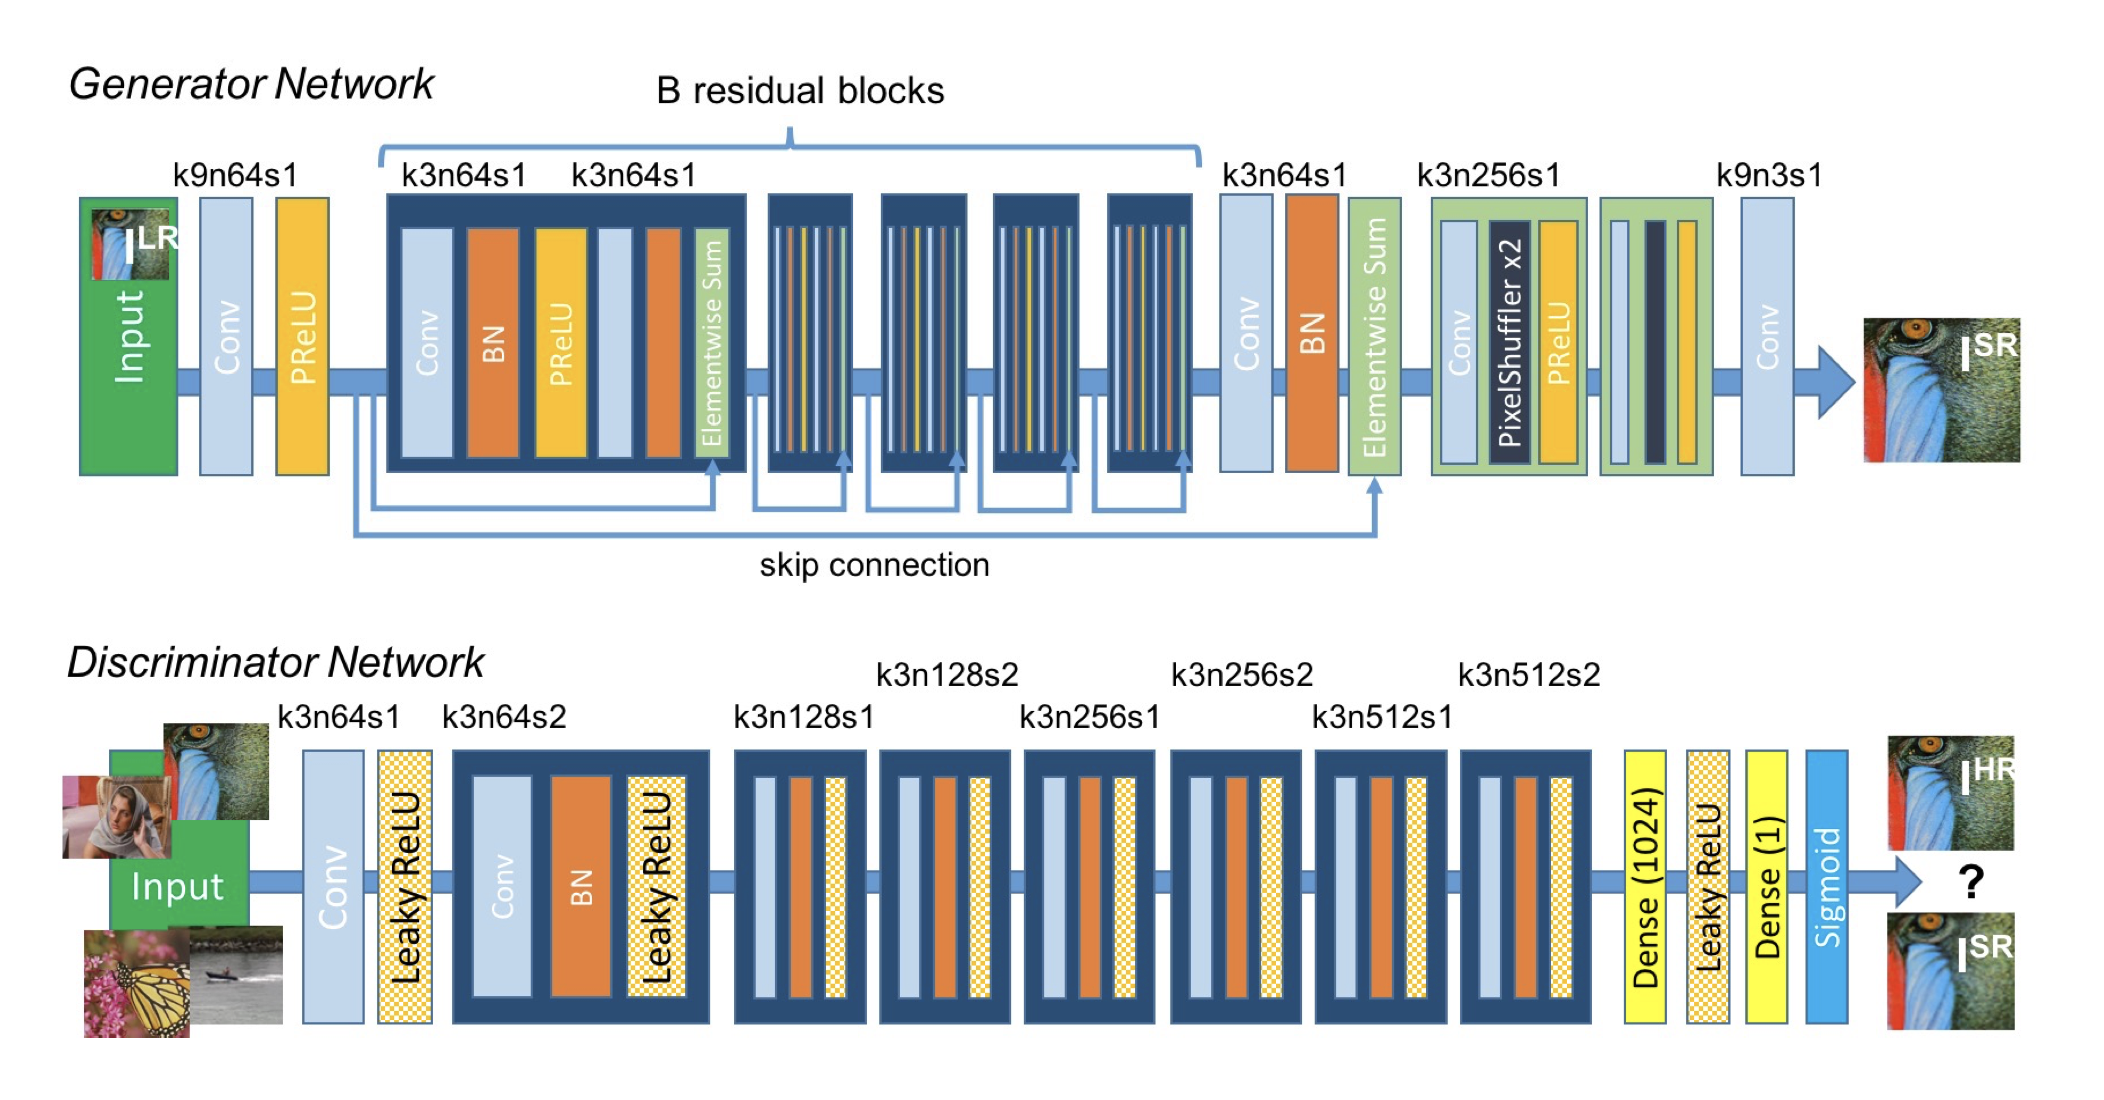

Paper link: https://arxiv.org/pdf/1609.04802.pdf

# Dataset Download

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paulrohan2020/mirflickr25k
!unzip '/content/mirflickr25k.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5533.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5534.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5535.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5536.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5537.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5538.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5539.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags554.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5540.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5541.txt  
  inflating: /content/dataset/mirflickr25k/mirflickr/meta/tags_raw/tags5542.txt  
  inflating: /content/dataset/mirflickr25k/mirfl

In [ ]:
import cv2
import os
import random

main_dir = '/content/dataset/mirflickr25k/mirflickr'  # Adjust this path as needed

train_dir = "data/train"  # Directory for training images
test_dir = "data/test"    # Directory for test images

# Create the train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create hr_images and lr_images directories within train and test directories
os.makedirs(os.path.join(train_dir, "hr_images"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "lr_images"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "hr_images"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "lr_images"), exist_ok=True)

# List all the .jpg images in the main directory
image_files = [f for f in os.listdir(main_dir) if f.endswith(".jpg")]

# Randomly shuffle the list of image files
random.shuffle(image_files)

# Calculate the number of images for training and testing
num_images = len(image_files)
num_train_images = int(0.95 * num_images)
num_test_images = num_images - num_train_images

# Split the image files into training and test sets
train_image_files = image_files[:num_train_images]
test_image_files = image_files[num_train_images:]

# Process and resize images to 256x256 pixels and save them in the appropriate directories
for img in train_image_files:
    try:
        img_array = cv2.imread(os.path.join(main_dir, img))
        if img_array is not None:
            img_array = cv2.resize(img_array, (256, 256))
            lr_img_array = cv2.resize(img_array, (64, 64))  # Low-resolution images

            cv2.imwrite(os.path.join(train_dir, "hr_images", img), img_array)
            cv2.imwrite(os.path.join(train_dir, "lr_images", img), lr_img_array)
        else:
            print(f"Skipping {img} due to loading error.")
    except Exception as e:
        print(f"Error processing {img}: {str(e)}")

for img in test_image_files:
    try:
        img_array = cv2.imread(os.path.join(main_dir, img))
        if img_array is not None:
            img_array = cv2.resize(img_array, (256, 256))
            lr_img_array = cv2.resize(img_array, (64, 64))  # Low-resolution images

            cv2.imwrite(os.path.join(test_dir, "hr_images", img), img_array)
            cv2.imwrite(os.path.join(test_dir, "lr_images", img), lr_img_array)
        else:
            print(f"Skipping {img} due to loading error.")
    except Exception as e:
        print(f"Error processing {img}: {str(e)}")

# Count the number of images in the train and test directories
train_hr_images = os.listdir(os.path.join(train_dir, "hr_images"))
train_lr_images = os.listdir(os.path.join(train_dir, "lr_images"))
test_hr_images = os.listdir(os.path.join(test_dir, "hr_images"))
test_lr_images = os.listdir(os.path.join(test_dir, "lr_images"))

# Print the counts
print(f"Train HR Images Count: {len(train_hr_images)}")
print(f"Train LR Images Count: {len(train_lr_images)}")
print(f"Test HR Images Count: {len(test_hr_images)}")
print(f"Test LR Images Count: {len(test_lr_images)}")


Train HR Images Count: 23750
Train LR Images Count: 23750
Test HR Images Count: 1250
Test LR Images Count: 1250


In [ ]:
path = '/content/data/train/hr_images'
print(len(os.listdir(path)))

23750


# Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


# Modeling

## Generator

In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

# Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op, name='generator')

## Discriminator

In [ ]:
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

# Discriminator, as described in the original paper
def create_discriminator(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(inputs=disc_ip, outputs=validity, name='discriminator')



## VGG19 Model

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output, name = 'Vgg')



## GAN Model Combined

In [ ]:
# Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features],  name = 'SRGAN')

# Image Load

In [27]:
lr_list = os.listdir("/content/data/train/lr_images")[:5000]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/data/train/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/data/train/hr_images")[:5000]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/data/train/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


## Visualizing Images

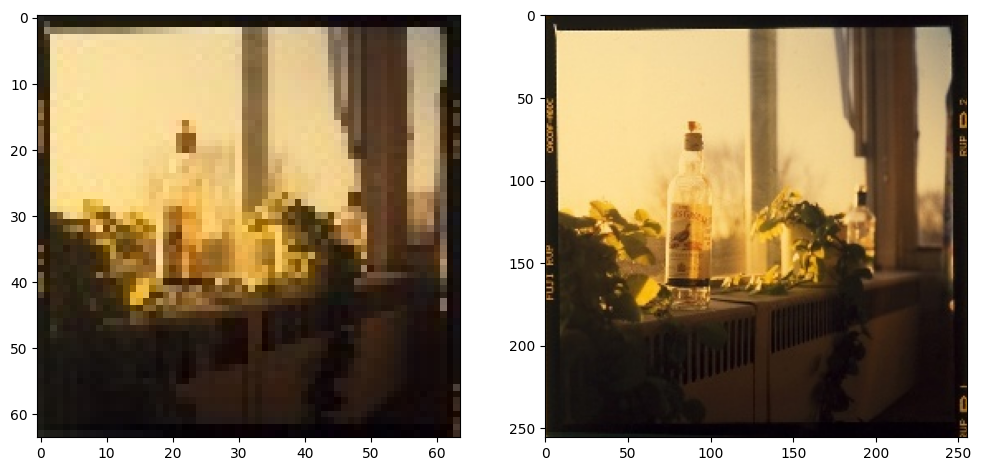

In [28]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

In [29]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [30]:
hr_images.shape

(5000, 256, 256, 3)

In [31]:
lr_images.shape

(5000, 64, 64, 3)

In [32]:
hr_shape = (hr_images.shape[1], hr_images.shape[2], hr_images.shape[3])
lr_shape = (lr_images.shape[1], lr_images.shape[2], lr_images.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [33]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((256, 256,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 64, 64, 64)           15616     ['input_4[0][0]']             
                                                                                                  
 p_re_lu_19 (PReLU)          (None, 64, 64, 64)           64        ['conv2d_45[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)          (None, 64, 64, 64)           36928     ['p_re_lu_19[0][0]']          
                                                                                          

In [34]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "SRGAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 256, 3)          2044291   ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    1389125   ['generator[0][0]']           
                                                          77                                  

In [35]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_images.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_images[start_idx:end_idx])
    train_lr_batches.append(lr_images[start_idx:end_idx])


In [36]:
epochs = 3
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e + 1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 3 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/Colab Notebooks/SRGAN generator/gen_e_"+ str(e+1) +".h5")

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 89ms/step


  0%|          | 1/5000 [00:32<45:11:36, 32.55s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/5000 [00:32<18:44:23, 13.50s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/5000 [00:32<10:17:02,  7.41s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 4/5000 [00:33<6:18:36,  4.55s/it] 

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/5000 [00:33<4:06:57,  2.97s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 6/5000 [00:33<2:47:40,  2.01s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/5000 [00:33<1:57:16,  1.41s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 8/5000 [00:33<1:24:09,  1.01s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 9/5000 [00:33<1:02:02,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 10/5000 [00:34<46:57,  1.77it/s] 

1/1 [==============================] - 0s 20ms/step


  0%|          | 11/5000 [00:34<36:44,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 12/5000 [00:34<29:36,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 13/5000 [00:34<24:49,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 14/5000 [00:34<21:32,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 15/5000 [00:34<19:08,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 16/5000 [00:34<17:24,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 17/5000 [00:35<16:09,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 18/5000 [00:35<15:16,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 19/5000 [00:35<14:38,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 20/5000 [00:35<14:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 21/5000 [00:35<13:55,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 22/5000 [00:35<13:43,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 23/5000 [00:36<13:34,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 24/5000 [00:36<13:28,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 25/5000 [00:36<13:25,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 26/5000 [00:36<13:18,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 27/5000 [00:36<13:09,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 28/5000 [00:36<13:05,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 29/5000 [00:37<13:10,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 30/5000 [00:37<13:10,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 31/5000 [00:37<13:10,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 32/5000 [00:37<13:13,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 33/5000 [00:37<13:08,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 34/5000 [00:37<13:05,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 35/5000 [00:38<13:07,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 36/5000 [00:38<13:02,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 37/5000 [00:38<13:14,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 38/5000 [00:38<13:12,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 39/5000 [00:38<13:10,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 40/5000 [00:38<13:08,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 41/5000 [00:38<13:10,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 42/5000 [00:39<13:03,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 43/5000 [00:39<13:01,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 44/5000 [00:39<13:09,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 45/5000 [00:39<13:17,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 46/5000 [00:39<13:11,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 47/5000 [00:39<13:07,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 48/5000 [00:40<13:09,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 49/5000 [00:40<13:15,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 50/5000 [00:40<13:15,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 51/5000 [00:40<13:13,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 52/5000 [00:40<13:13,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 53/5000 [00:40<13:22,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 54/5000 [00:41<13:17,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 55/5000 [00:41<13:09,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 56/5000 [00:41<13:13,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 57/5000 [00:41<13:12,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 58/5000 [00:41<13:07,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 59/5000 [00:41<13:05,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 60/5000 [00:42<13:06,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 61/5000 [00:42<13:13,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 62/5000 [00:42<13:12,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 63/5000 [00:42<13:09,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 64/5000 [00:42<13:07,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 65/5000 [00:42<13:03,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 66/5000 [00:42<13:02,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 67/5000 [00:43<12:59,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 68/5000 [00:43<12:59,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 69/5000 [00:43<13:12,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 70/5000 [00:43<13:14,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 71/5000 [00:43<13:09,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 72/5000 [00:43<13:12,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 73/5000 [00:44<13:20,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 74/5000 [00:44<13:18,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 75/5000 [00:44<13:23,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 76/5000 [00:44<13:19,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 77/5000 [00:44<13:21,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 78/5000 [00:44<13:18,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 79/5000 [00:45<13:15,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 80/5000 [00:45<13:15,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 81/5000 [00:45<13:15,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 82/5000 [00:45<13:17,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 83/5000 [00:45<13:17,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 84/5000 [00:45<13:32,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 85/5000 [00:46<13:33,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 86/5000 [00:46<13:33,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 87/5000 [00:46<13:27,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 88/5000 [00:46<13:18,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 89/5000 [00:46<13:20,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 90/5000 [00:46<13:17,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 91/5000 [00:47<13:18,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 92/5000 [00:47<13:16,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 93/5000 [00:47<13:21,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 94/5000 [00:47<13:25,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 95/5000 [00:47<13:24,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 96/5000 [00:47<13:28,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 97/5000 [00:48<13:36,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 98/5000 [00:48<13:27,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 99/5000 [00:48<13:28,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 100/5000 [00:48<13:23,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 101/5000 [00:48<13:23,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 102/5000 [00:48<13:20,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 103/5000 [00:48<13:16,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 104/5000 [00:49<13:06,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 105/5000 [00:49<13:00,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 106/5000 [00:49<13:00,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 107/5000 [00:49<13:04,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 108/5000 [00:49<13:03,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 109/5000 [00:49<13:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 110/5000 [00:50<13:07,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 111/5000 [00:50<13:05,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 112/5000 [00:50<12:58,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 113/5000 [00:50<12:54,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 114/5000 [00:50<12:51,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 115/5000 [00:50<12:46,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 116/5000 [00:51<12:49,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 117/5000 [00:51<12:56,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 118/5000 [00:51<12:56,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 119/5000 [00:51<13:09,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 120/5000 [00:51<13:02,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 121/5000 [00:51<13:01,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 122/5000 [00:52<13:06,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 123/5000 [00:52<13:03,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 124/5000 [00:52<13:10,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 125/5000 [00:52<14:04,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 126/5000 [00:52<13:44,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 127/5000 [00:52<13:26,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 128/5000 [00:53<13:13,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 129/5000 [00:53<13:09,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 130/5000 [00:53<13:03,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 131/5000 [00:53<13:01,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 132/5000 [00:53<12:57,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 133/5000 [00:53<13:01,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 134/5000 [00:53<13:04,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 135/5000 [00:54<13:01,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 136/5000 [00:54<13:03,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 137/5000 [00:54<13:01,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 138/5000 [00:54<12:58,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 139/5000 [00:54<12:57,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 140/5000 [00:54<12:57,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 141/5000 [00:55<13:03,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 142/5000 [00:55<13:08,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 143/5000 [00:55<13:07,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 144/5000 [00:55<13:02,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 145/5000 [00:55<13:01,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 146/5000 [00:55<12:57,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 147/5000 [00:56<12:59,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 148/5000 [00:56<12:58,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 149/5000 [00:56<13:08,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 150/5000 [00:56<13:10,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 151/5000 [00:56<13:09,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 152/5000 [00:56<12:59,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 153/5000 [00:57<12:54,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 154/5000 [00:57<12:57,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 155/5000 [00:57<12:53,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 156/5000 [00:57<12:52,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 157/5000 [00:57<13:00,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 158/5000 [00:57<13:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 159/5000 [00:58<13:01,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 160/5000 [00:58<13:01,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 161/5000 [00:58<13:01,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 162/5000 [00:58<13:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 163/5000 [00:58<12:55,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 164/5000 [00:58<12:51,  6.27it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 165/5000 [00:58<13:11,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 166/5000 [00:59<13:15,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 167/5000 [00:59<13:05,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 168/5000 [00:59<12:59,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 169/5000 [00:59<13:13,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 170/5000 [00:59<13:09,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 171/5000 [00:59<13:12,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 172/5000 [01:00<13:09,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 173/5000 [01:00<13:19,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 174/5000 [01:00<13:13,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 175/5000 [01:00<13:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 176/5000 [01:00<13:26,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 177/5000 [01:00<13:23,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 178/5000 [01:01<13:08,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 179/5000 [01:01<13:01,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 180/5000 [01:01<13:00,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 181/5000 [01:01<13:11,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 182/5000 [01:01<13:06,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 183/5000 [01:01<13:03,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 184/5000 [01:02<13:02,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 185/5000 [01:02<13:01,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 186/5000 [01:02<13:00,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 187/5000 [01:02<12:59,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 188/5000 [01:02<13:13,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 189/5000 [01:02<13:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 190/5000 [01:03<13:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 191/5000 [01:03<13:13,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 192/5000 [01:03<13:05,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 193/5000 [01:03<13:00,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 194/5000 [01:03<12:55,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 195/5000 [01:03<12:57,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 196/5000 [01:04<12:55,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 197/5000 [01:04<13:04,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 198/5000 [01:04<13:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 199/5000 [01:04<13:04,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 200/5000 [01:04<12:59,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 201/5000 [01:04<12:54,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 202/5000 [01:05<13:02,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 203/5000 [01:05<12:56,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 204/5000 [01:05<13:00,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 205/5000 [01:05<13:06,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 206/5000 [01:05<13:01,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 207/5000 [01:05<12:57,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 208/5000 [01:06<12:55,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 209/5000 [01:06<12:43,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 210/5000 [01:06<12:44,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 211/5000 [01:06<12:39,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 212/5000 [01:06<12:36,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 213/5000 [01:06<12:55,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 214/5000 [01:06<12:55,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 215/5000 [01:07<12:50,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 216/5000 [01:07<12:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 217/5000 [01:07<12:41,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 218/5000 [01:07<12:40,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 219/5000 [01:07<12:39,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 220/5000 [01:07<12:43,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 221/5000 [01:08<12:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 222/5000 [01:08<12:47,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 223/5000 [01:08<12:48,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 224/5000 [01:08<12:48,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 225/5000 [01:08<12:48,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 226/5000 [01:08<12:49,  6.20it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 227/5000 [01:09<13:06,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 228/5000 [01:09<13:00,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 229/5000 [01:09<13:02,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 230/5000 [01:09<13:00,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 231/5000 [01:09<12:51,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 232/5000 [01:09<12:53,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 233/5000 [01:10<13:21,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 234/5000 [01:10<13:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 235/5000 [01:10<12:59,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 236/5000 [01:10<12:48,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 237/5000 [01:10<12:52,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 238/5000 [01:10<12:46,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 239/5000 [01:11<12:45,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 240/5000 [01:11<13:05,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 241/5000 [01:11<12:55,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 242/5000 [01:11<13:02,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 243/5000 [01:11<13:08,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 244/5000 [01:11<13:02,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 245/5000 [01:12<13:07,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 246/5000 [01:12<13:17,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 247/5000 [01:12<13:09,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 248/5000 [01:12<12:57,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 249/5000 [01:12<12:48,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 250/5000 [01:12<12:42,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 251/5000 [01:12<12:43,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 252/5000 [01:13<12:48,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 253/5000 [01:13<12:59,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 254/5000 [01:13<13:04,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 255/5000 [01:13<13:03,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 256/5000 [01:13<13:00,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 257/5000 [01:13<12:54,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 258/5000 [01:14<12:45,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 259/5000 [01:14<12:36,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 260/5000 [01:14<12:32,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 261/5000 [01:14<12:45,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 262/5000 [01:14<12:40,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 263/5000 [01:14<12:42,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 264/5000 [01:15<12:39,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 265/5000 [01:15<12:36,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 266/5000 [01:15<12:37,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 267/5000 [01:15<12:38,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 268/5000 [01:15<12:33,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 269/5000 [01:15<12:42,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 270/5000 [01:16<12:42,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 271/5000 [01:16<12:38,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 272/5000 [01:16<12:41,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 273/5000 [01:16<12:33,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 274/5000 [01:16<12:25,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 275/5000 [01:16<12:25,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 276/5000 [01:16<12:26,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 277/5000 [01:17<12:45,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 278/5000 [01:17<12:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 279/5000 [01:17<12:46,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 280/5000 [01:17<12:40,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 281/5000 [01:17<12:37,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 282/5000 [01:17<12:38,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 283/5000 [01:18<12:38,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 284/5000 [01:18<12:41,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 285/5000 [01:18<12:52,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 286/5000 [01:18<12:55,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 287/5000 [01:18<12:54,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 288/5000 [01:18<12:50,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 289/5000 [01:19<12:42,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 290/5000 [01:19<12:43,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 291/5000 [01:19<12:47,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 292/5000 [01:19<12:50,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 293/5000 [01:19<12:52,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 294/5000 [01:19<12:48,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 295/5000 [01:20<12:43,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 296/5000 [01:20<12:43,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 297/5000 [01:20<12:43,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 298/5000 [01:20<12:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 299/5000 [01:20<12:43,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 300/5000 [01:20<12:45,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 301/5000 [01:21<12:54,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 302/5000 [01:21<12:53,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 303/5000 [01:21<12:53,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 304/5000 [01:21<12:58,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 305/5000 [01:21<12:46,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 306/5000 [01:21<12:46,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 307/5000 [01:22<12:41,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 308/5000 [01:22<12:36,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 309/5000 [01:22<12:51,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 310/5000 [01:22<12:54,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 311/5000 [01:22<12:48,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 312/5000 [01:22<12:46,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 313/5000 [01:23<12:43,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 314/5000 [01:23<12:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 315/5000 [01:23<12:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 316/5000 [01:23<12:37,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 317/5000 [01:23<12:42,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 318/5000 [01:23<12:44,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 319/5000 [01:24<12:45,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 320/5000 [01:24<12:42,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 321/5000 [01:24<12:37,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 322/5000 [01:24<12:39,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 323/5000 [01:24<12:42,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 324/5000 [01:24<12:47,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 325/5000 [01:24<12:54,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 326/5000 [01:25<12:54,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 327/5000 [01:25<12:48,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 328/5000 [01:25<12:50,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 329/5000 [01:25<12:46,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 330/5000 [01:25<12:46,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 331/5000 [01:25<12:45,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 332/5000 [01:26<12:44,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 333/5000 [01:26<12:57,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 334/5000 [01:26<12:57,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 335/5000 [01:26<12:54,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 336/5000 [01:26<12:52,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 337/5000 [01:26<12:45,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 338/5000 [01:27<12:41,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 339/5000 [01:27<12:40,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 340/5000 [01:27<12:37,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 341/5000 [01:27<12:44,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 342/5000 [01:27<12:41,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 343/5000 [01:27<12:39,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 344/5000 [01:28<12:37,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 345/5000 [01:28<12:37,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 346/5000 [01:28<12:37,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 347/5000 [01:28<12:29,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 348/5000 [01:28<12:21,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 349/5000 [01:28<12:25,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 350/5000 [01:29<13:01,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 351/5000 [01:29<12:46,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 352/5000 [01:29<12:38,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 353/5000 [01:29<12:30,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 354/5000 [01:29<12:24,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 355/5000 [01:29<12:17,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 356/5000 [01:30<12:13,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 357/5000 [01:30<12:15,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 358/5000 [01:30<12:22,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 359/5000 [01:30<12:16,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 360/5000 [01:30<12:11,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 361/5000 [01:30<12:06,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 362/5000 [01:30<12:06,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 363/5000 [01:31<12:08,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 364/5000 [01:31<12:07,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 365/5000 [01:31<12:14,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 366/5000 [01:31<12:14,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 367/5000 [01:31<12:09,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 368/5000 [01:31<12:10,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 369/5000 [01:32<12:09,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 370/5000 [01:32<12:16,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 371/5000 [01:32<12:15,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 372/5000 [01:32<12:17,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 373/5000 [01:32<12:21,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 374/5000 [01:32<12:19,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 375/5000 [01:33<12:16,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 376/5000 [01:33<12:12,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 377/5000 [01:33<12:14,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 378/5000 [01:33<12:17,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 379/5000 [01:33<12:14,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 380/5000 [01:33<12:13,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 381/5000 [01:34<12:25,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 382/5000 [01:34<12:23,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 383/5000 [01:34<12:21,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 384/5000 [01:34<12:19,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 385/5000 [01:34<12:21,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 386/5000 [01:34<12:16,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 387/5000 [01:34<12:16,  6.27it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 388/5000 [01:35<12:17,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 389/5000 [01:35<12:24,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 390/5000 [01:35<12:27,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 391/5000 [01:35<12:26,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 392/5000 [01:35<12:28,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 393/5000 [01:35<12:42,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 394/5000 [01:36<12:45,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 395/5000 [01:36<12:36,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 396/5000 [01:36<12:25,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 397/5000 [01:36<12:26,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 398/5000 [01:36<12:29,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 399/5000 [01:36<12:27,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 400/5000 [01:37<12:24,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 401/5000 [01:37<12:30,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 402/5000 [01:37<12:33,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 403/5000 [01:37<12:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 404/5000 [01:37<12:40,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 405/5000 [01:37<12:47,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 406/5000 [01:38<12:40,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 407/5000 [01:38<12:38,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 408/5000 [01:38<12:49,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 409/5000 [01:38<12:48,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 410/5000 [01:38<12:33,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 411/5000 [01:38<12:29,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 412/5000 [01:39<12:29,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 413/5000 [01:39<12:28,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 414/5000 [01:39<12:25,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 415/5000 [01:39<12:27,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 416/5000 [01:39<12:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 417/5000 [01:39<12:11,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 418/5000 [01:40<12:10,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 419/5000 [01:40<12:05,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 420/5000 [01:40<12:05,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 421/5000 [01:40<12:12,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 422/5000 [01:40<12:08,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 423/5000 [01:40<12:03,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 424/5000 [01:40<12:03,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 425/5000 [01:41<12:00,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 426/5000 [01:41<11:59,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 427/5000 [01:41<12:11,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 428/5000 [01:41<12:06,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 429/5000 [01:41<12:10,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 430/5000 [01:41<12:08,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 431/5000 [01:42<12:04,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 432/5000 [01:42<12:05,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 433/5000 [01:42<12:02,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 434/5000 [01:42<12:00,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 435/5000 [01:42<11:57,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 436/5000 [01:42<12:04,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 437/5000 [01:43<12:10,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 438/5000 [01:43<12:05,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 439/5000 [01:43<12:08,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 440/5000 [01:43<12:12,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 441/5000 [01:43<12:08,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 442/5000 [01:43<12:05,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 443/5000 [01:44<12:04,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 444/5000 [01:44<12:01,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 445/5000 [01:44<12:10,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 446/5000 [01:44<12:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 447/5000 [01:44<12:15,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 448/5000 [01:44<12:10,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 449/5000 [01:44<12:07,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 450/5000 [01:45<12:01,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 451/5000 [01:45<11:58,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 452/5000 [01:45<11:56,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 453/5000 [01:45<12:09,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 454/5000 [01:45<12:06,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 455/5000 [01:45<12:06,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 456/5000 [01:46<12:03,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 457/5000 [01:46<11:55,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 458/5000 [01:46<11:52,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 459/5000 [01:46<11:46,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 460/5000 [01:46<11:47,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 461/5000 [01:46<11:54,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 462/5000 [01:47<11:56,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 463/5000 [01:47<11:52,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 464/5000 [01:47<11:59,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 465/5000 [01:47<12:01,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 466/5000 [01:47<11:59,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 467/5000 [01:47<11:55,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 468/5000 [01:47<11:53,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 469/5000 [01:48<12:00,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 470/5000 [01:48<11:57,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 471/5000 [01:48<11:59,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 472/5000 [01:48<11:53,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 473/5000 [01:48<11:51,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 474/5000 [01:48<11:53,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 475/5000 [01:49<11:56,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 476/5000 [01:49<11:55,  6.32it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 477/5000 [01:49<12:08,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 478/5000 [01:49<12:11,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 479/5000 [01:49<12:16,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 480/5000 [01:49<12:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 481/5000 [01:50<12:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 482/5000 [01:50<12:11,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 483/5000 [01:50<12:12,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 484/5000 [01:50<12:20,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 485/5000 [01:50<12:24,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 486/5000 [01:50<12:15,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 487/5000 [01:51<12:15,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 488/5000 [01:51<12:16,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 489/5000 [01:51<12:13,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 490/5000 [01:51<12:10,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 491/5000 [01:51<12:11,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 492/5000 [01:51<12:14,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 493/5000 [01:52<12:46,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 494/5000 [01:52<12:39,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 495/5000 [01:52<12:32,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 496/5000 [01:52<12:33,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 497/5000 [01:52<12:21,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 498/5000 [01:52<12:14,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 499/5000 [01:53<12:37,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 500/5000 [01:53<12:23,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 501/5000 [01:53<12:20,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 502/5000 [01:53<12:29,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 503/5000 [01:53<12:17,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 504/5000 [01:53<12:12,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 505/5000 [01:54<12:08,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 506/5000 [01:54<12:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 507/5000 [01:54<12:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 508/5000 [01:54<12:09,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 509/5000 [01:54<12:10,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 510/5000 [01:54<12:10,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 511/5000 [01:54<12:18,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 512/5000 [01:55<12:24,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 513/5000 [01:55<12:20,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 514/5000 [01:55<12:18,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 515/5000 [01:55<12:11,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 516/5000 [01:55<12:15,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 517/5000 [01:55<12:23,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 518/5000 [01:56<12:16,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 519/5000 [01:56<12:11,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 520/5000 [01:56<12:09,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 521/5000 [01:56<12:06,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 522/5000 [01:56<12:05,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 523/5000 [01:56<12:03,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 524/5000 [01:57<12:00,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 525/5000 [01:57<12:06,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 526/5000 [01:57<12:01,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 527/5000 [01:57<11:58,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 528/5000 [01:57<12:13,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 529/5000 [01:57<12:12,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 530/5000 [01:58<12:05,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 531/5000 [01:58<12:02,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 532/5000 [01:58<12:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 533/5000 [01:58<12:06,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 534/5000 [01:58<12:00,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 535/5000 [01:58<11:52,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 536/5000 [01:59<12:04,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 537/5000 [01:59<12:02,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 538/5000 [01:59<11:57,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 539/5000 [01:59<11:53,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 540/5000 [01:59<11:50,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 541/5000 [01:59<11:52,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 542/5000 [02:00<11:52,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 543/5000 [02:00<11:48,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 544/5000 [02:00<11:46,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 545/5000 [02:00<11:47,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 546/5000 [02:00<11:44,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 547/5000 [02:00<11:39,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 548/5000 [02:00<11:43,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 549/5000 [02:01<11:52,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 550/5000 [02:01<11:51,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 551/5000 [02:01<11:49,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 552/5000 [02:01<11:53,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 553/5000 [02:01<11:53,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 554/5000 [02:01<11:52,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 555/5000 [02:02<11:45,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 556/5000 [02:02<11:41,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 557/5000 [02:02<11:46,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 558/5000 [02:02<11:48,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 559/5000 [02:02<11:47,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 560/5000 [02:02<11:45,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 561/5000 [02:03<11:52,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 562/5000 [02:03<11:46,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 563/5000 [02:03<11:49,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 564/5000 [02:03<11:49,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 565/5000 [02:03<11:51,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 566/5000 [02:03<11:54,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 567/5000 [02:04<11:54,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 568/5000 [02:04<11:46,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 569/5000 [02:04<11:49,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 570/5000 [02:04<11:48,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 571/5000 [02:04<11:49,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 572/5000 [02:04<11:49,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 573/5000 [02:04<12:10,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 574/5000 [02:05<12:06,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 575/5000 [02:05<12:15,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 576/5000 [02:05<12:04,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 577/5000 [02:05<12:03,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 578/5000 [02:05<11:59,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 579/5000 [02:05<11:57,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 580/5000 [02:06<11:58,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 581/5000 [02:06<11:52,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 582/5000 [02:06<11:49,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 583/5000 [02:06<11:45,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 584/5000 [02:06<11:51,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 585/5000 [02:06<11:49,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 586/5000 [02:07<11:44,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 587/5000 [02:07<11:41,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 588/5000 [02:07<11:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 589/5000 [02:07<11:47,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 590/5000 [02:07<11:44,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 591/5000 [02:07<11:40,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 592/5000 [02:08<11:42,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 593/5000 [02:08<11:40,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 594/5000 [02:08<11:37,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 595/5000 [02:08<11:38,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 596/5000 [02:08<11:46,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 597/5000 [02:08<11:48,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 598/5000 [02:08<11:43,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 599/5000 [02:09<11:35,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 600/5000 [02:09<11:36,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 601/5000 [02:09<11:40,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 602/5000 [02:09<11:37,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 603/5000 [02:09<11:35,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 604/5000 [02:09<11:41,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 605/5000 [02:10<11:37,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 606/5000 [02:10<11:38,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 607/5000 [02:10<11:42,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 608/5000 [02:10<11:36,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 609/5000 [02:10<11:32,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 610/5000 [02:10<11:31,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 611/5000 [02:11<11:31,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 612/5000 [02:11<11:36,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 613/5000 [02:11<11:36,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 614/5000 [02:11<11:42,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 615/5000 [02:11<11:38,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 616/5000 [02:11<11:36,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 617/5000 [02:12<11:35,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 618/5000 [02:12<11:35,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 619/5000 [02:12<11:32,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 620/5000 [02:12<11:37,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 621/5000 [02:12<11:43,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 622/5000 [02:12<11:51,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 623/5000 [02:12<11:54,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 624/5000 [02:13<11:54,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 625/5000 [02:13<11:47,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 626/5000 [02:13<11:44,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 627/5000 [02:13<11:37,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 628/5000 [02:13<11:43,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 629/5000 [02:13<11:46,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 630/5000 [02:14<11:47,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 631/5000 [02:14<11:40,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 632/5000 [02:14<11:38,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 633/5000 [02:14<11:34,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 634/5000 [02:14<11:37,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 635/5000 [02:14<11:35,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 636/5000 [02:15<11:43,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 637/5000 [02:15<11:37,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 638/5000 [02:15<11:37,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 639/5000 [02:15<11:43,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 640/5000 [02:15<11:43,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 641/5000 [02:15<11:39,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 642/5000 [02:16<11:35,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 643/5000 [02:16<11:31,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 644/5000 [02:16<11:42,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 645/5000 [02:16<11:54,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 646/5000 [02:16<11:51,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 647/5000 [02:16<11:45,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 648/5000 [02:16<11:42,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 649/5000 [02:17<11:39,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 650/5000 [02:17<11:39,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 651/5000 [02:17<11:55,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 652/5000 [02:17<11:55,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 653/5000 [02:17<11:58,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 654/5000 [02:17<11:57,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 655/5000 [02:18<11:49,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 656/5000 [02:18<11:42,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 657/5000 [02:18<11:35,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 658/5000 [02:18<11:34,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 659/5000 [02:18<11:31,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 660/5000 [02:18<11:36,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 661/5000 [02:19<11:32,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 662/5000 [02:19<11:28,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 663/5000 [02:19<11:29,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 664/5000 [02:19<11:34,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 665/5000 [02:19<11:30,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 666/5000 [02:19<11:26,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 667/5000 [02:20<11:23,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 668/5000 [02:20<11:27,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 669/5000 [02:20<11:26,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 670/5000 [02:20<11:24,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 671/5000 [02:20<11:28,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 672/5000 [02:20<11:24,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 673/5000 [02:21<11:32,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 674/5000 [02:21<11:29,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 675/5000 [02:21<11:27,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 676/5000 [02:21<11:39,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 677/5000 [02:21<11:41,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 678/5000 [02:21<11:40,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 679/5000 [02:21<11:39,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 680/5000 [02:22<11:37,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 681/5000 [02:22<11:34,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 682/5000 [02:22<11:33,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 683/5000 [02:22<11:29,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 684/5000 [02:22<11:32,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 685/5000 [02:22<11:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 686/5000 [02:23<11:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 687/5000 [02:23<11:30,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 688/5000 [02:23<11:27,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 689/5000 [02:23<11:24,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 690/5000 [02:23<11:25,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 691/5000 [02:23<11:28,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 692/5000 [02:24<11:40,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 693/5000 [02:24<11:35,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 694/5000 [02:24<11:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 695/5000 [02:24<11:29,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 696/5000 [02:24<11:28,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 697/5000 [02:24<11:22,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 698/5000 [02:25<11:26,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 699/5000 [02:25<11:22,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 700/5000 [02:25<11:30,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 701/5000 [02:25<11:37,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 702/5000 [02:25<11:33,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 703/5000 [02:25<11:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 704/5000 [02:25<11:27,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 705/5000 [02:26<11:22,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 706/5000 [02:26<11:18,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 707/5000 [02:26<11:14,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 708/5000 [02:26<11:21,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 709/5000 [02:26<11:20,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 710/5000 [02:26<11:28,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 711/5000 [02:27<11:22,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 712/5000 [02:27<11:18,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 713/5000 [02:27<11:15,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 714/5000 [02:27<11:17,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 715/5000 [02:27<11:14,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 716/5000 [02:27<11:18,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 717/5000 [02:28<11:23,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 718/5000 [02:28<11:22,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 719/5000 [02:28<11:31,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 720/5000 [02:28<11:27,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 721/5000 [02:28<11:26,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 722/5000 [02:28<11:24,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 723/5000 [02:29<11:34,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 724/5000 [02:29<11:37,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 725/5000 [02:29<11:45,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 726/5000 [02:29<11:38,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 727/5000 [02:29<11:34,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 728/5000 [02:29<11:28,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 729/5000 [02:29<11:41,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 730/5000 [02:30<11:41,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 731/5000 [02:30<11:37,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 732/5000 [02:30<11:38,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 733/5000 [02:30<11:40,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 734/5000 [02:30<11:35,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 735/5000 [02:30<11:38,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 736/5000 [02:31<11:35,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 737/5000 [02:31<11:28,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 738/5000 [02:31<11:26,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 739/5000 [02:31<11:19,  6.28it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 740/5000 [02:31<11:22,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 741/5000 [02:31<11:20,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 742/5000 [02:32<11:20,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 743/5000 [02:32<11:16,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 744/5000 [02:32<11:14,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 745/5000 [02:32<11:24,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 746/5000 [02:32<11:24,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 747/5000 [02:32<11:17,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 748/5000 [02:33<11:32,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 749/5000 [02:33<11:28,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 750/5000 [02:33<11:21,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 751/5000 [02:33<11:17,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 752/5000 [02:33<11:14,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 753/5000 [02:33<11:11,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 754/5000 [02:34<11:18,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 755/5000 [02:34<11:12,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 756/5000 [02:34<11:19,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 757/5000 [02:34<11:16,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 758/5000 [02:34<11:18,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 759/5000 [02:34<11:17,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 760/5000 [02:34<11:21,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 761/5000 [02:35<11:32,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 762/5000 [02:35<11:24,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 763/5000 [02:35<11:21,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 764/5000 [02:35<11:24,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 765/5000 [02:35<11:22,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 766/5000 [02:35<11:24,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 767/5000 [02:36<11:41,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 768/5000 [02:36<11:30,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 769/5000 [02:36<11:18,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 770/5000 [02:36<11:21,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 771/5000 [02:36<11:15,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 772/5000 [02:36<11:21,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 773/5000 [02:37<11:37,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 774/5000 [02:37<11:29,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 775/5000 [02:37<11:26,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 776/5000 [02:37<11:28,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 777/5000 [02:37<11:22,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 778/5000 [02:37<11:23,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 779/5000 [02:38<11:18,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 780/5000 [02:38<11:25,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 781/5000 [02:38<11:21,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 782/5000 [02:38<11:20,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 783/5000 [02:38<11:18,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 784/5000 [02:38<11:15,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 785/5000 [02:39<11:10,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 786/5000 [02:39<11:06,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 787/5000 [02:39<11:06,  6.32it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 788/5000 [02:39<11:16,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 789/5000 [02:39<11:16,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 790/5000 [02:39<11:11,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 791/5000 [02:39<11:10,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 792/5000 [02:40<11:07,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 793/5000 [02:40<11:05,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 794/5000 [02:40<11:05,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 795/5000 [02:40<11:07,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 796/5000 [02:40<11:09,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 797/5000 [02:40<11:05,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 798/5000 [02:41<11:08,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 799/5000 [02:41<11:04,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 800/5000 [02:41<11:12,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 801/5000 [02:41<11:07,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 802/5000 [02:41<11:06,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 803/5000 [02:41<11:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 804/5000 [02:42<11:09,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 805/5000 [02:42<11:08,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 806/5000 [02:42<11:13,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 807/5000 [02:42<11:11,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 808/5000 [02:42<11:06,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 809/5000 [02:42<11:05,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 810/5000 [02:42<11:08,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 811/5000 [02:43<11:09,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 812/5000 [02:43<11:18,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 813/5000 [02:43<11:20,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 814/5000 [02:43<11:14,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 815/5000 [02:43<11:13,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 816/5000 [02:43<11:10,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 817/5000 [02:44<11:05,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 818/5000 [02:44<11:06,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 819/5000 [02:44<11:09,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 820/5000 [02:44<11:22,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 821/5000 [02:44<11:22,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 822/5000 [02:44<11:22,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 823/5000 [02:45<11:14,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 824/5000 [02:45<11:05,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 825/5000 [02:45<11:01,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 826/5000 [02:45<11:01,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 827/5000 [02:45<10:54,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 828/5000 [02:45<11:05,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 829/5000 [02:46<11:03,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 830/5000 [02:46<10:59,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 831/5000 [02:46<10:58,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 832/5000 [02:46<10:55,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 833/5000 [02:46<11:04,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 834/5000 [02:46<11:02,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 835/5000 [02:46<11:00,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 836/5000 [02:47<11:01,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 837/5000 [02:47<11:04,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 838/5000 [02:47<11:03,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 839/5000 [02:47<11:02,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 840/5000 [02:47<11:04,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 841/5000 [02:47<11:04,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 842/5000 [02:48<11:02,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 843/5000 [02:48<11:03,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 844/5000 [02:48<11:21,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 845/5000 [02:48<11:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 846/5000 [02:48<11:16,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 847/5000 [02:48<11:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 848/5000 [02:49<11:19,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 849/5000 [02:49<11:24,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 850/5000 [02:49<11:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 851/5000 [02:49<11:22,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 852/5000 [02:49<11:37,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 853/5000 [02:49<11:35,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 854/5000 [02:50<11:22,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 855/5000 [02:50<11:19,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 856/5000 [02:50<11:14,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 857/5000 [02:50<11:14,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 858/5000 [02:50<11:21,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 859/5000 [02:50<11:13,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 860/5000 [02:51<11:22,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 861/5000 [02:51<11:17,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 862/5000 [02:51<11:09,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 863/5000 [02:51<11:10,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 864/5000 [02:51<11:10,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 865/5000 [02:51<11:14,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 866/5000 [02:52<11:21,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 867/5000 [02:52<11:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 868/5000 [02:52<11:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 869/5000 [02:52<11:10,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 870/5000 [02:52<11:10,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 871/5000 [02:52<11:19,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 872/5000 [02:53<11:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 873/5000 [02:53<11:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 874/5000 [02:53<11:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 875/5000 [02:53<11:14,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 876/5000 [02:53<11:28,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 877/5000 [02:53<11:26,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 878/5000 [02:54<11:29,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 879/5000 [02:54<11:23,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 880/5000 [02:54<11:20,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 881/5000 [02:54<11:13,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 882/5000 [02:54<11:08,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 883/5000 [02:54<11:08,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 884/5000 [02:55<11:21,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 885/5000 [02:55<11:20,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 886/5000 [02:55<11:23,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 887/5000 [02:55<11:24,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 888/5000 [02:55<11:18,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 889/5000 [02:55<11:13,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 890/5000 [02:55<11:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 891/5000 [02:56<11:20,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 892/5000 [02:56<11:30,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 893/5000 [02:56<11:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 894/5000 [02:56<11:20,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 895/5000 [02:56<11:12,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 896/5000 [02:56<11:11,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 897/5000 [02:57<11:08,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 898/5000 [02:57<11:04,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 899/5000 [02:57<11:06,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 900/5000 [02:57<11:13,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 901/5000 [02:57<11:08,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 902/5000 [02:57<11:09,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 903/5000 [02:58<11:11,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 904/5000 [02:58<11:09,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 905/5000 [02:58<11:08,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 906/5000 [02:58<11:03,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 907/5000 [02:58<11:05,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 908/5000 [02:58<11:10,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 909/5000 [02:59<11:19,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 910/5000 [02:59<11:24,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 911/5000 [02:59<11:30,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 912/5000 [02:59<11:36,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 913/5000 [02:59<11:22,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 914/5000 [02:59<11:10,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 915/5000 [03:00<11:07,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 916/5000 [03:00<11:11,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 917/5000 [03:00<11:15,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 918/5000 [03:00<11:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 919/5000 [03:00<11:07,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 920/5000 [03:00<11:03,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 921/5000 [03:01<11:00,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 922/5000 [03:01<11:00,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 923/5000 [03:01<11:04,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 924/5000 [03:01<11:08,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 925/5000 [03:01<11:03,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 926/5000 [03:01<10:58,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 927/5000 [03:02<11:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 928/5000 [03:02<10:58,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 929/5000 [03:02<10:56,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 930/5000 [03:02<10:53,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 931/5000 [03:02<10:51,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 932/5000 [03:02<11:01,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 933/5000 [03:03<10:55,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 934/5000 [03:03<10:53,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 935/5000 [03:03<10:54,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 936/5000 [03:03<10:52,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 937/5000 [03:03<10:49,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 938/5000 [03:03<10:48,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 939/5000 [03:03<10:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 940/5000 [03:04<10:58,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 941/5000 [03:04<11:02,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 942/5000 [03:04<11:06,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 943/5000 [03:04<11:02,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 944/5000 [03:04<10:58,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 945/5000 [03:04<10:53,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 946/5000 [03:05<10:45,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 947/5000 [03:05<10:51,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 948/5000 [03:05<11:00,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 949/5000 [03:05<10:57,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 950/5000 [03:05<10:55,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 951/5000 [03:05<10:52,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 952/5000 [03:06<10:51,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 953/5000 [03:06<10:46,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 954/5000 [03:06<10:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 955/5000 [03:06<10:48,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 956/5000 [03:07<18:44,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 957/5000 [03:07<16:49,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 958/5000 [03:07<15:20,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 959/5000 [03:07<14:15,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 960/5000 [03:07<13:47,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 961/5000 [03:08<13:21,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 962/5000 [03:08<12:56,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 963/5000 [03:08<12:43,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 964/5000 [03:08<12:43,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 965/5000 [03:08<12:43,  5.29it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 966/5000 [03:08<12:44,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 967/5000 [03:09<12:34,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 968/5000 [03:09<12:36,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 969/5000 [03:09<12:37,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 970/5000 [03:09<12:31,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 971/5000 [03:09<12:21,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 972/5000 [03:10<12:22,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 973/5000 [03:10<12:08,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 974/5000 [03:10<11:59,  5.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 975/5000 [03:10<11:56,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 976/5000 [03:10<11:58,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 977/5000 [03:10<12:01,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 978/5000 [03:11<11:58,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 979/5000 [03:11<11:55,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 980/5000 [03:11<12:08,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 981/5000 [03:11<12:05,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 982/5000 [03:11<12:09,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 983/5000 [03:12<12:04,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 984/5000 [03:12<11:55,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 985/5000 [03:12<11:58,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 986/5000 [03:12<11:50,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 987/5000 [03:12<11:50,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 988/5000 [03:12<12:06,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 989/5000 [03:13<12:00,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 990/5000 [03:13<11:56,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 991/5000 [03:13<11:49,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 992/5000 [03:13<11:45,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 993/5000 [03:13<11:43,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 994/5000 [03:13<11:45,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 995/5000 [03:14<11:40,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 996/5000 [03:14<11:42,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 997/5000 [03:14<11:40,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 998/5000 [03:14<11:36,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 999/5000 [03:14<11:33,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1000/5000 [03:15<11:34,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1001/5000 [03:15<11:28,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1002/5000 [03:15<11:19,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1003/5000 [03:15<11:20,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1004/5000 [03:15<11:28,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1005/5000 [03:15<11:25,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1006/5000 [03:16<11:33,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1007/5000 [03:16<11:25,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1008/5000 [03:16<11:23,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1009/5000 [03:16<11:16,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1010/5000 [03:16<11:11,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1011/5000 [03:16<11:06,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1012/5000 [03:17<11:25,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1013/5000 [03:17<11:20,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1014/5000 [03:17<11:18,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1015/5000 [03:17<11:11,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1016/5000 [03:17<11:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1017/5000 [03:17<11:06,  5.98it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1018/5000 [03:18<11:18,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1019/5000 [03:18<11:14,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1020/5000 [03:18<11:23,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1021/5000 [03:18<11:17,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1022/5000 [03:18<11:04,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1023/5000 [03:18<11:00,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1024/5000 [03:19<11:15,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1025/5000 [03:19<11:11,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1026/5000 [03:19<11:05,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1027/5000 [03:19<11:07,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1028/5000 [03:19<11:13,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1029/5000 [03:19<11:22,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1030/5000 [03:20<11:35,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1031/5000 [03:20<11:24,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1032/5000 [03:20<11:17,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1033/5000 [03:20<11:10,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1034/5000 [03:20<11:05,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1035/5000 [03:20<10:57,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1036/5000 [03:21<11:10,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1037/5000 [03:21<11:10,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1038/5000 [03:21<11:09,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1039/5000 [03:21<11:04,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1040/5000 [03:21<10:59,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1041/5000 [03:21<10:58,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1042/5000 [03:22<10:55,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1043/5000 [03:22<10:59,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1044/5000 [03:22<11:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1045/5000 [03:22<11:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1046/5000 [03:22<10:56,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1047/5000 [03:22<10:51,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1048/5000 [03:23<10:49,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1049/5000 [03:23<10:48,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1050/5000 [03:23<10:46,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1051/5000 [03:23<10:42,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1052/5000 [03:23<10:53,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1053/5000 [03:23<10:53,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1054/5000 [03:24<10:46,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1055/5000 [03:24<10:46,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1056/5000 [03:24<10:48,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1057/5000 [03:24<10:48,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1058/5000 [03:24<10:47,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1059/5000 [03:24<10:46,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1060/5000 [03:25<10:54,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1061/5000 [03:25<10:53,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1062/5000 [03:25<10:54,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1063/5000 [03:25<10:53,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1064/5000 [03:25<10:51,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1065/5000 [03:25<10:52,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1066/5000 [03:26<10:50,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1067/5000 [03:26<10:45,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1068/5000 [03:26<10:54,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1069/5000 [03:26<10:53,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1070/5000 [03:26<10:50,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1071/5000 [03:26<10:47,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1072/5000 [03:27<10:44,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1073/5000 [03:27<10:42,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1074/5000 [03:27<10:41,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1075/5000 [03:27<10:39,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1076/5000 [03:27<10:42,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1077/5000 [03:27<10:40,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1078/5000 [03:28<10:40,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1079/5000 [03:28<10:43,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1080/5000 [03:28<10:40,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1081/5000 [03:28<10:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1082/5000 [03:28<10:38,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1083/5000 [03:28<10:41,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1084/5000 [03:29<10:49,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1085/5000 [03:29<10:46,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1086/5000 [03:29<10:56,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1087/5000 [03:29<10:51,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1088/5000 [03:29<10:51,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1089/5000 [03:29<10:45,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1090/5000 [03:30<10:39,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1091/5000 [03:30<10:42,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1092/5000 [03:30<10:47,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1093/5000 [03:30<10:40,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1094/5000 [03:30<10:49,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1095/5000 [03:30<10:50,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1096/5000 [03:31<10:40,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1097/5000 [03:31<10:34,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1098/5000 [03:31<10:33,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1099/5000 [03:31<10:34,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1100/5000 [03:31<10:37,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1101/5000 [03:31<10:32,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1102/5000 [03:31<10:32,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1103/5000 [03:32<10:39,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1104/5000 [03:32<10:37,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1105/5000 [03:32<10:31,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1106/5000 [03:32<10:29,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1107/5000 [03:32<10:30,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1108/5000 [03:32<10:35,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1109/5000 [03:33<10:38,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1110/5000 [03:33<10:37,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1111/5000 [03:33<10:40,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1112/5000 [03:33<10:35,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1113/5000 [03:33<10:30,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1114/5000 [03:33<10:34,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1115/5000 [03:34<10:36,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1116/5000 [03:34<10:45,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1117/5000 [03:34<10:48,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1118/5000 [03:34<10:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1119/5000 [03:34<10:40,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1120/5000 [03:34<10:46,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1121/5000 [03:35<10:53,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1122/5000 [03:35<10:52,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1123/5000 [03:35<11:03,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1124/5000 [03:35<11:03,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 1125/5000 [03:35<10:54,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1126/5000 [03:35<10:50,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1127/5000 [03:36<10:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1128/5000 [03:36<10:50,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1129/5000 [03:36<10:52,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1130/5000 [03:36<10:51,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1131/5000 [03:36<10:47,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1132/5000 [03:36<10:51,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1133/5000 [03:37<10:49,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1134/5000 [03:37<10:56,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1135/5000 [03:37<10:58,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1136/5000 [03:37<11:01,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1137/5000 [03:37<10:57,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1138/5000 [03:38<10:48,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1139/5000 [03:38<10:42,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1140/5000 [03:38<10:47,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1141/5000 [03:38<10:43,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1142/5000 [03:38<10:40,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1143/5000 [03:38<10:39,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1144/5000 [03:38<10:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1145/5000 [03:39<10:34,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1146/5000 [03:39<10:33,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1147/5000 [03:39<10:32,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1148/5000 [03:39<10:44,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1149/5000 [03:39<10:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1150/5000 [03:39<10:37,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1151/5000 [03:40<10:37,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1152/5000 [03:40<10:38,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1153/5000 [03:40<10:36,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1154/5000 [03:40<10:31,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1155/5000 [03:40<10:30,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1156/5000 [03:40<10:38,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1157/5000 [03:41<10:31,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1158/5000 [03:41<10:25,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1159/5000 [03:41<10:27,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1160/5000 [03:41<10:33,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1161/5000 [03:41<10:30,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1162/5000 [03:41<10:31,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1163/5000 [03:42<10:29,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1164/5000 [03:42<10:36,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1165/5000 [03:42<10:32,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1166/5000 [03:42<10:32,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1167/5000 [03:42<10:30,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1168/5000 [03:42<10:35,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1169/5000 [03:43<10:30,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1170/5000 [03:43<10:23,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1171/5000 [03:43<10:21,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1172/5000 [03:43<10:25,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1173/5000 [03:43<10:28,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1174/5000 [03:43<10:31,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1175/5000 [03:44<10:32,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1176/5000 [03:44<10:32,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1177/5000 [03:44<10:22,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1178/5000 [03:44<10:19,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1179/5000 [03:44<10:18,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1180/5000 [03:44<10:24,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1181/5000 [03:45<10:26,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1182/5000 [03:45<10:25,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1183/5000 [03:45<10:26,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1184/5000 [03:45<10:28,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1185/5000 [03:45<10:27,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1186/5000 [03:45<10:29,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1187/5000 [03:46<10:24,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1188/5000 [03:46<10:30,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1189/5000 [03:46<10:31,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1190/5000 [03:46<10:37,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1191/5000 [03:46<10:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1192/5000 [03:46<10:32,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1193/5000 [03:47<10:29,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1194/5000 [03:47<10:24,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1195/5000 [03:47<10:28,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1196/5000 [03:47<10:32,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1197/5000 [03:47<10:29,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1198/5000 [03:47<10:29,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1199/5000 [03:48<10:26,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1200/5000 [03:48<10:24,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1201/5000 [03:48<10:28,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1202/5000 [03:48<10:26,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1203/5000 [03:48<10:20,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1204/5000 [03:48<10:23,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1205/5000 [03:49<10:23,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1206/5000 [03:49<10:22,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1207/5000 [03:49<10:22,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1208/5000 [03:49<10:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1209/5000 [03:49<10:20,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1210/5000 [03:49<10:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1211/5000 [03:50<10:21,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1212/5000 [03:50<10:27,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1213/5000 [03:50<10:29,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1214/5000 [03:50<10:25,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1215/5000 [03:50<10:21,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1216/5000 [03:50<10:19,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1217/5000 [03:51<10:22,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1218/5000 [03:51<10:18,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1219/5000 [03:51<10:30,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1220/5000 [03:51<10:33,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1221/5000 [03:51<10:34,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1222/5000 [03:51<10:30,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1223/5000 [03:52<10:22,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1224/5000 [03:52<10:20,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1225/5000 [03:52<10:18,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1226/5000 [03:52<10:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1227/5000 [03:52<10:19,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1228/5000 [03:52<10:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1229/5000 [03:52<10:20,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1230/5000 [03:53<10:20,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1231/5000 [03:53<10:25,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1232/5000 [03:53<10:24,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1233/5000 [03:53<10:23,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1234/5000 [03:53<10:25,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1235/5000 [03:53<10:27,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1236/5000 [03:54<10:31,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1237/5000 [03:54<10:35,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1238/5000 [03:54<10:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1239/5000 [03:54<10:27,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1240/5000 [03:54<10:22,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1241/5000 [03:54<10:20,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1242/5000 [03:55<10:17,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1243/5000 [03:55<10:23,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1244/5000 [03:55<10:31,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1245/5000 [03:55<10:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1246/5000 [03:55<10:25,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1247/5000 [03:55<10:24,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1248/5000 [03:56<10:16,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1249/5000 [03:56<10:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1250/5000 [03:56<10:15,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1251/5000 [03:56<10:19,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1252/5000 [03:56<10:21,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1253/5000 [03:56<10:19,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1254/5000 [03:57<10:20,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1255/5000 [03:57<10:19,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1256/5000 [03:57<10:15,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1257/5000 [03:57<10:16,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1258/5000 [03:57<10:19,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1259/5000 [03:57<10:20,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1260/5000 [03:58<10:29,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1261/5000 [03:58<10:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1262/5000 [03:58<10:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1263/5000 [03:58<10:30,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1264/5000 [03:58<10:46,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1265/5000 [03:59<10:57,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1266/5000 [03:59<10:44,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1267/5000 [03:59<10:35,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1268/5000 [03:59<10:35,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1269/5000 [03:59<10:34,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1270/5000 [03:59<10:43,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1271/5000 [04:00<10:48,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1272/5000 [04:00<10:40,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1273/5000 [04:00<10:35,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1274/5000 [04:00<10:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1275/5000 [04:00<10:30,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1276/5000 [04:00<10:36,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1277/5000 [04:01<10:47,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1278/5000 [04:01<10:40,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1279/5000 [04:01<10:34,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1280/5000 [04:01<10:28,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1281/5000 [04:01<10:24,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1282/5000 [04:01<10:30,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1283/5000 [04:02<10:42,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1284/5000 [04:02<10:40,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1285/5000 [04:02<10:30,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1286/5000 [04:02<10:30,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1287/5000 [04:02<10:23,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1288/5000 [04:02<10:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1289/5000 [04:03<10:42,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1290/5000 [04:03<10:29,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1291/5000 [04:03<10:18,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1292/5000 [04:03<10:26,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1293/5000 [04:03<10:25,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1294/5000 [04:03<10:23,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1295/5000 [04:04<10:23,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1296/5000 [04:04<10:27,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1297/5000 [04:04<10:17,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1298/5000 [04:04<10:10,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1299/5000 [04:04<10:05,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1300/5000 [04:04<10:23,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1301/5000 [04:05<10:16,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1302/5000 [04:05<10:09,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1303/5000 [04:05<10:04,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1304/5000 [04:05<09:58,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1305/5000 [04:05<09:56,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1306/5000 [04:05<09:55,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1307/5000 [04:06<10:01,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1308/5000 [04:06<10:04,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1309/5000 [04:06<10:00,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1310/5000 [04:06<10:02,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1311/5000 [04:06<10:01,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1312/5000 [04:06<10:03,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1313/5000 [04:07<09:59,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1314/5000 [04:07<10:03,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1315/5000 [04:07<10:04,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1316/5000 [04:07<10:05,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1317/5000 [04:07<10:01,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1318/5000 [04:07<09:58,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1319/5000 [04:08<10:00,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1320/5000 [04:08<09:54,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1321/5000 [04:08<09:56,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1322/5000 [04:08<09:49,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1323/5000 [04:08<09:51,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1324/5000 [04:08<09:51,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1325/5000 [04:09<09:54,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1326/5000 [04:09<10:00,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1327/5000 [04:09<10:01,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1328/5000 [04:09<10:02,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1329/5000 [04:09<09:56,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1330/5000 [04:09<09:55,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1331/5000 [04:09<09:53,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1332/5000 [04:10<10:01,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1333/5000 [04:10<10:03,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1334/5000 [04:10<10:02,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1335/5000 [04:10<10:11,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1336/5000 [04:10<10:01,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1337/5000 [04:10<09:56,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1338/5000 [04:11<09:56,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1339/5000 [04:11<09:56,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1340/5000 [04:11<10:10,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1341/5000 [04:11<10:15,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1342/5000 [04:11<10:28,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1343/5000 [04:11<10:20,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1344/5000 [04:12<10:17,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1345/5000 [04:12<10:33,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1346/5000 [04:12<10:31,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1347/5000 [04:12<10:24,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1348/5000 [04:12<10:19,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1349/5000 [04:13<10:19,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1350/5000 [04:13<10:14,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1351/5000 [04:13<10:11,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1352/5000 [04:13<10:14,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1353/5000 [04:13<10:15,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1354/5000 [04:13<10:08,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1355/5000 [04:14<10:06,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1356/5000 [04:14<10:13,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1357/5000 [04:14<10:14,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1358/5000 [04:14<10:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1359/5000 [04:14<10:03,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1360/5000 [04:14<10:00,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1361/5000 [04:14<09:53,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1362/5000 [04:15<09:47,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1363/5000 [04:15<09:51,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1364/5000 [04:15<09:55,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1365/5000 [04:15<09:54,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1366/5000 [04:15<09:53,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1367/5000 [04:15<09:48,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1368/5000 [04:16<09:48,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1369/5000 [04:16<09:44,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1370/5000 [04:16<09:45,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1371/5000 [04:16<09:45,  6.20it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1372/5000 [04:16<09:50,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1373/5000 [04:16<09:51,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1374/5000 [04:17<09:48,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1375/5000 [04:17<09:46,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1376/5000 [04:17<09:49,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1377/5000 [04:17<09:54,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1378/5000 [04:17<09:50,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1379/5000 [04:17<09:46,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1380/5000 [04:18<09:52,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1381/5000 [04:18<09:48,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1382/5000 [04:18<09:45,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1383/5000 [04:18<09:46,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1384/5000 [04:18<09:48,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1385/5000 [04:18<09:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1386/5000 [04:19<09:44,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1387/5000 [04:19<09:44,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1388/5000 [04:19<09:49,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1389/5000 [04:19<09:51,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1390/5000 [04:19<09:45,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1391/5000 [04:19<09:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1392/5000 [04:20<09:46,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1393/5000 [04:20<09:42,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1394/5000 [04:20<09:46,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1395/5000 [04:20<09:46,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1396/5000 [04:20<09:52,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1397/5000 [04:20<09:51,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1398/5000 [04:21<09:49,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1399/5000 [04:21<09:42,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1400/5000 [04:21<09:43,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1401/5000 [04:21<09:44,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1402/5000 [04:21<09:45,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1403/5000 [04:21<09:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1404/5000 [04:21<09:52,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1405/5000 [04:22<09:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1406/5000 [04:22<09:47,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1407/5000 [04:22<09:47,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1408/5000 [04:22<09:48,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1409/5000 [04:22<09:58,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1410/5000 [04:22<10:04,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1411/5000 [04:23<10:02,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1412/5000 [04:23<10:02,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1413/5000 [04:23<09:54,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1414/5000 [04:23<09:56,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1415/5000 [04:23<09:54,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1416/5000 [04:23<09:52,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1417/5000 [04:24<09:57,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1418/5000 [04:24<09:53,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1419/5000 [04:24<09:55,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1420/5000 [04:24<10:03,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1421/5000 [04:24<10:01,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1422/5000 [04:24<10:01,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1423/5000 [04:25<09:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1424/5000 [04:25<09:55,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1425/5000 [04:25<09:52,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1426/5000 [04:25<09:53,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1427/5000 [04:25<09:57,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1428/5000 [04:25<10:01,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1429/5000 [04:26<09:56,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1430/5000 [04:26<10:03,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1431/5000 [04:26<09:59,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1432/5000 [04:26<09:55,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1433/5000 [04:26<09:53,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1434/5000 [04:27<10:03,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1435/5000 [04:27<09:59,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1436/5000 [04:27<10:02,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1437/5000 [04:27<09:58,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1438/5000 [04:27<09:54,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1439/5000 [04:27<09:53,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1440/5000 [04:28<09:54,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1441/5000 [04:28<09:50,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1442/5000 [04:28<09:47,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1443/5000 [04:28<09:48,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1444/5000 [04:28<09:50,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1445/5000 [04:28<09:46,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1446/5000 [04:28<09:43,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1447/5000 [04:29<09:40,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1448/5000 [04:29<09:39,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1449/5000 [04:29<09:37,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1450/5000 [04:29<09:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1451/5000 [04:29<09:41,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1452/5000 [04:29<09:44,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1453/5000 [04:30<09:46,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1454/5000 [04:30<09:44,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1455/5000 [04:30<09:38,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1456/5000 [04:30<09:35,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1457/5000 [04:30<09:33,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1458/5000 [04:30<09:35,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1459/5000 [04:31<09:38,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1460/5000 [04:31<09:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1461/5000 [04:31<09:38,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1462/5000 [04:31<09:32,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1463/5000 [04:31<09:33,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1464/5000 [04:31<09:30,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1465/5000 [04:32<09:27,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1466/5000 [04:32<09:32,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1467/5000 [04:32<09:41,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1468/5000 [04:32<09:42,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1469/5000 [04:32<09:46,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1470/5000 [04:32<09:38,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1471/5000 [04:33<09:39,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1472/5000 [04:33<09:40,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1473/5000 [04:33<09:41,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1474/5000 [04:33<09:39,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1475/5000 [04:33<09:44,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1476/5000 [04:33<09:41,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1477/5000 [04:34<09:39,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1478/5000 [04:34<09:43,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1479/5000 [04:34<09:39,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1480/5000 [04:34<09:41,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1481/5000 [04:34<09:38,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1482/5000 [04:34<09:45,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1483/5000 [04:35<09:44,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1484/5000 [04:35<09:38,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1485/5000 [04:35<09:37,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1486/5000 [04:35<09:37,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1487/5000 [04:35<09:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1488/5000 [04:35<09:37,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1489/5000 [04:36<09:32,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1490/5000 [04:36<09:25,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1491/5000 [04:36<09:37,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1492/5000 [04:36<09:36,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1493/5000 [04:36<09:36,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1494/5000 [04:36<09:39,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1495/5000 [04:37<09:36,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1496/5000 [04:37<09:37,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1497/5000 [04:37<09:35,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1498/5000 [04:37<09:39,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1499/5000 [04:37<09:42,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1500/5000 [04:37<09:37,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1501/5000 [04:38<09:37,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1502/5000 [04:38<09:31,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1503/5000 [04:38<09:29,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1504/5000 [04:38<09:26,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1505/5000 [04:38<09:25,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1506/5000 [04:38<09:33,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1507/5000 [04:38<09:35,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1508/5000 [04:39<09:29,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1509/5000 [04:39<09:28,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1510/5000 [04:39<09:27,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1511/5000 [04:39<09:26,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1512/5000 [04:39<09:27,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1513/5000 [04:39<09:25,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1514/5000 [04:40<09:18,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1515/5000 [04:40<09:21,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1516/5000 [04:40<09:22,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1517/5000 [04:40<09:24,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1518/5000 [04:40<09:29,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1519/5000 [04:40<09:25,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1520/5000 [04:41<09:18,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1521/5000 [04:41<09:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1522/5000 [04:41<09:20,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1523/5000 [04:41<09:25,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1524/5000 [04:41<09:25,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1525/5000 [04:41<09:30,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1526/5000 [04:42<09:29,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1527/5000 [04:42<09:25,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1528/5000 [04:42<09:19,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1529/5000 [04:42<09:16,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1530/5000 [04:42<09:13,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1531/5000 [04:42<09:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1532/5000 [04:43<09:24,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1533/5000 [04:43<09:24,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1534/5000 [04:43<09:23,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1535/5000 [04:43<09:21,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1536/5000 [04:43<09:22,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1537/5000 [04:43<09:18,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1538/5000 [04:44<09:15,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1539/5000 [04:44<09:34,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1540/5000 [04:44<09:29,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1541/5000 [04:44<09:23,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1542/5000 [04:44<09:24,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1543/5000 [04:44<09:17,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1544/5000 [04:44<09:15,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1545/5000 [04:45<09:32,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1546/5000 [04:45<09:26,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1547/5000 [04:45<09:28,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1548/5000 [04:45<09:26,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1549/5000 [04:45<09:19,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1550/5000 [04:45<09:17,  6.19it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1551/5000 [04:46<09:35,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1552/5000 [04:46<09:25,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1553/5000 [04:46<09:18,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1554/5000 [04:46<09:17,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1555/5000 [04:46<09:20,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1556/5000 [04:46<09:16,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1557/5000 [04:47<09:25,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1558/5000 [04:47<09:19,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1559/5000 [04:47<09:14,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1560/5000 [04:47<09:14,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1561/5000 [04:47<09:07,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1562/5000 [04:47<09:02,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1563/5000 [04:48<09:06,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1564/5000 [04:48<09:06,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1565/5000 [04:48<09:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1566/5000 [04:48<09:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1567/5000 [04:48<09:03,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1568/5000 [04:48<09:04,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1569/5000 [04:49<09:05,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1570/5000 [04:49<09:07,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1571/5000 [04:49<09:20,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1572/5000 [04:49<09:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1573/5000 [04:49<09:22,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1574/5000 [04:49<09:17,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1575/5000 [04:50<09:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1576/5000 [04:50<09:20,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1577/5000 [04:50<09:19,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1578/5000 [04:50<09:13,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1579/5000 [04:50<09:18,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1580/5000 [04:50<09:14,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1581/5000 [04:50<09:21,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1582/5000 [04:51<09:23,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1583/5000 [04:51<09:20,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1584/5000 [04:51<09:18,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1585/5000 [04:51<09:31,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1586/5000 [04:51<09:25,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1587/5000 [04:51<09:35,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1588/5000 [04:52<09:32,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1589/5000 [04:52<09:31,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1590/5000 [04:52<09:33,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1591/5000 [04:52<09:28,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1592/5000 [04:52<09:34,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1593/5000 [04:52<09:26,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1594/5000 [04:53<09:16,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1595/5000 [04:53<09:19,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1596/5000 [04:53<09:17,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1597/5000 [04:53<09:24,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1598/5000 [04:53<09:16,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1599/5000 [04:53<09:20,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1600/5000 [04:54<09:14,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1601/5000 [04:54<09:10,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1602/5000 [04:54<09:05,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1603/5000 [04:54<09:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1604/5000 [04:54<09:06,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1605/5000 [04:54<09:07,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1606/5000 [04:55<09:05,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1607/5000 [04:55<09:04,  6.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1608/5000 [04:55<09:10,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1609/5000 [04:55<09:10,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1610/5000 [04:55<09:13,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1611/5000 [04:55<09:15,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1612/5000 [04:56<09:14,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1613/5000 [04:56<09:13,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1614/5000 [04:56<09:12,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1615/5000 [04:56<09:06,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1616/5000 [04:56<09:09,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1617/5000 [04:56<09:04,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1618/5000 [04:57<09:12,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1619/5000 [04:57<09:23,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1620/5000 [04:57<09:24,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1621/5000 [04:57<09:29,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1622/5000 [04:57<09:18,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1623/5000 [04:57<09:13,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1624/5000 [04:58<09:07,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 1625/5000 [04:58<09:02,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1626/5000 [04:58<08:59,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1627/5000 [04:58<09:07,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1628/5000 [04:58<09:04,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1629/5000 [04:58<09:04,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1630/5000 [04:59<09:13,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1631/5000 [04:59<09:14,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1632/5000 [04:59<09:14,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1633/5000 [04:59<09:14,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1634/5000 [04:59<09:07,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1635/5000 [04:59<09:08,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1636/5000 [05:00<09:10,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1637/5000 [05:00<09:02,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1638/5000 [05:00<09:00,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1639/5000 [05:00<08:57,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1640/5000 [05:00<08:56,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1641/5000 [05:00<08:57,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1642/5000 [05:00<08:59,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1643/5000 [05:01<09:04,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1644/5000 [05:01<09:06,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1645/5000 [05:01<09:06,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1646/5000 [05:01<09:04,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1647/5000 [05:01<09:05,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1648/5000 [05:01<09:01,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1649/5000 [05:02<09:00,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1650/5000 [05:02<08:55,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1651/5000 [05:02<09:00,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1652/5000 [05:02<09:02,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1653/5000 [05:02<09:09,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1654/5000 [05:02<09:13,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1655/5000 [05:03<09:22,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1656/5000 [05:03<09:20,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1657/5000 [05:03<09:13,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1658/5000 [05:03<09:11,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1659/5000 [05:03<09:08,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1660/5000 [05:03<09:04,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1661/5000 [05:04<09:05,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1662/5000 [05:04<08:58,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1663/5000 [05:04<08:59,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1664/5000 [05:04<09:06,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1665/5000 [05:04<09:00,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1666/5000 [05:04<08:58,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1667/5000 [05:05<09:08,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1668/5000 [05:05<09:06,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1669/5000 [05:05<09:14,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1670/5000 [05:05<09:13,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1671/5000 [05:05<09:06,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1672/5000 [05:05<09:02,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1673/5000 [05:06<08:57,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1674/5000 [05:06<08:52,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1675/5000 [05:06<08:55,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1676/5000 [05:06<08:51,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1677/5000 [05:06<08:49,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1678/5000 [05:06<08:48,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1679/5000 [05:06<08:55,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1680/5000 [05:07<08:54,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1681/5000 [05:07<08:53,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1682/5000 [05:07<08:49,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1683/5000 [05:07<09:02,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1684/5000 [05:07<09:00,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1685/5000 [05:07<08:55,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1686/5000 [05:08<08:54,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1687/5000 [05:08<08:54,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1688/5000 [05:08<08:53,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1689/5000 [05:08<08:48,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1690/5000 [05:08<08:55,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1691/5000 [05:08<09:06,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1692/5000 [05:09<09:01,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1693/5000 [05:09<09:00,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1694/5000 [05:09<08:59,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1695/5000 [05:09<08:55,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1696/5000 [05:09<08:53,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1697/5000 [05:09<08:52,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1698/5000 [05:10<08:51,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1699/5000 [05:10<08:55,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1700/5000 [05:10<08:57,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1701/5000 [05:10<08:56,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1702/5000 [05:10<08:54,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1703/5000 [05:10<08:52,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1704/5000 [05:11<08:52,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1705/5000 [05:11<08:51,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1706/5000 [05:11<08:47,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1707/5000 [05:11<08:52,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1708/5000 [05:11<08:48,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1709/5000 [05:11<08:46,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1710/5000 [05:11<08:46,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1711/5000 [05:12<08:47,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1712/5000 [05:12<08:52,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1713/5000 [05:12<08:51,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1714/5000 [05:12<08:46,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1715/5000 [05:12<08:52,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1716/5000 [05:12<08:52,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1717/5000 [05:13<08:48,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1718/5000 [05:13<08:49,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1719/5000 [05:13<08:50,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1720/5000 [05:13<08:49,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1721/5000 [05:13<08:47,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1722/5000 [05:13<08:44,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1723/5000 [05:14<08:53,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1724/5000 [05:14<08:49,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1725/5000 [05:14<08:51,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1726/5000 [05:14<08:51,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1727/5000 [05:14<08:48,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1728/5000 [05:14<08:50,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1729/5000 [05:15<08:55,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1730/5000 [05:15<08:52,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1731/5000 [05:15<08:58,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1732/5000 [05:15<08:53,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1733/5000 [05:15<08:48,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1734/5000 [05:15<08:54,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1735/5000 [05:16<08:51,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1736/5000 [05:16<08:47,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1737/5000 [05:16<08:48,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1738/5000 [05:16<08:52,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1739/5000 [05:16<08:58,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1740/5000 [05:16<08:56,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1741/5000 [05:17<08:53,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1742/5000 [05:17<08:55,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1743/5000 [05:17<08:56,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1744/5000 [05:17<08:57,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1745/5000 [05:17<08:54,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1746/5000 [05:17<08:49,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1747/5000 [05:18<08:56,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1748/5000 [05:18<08:52,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1749/5000 [05:18<08:47,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1750/5000 [05:18<08:46,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1751/5000 [05:18<08:46,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1752/5000 [05:18<08:45,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1753/5000 [05:18<08:44,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1754/5000 [05:19<08:39,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1755/5000 [05:19<08:53,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1756/5000 [05:19<08:48,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1757/5000 [05:19<08:46,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1758/5000 [05:19<08:41,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1759/5000 [05:19<08:37,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1760/5000 [05:20<08:37,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1761/5000 [05:20<08:35,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1762/5000 [05:20<08:33,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1763/5000 [05:20<08:40,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1764/5000 [05:20<08:40,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1765/5000 [05:20<08:39,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1766/5000 [05:21<08:36,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1767/5000 [05:21<08:32,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1768/5000 [05:21<08:35,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1769/5000 [05:21<08:34,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1770/5000 [05:21<08:33,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1771/5000 [05:21<08:40,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1772/5000 [05:22<08:39,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1773/5000 [05:22<08:35,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1774/5000 [05:22<08:35,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1775/5000 [05:22<08:34,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1776/5000 [05:22<08:33,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1777/5000 [05:22<08:33,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1778/5000 [05:22<08:33,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1779/5000 [05:23<08:36,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1780/5000 [05:23<08:34,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1781/5000 [05:23<08:36,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1782/5000 [05:23<08:33,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1783/5000 [05:23<08:29,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1784/5000 [05:23<08:41,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1785/5000 [05:24<08:38,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1786/5000 [05:24<08:34,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1787/5000 [05:24<08:43,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1788/5000 [05:24<08:38,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1789/5000 [05:24<08:34,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1790/5000 [05:24<08:36,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1791/5000 [05:25<08:38,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1792/5000 [05:25<08:32,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1793/5000 [05:25<08:34,  6.23it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1794/5000 [05:25<08:35,  6.22it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1795/5000 [05:25<08:45,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1796/5000 [05:25<08:39,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1797/5000 [05:26<08:34,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1798/5000 [05:26<08:29,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1799/5000 [05:26<08:26,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1800/5000 [05:26<08:30,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1801/5000 [05:26<08:33,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1802/5000 [05:26<08:34,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1803/5000 [05:27<08:39,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1804/5000 [05:27<08:48,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1805/5000 [05:27<08:41,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1806/5000 [05:27<08:39,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1807/5000 [05:27<08:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1808/5000 [05:27<08:34,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1809/5000 [05:27<08:32,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1810/5000 [05:28<08:45,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1811/5000 [05:28<08:48,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1812/5000 [05:28<08:39,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1813/5000 [05:28<08:39,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1814/5000 [05:28<08:38,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1815/5000 [05:28<08:45,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 1816/5000 [05:29<08:57,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1817/5000 [05:29<09:00,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1818/5000 [05:29<08:57,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1819/5000 [05:29<08:57,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1820/5000 [05:29<08:52,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1821/5000 [05:29<08:55,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1822/5000 [05:30<08:54,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1823/5000 [05:30<08:51,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1824/5000 [05:30<08:51,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1825/5000 [05:30<08:46,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1826/5000 [05:30<08:44,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1827/5000 [05:31<08:54,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1828/5000 [05:31<08:56,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1829/5000 [05:31<08:54,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1830/5000 [05:31<08:48,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1831/5000 [05:31<08:42,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1832/5000 [05:31<08:44,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1833/5000 [05:31<08:37,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1834/5000 [05:32<08:36,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1835/5000 [05:32<08:42,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1836/5000 [05:32<08:35,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1837/5000 [05:32<08:35,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1838/5000 [05:32<08:34,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1839/5000 [05:32<08:34,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1840/5000 [05:33<08:34,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1841/5000 [05:33<08:36,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1842/5000 [05:33<08:40,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1843/5000 [05:33<08:39,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1844/5000 [05:33<08:36,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1845/5000 [05:33<08:44,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1846/5000 [05:34<08:54,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1847/5000 [05:34<08:55,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1848/5000 [05:34<08:50,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1849/5000 [05:34<08:48,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1850/5000 [05:34<08:41,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1851/5000 [05:34<08:47,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1852/5000 [05:35<08:45,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1853/5000 [05:35<08:45,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1854/5000 [05:35<08:42,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1855/5000 [05:35<08:39,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1856/5000 [05:35<08:38,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1857/5000 [05:35<08:38,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1858/5000 [05:36<08:34,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1859/5000 [05:36<08:43,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1860/5000 [05:36<08:45,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1861/5000 [05:36<08:43,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1862/5000 [05:36<08:40,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1863/5000 [05:36<08:34,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1864/5000 [05:37<08:30,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1865/5000 [05:37<08:30,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1866/5000 [05:37<08:32,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1867/5000 [05:37<08:38,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1868/5000 [05:37<08:34,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1869/5000 [05:37<08:33,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1870/5000 [05:38<08:33,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1871/5000 [05:38<08:29,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1872/5000 [05:38<08:30,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1873/5000 [05:38<08:27,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1874/5000 [05:38<08:23,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1875/5000 [05:38<08:31,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1876/5000 [05:39<08:28,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1877/5000 [05:39<08:25,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1878/5000 [05:39<08:29,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1879/5000 [05:39<08:29,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1880/5000 [05:39<08:27,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1881/5000 [05:39<08:26,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1882/5000 [05:40<08:24,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1883/5000 [05:40<08:32,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1884/5000 [05:40<08:36,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1885/5000 [05:40<08:44,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1886/5000 [05:40<08:37,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1887/5000 [05:40<08:35,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1888/5000 [05:41<08:29,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1889/5000 [05:41<08:25,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1890/5000 [05:41<08:27,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1891/5000 [05:41<08:34,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1892/5000 [05:41<08:41,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1893/5000 [05:41<08:39,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1894/5000 [05:42<08:32,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1895/5000 [05:42<08:33,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1896/5000 [05:42<08:31,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1897/5000 [05:42<08:41,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1898/5000 [05:42<08:37,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1899/5000 [05:42<08:38,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1900/5000 [05:43<08:49,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1901/5000 [05:43<08:39,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1902/5000 [05:43<08:38,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1903/5000 [05:43<08:45,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1904/5000 [05:43<08:40,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1905/5000 [05:43<08:33,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1906/5000 [05:44<08:27,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1907/5000 [05:44<08:31,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1908/5000 [05:44<08:37,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1909/5000 [05:44<08:41,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1910/5000 [05:44<08:41,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1911/5000 [05:44<08:31,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1912/5000 [05:45<08:27,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1913/5000 [05:45<08:21,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1914/5000 [05:45<08:23,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1915/5000 [05:45<08:31,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1916/5000 [05:45<08:27,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1917/5000 [05:45<08:27,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1918/5000 [05:46<08:24,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1919/5000 [05:46<08:22,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1920/5000 [05:46<08:19,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1921/5000 [05:46<08:19,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1922/5000 [05:46<08:22,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1923/5000 [05:46<08:26,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1924/5000 [05:47<08:24,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1925/5000 [05:47<08:22,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1926/5000 [05:47<08:19,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1927/5000 [05:47<08:20,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1928/5000 [05:47<08:17,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1929/5000 [05:47<08:22,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1930/5000 [05:47<08:18,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1931/5000 [05:48<08:19,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1932/5000 [05:48<08:23,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1933/5000 [05:48<08:23,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1934/5000 [05:48<08:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1935/5000 [05:48<08:22,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1936/5000 [05:48<08:20,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1937/5000 [05:49<08:18,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1938/5000 [05:49<08:14,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1939/5000 [05:49<08:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1940/5000 [05:49<08:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1941/5000 [05:49<08:23,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1942/5000 [05:49<08:20,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1943/5000 [05:50<08:18,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1944/5000 [05:50<08:27,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1945/5000 [05:50<08:22,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1946/5000 [05:50<08:20,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1947/5000 [05:50<08:23,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1948/5000 [05:50<08:26,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1949/5000 [05:51<08:26,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1950/5000 [05:51<08:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1951/5000 [05:51<08:20,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1952/5000 [05:51<08:17,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1953/5000 [05:51<08:20,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1954/5000 [05:51<08:19,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1955/5000 [05:52<08:24,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1956/5000 [05:52<08:20,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1957/5000 [05:52<08:19,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1958/5000 [05:52<08:15,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1959/5000 [05:52<08:20,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1960/5000 [05:52<08:17,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1961/5000 [05:53<08:18,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1962/5000 [05:53<08:18,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1963/5000 [05:53<08:23,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1964/5000 [05:53<08:17,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1965/5000 [05:53<08:15,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1966/5000 [05:53<08:15,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1967/5000 [05:54<08:15,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1968/5000 [05:54<08:21,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1969/5000 [05:54<08:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1970/5000 [05:54<08:17,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1971/5000 [05:54<08:21,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1972/5000 [05:54<08:19,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1973/5000 [05:55<08:17,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1974/5000 [05:55<08:25,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1975/5000 [05:55<08:23,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1976/5000 [05:55<08:26,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1977/5000 [05:55<08:20,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1978/5000 [05:55<08:16,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1979/5000 [05:56<08:20,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1980/5000 [05:56<08:20,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1981/5000 [05:56<08:13,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1982/5000 [05:56<08:12,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1983/5000 [05:56<08:09,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1984/5000 [05:56<08:20,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1985/5000 [05:57<08:16,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1986/5000 [05:57<08:17,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1987/5000 [05:57<08:28,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1988/5000 [05:57<08:24,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1989/5000 [05:57<08:20,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1990/5000 [05:57<08:15,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1991/5000 [05:58<08:10,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1992/5000 [05:58<08:09,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1993/5000 [05:58<08:11,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1994/5000 [05:58<08:14,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1995/5000 [05:58<08:14,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1996/5000 [05:58<08:11,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1997/5000 [05:59<08:18,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1998/5000 [05:59<08:17,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1999/5000 [05:59<08:18,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2000/5000 [05:59<08:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2001/5000 [05:59<08:15,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2002/5000 [05:59<08:11,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2003/5000 [05:59<08:14,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2004/5000 [06:00<08:18,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2005/5000 [06:00<08:21,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2006/5000 [06:00<08:15,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2007/5000 [06:00<08:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2008/5000 [06:00<08:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2009/5000 [06:00<08:12,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2010/5000 [06:01<08:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2011/5000 [06:01<08:22,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2012/5000 [06:01<08:20,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2013/5000 [06:01<08:17,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2014/5000 [06:01<08:11,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2015/5000 [06:02<08:23,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2016/5000 [06:02<08:19,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2017/5000 [06:02<08:16,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2018/5000 [06:02<08:13,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2019/5000 [06:02<08:15,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2020/5000 [06:02<08:12,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2021/5000 [06:02<08:11,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2022/5000 [06:03<08:12,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2023/5000 [06:03<08:13,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2024/5000 [06:03<08:14,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2025/5000 [06:03<08:11,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2026/5000 [06:03<08:06,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2027/5000 [06:03<08:16,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2028/5000 [06:04<14:28,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2029/5000 [06:04<12:49,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2030/5000 [06:04<11:37,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2031/5000 [06:05<10:50,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2032/5000 [06:05<10:13,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2033/5000 [06:05<09:45,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2034/5000 [06:05<09:24,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2035/5000 [06:05<09:07,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2036/5000 [06:05<09:04,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2037/5000 [06:06<08:55,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2038/5000 [06:06<08:54,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2039/5000 [06:06<08:48,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2040/5000 [06:06<08:45,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2041/5000 [06:06<08:46,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2042/5000 [06:07<08:41,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2043/5000 [06:07<08:42,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2044/5000 [06:07<08:53,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2045/5000 [06:07<08:50,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2046/5000 [06:07<08:49,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2047/5000 [06:07<08:44,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2048/5000 [06:08<08:56,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2049/5000 [06:08<08:51,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2050/5000 [06:08<08:55,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2051/5000 [06:08<08:51,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2052/5000 [06:08<08:55,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2053/5000 [06:09<08:51,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2054/5000 [06:09<08:40,  5.66it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2055/5000 [06:09<08:41,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2056/5000 [06:09<08:47,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2057/5000 [06:09<08:47,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2058/5000 [06:09<08:48,  5.57it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 2059/5000 [06:10<09:03,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2060/5000 [06:10<09:02,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2061/5000 [06:10<08:59,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2062/5000 [06:10<08:51,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2063/5000 [06:10<08:49,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2064/5000 [06:11<08:51,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2065/5000 [06:11<08:58,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2066/5000 [06:11<08:51,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2067/5000 [06:11<08:47,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2068/5000 [06:11<08:45,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2069/5000 [06:11<08:42,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2070/5000 [06:12<08:55,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2071/5000 [06:12<08:51,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2072/5000 [06:12<08:44,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2073/5000 [06:12<08:40,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2074/5000 [06:12<08:39,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2075/5000 [06:12<08:37,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2076/5000 [06:13<08:43,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2077/5000 [06:13<08:34,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2078/5000 [06:13<08:35,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2079/5000 [06:13<08:35,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2080/5000 [06:13<08:30,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2081/5000 [06:14<08:30,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2082/5000 [06:14<08:24,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2083/5000 [06:14<08:19,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2084/5000 [06:14<08:24,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2085/5000 [06:14<08:25,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2086/5000 [06:14<08:24,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2087/5000 [06:15<08:25,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2088/5000 [06:15<08:23,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2089/5000 [06:15<08:22,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2090/5000 [06:15<08:20,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2091/5000 [06:15<08:17,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2092/5000 [06:15<08:27,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2093/5000 [06:16<08:22,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2094/5000 [06:16<08:28,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2095/5000 [06:16<08:21,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2096/5000 [06:16<08:15,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2097/5000 [06:16<08:15,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2098/5000 [06:16<08:16,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2099/5000 [06:17<08:11,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2100/5000 [06:17<08:16,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2101/5000 [06:17<08:14,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2102/5000 [06:17<08:07,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2103/5000 [06:17<08:05,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2104/5000 [06:17<08:03,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2105/5000 [06:18<08:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2106/5000 [06:18<08:03,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2107/5000 [06:18<07:59,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2108/5000 [06:18<08:00,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2109/5000 [06:18<08:01,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2110/5000 [06:18<07:58,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2111/5000 [06:19<08:01,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2112/5000 [06:19<08:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2113/5000 [06:19<08:06,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2114/5000 [06:19<08:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2115/5000 [06:19<08:02,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2116/5000 [06:19<08:06,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2117/5000 [06:20<08:06,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2118/5000 [06:20<08:03,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2119/5000 [06:20<07:59,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2120/5000 [06:20<07:58,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2121/5000 [06:20<08:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2122/5000 [06:20<08:05,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2123/5000 [06:21<07:58,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2124/5000 [06:21<08:06,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 2125/5000 [06:21<08:03,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2126/5000 [06:21<07:56,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2127/5000 [06:21<07:58,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2128/5000 [06:21<08:01,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2129/5000 [06:22<07:56,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2130/5000 [06:22<07:54,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2131/5000 [06:22<08:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2132/5000 [06:22<08:10,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2133/5000 [06:22<08:08,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2134/5000 [06:23<08:04,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2135/5000 [06:23<07:59,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2136/5000 [06:23<08:00,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2137/5000 [06:23<08:05,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2138/5000 [06:23<07:58,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2139/5000 [06:23<07:51,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2140/5000 [06:24<07:59,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2141/5000 [06:24<07:52,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2142/5000 [06:24<07:59,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2143/5000 [06:24<07:53,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2144/5000 [06:24<07:55,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2145/5000 [06:24<07:49,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2146/5000 [06:24<07:48,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2147/5000 [06:25<07:51,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2148/5000 [06:25<07:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2149/5000 [06:25<07:59,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2150/5000 [06:25<07:58,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2151/5000 [06:25<07:50,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2152/5000 [06:25<07:47,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2153/5000 [06:26<07:49,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2154/5000 [06:26<07:46,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2155/5000 [06:26<07:47,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2156/5000 [06:26<07:49,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2157/5000 [06:26<07:47,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2158/5000 [06:26<07:46,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2159/5000 [06:27<07:46,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2160/5000 [06:27<07:48,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2161/5000 [06:27<07:52,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2162/5000 [06:27<07:50,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2163/5000 [06:27<07:44,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2164/5000 [06:27<07:45,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2165/5000 [06:28<07:44,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2166/5000 [06:28<07:43,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2167/5000 [06:28<07:41,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2168/5000 [06:28<07:51,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2169/5000 [06:28<07:44,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2170/5000 [06:28<07:44,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2171/5000 [06:29<07:49,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2172/5000 [06:29<07:58,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2173/5000 [06:29<07:55,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2174/5000 [06:29<07:53,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2175/5000 [06:29<07:45,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2176/5000 [06:29<07:45,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 2177/5000 [06:30<07:42,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2178/5000 [06:30<07:39,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2179/5000 [06:30<07:39,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2180/5000 [06:30<07:44,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2181/5000 [06:30<07:44,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2182/5000 [06:30<07:45,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2183/5000 [06:31<07:38,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2184/5000 [06:31<07:37,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2185/5000 [06:31<07:39,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2186/5000 [06:31<07:42,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2187/5000 [06:31<07:46,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2188/5000 [06:31<07:44,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2189/5000 [06:32<07:45,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2190/5000 [06:32<07:40,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2191/5000 [06:32<07:47,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2192/5000 [06:32<07:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2193/5000 [06:32<07:50,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2194/5000 [06:32<07:48,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2195/5000 [06:33<07:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2196/5000 [06:33<07:49,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2197/5000 [06:33<07:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2198/5000 [06:33<07:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2199/5000 [06:33<07:48,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2200/5000 [06:33<08:00,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2201/5000 [06:34<07:52,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2202/5000 [06:34<07:53,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2203/5000 [06:34<07:52,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2204/5000 [06:34<07:55,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2205/5000 [06:34<07:52,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2206/5000 [06:34<07:52,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2207/5000 [06:35<07:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2208/5000 [06:35<07:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2209/5000 [06:35<07:47,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2210/5000 [06:35<07:51,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2211/5000 [06:35<07:54,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2212/5000 [06:35<08:00,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2213/5000 [06:36<07:51,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2214/5000 [06:36<07:46,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2215/5000 [06:36<07:47,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2216/5000 [06:36<07:44,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2217/5000 [06:36<07:40,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2218/5000 [06:36<07:40,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2219/5000 [06:37<07:42,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2220/5000 [06:37<07:39,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2221/5000 [06:37<07:41,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2222/5000 [06:37<07:41,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2223/5000 [06:37<07:42,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2224/5000 [06:37<07:38,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2225/5000 [06:38<07:33,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2226/5000 [06:38<07:31,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2227/5000 [06:38<07:31,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2228/5000 [06:38<07:38,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2229/5000 [06:38<07:34,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2230/5000 [06:38<07:35,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2231/5000 [06:39<07:31,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2232/5000 [06:39<07:31,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2233/5000 [06:39<07:31,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2234/5000 [06:39<07:35,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2235/5000 [06:39<07:32,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2236/5000 [06:39<07:39,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2237/5000 [06:40<07:37,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2238/5000 [06:40<07:37,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2239/5000 [06:40<07:31,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2240/5000 [06:40<07:33,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 2241/5000 [06:40<07:27,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2242/5000 [06:40<07:28,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2243/5000 [06:41<07:26,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2244/5000 [06:41<07:31,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2245/5000 [06:41<07:34,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2246/5000 [06:41<07:36,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2247/5000 [06:41<07:37,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2248/5000 [06:41<07:36,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2249/5000 [06:42<07:34,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2250/5000 [06:42<07:35,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2251/5000 [06:42<07:30,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2252/5000 [06:42<07:29,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2253/5000 [06:42<07:30,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2254/5000 [06:42<07:28,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2255/5000 [06:43<07:31,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2256/5000 [06:43<07:30,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2257/5000 [06:43<07:31,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2258/5000 [06:43<07:30,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2259/5000 [06:43<07:36,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2260/5000 [06:43<07:39,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2261/5000 [06:44<07:38,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2262/5000 [06:44<07:36,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2263/5000 [06:44<07:37,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2264/5000 [06:44<07:39,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2265/5000 [06:44<07:33,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2266/5000 [06:44<07:34,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2267/5000 [06:45<07:26,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2268/5000 [06:45<07:28,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2269/5000 [06:45<07:32,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2270/5000 [06:45<07:32,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2271/5000 [06:45<07:26,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2272/5000 [06:45<07:28,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2273/5000 [06:46<07:26,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 2274/5000 [06:46<07:27,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2275/5000 [06:46<07:27,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2276/5000 [06:46<07:30,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2277/5000 [06:46<07:37,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2278/5000 [06:46<07:43,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2279/5000 [06:47<07:38,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2280/5000 [06:47<07:44,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2281/5000 [06:47<07:41,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2282/5000 [06:47<07:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2283/5000 [06:47<07:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2284/5000 [06:47<07:44,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2285/5000 [06:48<07:44,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2286/5000 [06:48<07:39,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2287/5000 [06:48<07:45,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2288/5000 [06:48<07:40,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2289/5000 [06:48<07:43,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2290/5000 [06:48<07:47,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2291/5000 [06:49<07:51,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2292/5000 [06:49<07:50,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2293/5000 [06:49<07:48,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2294/5000 [06:49<07:46,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2295/5000 [06:49<07:43,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2296/5000 [06:49<07:39,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2297/5000 [06:50<07:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2298/5000 [06:50<07:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2299/5000 [06:50<07:32,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2300/5000 [06:50<07:36,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2301/5000 [06:50<07:33,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2302/5000 [06:50<07:37,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2303/5000 [06:51<07:36,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2304/5000 [06:51<07:31,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2305/5000 [06:51<07:33,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2306/5000 [06:51<07:32,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2307/5000 [06:51<07:34,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2308/5000 [06:51<07:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2309/5000 [06:52<07:35,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2310/5000 [06:52<07:31,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2311/5000 [06:52<07:31,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2312/5000 [06:52<07:29,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2313/5000 [06:52<07:27,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2314/5000 [06:52<07:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2315/5000 [06:53<07:23,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2316/5000 [06:53<07:21,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2317/5000 [06:53<07:23,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2318/5000 [06:53<07:20,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2319/5000 [06:53<07:25,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2320/5000 [06:53<07:21,  6.07it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2321/5000 [06:54<07:30,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2322/5000 [06:54<07:27,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2323/5000 [06:54<07:29,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2324/5000 [06:54<07:27,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2325/5000 [06:54<07:25,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2326/5000 [06:54<07:25,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2327/5000 [06:55<07:33,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2328/5000 [06:55<07:27,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2329/5000 [06:55<07:23,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2330/5000 [06:55<07:23,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2331/5000 [06:55<07:22,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2332/5000 [06:55<07:26,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2333/5000 [06:56<07:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2334/5000 [06:56<07:29,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 2335/5000 [06:56<07:25,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2336/5000 [06:56<07:20,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2337/5000 [06:56<07:19,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2338/5000 [06:56<07:18,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2339/5000 [06:57<07:15,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2340/5000 [06:57<07:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2341/5000 [06:57<07:15,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2342/5000 [06:57<07:15,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2343/5000 [06:57<07:13,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2344/5000 [06:57<07:15,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2345/5000 [06:58<07:14,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2346/5000 [06:58<07:11,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 2347/5000 [06:58<07:06,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 2348/5000 [06:58<07:13,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2349/5000 [06:58<07:12,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2350/5000 [06:58<07:17,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2351/5000 [06:59<07:19,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2352/5000 [06:59<07:29,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2353/5000 [06:59<07:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2354/5000 [06:59<07:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2355/5000 [06:59<07:20,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2356/5000 [06:59<07:26,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2357/5000 [07:00<07:24,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2358/5000 [07:00<07:36,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2359/5000 [07:00<07:40,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2360/5000 [07:00<07:35,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2361/5000 [07:00<07:28,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2362/5000 [07:00<07:26,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2363/5000 [07:01<07:19,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2364/5000 [07:01<07:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2365/5000 [07:01<07:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2366/5000 [07:01<07:20,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2367/5000 [07:01<07:18,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2368/5000 [07:01<07:20,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2369/5000 [07:02<07:20,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2370/5000 [07:02<07:17,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2371/5000 [07:02<07:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2372/5000 [07:02<07:12,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2373/5000 [07:02<07:06,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2374/5000 [07:02<07:04,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 2375/5000 [07:03<07:02,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2376/5000 [07:03<07:02,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2377/5000 [07:03<07:08,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2378/5000 [07:03<07:05,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2379/5000 [07:03<07:07,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2380/5000 [07:03<07:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2381/5000 [07:04<07:19,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2382/5000 [07:04<07:12,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 2383/5000 [07:04<07:10,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2384/5000 [07:04<07:16,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2385/5000 [07:04<07:14,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2386/5000 [07:04<07:15,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2387/5000 [07:05<07:13,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2388/5000 [07:05<07:17,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2389/5000 [07:05<07:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2390/5000 [07:05<07:13,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2391/5000 [07:05<07:14,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2392/5000 [07:05<07:10,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2393/5000 [07:06<07:08,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2394/5000 [07:06<07:08,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2395/5000 [07:06<07:12,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2396/5000 [07:06<07:14,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2397/5000 [07:06<07:11,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2398/5000 [07:06<07:11,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2399/5000 [07:07<07:11,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2400/5000 [07:07<07:11,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2401/5000 [07:07<07:11,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2402/5000 [07:07<07:11,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2403/5000 [07:07<07:10,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2404/5000 [07:07<07:12,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2405/5000 [07:08<07:10,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2406/5000 [07:08<07:09,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2407/5000 [07:08<07:08,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2408/5000 [07:08<07:06,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2409/5000 [07:08<07:08,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2410/5000 [07:08<07:08,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2411/5000 [07:09<07:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2412/5000 [07:09<07:15,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2413/5000 [07:09<07:15,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2414/5000 [07:09<07:14,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2415/5000 [07:09<07:10,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2416/5000 [07:09<07:06,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 2417/5000 [07:10<07:03,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2418/5000 [07:10<07:04,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2419/5000 [07:10<07:00,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2420/5000 [07:10<07:04,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2421/5000 [07:10<07:04,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2422/5000 [07:10<07:07,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2423/5000 [07:11<07:07,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2424/5000 [07:11<07:07,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2425/5000 [07:11<07:06,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2426/5000 [07:11<07:07,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2427/5000 [07:11<07:05,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2428/5000 [07:11<07:16,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2429/5000 [07:12<07:10,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2430/5000 [07:12<07:08,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2431/5000 [07:12<07:04,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2432/5000 [07:12<07:07,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2433/5000 [07:12<07:06,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2434/5000 [07:12<07:02,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2435/5000 [07:13<07:00,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2436/5000 [07:13<07:06,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2437/5000 [07:13<07:00,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2438/5000 [07:13<07:11,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2439/5000 [07:13<07:08,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2440/5000 [07:13<07:07,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 2441/5000 [07:14<07:10,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2442/5000 [07:14<07:08,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2443/5000 [07:14<07:05,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2444/5000 [07:14<07:05,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2445/5000 [07:14<07:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2446/5000 [07:14<07:02,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 2447/5000 [07:15<06:59,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2448/5000 [07:15<07:00,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2449/5000 [07:15<06:57,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 2450/5000 [07:15<06:59,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2451/5000 [07:15<07:04,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2452/5000 [07:15<07:07,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2453/5000 [07:16<07:03,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2454/5000 [07:16<07:02,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2455/5000 [07:16<06:59,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2456/5000 [07:16<06:54,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2457/5000 [07:16<06:52,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2458/5000 [07:16<06:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2459/5000 [07:17<06:50,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2460/5000 [07:17<06:54,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2461/5000 [07:17<06:56,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2462/5000 [07:17<06:56,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 2463/5000 [07:17<06:58,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2464/5000 [07:17<06:55,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2465/5000 [07:18<06:54,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2466/5000 [07:18<06:56,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2467/5000 [07:18<06:57,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2468/5000 [07:18<07:00,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2469/5000 [07:18<07:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2470/5000 [07:18<07:00,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2471/5000 [07:18<06:58,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2472/5000 [07:19<06:57,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2473/5000 [07:19<06:57,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 2474/5000 [07:19<06:52,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2475/5000 [07:19<06:50,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2476/5000 [07:19<06:50,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2477/5000 [07:19<06:53,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2478/5000 [07:20<06:50,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2479/5000 [07:20<06:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2480/5000 [07:20<06:59,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2481/5000 [07:20<06:59,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2482/5000 [07:20<06:58,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2483/5000 [07:20<07:00,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2484/5000 [07:21<07:02,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2485/5000 [07:21<06:57,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2486/5000 [07:21<07:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2487/5000 [07:21<07:06,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2488/5000 [07:21<07:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2489/5000 [07:21<06:59,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2490/5000 [07:22<06:59,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2491/5000 [07:22<07:02,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2492/5000 [07:22<07:03,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2493/5000 [07:22<07:05,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 2494/5000 [07:22<07:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2495/5000 [07:23<07:00,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2496/5000 [07:23<07:05,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2497/5000 [07:23<07:00,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2498/5000 [07:23<07:03,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2499/5000 [07:23<07:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2500/5000 [07:23<07:05,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2501/5000 [07:24<07:03,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2502/5000 [07:24<06:57,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2503/5000 [07:24<06:59,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2504/5000 [07:24<06:54,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2505/5000 [07:24<06:53,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2506/5000 [07:24<06:50,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2507/5000 [07:25<06:52,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2508/5000 [07:25<06:55,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2509/5000 [07:25<07:06,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2510/5000 [07:25<07:01,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2511/5000 [07:25<07:00,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2512/5000 [07:25<06:56,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2513/5000 [07:26<06:55,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 2514/5000 [07:26<06:52,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2515/5000 [07:26<06:59,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2516/5000 [07:26<06:57,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2517/5000 [07:26<06:54,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2518/5000 [07:26<06:52,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2519/5000 [07:27<06:54,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2520/5000 [07:27<06:54,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2521/5000 [07:27<06:55,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2522/5000 [07:27<06:55,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2523/5000 [07:27<06:57,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2524/5000 [07:27<07:00,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2525/5000 [07:28<06:54,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2526/5000 [07:28<06:50,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2527/5000 [07:28<06:50,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2528/5000 [07:28<06:49,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2529/5000 [07:28<06:49,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2530/5000 [07:28<06:52,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2531/5000 [07:29<06:58,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2532/5000 [07:29<06:57,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2533/5000 [07:29<06:57,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2534/5000 [07:29<07:04,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2535/5000 [07:29<06:56,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2536/5000 [07:29<06:55,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2537/5000 [07:30<06:52,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2538/5000 [07:30<06:48,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2539/5000 [07:30<06:47,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2540/5000 [07:30<06:46,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2541/5000 [07:30<06:45,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2542/5000 [07:30<06:50,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2543/5000 [07:31<06:51,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2544/5000 [07:31<06:46,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2545/5000 [07:31<06:42,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2546/5000 [07:31<06:47,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2547/5000 [07:31<06:52,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2548/5000 [07:31<06:49,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2549/5000 [07:32<06:45,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2550/5000 [07:32<06:49,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2551/5000 [07:32<06:45,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2552/5000 [07:32<06:41,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2553/5000 [07:32<06:42,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2554/5000 [07:32<06:37,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2555/5000 [07:33<06:44,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2556/5000 [07:33<06:47,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2557/5000 [07:33<06:43,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2558/5000 [07:33<06:38,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2559/5000 [07:33<06:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2560/5000 [07:33<06:41,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2561/5000 [07:34<06:41,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2562/5000 [07:34<06:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2563/5000 [07:34<06:52,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2564/5000 [07:34<06:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2565/5000 [07:34<06:46,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2566/5000 [07:34<06:43,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2567/5000 [07:35<06:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2568/5000 [07:35<06:43,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2569/5000 [07:35<06:46,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2570/5000 [07:35<06:43,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2571/5000 [07:35<06:41,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2572/5000 [07:35<06:39,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2573/5000 [07:36<06:36,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2574/5000 [07:36<06:36,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2575/5000 [07:36<06:34,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2576/5000 [07:36<06:33,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2577/5000 [07:36<06:34,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2578/5000 [07:36<06:35,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2579/5000 [07:36<06:45,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2580/5000 [07:37<06:51,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2581/5000 [07:37<06:52,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2582/5000 [07:37<06:50,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2583/5000 [07:37<06:52,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2584/5000 [07:37<06:49,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2585/5000 [07:38<06:52,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2586/5000 [07:38<06:56,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2587/5000 [07:38<06:57,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2588/5000 [07:38<06:51,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2589/5000 [07:38<06:47,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2590/5000 [07:38<06:44,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2591/5000 [07:39<06:51,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2592/5000 [07:39<07:07,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2593/5000 [07:39<07:04,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2594/5000 [07:39<06:59,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2595/5000 [07:39<07:01,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2596/5000 [07:39<06:56,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2597/5000 [07:40<06:53,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2598/5000 [07:40<06:55,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2599/5000 [07:40<06:48,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2600/5000 [07:40<06:50,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2601/5000 [07:40<06:45,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2602/5000 [07:40<06:43,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2603/5000 [07:41<06:40,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2604/5000 [07:41<06:41,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2605/5000 [07:41<06:37,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2606/5000 [07:41<06:37,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2607/5000 [07:41<06:35,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2608/5000 [07:41<06:34,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2609/5000 [07:42<06:34,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2610/5000 [07:42<06:34,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2611/5000 [07:42<06:39,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2612/5000 [07:42<06:38,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2613/5000 [07:42<06:37,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2614/5000 [07:42<06:35,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2615/5000 [07:43<06:30,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2616/5000 [07:43<06:30,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2617/5000 [07:43<06:31,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2618/5000 [07:43<06:30,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2619/5000 [07:43<06:34,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2620/5000 [07:43<06:32,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2621/5000 [07:44<06:26,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2622/5000 [07:44<06:24,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2623/5000 [07:44<06:24,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2624/5000 [07:44<06:25,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 2625/5000 [07:44<06:25,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2626/5000 [07:44<06:23,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2627/5000 [07:45<06:27,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2628/5000 [07:45<06:23,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2629/5000 [07:45<06:23,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2630/5000 [07:45<06:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2631/5000 [07:45<06:24,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2632/5000 [07:45<06:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2633/5000 [07:46<06:29,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2634/5000 [07:46<06:24,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2635/5000 [07:46<06:25,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2636/5000 [07:46<06:25,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2637/5000 [07:46<06:44,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2638/5000 [07:46<06:38,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2639/5000 [07:47<06:38,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2640/5000 [07:47<06:31,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2641/5000 [07:47<06:24,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2642/5000 [07:47<06:26,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2643/5000 [07:47<06:32,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2644/5000 [07:47<06:28,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2645/5000 [07:48<06:27,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2646/5000 [07:48<06:24,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2647/5000 [07:48<06:21,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2648/5000 [07:48<06:17,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2649/5000 [07:48<06:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2650/5000 [07:48<06:18,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2651/5000 [07:48<06:24,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2652/5000 [07:49<06:27,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2653/5000 [07:49<06:21,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2654/5000 [07:49<06:22,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2655/5000 [07:49<06:21,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2656/5000 [07:49<06:25,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2657/5000 [07:49<06:23,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2658/5000 [07:50<06:24,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2659/5000 [07:50<06:31,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2660/5000 [07:50<06:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2661/5000 [07:50<06:28,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2662/5000 [07:50<06:29,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2663/5000 [07:50<06:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2664/5000 [07:51<06:30,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2665/5000 [07:51<06:30,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2666/5000 [07:51<06:28,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2667/5000 [07:51<06:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2668/5000 [07:51<06:36,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2669/5000 [07:51<06:34,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2670/5000 [07:52<06:29,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2671/5000 [07:52<06:27,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2672/5000 [07:52<06:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2673/5000 [07:52<06:25,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2674/5000 [07:52<06:27,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2675/5000 [07:52<06:35,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2676/5000 [07:53<06:35,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2677/5000 [07:53<06:43,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2678/5000 [07:53<06:42,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2679/5000 [07:53<06:36,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2680/5000 [07:53<06:32,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2681/5000 [07:54<06:33,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2682/5000 [07:54<06:31,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2683/5000 [07:54<06:32,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2684/5000 [07:54<06:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2685/5000 [07:54<06:23,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2686/5000 [07:54<06:19,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2687/5000 [07:55<06:21,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2688/5000 [07:55<06:21,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2689/5000 [07:55<06:21,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2690/5000 [07:55<06:22,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2691/5000 [07:55<06:28,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2692/5000 [07:55<06:24,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2693/5000 [07:56<06:21,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2694/5000 [07:56<06:19,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2695/5000 [07:56<06:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2696/5000 [07:56<06:16,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2697/5000 [07:56<06:20,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2698/5000 [07:56<06:16,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2699/5000 [07:56<06:20,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2700/5000 [07:57<06:16,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2701/5000 [07:57<06:15,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2702/5000 [07:57<06:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2703/5000 [07:57<06:15,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2704/5000 [07:57<06:14,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 2705/5000 [07:57<06:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2706/5000 [07:58<06:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2707/5000 [07:58<06:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2708/5000 [07:58<06:24,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2709/5000 [07:58<06:26,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2710/5000 [07:58<06:24,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2711/5000 [07:58<06:19,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2712/5000 [07:59<06:24,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2713/5000 [07:59<06:28,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2714/5000 [07:59<06:30,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2715/5000 [07:59<06:34,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2716/5000 [07:59<06:28,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2717/5000 [07:59<06:22,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2718/5000 [08:00<06:15,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2719/5000 [08:00<06:19,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2720/5000 [08:00<06:15,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2721/5000 [08:00<06:16,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2722/5000 [08:00<06:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2723/5000 [08:00<06:21,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 2724/5000 [08:01<06:15,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2725/5000 [08:01<06:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2726/5000 [08:01<06:14,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2727/5000 [08:01<06:15,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2728/5000 [08:01<06:15,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2729/5000 [08:01<06:12,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2730/5000 [08:02<06:09,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2731/5000 [08:02<06:13,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2732/5000 [08:02<06:18,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2733/5000 [08:02<06:14,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2734/5000 [08:02<06:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2735/5000 [08:02<06:12,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2736/5000 [08:03<06:09,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2737/5000 [08:03<06:09,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2738/5000 [08:03<06:08,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2739/5000 [08:03<06:19,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2740/5000 [08:03<06:25,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2741/5000 [08:03<06:29,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2742/5000 [08:04<06:25,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2743/5000 [08:04<06:26,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 2744/5000 [08:04<06:19,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2745/5000 [08:04<06:14,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2746/5000 [08:04<06:19,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 2747/5000 [08:04<06:29,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2748/5000 [08:05<06:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2749/5000 [08:05<06:23,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2750/5000 [08:05<06:20,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2751/5000 [08:05<06:18,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2752/5000 [08:05<06:14,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2753/5000 [08:05<06:15,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2754/5000 [08:06<06:20,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2755/5000 [08:06<06:25,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2756/5000 [08:06<06:20,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2757/5000 [08:06<06:19,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2758/5000 [08:06<06:15,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2759/5000 [08:07<06:13,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2760/5000 [08:07<06:13,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2761/5000 [08:07<06:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2762/5000 [08:07<06:08,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2763/5000 [08:07<06:09,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2764/5000 [08:07<06:07,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2765/5000 [08:07<06:08,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2766/5000 [08:08<06:06,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2767/5000 [08:08<06:06,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2768/5000 [08:08<06:07,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2769/5000 [08:08<06:07,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2770/5000 [08:08<06:05,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2771/5000 [08:08<06:16,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2772/5000 [08:09<06:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2773/5000 [08:09<06:14,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2774/5000 [08:09<06:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2775/5000 [08:09<06:12,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2776/5000 [08:09<06:11,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2777/5000 [08:09<06:08,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2778/5000 [08:10<06:14,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2779/5000 [08:10<06:19,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2780/5000 [08:10<06:13,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2781/5000 [08:10<06:10,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2782/5000 [08:10<06:09,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2783/5000 [08:11<06:10,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2784/5000 [08:11<06:08,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 2785/5000 [08:11<06:06,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2786/5000 [08:11<06:04,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2787/5000 [08:11<06:05,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2788/5000 [08:11<06:05,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2789/5000 [08:11<06:04,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2790/5000 [08:12<06:05,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2791/5000 [08:12<06:04,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2792/5000 [08:12<06:01,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 2793/5000 [08:12<05:58,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2794/5000 [08:12<06:00,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2795/5000 [08:12<06:04,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2796/5000 [08:13<06:05,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2797/5000 [08:13<06:04,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2798/5000 [08:13<06:02,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 2799/5000 [08:13<06:02,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2800/5000 [08:13<05:58,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2801/5000 [08:13<06:00,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2802/5000 [08:14<06:00,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2803/5000 [08:14<06:07,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2804/5000 [08:14<06:06,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2805/5000 [08:14<06:03,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2806/5000 [08:14<06:00,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2807/5000 [08:14<06:02,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2808/5000 [08:15<05:59,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2809/5000 [08:15<05:58,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2810/5000 [08:15<06:02,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2811/5000 [08:15<05:59,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2812/5000 [08:15<06:00,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2813/5000 [08:15<05:57,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 2814/5000 [08:16<05:54,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2815/5000 [08:16<05:54,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2816/5000 [08:16<05:55,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 2817/5000 [08:16<05:55,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 2818/5000 [08:16<05:55,  6.14it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 2819/5000 [08:16<06:01,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2820/5000 [08:17<06:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2821/5000 [08:17<06:02,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2822/5000 [08:17<06:02,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2823/5000 [08:17<06:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2824/5000 [08:17<06:05,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2825/5000 [08:17<06:10,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2826/5000 [08:18<06:08,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2827/5000 [08:18<06:08,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2828/5000 [08:18<06:10,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2829/5000 [08:18<06:06,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2830/5000 [08:18<06:00,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2831/5000 [08:18<05:58,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2832/5000 [08:19<06:04,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2833/5000 [08:19<06:03,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2834/5000 [08:19<06:14,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2835/5000 [08:19<06:19,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2836/5000 [08:19<06:10,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2837/5000 [08:19<06:06,  5.90it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 2838/5000 [08:20<06:08,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2839/5000 [08:20<06:05,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2840/5000 [08:20<06:01,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2841/5000 [08:20<06:02,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2842/5000 [08:20<06:00,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2843/5000 [08:20<06:01,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2844/5000 [08:21<06:11,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2845/5000 [08:21<06:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2846/5000 [08:21<06:06,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2847/5000 [08:21<06:05,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2848/5000 [08:21<06:02,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2849/5000 [08:22<06:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2850/5000 [08:22<06:09,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2851/5000 [08:22<06:10,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2852/5000 [08:22<06:09,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2853/5000 [08:22<06:02,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2854/5000 [08:22<05:58,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2855/5000 [08:23<05:58,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2856/5000 [08:23<05:59,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2857/5000 [08:23<05:56,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2858/5000 [08:23<05:53,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2859/5000 [08:23<05:59,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2860/5000 [08:23<05:56,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2861/5000 [08:24<05:55,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2862/5000 [08:24<05:53,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2863/5000 [08:24<05:56,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2864/5000 [08:24<05:53,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2865/5000 [08:24<05:54,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2866/5000 [08:24<05:52,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2867/5000 [08:25<05:53,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2868/5000 [08:25<05:50,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2869/5000 [08:25<05:49,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2870/5000 [08:25<05:54,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2871/5000 [08:25<05:51,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2872/5000 [08:25<05:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2873/5000 [08:25<05:49,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2874/5000 [08:26<05:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 2875/5000 [08:26<05:50,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2876/5000 [08:26<05:48,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2877/5000 [08:26<05:50,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2878/5000 [08:26<05:52,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2879/5000 [08:26<05:50,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2880/5000 [08:27<05:51,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2881/5000 [08:27<05:51,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2882/5000 [08:27<05:53,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2883/5000 [08:27<05:58,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2884/5000 [08:27<05:53,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2885/5000 [08:27<05:50,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2886/5000 [08:28<05:52,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2887/5000 [08:28<05:48,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2888/5000 [08:28<05:46,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2889/5000 [08:28<05:44,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2890/5000 [08:28<05:44,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2891/5000 [08:28<05:50,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2892/5000 [08:29<05:51,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2893/5000 [08:29<05:52,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2894/5000 [08:29<05:51,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2895/5000 [08:29<05:49,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2896/5000 [08:29<05:49,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2897/5000 [08:29<05:50,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2898/5000 [08:30<05:47,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2899/5000 [08:30<05:46,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2900/5000 [08:30<05:45,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2901/5000 [08:30<05:47,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2902/5000 [08:30<05:53,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2903/5000 [08:30<05:48,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2904/5000 [08:31<05:50,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2905/5000 [08:31<05:50,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2906/5000 [08:31<05:47,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2907/5000 [08:31<05:52,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2908/5000 [08:31<05:54,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2909/5000 [08:31<05:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2910/5000 [08:32<05:54,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2911/5000 [08:32<05:52,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2912/5000 [08:32<05:53,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2913/5000 [08:32<05:49,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2914/5000 [08:32<05:43,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2915/5000 [08:32<05:47,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2916/5000 [08:33<05:41,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2917/5000 [08:33<05:41,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2918/5000 [08:33<05:39,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2919/5000 [08:33<05:36,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2920/5000 [08:33<05:37,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2921/5000 [08:33<05:37,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2922/5000 [08:34<05:38,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2923/5000 [08:34<05:41,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2924/5000 [08:34<05:40,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2925/5000 [08:34<05:38,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2926/5000 [08:34<05:34,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2927/5000 [08:34<05:36,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2928/5000 [08:35<05:35,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2929/5000 [08:35<05:35,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2930/5000 [08:35<05:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2931/5000 [08:35<05:38,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2932/5000 [08:35<05:36,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2933/5000 [08:35<05:34,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2934/5000 [08:36<05:32,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2935/5000 [08:36<05:32,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 2936/5000 [08:36<05:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 2937/5000 [08:36<05:32,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2938/5000 [08:36<05:32,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2939/5000 [08:36<05:36,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2940/5000 [08:37<05:43,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2941/5000 [08:37<05:40,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2942/5000 [08:37<05:38,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2943/5000 [08:37<05:38,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 2944/5000 [08:37<05:37,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2945/5000 [08:37<05:34,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2946/5000 [08:38<05:39,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2947/5000 [08:38<05:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2948/5000 [08:38<05:40,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2949/5000 [08:38<05:41,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 2950/5000 [08:38<05:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2951/5000 [08:38<05:36,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2952/5000 [08:39<05:36,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2953/5000 [08:39<05:34,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2954/5000 [08:39<05:35,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2955/5000 [08:39<05:38,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2956/5000 [08:39<05:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2957/5000 [08:39<05:40,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 2958/5000 [08:40<05:38,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2959/5000 [08:40<05:40,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2960/5000 [08:40<05:40,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2961/5000 [08:40<05:39,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2962/5000 [08:40<05:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2963/5000 [08:40<05:40,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2964/5000 [08:41<05:41,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2965/5000 [08:41<05:40,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2966/5000 [08:41<05:38,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2967/5000 [08:41<05:41,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2968/5000 [08:41<05:39,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2969/5000 [08:41<05:38,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2970/5000 [08:42<05:36,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2971/5000 [08:42<05:40,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2972/5000 [08:42<05:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2973/5000 [08:42<05:38,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2974/5000 [08:42<05:41,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2975/5000 [08:42<05:38,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2976/5000 [08:43<05:32,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2977/5000 [08:43<05:35,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2978/5000 [08:43<05:37,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2979/5000 [08:43<05:49,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2980/5000 [08:43<05:46,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2981/5000 [08:43<05:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2982/5000 [08:44<05:42,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2983/5000 [08:44<05:40,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2984/5000 [08:44<05:38,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2985/5000 [08:44<05:40,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2986/5000 [08:44<05:42,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2987/5000 [08:44<05:44,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2988/5000 [08:45<05:42,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2989/5000 [08:45<05:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2990/5000 [08:45<05:41,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2991/5000 [08:45<05:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2992/5000 [08:45<05:33,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2993/5000 [08:45<05:39,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2994/5000 [08:46<05:35,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2995/5000 [08:46<05:35,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2996/5000 [08:46<05:31,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2997/5000 [08:46<05:29,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2998/5000 [08:46<05:26,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2999/5000 [08:46<05:26,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3000/5000 [08:47<05:25,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3001/5000 [08:47<05:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3002/5000 [08:47<05:23,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3003/5000 [08:47<05:31,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3004/5000 [08:47<05:28,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3005/5000 [08:47<05:29,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3006/5000 [08:48<05:28,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3007/5000 [08:48<05:25,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3008/5000 [08:48<05:23,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3009/5000 [08:48<05:23,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3010/5000 [08:48<05:25,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3011/5000 [08:48<05:27,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3012/5000 [08:49<05:26,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3013/5000 [08:49<05:25,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3014/5000 [08:49<05:22,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3015/5000 [08:49<05:26,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3016/5000 [08:49<05:23,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3017/5000 [08:49<05:27,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3018/5000 [08:50<05:31,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3019/5000 [08:50<05:29,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3020/5000 [08:50<05:26,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3021/5000 [08:50<05:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3022/5000 [08:50<05:27,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3023/5000 [08:50<05:27,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3024/5000 [08:51<05:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3025/5000 [08:51<05:29,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3026/5000 [08:51<05:27,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3027/5000 [08:51<05:23,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3028/5000 [08:51<05:22,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3029/5000 [08:51<05:24,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3030/5000 [08:51<05:22,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3031/5000 [08:52<05:22,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3032/5000 [08:52<05:22,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3033/5000 [08:52<05:18,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3034/5000 [08:52<05:19,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3035/5000 [08:52<05:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3036/5000 [08:52<05:21,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3037/5000 [08:53<05:20,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3038/5000 [08:53<05:23,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3039/5000 [08:53<05:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3040/5000 [08:53<05:21,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3041/5000 [08:53<05:20,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3042/5000 [08:53<05:30,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3043/5000 [08:54<05:27,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3044/5000 [08:54<05:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3045/5000 [08:54<05:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3046/5000 [08:54<05:31,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3047/5000 [08:54<05:23,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3048/5000 [08:54<05:26,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3049/5000 [08:55<05:23,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3050/5000 [08:55<05:27,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3051/5000 [08:55<05:37,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3052/5000 [08:55<05:31,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3053/5000 [08:55<05:31,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3054/5000 [08:55<05:33,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3055/5000 [08:56<05:31,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3056/5000 [08:56<05:37,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3057/5000 [08:56<05:36,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3058/5000 [08:56<05:41,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3059/5000 [08:56<05:32,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3060/5000 [08:57<05:35,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3061/5000 [08:57<05:36,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3062/5000 [08:57<05:32,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3063/5000 [08:57<05:27,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3064/5000 [08:57<05:26,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3065/5000 [08:57<05:23,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3066/5000 [08:58<05:28,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3067/5000 [08:58<05:29,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3068/5000 [08:58<05:29,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3069/5000 [08:58<05:32,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3070/5000 [08:58<05:27,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 3071/5000 [08:58<05:22,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3072/5000 [08:59<05:26,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3073/5000 [08:59<05:22,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3074/5000 [08:59<05:27,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3075/5000 [08:59<05:32,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3076/5000 [08:59<05:28,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3077/5000 [08:59<05:26,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3078/5000 [09:00<05:23,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3079/5000 [09:00<05:23,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3080/5000 [09:00<05:19,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3081/5000 [09:00<05:15,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3082/5000 [09:00<05:15,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3083/5000 [09:00<05:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3084/5000 [09:01<05:20,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3085/5000 [09:01<05:22,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3086/5000 [09:01<05:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3087/5000 [09:01<05:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3088/5000 [09:01<05:17,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3089/5000 [09:01<05:14,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3090/5000 [09:02<05:15,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3091/5000 [09:02<05:13,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3092/5000 [09:02<05:14,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3093/5000 [09:02<05:10,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3094/5000 [09:02<05:12,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3095/5000 [09:02<05:13,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3096/5000 [09:03<05:15,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 3097/5000 [09:03<05:15,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3098/5000 [09:03<05:18,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3099/5000 [09:03<05:15,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3100/5000 [09:03<05:14,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3101/5000 [09:03<05:12,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3102/5000 [09:04<05:15,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3103/5000 [09:04<05:19,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3104/5000 [09:04<05:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3105/5000 [09:04<05:16,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3106/5000 [09:04<05:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3107/5000 [09:04<05:16,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3108/5000 [09:05<05:16,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3109/5000 [09:05<05:21,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3110/5000 [09:05<05:19,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3111/5000 [09:05<05:18,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3112/5000 [09:05<05:14,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3113/5000 [09:05<05:14,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3114/5000 [09:06<05:15,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3115/5000 [09:06<09:22,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 3116/5000 [09:06<08:17,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3117/5000 [09:07<07:28,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 3118/5000 [09:07<06:53,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3119/5000 [09:07<06:30,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3120/5000 [09:07<06:11,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 3121/5000 [09:07<06:02,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3122/5000 [09:07<05:55,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3123/5000 [09:08<05:52,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3124/5000 [09:08<05:46,  5.41it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▎   | 3125/5000 [09:08<05:44,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3126/5000 [09:08<05:40,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3127/5000 [09:08<05:39,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3128/5000 [09:09<05:36,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3129/5000 [09:09<05:38,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3130/5000 [09:09<05:40,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3131/5000 [09:09<05:44,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3132/5000 [09:09<05:42,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3133/5000 [09:09<05:44,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3134/5000 [09:10<05:47,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3135/5000 [09:10<05:52,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3136/5000 [09:10<05:49,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3137/5000 [09:10<05:50,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3138/5000 [09:10<05:46,  5.38it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3139/5000 [09:11<05:50,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3140/5000 [09:11<05:47,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3141/5000 [09:11<05:46,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3142/5000 [09:11<05:46,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3143/5000 [09:11<05:44,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3144/5000 [09:11<05:41,  5.43it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3145/5000 [09:12<05:41,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3146/5000 [09:12<05:39,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3147/5000 [09:12<05:39,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3148/5000 [09:12<05:36,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3149/5000 [09:12<05:35,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3150/5000 [09:13<05:34,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3151/5000 [09:13<05:33,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3152/5000 [09:13<05:33,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3153/5000 [09:13<05:32,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3154/5000 [09:13<05:39,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3155/5000 [09:13<05:41,  5.41it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3156/5000 [09:14<05:35,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3157/5000 [09:14<05:33,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3158/5000 [09:14<05:30,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3159/5000 [09:14<05:32,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3160/5000 [09:14<05:33,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3161/5000 [09:15<05:32,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3162/5000 [09:15<05:30,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3163/5000 [09:15<05:34,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3164/5000 [09:15<05:35,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3165/5000 [09:15<05:31,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3166/5000 [09:15<05:29,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3167/5000 [09:16<05:29,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3168/5000 [09:16<05:30,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3169/5000 [09:16<05:26,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3170/5000 [09:16<05:20,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3171/5000 [09:16<05:19,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3172/5000 [09:17<05:23,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3173/5000 [09:17<05:18,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 3174/5000 [09:17<05:20,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3175/5000 [09:17<05:20,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3176/5000 [09:17<05:17,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3177/5000 [09:17<05:26,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3178/5000 [09:18<05:20,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3179/5000 [09:18<05:25,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3180/5000 [09:18<05:22,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3181/5000 [09:18<05:17,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3182/5000 [09:18<05:13,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3183/5000 [09:18<05:14,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3184/5000 [09:19<05:13,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3185/5000 [09:19<05:13,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 3186/5000 [09:19<05:12,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3187/5000 [09:19<05:14,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3188/5000 [09:19<05:10,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3189/5000 [09:19<05:08,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3190/5000 [09:20<05:10,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3191/5000 [09:20<05:08,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3192/5000 [09:20<05:05,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3193/5000 [09:20<05:08,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3194/5000 [09:20<05:06,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3195/5000 [09:21<05:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3196/5000 [09:21<05:08,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3197/5000 [09:21<05:11,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3198/5000 [09:21<05:13,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3199/5000 [09:21<05:13,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3200/5000 [09:21<05:09,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3201/5000 [09:22<05:06,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3202/5000 [09:22<05:05,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3203/5000 [09:22<05:09,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3204/5000 [09:22<05:09,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3205/5000 [09:22<05:10,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3206/5000 [09:22<05:12,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3207/5000 [09:23<05:11,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3208/5000 [09:23<05:08,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3209/5000 [09:23<05:06,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3210/5000 [09:23<05:07,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3211/5000 [09:23<05:06,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3212/5000 [09:23<05:13,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3213/5000 [09:24<05:14,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3214/5000 [09:24<05:09,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3215/5000 [09:24<05:08,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3216/5000 [09:24<05:09,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3217/5000 [09:24<05:04,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3218/5000 [09:24<05:08,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3219/5000 [09:25<05:11,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3220/5000 [09:25<05:06,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3221/5000 [09:25<05:03,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3222/5000 [09:25<05:02,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3223/5000 [09:25<04:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3224/5000 [09:25<04:58,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 3225/5000 [09:26<04:53,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3226/5000 [09:26<04:52,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3227/5000 [09:26<04:55,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3228/5000 [09:26<04:51,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3229/5000 [09:26<04:50,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3230/5000 [09:26<04:49,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3231/5000 [09:27<04:46,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3232/5000 [09:27<04:46,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3233/5000 [09:27<04:46,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3234/5000 [09:27<04:46,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3235/5000 [09:27<04:49,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3236/5000 [09:27<04:47,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3237/5000 [09:28<04:44,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3238/5000 [09:28<04:46,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3239/5000 [09:28<04:49,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3240/5000 [09:28<04:48,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3241/5000 [09:28<04:47,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3242/5000 [09:28<04:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3243/5000 [09:29<04:47,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3244/5000 [09:29<04:48,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3245/5000 [09:29<04:52,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3246/5000 [09:29<04:51,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3247/5000 [09:29<04:53,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3248/5000 [09:29<04:51,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3249/5000 [09:30<04:47,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3250/5000 [09:30<04:43,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3251/5000 [09:30<04:43,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3252/5000 [09:30<04:42,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3253/5000 [09:30<04:42,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3254/5000 [09:30<04:43,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3255/5000 [09:31<04:42,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3256/5000 [09:31<04:43,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3257/5000 [09:31<04:43,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3258/5000 [09:31<04:46,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3259/5000 [09:31<04:48,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3260/5000 [09:31<04:48,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3261/5000 [09:32<04:50,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3262/5000 [09:32<04:50,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3263/5000 [09:32<04:47,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3264/5000 [09:32<04:48,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3265/5000 [09:32<04:48,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3266/5000 [09:32<04:43,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3267/5000 [09:33<04:44,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3268/5000 [09:33<04:46,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3269/5000 [09:33<04:49,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3270/5000 [09:33<04:45,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3271/5000 [09:33<04:43,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3272/5000 [09:33<04:39,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3273/5000 [09:34<04:37,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 3274/5000 [09:34<04:34,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3275/5000 [09:34<04:39,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3276/5000 [09:34<04:37,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3277/5000 [09:34<04:39,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3278/5000 [09:34<04:41,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3279/5000 [09:34<04:40,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3280/5000 [09:35<04:43,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3281/5000 [09:35<04:42,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3282/5000 [09:35<04:40,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3283/5000 [09:35<04:41,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3284/5000 [09:35<04:41,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3285/5000 [09:35<04:41,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3286/5000 [09:36<04:39,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3287/5000 [09:36<04:37,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3288/5000 [09:36<04:34,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3289/5000 [09:36<04:34,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3290/5000 [09:36<04:37,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3291/5000 [09:36<04:47,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3292/5000 [09:37<04:47,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3293/5000 [09:37<04:42,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3294/5000 [09:37<04:40,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3295/5000 [09:37<04:37,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3296/5000 [09:37<04:35,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3297/5000 [09:37<04:40,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3298/5000 [09:38<04:40,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3299/5000 [09:38<04:37,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3300/5000 [09:38<04:34,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3301/5000 [09:38<04:35,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3302/5000 [09:38<04:32,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3303/5000 [09:38<04:36,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3304/5000 [09:39<04:35,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3305/5000 [09:39<04:37,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3306/5000 [09:39<04:36,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3307/5000 [09:39<04:41,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3308/5000 [09:39<04:37,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3309/5000 [09:39<04:33,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3310/5000 [09:40<04:33,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3311/5000 [09:40<04:34,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3312/5000 [09:40<04:32,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3313/5000 [09:40<04:31,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3314/5000 [09:40<04:34,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3315/5000 [09:40<04:37,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3316/5000 [09:41<04:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3317/5000 [09:41<04:34,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3318/5000 [09:41<04:37,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3319/5000 [09:41<04:34,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3320/5000 [09:41<04:31,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3321/5000 [09:41<04:33,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3322/5000 [09:42<04:35,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3323/5000 [09:42<04:34,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3324/5000 [09:42<04:37,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 3325/5000 [09:42<04:33,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3326/5000 [09:42<04:33,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3327/5000 [09:42<04:33,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3328/5000 [09:43<04:34,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3329/5000 [09:43<04:32,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3330/5000 [09:43<04:33,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3331/5000 [09:43<04:33,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3332/5000 [09:43<04:32,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3333/5000 [09:43<04:35,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3334/5000 [09:43<04:36,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3335/5000 [09:44<04:33,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3336/5000 [09:44<04:32,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3337/5000 [09:44<04:38,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3338/5000 [09:44<04:35,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3339/5000 [09:44<04:33,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3340/5000 [09:44<04:35,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3341/5000 [09:45<04:35,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3342/5000 [09:45<04:33,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3343/5000 [09:45<04:38,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3344/5000 [09:45<04:34,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3345/5000 [09:45<04:36,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3346/5000 [09:45<04:35,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3347/5000 [09:46<04:33,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3348/5000 [09:46<04:32,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3349/5000 [09:46<04:28,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3350/5000 [09:46<04:25,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3351/5000 [09:46<04:24,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3352/5000 [09:46<04:23,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3353/5000 [09:47<04:22,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3354/5000 [09:47<04:34,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3355/5000 [09:47<04:33,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3356/5000 [09:47<04:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3357/5000 [09:47<04:36,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3358/5000 [09:47<04:34,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3359/5000 [09:48<04:34,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3360/5000 [09:48<04:44,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3361/5000 [09:48<04:40,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3362/5000 [09:48<04:40,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3363/5000 [09:48<04:38,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3364/5000 [09:48<04:34,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3365/5000 [09:49<04:30,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3366/5000 [09:49<04:37,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3367/5000 [09:49<04:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3368/5000 [09:49<04:35,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3369/5000 [09:49<04:32,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3370/5000 [09:49<04:38,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3371/5000 [09:50<04:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3372/5000 [09:50<04:34,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3373/5000 [09:50<04:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3374/5000 [09:50<04:34,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3375/5000 [09:50<04:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3376/5000 [09:50<04:33,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3377/5000 [09:51<04:28,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3378/5000 [09:51<04:33,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3379/5000 [09:51<04:30,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3380/5000 [09:51<04:27,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3381/5000 [09:51<04:25,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3382/5000 [09:51<04:24,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3383/5000 [09:52<04:21,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3384/5000 [09:52<04:21,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3385/5000 [09:52<04:20,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3386/5000 [09:52<04:21,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3387/5000 [09:52<04:22,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3388/5000 [09:52<04:26,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3389/5000 [09:53<04:23,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3390/5000 [09:53<04:21,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3391/5000 [09:53<04:19,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3392/5000 [09:53<04:17,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3393/5000 [09:53<04:19,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3394/5000 [09:53<04:20,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3395/5000 [09:54<04:19,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3396/5000 [09:54<04:19,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3397/5000 [09:54<04:22,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3398/5000 [09:54<04:20,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3399/5000 [09:54<04:18,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3400/5000 [09:54<04:16,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3401/5000 [09:55<04:16,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3402/5000 [09:55<04:17,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3403/5000 [09:55<04:17,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3404/5000 [09:55<04:17,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3405/5000 [09:55<04:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3406/5000 [09:55<04:17,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3407/5000 [09:56<04:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3408/5000 [09:56<04:17,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3409/5000 [09:56<04:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3410/5000 [09:56<04:18,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3411/5000 [09:56<04:18,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3412/5000 [09:56<04:18,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3413/5000 [09:57<04:18,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3414/5000 [09:57<04:20,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3415/5000 [09:57<04:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3416/5000 [09:57<04:18,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3417/5000 [09:57<04:17,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3418/5000 [09:57<04:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3419/5000 [09:58<04:26,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3420/5000 [09:58<04:25,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3421/5000 [09:58<04:21,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3422/5000 [09:58<04:18,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3423/5000 [09:58<04:16,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3424/5000 [09:58<04:15,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3425/5000 [09:58<04:18,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3426/5000 [09:59<04:22,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3427/5000 [09:59<04:19,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3428/5000 [09:59<04:18,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 3429/5000 [09:59<04:17,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 3430/5000 [09:59<04:15,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3431/5000 [09:59<04:14,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3432/5000 [10:00<04:15,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3433/5000 [10:00<04:14,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3434/5000 [10:00<04:18,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3435/5000 [10:00<04:19,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3436/5000 [10:00<04:16,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3437/5000 [10:00<04:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3438/5000 [10:01<04:15,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3439/5000 [10:01<04:14,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3440/5000 [10:01<04:14,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3441/5000 [10:01<04:20,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3442/5000 [10:01<04:21,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3443/5000 [10:01<04:19,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3444/5000 [10:02<04:19,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3445/5000 [10:02<04:17,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3446/5000 [10:02<04:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3447/5000 [10:02<04:16,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3448/5000 [10:02<04:16,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3449/5000 [10:02<04:15,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3450/5000 [10:03<04:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3451/5000 [10:03<04:14,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3452/5000 [10:03<04:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3453/5000 [10:03<04:12,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3454/5000 [10:03<04:11,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3455/5000 [10:03<04:08,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3456/5000 [10:04<04:08,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3457/5000 [10:04<04:12,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3458/5000 [10:04<04:15,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3459/5000 [10:04<04:12,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3460/5000 [10:04<04:08,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3461/5000 [10:04<04:10,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3462/5000 [10:05<04:10,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3463/5000 [10:05<04:09,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3464/5000 [10:05<04:08,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3465/5000 [10:05<04:08,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3466/5000 [10:05<04:08,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3467/5000 [10:05<04:07,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3468/5000 [10:06<04:08,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3469/5000 [10:06<04:09,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3470/5000 [10:06<04:10,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3471/5000 [10:06<04:09,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3472/5000 [10:06<04:07,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 3473/5000 [10:06<04:04,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3474/5000 [10:06<04:07,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3475/5000 [10:07<04:07,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3476/5000 [10:07<04:13,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3477/5000 [10:07<04:08,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3478/5000 [10:07<04:06,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3479/5000 [10:07<04:05,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3480/5000 [10:07<04:09,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3481/5000 [10:08<04:08,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3482/5000 [10:08<04:08,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3483/5000 [10:08<04:06,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3484/5000 [10:08<04:05,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3485/5000 [10:08<04:05,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3486/5000 [10:08<04:03,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3487/5000 [10:09<04:07,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3488/5000 [10:09<04:08,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3489/5000 [10:09<04:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3490/5000 [10:09<04:07,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3491/5000 [10:09<04:07,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3492/5000 [10:09<04:05,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3493/5000 [10:10<04:03,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3494/5000 [10:10<04:02,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3495/5000 [10:10<04:02,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3496/5000 [10:10<04:02,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 3497/5000 [10:10<04:01,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3498/5000 [10:10<04:06,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3499/5000 [10:11<04:06,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3500/5000 [10:11<04:04,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3501/5000 [10:11<04:02,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3502/5000 [10:11<04:05,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3503/5000 [10:11<04:03,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3504/5000 [10:11<04:04,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3505/5000 [10:12<04:06,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3506/5000 [10:12<04:05,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3507/5000 [10:12<04:03,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3508/5000 [10:12<04:05,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3509/5000 [10:12<04:02,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3510/5000 [10:12<04:01,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3511/5000 [10:13<04:01,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3512/5000 [10:13<04:04,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3513/5000 [10:13<04:08,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3514/5000 [10:13<04:08,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3515/5000 [10:13<04:07,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3516/5000 [10:13<04:06,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3517/5000 [10:14<04:08,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3518/5000 [10:14<04:06,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3519/5000 [10:14<04:04,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3520/5000 [10:14<04:03,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3521/5000 [10:14<04:02,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3522/5000 [10:14<04:04,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3523/5000 [10:15<04:03,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3524/5000 [10:15<04:06,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3525/5000 [10:15<04:07,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3526/5000 [10:15<04:05,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3527/5000 [10:15<04:04,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3528/5000 [10:15<04:04,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3529/5000 [10:16<04:03,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3530/5000 [10:16<04:03,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3531/5000 [10:16<04:02,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3532/5000 [10:16<03:59,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3533/5000 [10:16<03:58,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3534/5000 [10:16<03:56,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3535/5000 [10:17<04:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3536/5000 [10:17<03:59,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3537/5000 [10:17<03:58,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3538/5000 [10:17<04:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3539/5000 [10:17<03:57,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3540/5000 [10:17<03:58,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3541/5000 [10:17<03:55,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3542/5000 [10:18<03:53,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3543/5000 [10:18<03:52,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3544/5000 [10:18<03:52,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3545/5000 [10:18<03:51,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3546/5000 [10:18<03:55,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3547/5000 [10:18<03:55,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3548/5000 [10:19<03:54,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3549/5000 [10:19<03:52,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3550/5000 [10:19<03:54,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3551/5000 [10:19<03:54,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3552/5000 [10:19<03:52,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3553/5000 [10:19<03:52,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3554/5000 [10:20<03:55,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3555/5000 [10:20<03:55,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3556/5000 [10:20<03:54,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3557/5000 [10:20<03:55,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3558/5000 [10:20<03:52,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3559/5000 [10:20<03:54,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3560/5000 [10:21<03:53,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3561/5000 [10:21<03:50,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3562/5000 [10:21<03:53,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3563/5000 [10:21<03:55,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3564/5000 [10:21<03:57,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3565/5000 [10:21<04:01,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3566/5000 [10:22<04:01,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 3567/5000 [10:22<03:56,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 3568/5000 [10:22<03:54,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 3569/5000 [10:22<03:54,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 3570/5000 [10:22<03:53,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 3571/5000 [10:22<03:52,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3572/5000 [10:23<03:52,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3573/5000 [10:23<03:53,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3574/5000 [10:23<03:52,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3575/5000 [10:23<03:55,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3576/5000 [10:23<03:52,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3577/5000 [10:23<03:51,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3578/5000 [10:24<03:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3579/5000 [10:24<03:51,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3580/5000 [10:24<03:50,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3581/5000 [10:24<03:55,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3582/5000 [10:24<03:55,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3583/5000 [10:24<03:54,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3584/5000 [10:24<03:52,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3585/5000 [10:25<03:50,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3586/5000 [10:25<03:50,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3587/5000 [10:25<03:51,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3588/5000 [10:25<03:49,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3589/5000 [10:25<03:47,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3590/5000 [10:25<03:47,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3591/5000 [10:26<03:50,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3592/5000 [10:26<03:50,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3593/5000 [10:26<03:49,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3594/5000 [10:26<03:49,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3595/5000 [10:26<03:53,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3596/5000 [10:26<03:53,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3597/5000 [10:27<03:51,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3598/5000 [10:27<03:50,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3599/5000 [10:27<03:48,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3600/5000 [10:27<03:48,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3601/5000 [10:27<03:46,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3602/5000 [10:27<03:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3603/5000 [10:28<03:49,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3604/5000 [10:28<03:51,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3605/5000 [10:28<03:53,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3606/5000 [10:28<03:56,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3607/5000 [10:28<03:55,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3608/5000 [10:28<03:50,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3609/5000 [10:29<03:46,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3610/5000 [10:29<03:49,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3611/5000 [10:29<03:48,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3612/5000 [10:29<03:47,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3613/5000 [10:29<03:45,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3614/5000 [10:29<03:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3615/5000 [10:30<03:44,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3616/5000 [10:30<03:50,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3617/5000 [10:30<03:48,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3618/5000 [10:30<03:48,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3619/5000 [10:30<03:50,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3620/5000 [10:30<03:49,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 3621/5000 [10:31<03:46,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3622/5000 [10:31<03:53,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3623/5000 [10:31<03:48,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3624/5000 [10:31<03:47,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 3625/5000 [10:31<03:49,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3626/5000 [10:31<03:50,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3627/5000 [10:32<03:53,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3628/5000 [10:32<03:56,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 3629/5000 [10:32<03:52,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3630/5000 [10:32<03:49,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3631/5000 [10:32<03:51,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3632/5000 [10:32<03:50,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3633/5000 [10:33<03:49,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3634/5000 [10:33<03:49,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3635/5000 [10:33<03:48,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 3636/5000 [10:33<03:46,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3637/5000 [10:33<03:45,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3638/5000 [10:33<03:44,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3639/5000 [10:34<03:44,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3640/5000 [10:34<03:44,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3641/5000 [10:34<03:43,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3642/5000 [10:34<03:50,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3643/5000 [10:34<03:49,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3644/5000 [10:34<03:48,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3645/5000 [10:35<03:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3646/5000 [10:35<03:42,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3647/5000 [10:35<03:42,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3648/5000 [10:35<03:42,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3649/5000 [10:35<03:46,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3650/5000 [10:35<03:47,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 3651/5000 [10:36<03:42,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3652/5000 [10:36<03:41,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3653/5000 [10:36<03:38,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3654/5000 [10:36<03:38,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3655/5000 [10:36<03:38,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3656/5000 [10:36<03:39,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3657/5000 [10:37<03:38,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3658/5000 [10:37<03:39,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3659/5000 [10:37<03:37,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3660/5000 [10:37<03:38,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3661/5000 [10:37<03:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3662/5000 [10:37<03:42,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3663/5000 [10:38<03:42,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3664/5000 [10:38<03:41,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 3665/5000 [10:38<03:38,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3666/5000 [10:38<03:37,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3667/5000 [10:38<03:38,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3668/5000 [10:38<03:40,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3669/5000 [10:39<03:40,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3670/5000 [10:39<03:38,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3671/5000 [10:39<03:40,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3672/5000 [10:39<03:39,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3673/5000 [10:39<03:39,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3674/5000 [10:39<03:48,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3675/5000 [10:40<03:45,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3676/5000 [10:40<03:44,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3677/5000 [10:40<03:41,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3678/5000 [10:40<03:40,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3679/5000 [10:40<03:41,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3680/5000 [10:40<03:40,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3681/5000 [10:41<03:39,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3682/5000 [10:41<03:44,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3683/5000 [10:41<03:43,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3684/5000 [10:41<03:41,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3685/5000 [10:41<03:39,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 3686/5000 [10:41<03:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3687/5000 [10:42<03:39,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 3688/5000 [10:42<03:38,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 3689/5000 [10:42<03:36,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3690/5000 [10:42<03:37,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 3691/5000 [10:42<03:33,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3692/5000 [10:42<03:34,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3693/5000 [10:43<03:34,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3694/5000 [10:43<03:33,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3695/5000 [10:43<03:33,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3696/5000 [10:43<03:35,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 3697/5000 [10:43<03:36,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3698/5000 [10:43<03:37,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3699/5000 [10:44<03:36,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3700/5000 [10:44<03:34,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3701/5000 [10:44<03:34,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3702/5000 [10:44<03:35,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3703/5000 [10:44<03:33,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3704/5000 [10:44<03:33,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3705/5000 [10:45<03:34,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3706/5000 [10:45<03:35,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3707/5000 [10:45<03:36,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3708/5000 [10:45<03:37,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3709/5000 [10:45<03:35,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3710/5000 [10:45<03:34,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3711/5000 [10:46<03:33,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3712/5000 [10:46<03:33,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3713/5000 [10:46<03:33,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3714/5000 [10:46<03:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3715/5000 [10:46<03:37,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3716/5000 [10:46<03:35,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3717/5000 [10:47<03:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3718/5000 [10:47<03:33,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3719/5000 [10:47<03:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3720/5000 [10:47<03:35,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3721/5000 [10:47<03:32,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3722/5000 [10:47<03:31,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3723/5000 [10:48<03:34,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3724/5000 [10:48<03:34,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3725/5000 [10:48<03:32,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3726/5000 [10:48<03:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3727/5000 [10:48<03:32,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 3728/5000 [10:48<03:29,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3729/5000 [10:49<03:28,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3730/5000 [10:49<03:32,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3731/5000 [10:49<03:33,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3732/5000 [10:49<03:31,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3733/5000 [10:49<03:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3734/5000 [10:49<03:31,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3735/5000 [10:50<03:30,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3736/5000 [10:50<03:27,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3737/5000 [10:50<03:25,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3738/5000 [10:50<03:27,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3739/5000 [10:50<03:29,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3740/5000 [10:50<03:26,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3741/5000 [10:51<03:26,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 3742/5000 [10:51<03:27,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3743/5000 [10:51<03:27,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3744/5000 [10:51<03:25,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3745/5000 [10:51<03:28,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3746/5000 [10:51<03:31,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3747/5000 [10:52<03:30,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3748/5000 [10:52<03:29,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3749/5000 [10:52<03:27,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3750/5000 [10:52<03:32,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3751/5000 [10:52<03:32,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3752/5000 [10:52<03:35,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3753/5000 [10:53<03:34,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3754/5000 [10:53<03:34,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3755/5000 [10:53<03:30,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3756/5000 [10:53<03:31,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3757/5000 [10:53<03:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3758/5000 [10:53<03:31,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3759/5000 [10:54<03:28,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 3760/5000 [10:54<03:26,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3761/5000 [10:54<03:26,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3762/5000 [10:54<03:32,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3763/5000 [10:54<03:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3764/5000 [10:54<03:27,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3765/5000 [10:55<03:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3766/5000 [10:55<03:22,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3767/5000 [10:55<03:20,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3768/5000 [10:55<03:22,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3769/5000 [10:55<03:22,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3770/5000 [10:55<03:23,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3771/5000 [10:56<03:28,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3772/5000 [10:56<03:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3773/5000 [10:56<03:23,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3774/5000 [10:56<03:23,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3775/5000 [10:56<03:22,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3776/5000 [10:56<03:21,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3777/5000 [10:57<03:20,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3778/5000 [10:57<03:21,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3779/5000 [10:57<03:20,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3780/5000 [10:57<03:20,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3781/5000 [10:57<03:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3782/5000 [10:57<03:20,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3783/5000 [10:58<03:22,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3784/5000 [10:58<03:21,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3785/5000 [10:58<03:20,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3786/5000 [10:58<03:24,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3787/5000 [10:58<03:23,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3788/5000 [10:58<03:22,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3789/5000 [10:59<03:24,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3790/5000 [10:59<03:29,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3791/5000 [10:59<03:25,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3792/5000 [10:59<03:22,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3793/5000 [10:59<03:20,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3794/5000 [10:59<03:22,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3795/5000 [11:00<03:22,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3796/5000 [11:00<03:23,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3797/5000 [11:00<03:20,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3798/5000 [11:00<03:18,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3799/5000 [11:00<03:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3800/5000 [11:00<03:17,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3801/5000 [11:01<03:16,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3802/5000 [11:01<03:20,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3803/5000 [11:01<03:21,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3804/5000 [11:01<03:19,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3805/5000 [11:01<03:17,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3806/5000 [11:01<03:17,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3807/5000 [11:02<03:17,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3808/5000 [11:02<03:18,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3809/5000 [11:02<03:21,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3810/5000 [11:02<03:23,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3811/5000 [11:02<03:21,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3812/5000 [11:02<03:19,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3813/5000 [11:03<03:18,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3814/5000 [11:03<03:18,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 3815/5000 [11:03<03:18,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3816/5000 [11:03<03:16,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3817/5000 [11:03<03:15,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3818/5000 [11:03<03:15,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3819/5000 [11:04<03:18,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3820/5000 [11:04<03:16,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3821/5000 [11:04<03:16,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3822/5000 [11:04<03:15,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3823/5000 [11:04<03:17,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3824/5000 [11:04<03:18,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3825/5000 [11:05<03:16,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3826/5000 [11:05<03:19,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3827/5000 [11:05<03:17,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3828/5000 [11:05<03:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3829/5000 [11:05<03:13,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3830/5000 [11:05<03:11,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3831/5000 [11:06<03:12,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3832/5000 [11:06<03:16,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3833/5000 [11:06<03:17,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3834/5000 [11:06<03:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3835/5000 [11:06<03:15,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3836/5000 [11:06<03:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3837/5000 [11:07<03:15,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3838/5000 [11:07<03:15,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3839/5000 [11:07<03:15,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3840/5000 [11:07<03:14,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3841/5000 [11:07<03:10,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3842/5000 [11:07<03:12,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3843/5000 [11:08<03:14,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3844/5000 [11:08<03:13,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3845/5000 [11:08<03:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3846/5000 [11:08<03:12,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3847/5000 [11:08<03:14,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3848/5000 [11:08<03:11,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3849/5000 [11:09<03:08,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3850/5000 [11:09<03:10,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3851/5000 [11:09<03:11,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3852/5000 [11:09<03:10,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3853/5000 [11:09<03:09,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3854/5000 [11:09<03:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3855/5000 [11:10<03:07,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3856/5000 [11:10<03:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3857/5000 [11:10<03:12,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3858/5000 [11:10<03:15,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3859/5000 [11:10<03:12,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3860/5000 [11:10<03:11,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3861/5000 [11:11<03:13,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3862/5000 [11:11<03:11,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3863/5000 [11:11<03:09,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3864/5000 [11:11<03:07,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3865/5000 [11:11<03:09,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3866/5000 [11:11<03:13,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3867/5000 [11:12<03:09,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3868/5000 [11:12<03:08,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3869/5000 [11:12<03:07,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3870/5000 [11:12<03:07,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3871/5000 [11:12<03:05,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3872/5000 [11:12<03:05,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3873/5000 [11:13<03:04,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3874/5000 [11:13<03:08,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3875/5000 [11:13<03:07,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3876/5000 [11:13<03:05,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3877/5000 [11:13<03:06,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3878/5000 [11:13<03:06,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 3879/5000 [11:14<03:04,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3880/5000 [11:14<03:07,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 3881/5000 [11:14<03:05,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3882/5000 [11:14<03:07,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3883/5000 [11:14<03:06,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3884/5000 [11:14<03:04,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3885/5000 [11:15<03:04,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3886/5000 [11:15<03:10,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3887/5000 [11:15<03:07,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3888/5000 [11:15<03:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3889/5000 [11:15<03:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3890/5000 [11:15<03:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3891/5000 [11:16<03:06,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3892/5000 [11:16<03:05,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3893/5000 [11:16<03:04,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3894/5000 [11:16<03:08,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3895/5000 [11:16<03:06,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3896/5000 [11:16<03:04,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3897/5000 [11:17<03:03,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3898/5000 [11:17<03:03,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3899/5000 [11:17<03:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3900/5000 [11:17<03:03,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3901/5000 [11:17<03:04,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3902/5000 [11:17<03:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3903/5000 [11:18<03:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3904/5000 [11:18<03:03,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3905/5000 [11:18<03:01,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3906/5000 [11:18<03:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3907/5000 [11:18<03:03,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3908/5000 [11:18<03:04,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3909/5000 [11:19<03:05,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3910/5000 [11:19<03:04,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3911/5000 [11:19<03:05,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3912/5000 [11:19<03:03,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3913/5000 [11:19<03:05,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3914/5000 [11:19<03:06,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3915/5000 [11:20<03:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3916/5000 [11:20<03:05,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3917/5000 [11:20<03:06,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3918/5000 [11:20<03:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3919/5000 [11:20<03:07,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3920/5000 [11:21<03:04,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 3921/5000 [11:21<03:01,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3922/5000 [11:21<03:00,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3923/5000 [11:21<03:02,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3924/5000 [11:21<02:59,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3925/5000 [11:21<02:58,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3926/5000 [11:22<02:59,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3927/5000 [11:22<02:57,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3928/5000 [11:22<02:57,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3929/5000 [11:22<02:57,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3930/5000 [11:22<02:58,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3931/5000 [11:22<02:58,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3932/5000 [11:23<02:59,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3933/5000 [11:23<03:00,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3934/5000 [11:23<02:59,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3935/5000 [11:23<02:58,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3936/5000 [11:23<02:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3937/5000 [11:23<02:55,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3938/5000 [11:24<02:55,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3939/5000 [11:24<02:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3940/5000 [11:24<02:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3941/5000 [11:24<02:52,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 3942/5000 [11:24<02:54,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 3943/5000 [11:24<02:52,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3944/5000 [11:24<02:53,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3945/5000 [11:25<02:53,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3946/5000 [11:25<02:54,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3947/5000 [11:25<02:55,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3948/5000 [11:25<02:54,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3949/5000 [11:25<02:53,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3950/5000 [11:25<02:54,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3951/5000 [11:26<02:53,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3952/5000 [11:26<02:52,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3953/5000 [11:26<02:53,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3954/5000 [11:26<02:57,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3955/5000 [11:26<02:56,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3956/5000 [11:26<02:55,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3957/5000 [11:27<02:52,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3958/5000 [11:27<02:53,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3959/5000 [11:27<02:54,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 3960/5000 [11:27<02:52,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3961/5000 [11:27<02:50,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3962/5000 [11:27<02:51,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3963/5000 [11:28<02:51,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3964/5000 [11:28<02:52,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 3965/5000 [11:28<02:49,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3966/5000 [11:28<02:53,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3967/5000 [11:28<02:51,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3968/5000 [11:28<02:51,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3969/5000 [11:29<02:49,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3970/5000 [11:29<02:52,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3971/5000 [11:29<02:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3972/5000 [11:29<02:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3973/5000 [11:29<02:49,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 3974/5000 [11:29<02:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3975/5000 [11:30<02:47,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3976/5000 [11:30<02:47,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3977/5000 [11:30<02:47,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3978/5000 [11:30<02:49,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3979/5000 [11:30<02:50,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3980/5000 [11:30<02:51,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 3981/5000 [11:31<02:50,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3982/5000 [11:31<02:49,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3983/5000 [11:31<02:49,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3984/5000 [11:31<02:49,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3985/5000 [11:31<02:49,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3986/5000 [11:31<02:54,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3987/5000 [11:32<02:51,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3988/5000 [11:32<02:52,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3989/5000 [11:32<02:51,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3990/5000 [11:32<02:53,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3991/5000 [11:32<02:54,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3992/5000 [11:33<02:53,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3993/5000 [11:33<02:53,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 3994/5000 [11:33<02:57,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3995/5000 [11:33<02:55,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3996/5000 [11:33<02:55,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3997/5000 [11:33<02:54,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3998/5000 [11:34<02:52,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 3999/5000 [11:34<02:51,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4000/5000 [11:34<02:49,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4001/5000 [11:34<02:49,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4002/5000 [11:34<02:49,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4003/5000 [11:34<02:50,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4004/5000 [11:35<02:51,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4005/5000 [11:35<02:52,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4006/5000 [11:35<02:52,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4007/5000 [11:35<02:52,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4008/5000 [11:35<02:53,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4009/5000 [11:35<02:51,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4010/5000 [11:36<02:49,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4011/5000 [11:36<02:46,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4012/5000 [11:36<02:48,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4013/5000 [11:36<02:45,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4014/5000 [11:36<02:44,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4015/5000 [11:36<02:43,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4016/5000 [11:37<02:42,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 4017/5000 [11:37<02:40,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4018/5000 [11:37<02:42,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4019/5000 [11:37<02:43,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4020/5000 [11:37<02:42,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4021/5000 [11:37<02:43,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4022/5000 [11:38<02:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4023/5000 [11:38<02:41,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 4024/5000 [11:38<02:39,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4025/5000 [11:38<02:39,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4026/5000 [11:38<02:40,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4027/5000 [11:38<02:41,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4028/5000 [11:39<02:40,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4029/5000 [11:39<02:40,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4030/5000 [11:39<02:41,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4031/5000 [11:39<02:40,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4032/5000 [11:39<02:40,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4033/5000 [11:39<02:42,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4034/5000 [11:40<02:44,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4035/5000 [11:40<02:43,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4036/5000 [11:40<02:43,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4037/5000 [11:40<02:44,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4038/5000 [11:40<02:43,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4039/5000 [11:40<02:43,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4040/5000 [11:41<02:42,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4041/5000 [11:41<02:40,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4042/5000 [11:41<02:40,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4043/5000 [11:41<02:38,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4044/5000 [11:41<02:39,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4045/5000 [11:41<02:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4046/5000 [11:42<02:41,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4047/5000 [11:42<02:42,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4048/5000 [11:42<02:41,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4049/5000 [11:42<02:39,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4050/5000 [11:42<02:41,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4051/5000 [11:42<02:40,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4052/5000 [11:43<02:41,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4053/5000 [11:43<02:41,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4054/5000 [11:43<02:40,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4055/5000 [11:43<02:38,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4056/5000 [11:43<02:38,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4057/5000 [11:43<02:40,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4058/5000 [11:44<02:40,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4059/5000 [11:44<02:41,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4060/5000 [11:44<02:40,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4061/5000 [11:44<02:39,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4062/5000 [11:44<02:39,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4063/5000 [11:45<02:43,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4064/5000 [11:45<02:40,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4065/5000 [11:45<02:40,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4066/5000 [11:45<02:44,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4067/5000 [11:45<02:41,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4068/5000 [11:45<02:42,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4069/5000 [11:46<02:41,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4070/5000 [11:46<02:39,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4071/5000 [11:46<02:38,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4072/5000 [11:46<02:37,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4073/5000 [11:46<02:36,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4074/5000 [11:46<02:37,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4075/5000 [11:47<02:35,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4076/5000 [11:47<02:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4077/5000 [11:47<02:37,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4078/5000 [11:47<02:37,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4079/5000 [11:47<02:35,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4080/5000 [11:47<02:32,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4081/5000 [11:48<02:33,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4082/5000 [11:48<02:36,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4083/5000 [11:48<02:35,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4084/5000 [11:48<02:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4085/5000 [11:48<02:32,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4086/5000 [11:48<02:31,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4087/5000 [11:49<02:31,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4088/5000 [11:49<02:30,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4089/5000 [11:49<02:29,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4090/5000 [11:49<02:31,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4091/5000 [11:49<02:31,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4092/5000 [11:49<02:30,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4093/5000 [11:50<02:31,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4094/5000 [11:50<02:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4095/5000 [11:50<02:32,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4096/5000 [11:50<02:35,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4097/5000 [11:50<02:34,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4098/5000 [11:50<02:35,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4099/5000 [11:51<02:33,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4100/5000 [11:51<02:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4101/5000 [11:51<02:34,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4102/5000 [11:51<02:33,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4103/5000 [11:51<02:33,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4104/5000 [11:51<02:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4105/5000 [11:52<02:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4106/5000 [11:52<02:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4107/5000 [11:52<02:28,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4108/5000 [11:52<02:27,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4109/5000 [11:52<02:27,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4110/5000 [11:52<02:30,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4111/5000 [11:53<02:30,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4112/5000 [11:53<02:27,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4113/5000 [11:53<02:28,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4114/5000 [11:53<02:28,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4115/5000 [11:53<02:28,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4116/5000 [11:53<02:31,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4117/5000 [11:54<02:30,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4118/5000 [11:54<02:28,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4119/5000 [11:54<02:27,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4120/5000 [11:54<02:27,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4121/5000 [11:54<02:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4122/5000 [11:54<02:29,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4123/5000 [11:55<02:27,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4124/5000 [11:55<02:26,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 4125/5000 [11:55<02:26,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4126/5000 [11:55<02:26,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4127/5000 [11:55<02:24,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4128/5000 [11:55<02:23,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4129/5000 [11:56<02:26,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4130/5000 [11:56<02:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4131/5000 [11:56<02:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4132/5000 [11:56<02:24,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4133/5000 [11:56<02:23,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4134/5000 [11:56<02:24,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4135/5000 [11:57<02:27,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4136/5000 [11:57<02:30,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4137/5000 [11:57<02:28,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4138/5000 [11:57<02:27,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4139/5000 [11:57<02:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4140/5000 [11:58<02:25,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4141/5000 [11:58<02:31,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4142/5000 [11:58<02:27,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4143/5000 [11:58<02:29,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4144/5000 [11:58<02:31,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4145/5000 [11:58<02:29,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 4146/5000 [11:59<02:32,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4147/5000 [11:59<02:32,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4148/5000 [11:59<02:29,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4149/5000 [11:59<02:27,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4150/5000 [11:59<02:27,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4151/5000 [11:59<02:26,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4152/5000 [12:00<02:24,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4153/5000 [12:00<02:24,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4154/5000 [12:00<02:24,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4155/5000 [12:00<02:22,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4156/5000 [12:00<02:20,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4157/5000 [12:00<02:20,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4158/5000 [12:01<02:19,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4159/5000 [12:01<02:20,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4160/5000 [12:01<02:19,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4161/5000 [12:01<02:18,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4162/5000 [12:01<02:19,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4163/5000 [12:01<02:18,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4164/5000 [12:02<02:18,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4165/5000 [12:02<02:19,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4166/5000 [12:02<02:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4167/5000 [12:02<02:16,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4168/5000 [12:02<02:15,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4169/5000 [12:02<02:18,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4170/5000 [12:03<02:18,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4171/5000 [12:03<02:18,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4172/5000 [12:03<02:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4173/5000 [12:03<02:16,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4174/5000 [12:03<02:15,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4175/5000 [12:03<02:15,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4176/5000 [12:04<02:15,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4177/5000 [12:04<02:14,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4178/5000 [12:04<02:14,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4179/5000 [12:04<02:13,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4180/5000 [12:04<02:12,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4181/5000 [12:04<02:13,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4182/5000 [12:05<02:13,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4183/5000 [12:05<02:12,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4184/5000 [12:05<02:11,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4185/5000 [12:05<02:11,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4186/5000 [12:05<02:12,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4187/5000 [12:05<02:13,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4188/5000 [12:06<02:12,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4189/5000 [12:06<02:11,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4190/5000 [12:06<02:11,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4191/5000 [12:06<02:10,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4192/5000 [12:06<02:11,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4193/5000 [12:06<02:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4194/5000 [12:07<02:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4195/5000 [12:07<02:12,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 4196/5000 [12:07<02:13,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4197/5000 [12:07<02:12,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4198/5000 [12:07<02:12,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4199/5000 [12:07<02:11,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4200/5000 [12:08<02:09,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4201/5000 [12:08<02:09,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4202/5000 [12:08<02:11,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 4203/5000 [12:08<03:43,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4204/5000 [12:09<03:16,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4205/5000 [12:09<02:57,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 4206/5000 [12:09<02:48,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4207/5000 [12:09<02:40,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4208/5000 [12:09<02:34,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4209/5000 [12:09<02:28,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4210/5000 [12:10<02:28,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4211/5000 [12:10<02:26,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4212/5000 [12:10<02:23,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4213/5000 [12:10<02:21,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4214/5000 [12:10<02:19,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4215/5000 [12:11<02:19,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 4216/5000 [12:11<02:17,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4217/5000 [12:11<02:16,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4218/5000 [12:11<02:20,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4219/5000 [12:11<02:18,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4220/5000 [12:11<02:17,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4221/5000 [12:12<02:16,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 4222/5000 [12:12<02:17,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4223/5000 [12:12<02:16,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4224/5000 [12:12<02:15,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4225/5000 [12:12<02:16,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 4226/5000 [12:12<02:18,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4227/5000 [12:13<02:16,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 4228/5000 [12:13<02:15,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 4229/5000 [12:13<02:14,  5.72it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 4230/5000 [12:13<02:14,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 4231/5000 [12:13<02:13,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4232/5000 [12:13<02:12,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4233/5000 [12:14<02:13,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4234/5000 [12:14<02:13,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4235/5000 [12:14<02:14,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4236/5000 [12:14<02:13,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 4237/5000 [12:14<02:12,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4238/5000 [12:15<02:10,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4239/5000 [12:15<02:10,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 4240/5000 [12:15<02:12,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4241/5000 [12:15<02:13,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4242/5000 [12:15<02:15,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4243/5000 [12:15<02:12,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4244/5000 [12:16<02:11,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4245/5000 [12:16<02:09,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4246/5000 [12:16<02:08,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 4247/5000 [12:16<02:08,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4248/5000 [12:16<02:07,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4249/5000 [12:16<02:06,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4250/5000 [12:17<02:06,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4251/5000 [12:17<02:06,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 4252/5000 [12:17<02:08,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4253/5000 [12:17<02:08,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4254/5000 [12:17<02:08,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4255/5000 [12:17<02:07,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4256/5000 [12:18<02:07,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4257/5000 [12:18<02:06,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 4258/5000 [12:18<02:09,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4259/5000 [12:18<02:09,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4260/5000 [12:18<02:08,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4261/5000 [12:18<02:07,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4262/5000 [12:19<02:06,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4263/5000 [12:19<02:04,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4264/5000 [12:19<02:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4265/5000 [12:19<02:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4266/5000 [12:19<02:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4267/5000 [12:20<02:05,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4268/5000 [12:20<02:04,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4269/5000 [12:20<02:04,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4270/5000 [12:20<02:02,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4271/5000 [12:20<02:01,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4272/5000 [12:20<02:01,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4273/5000 [12:21<02:01,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4274/5000 [12:21<02:01,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4275/5000 [12:21<02:01,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4276/5000 [12:21<02:00,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4277/5000 [12:21<01:59,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4278/5000 [12:21<01:58,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4279/5000 [12:21<01:59,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4280/5000 [12:22<02:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4281/5000 [12:22<02:01,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4282/5000 [12:22<02:01,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4283/5000 [12:22<02:00,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4284/5000 [12:22<01:59,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4285/5000 [12:23<01:59,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4286/5000 [12:23<02:00,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4287/5000 [12:23<02:02,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4288/5000 [12:23<02:01,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4289/5000 [12:23<02:00,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4290/5000 [12:23<02:02,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4291/5000 [12:24<01:59,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4292/5000 [12:24<01:59,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4293/5000 [12:24<02:01,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4294/5000 [12:24<01:59,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4295/5000 [12:24<01:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4296/5000 [12:24<01:57,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4297/5000 [12:25<01:59,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4298/5000 [12:25<01:58,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4299/5000 [12:25<01:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4300/5000 [12:25<01:56,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4301/5000 [12:25<01:54,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4302/5000 [12:25<01:55,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4303/5000 [12:26<01:58,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4304/5000 [12:26<01:57,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4305/5000 [12:26<01:55,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4306/5000 [12:26<01:55,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4307/5000 [12:26<01:53,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4308/5000 [12:26<01:52,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4309/5000 [12:27<01:51,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4310/5000 [12:27<01:50,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4311/5000 [12:27<01:50,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4312/5000 [12:27<01:51,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4313/5000 [12:27<01:50,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4314/5000 [12:27<01:51,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4315/5000 [12:27<01:50,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4316/5000 [12:28<01:49,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4317/5000 [12:28<01:50,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4318/5000 [12:28<01:50,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4319/5000 [12:28<01:49,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4320/5000 [12:28<01:49,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4321/5000 [12:28<01:49,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4322/5000 [12:29<01:50,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4323/5000 [12:29<01:50,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 4324/5000 [12:29<01:50,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4325/5000 [12:29<01:51,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4326/5000 [12:29<01:51,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4327/5000 [12:29<01:50,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4328/5000 [12:30<01:51,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4329/5000 [12:30<01:50,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4330/5000 [12:30<01:49,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4331/5000 [12:30<01:48,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4332/5000 [12:30<01:49,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4333/5000 [12:30<01:49,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4334/5000 [12:31<01:48,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4335/5000 [12:31<01:47,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4336/5000 [12:31<01:46,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4337/5000 [12:31<01:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4338/5000 [12:31<01:49,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4339/5000 [12:31<01:48,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4340/5000 [12:32<01:48,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4341/5000 [12:32<01:46,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4342/5000 [12:32<01:46,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4343/5000 [12:32<01:45,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4344/5000 [12:32<01:45,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4345/5000 [12:32<01:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4346/5000 [12:33<01:47,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4347/5000 [12:33<01:47,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4348/5000 [12:33<01:47,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4349/5000 [12:33<01:47,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4350/5000 [12:33<01:46,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4351/5000 [12:33<01:45,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4352/5000 [12:34<01:44,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4353/5000 [12:34<01:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4354/5000 [12:34<01:45,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4355/5000 [12:34<01:44,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4356/5000 [12:34<01:43,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4357/5000 [12:34<01:43,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4358/5000 [12:35<01:43,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4359/5000 [12:35<01:45,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4360/5000 [12:35<01:48,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4361/5000 [12:35<01:48,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4362/5000 [12:35<01:49,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4363/5000 [12:35<01:47,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4364/5000 [12:36<01:46,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4365/5000 [12:36<01:46,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4366/5000 [12:36<01:45,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4367/5000 [12:36<01:44,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4368/5000 [12:36<01:46,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4369/5000 [12:36<01:46,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4370/5000 [12:37<01:47,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4371/5000 [12:37<01:47,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4372/5000 [12:37<01:46,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4373/5000 [12:37<01:45,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4374/5000 [12:37<01:45,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4375/5000 [12:37<01:44,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4376/5000 [12:38<01:44,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4377/5000 [12:38<01:42,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4378/5000 [12:38<01:45,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4379/5000 [12:38<01:44,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4380/5000 [12:38<01:43,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4381/5000 [12:38<01:42,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4382/5000 [12:39<01:42,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4383/5000 [12:39<01:43,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4384/5000 [12:39<01:42,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4385/5000 [12:39<01:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4386/5000 [12:39<01:41,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4387/5000 [12:39<01:41,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4388/5000 [12:40<01:40,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4389/5000 [12:40<01:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4390/5000 [12:40<01:40,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4391/5000 [12:40<01:39,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4392/5000 [12:40<01:38,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4393/5000 [12:40<01:38,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4394/5000 [12:41<01:39,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4395/5000 [12:41<01:38,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4396/5000 [12:41<01:40,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4397/5000 [12:41<01:38,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4398/5000 [12:41<01:37,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4399/5000 [12:41<01:38,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4400/5000 [12:41<01:38,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4401/5000 [12:42<01:37,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4402/5000 [12:42<01:38,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4403/5000 [12:42<01:37,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4404/5000 [12:42<01:37,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4405/5000 [12:42<01:37,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4406/5000 [12:42<01:38,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4407/5000 [12:43<01:37,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4408/5000 [12:43<01:36,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4409/5000 [12:43<01:36,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4410/5000 [12:43<01:36,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4411/5000 [12:43<01:36,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4412/5000 [12:43<01:36,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4413/5000 [12:44<01:36,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4414/5000 [12:44<01:36,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4415/5000 [12:44<01:34,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4416/5000 [12:44<01:34,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4417/5000 [12:44<01:34,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4418/5000 [12:44<01:34,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4419/5000 [12:45<01:35,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4420/5000 [12:45<01:35,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4421/5000 [12:45<01:34,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4422/5000 [12:45<01:34,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4423/5000 [12:45<01:33,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4424/5000 [12:45<01:32,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4425/5000 [12:46<01:33,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4426/5000 [12:46<01:33,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4427/5000 [12:46<01:32,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4428/5000 [12:46<01:32,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4429/5000 [12:46<01:32,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4430/5000 [12:46<01:31,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4431/5000 [12:47<01:31,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4432/5000 [12:47<01:30,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4433/5000 [12:47<01:31,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4434/5000 [12:47<01:32,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4435/5000 [12:47<01:31,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4436/5000 [12:47<01:32,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 4437/5000 [12:48<01:33,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4438/5000 [12:48<01:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4439/5000 [12:48<01:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4440/5000 [12:48<01:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4441/5000 [12:48<01:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4442/5000 [12:48<01:35,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4443/5000 [12:49<01:35,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4444/5000 [12:49<01:33,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4445/5000 [12:49<01:32,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4446/5000 [12:49<01:31,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4447/5000 [12:49<01:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4448/5000 [12:49<01:34,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4449/5000 [12:50<01:35,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4450/5000 [12:50<01:35,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4451/5000 [12:50<01:34,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4452/5000 [12:50<01:33,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4453/5000 [12:50<01:33,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4454/5000 [12:50<01:33,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4455/5000 [12:51<01:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4456/5000 [12:51<01:32,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4457/5000 [12:51<01:33,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4458/5000 [12:51<01:33,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4459/5000 [12:51<01:31,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4460/5000 [12:51<01:30,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4461/5000 [12:52<01:29,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4462/5000 [12:52<01:27,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4463/5000 [12:52<01:27,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4464/5000 [12:52<01:28,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4465/5000 [12:52<01:27,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4466/5000 [12:52<01:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4467/5000 [12:53<01:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4468/5000 [12:53<01:28,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4469/5000 [12:53<01:27,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4470/5000 [12:53<01:27,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4471/5000 [12:53<01:26,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4472/5000 [12:53<01:26,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4473/5000 [12:54<01:26,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4474/5000 [12:54<01:27,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4475/5000 [12:54<01:26,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4476/5000 [12:54<01:26,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4477/5000 [12:54<01:26,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4478/5000 [12:54<01:25,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4479/5000 [12:55<01:25,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4480/5000 [12:55<01:26,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4481/5000 [12:55<01:26,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4482/5000 [12:55<01:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4483/5000 [12:55<01:25,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4484/5000 [12:55<01:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4485/5000 [12:56<01:26,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4486/5000 [12:56<01:25,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4487/5000 [12:56<01:26,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4488/5000 [12:56<01:25,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4489/5000 [12:56<01:24,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4490/5000 [12:56<01:26,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4491/5000 [12:57<01:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4492/5000 [12:57<01:26,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4493/5000 [12:57<01:25,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 4494/5000 [12:57<01:24,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 4495/5000 [12:57<01:24,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4496/5000 [12:57<01:23,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 4497/5000 [12:58<01:22,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4498/5000 [12:58<01:22,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 4499/5000 [12:58<01:22,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4500/5000 [12:58<01:22,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4501/5000 [12:58<01:22,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4502/5000 [12:58<01:23,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4503/5000 [12:59<01:23,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4504/5000 [12:59<01:25,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4505/5000 [12:59<01:24,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4506/5000 [12:59<01:25,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4507/5000 [12:59<01:25,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4508/5000 [12:59<01:23,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4509/5000 [13:00<01:22,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4510/5000 [13:00<01:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4511/5000 [13:00<01:22,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4512/5000 [13:00<01:21,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4513/5000 [13:00<01:21,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4514/5000 [13:00<01:21,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4515/5000 [13:01<01:21,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4516/5000 [13:01<01:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4517/5000 [13:01<01:21,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4518/5000 [13:01<01:22,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4519/5000 [13:01<01:20,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4520/5000 [13:01<01:20,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4521/5000 [13:02<01:19,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4522/5000 [13:02<01:21,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4523/5000 [13:02<01:20,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 4524/5000 [13:02<01:20,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 4525/5000 [13:02<01:19,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4526/5000 [13:02<01:19,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4527/5000 [13:03<01:18,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4528/5000 [13:03<01:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4529/5000 [13:03<01:18,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4530/5000 [13:03<01:18,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4531/5000 [13:03<01:19,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4532/5000 [13:03<01:18,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4533/5000 [13:04<01:18,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4534/5000 [13:04<01:17,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4535/5000 [13:04<01:16,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4536/5000 [13:04<01:15,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4537/5000 [13:04<01:17,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4538/5000 [13:04<01:17,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4539/5000 [13:05<01:16,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4540/5000 [13:05<01:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4541/5000 [13:05<01:16,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4542/5000 [13:05<01:16,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4543/5000 [13:05<01:15,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4544/5000 [13:05<01:15,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4545/5000 [13:06<01:14,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4546/5000 [13:06<01:15,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4547/5000 [13:06<01:14,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4548/5000 [13:06<01:13,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4549/5000 [13:06<01:13,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4550/5000 [13:06<01:13,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4551/5000 [13:07<01:13,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4552/5000 [13:07<01:14,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4553/5000 [13:07<01:15,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4554/5000 [13:07<01:15,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4555/5000 [13:07<01:14,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4556/5000 [13:07<01:13,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4557/5000 [13:08<01:13,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4558/5000 [13:08<01:13,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4559/5000 [13:08<01:13,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4560/5000 [13:08<01:13,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4561/5000 [13:08<01:13,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4562/5000 [13:08<01:13,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4563/5000 [13:09<01:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4564/5000 [13:09<01:12,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4565/5000 [13:09<01:12,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4566/5000 [13:09<01:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4567/5000 [13:09<01:11,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4568/5000 [13:09<01:13,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4569/5000 [13:10<01:13,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4570/5000 [13:10<01:13,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 4571/5000 [13:10<01:12,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4572/5000 [13:10<01:11,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4573/5000 [13:10<01:12,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4574/5000 [13:10<01:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4575/5000 [13:11<01:10,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4576/5000 [13:11<01:09,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4577/5000 [13:11<01:10,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4578/5000 [13:11<01:12,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4579/5000 [13:11<01:11,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4580/5000 [13:11<01:11,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4581/5000 [13:12<01:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4582/5000 [13:12<01:10,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4583/5000 [13:12<01:09,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4584/5000 [13:12<01:09,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4585/5000 [13:12<01:08,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4586/5000 [13:12<01:08,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4587/5000 [13:13<01:07,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4588/5000 [13:13<01:07,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4589/5000 [13:13<01:09,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4590/5000 [13:13<01:08,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4591/5000 [13:13<01:08,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4592/5000 [13:13<01:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4593/5000 [13:14<01:09,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4594/5000 [13:14<01:09,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4595/5000 [13:14<01:09,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4596/5000 [13:14<01:08,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4597/5000 [13:14<01:07,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4598/5000 [13:15<01:07,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4599/5000 [13:15<01:07,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4600/5000 [13:15<01:06,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4601/5000 [13:15<01:07,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4602/5000 [13:15<01:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4603/5000 [13:15<01:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4604/5000 [13:16<01:06,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4605/5000 [13:16<01:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4606/5000 [13:16<01:06,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4607/5000 [13:16<01:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4608/5000 [13:16<01:06,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4609/5000 [13:16<01:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4610/5000 [13:17<01:05,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4611/5000 [13:17<01:04,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4612/5000 [13:17<01:04,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4613/5000 [13:17<01:03,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4614/5000 [13:17<01:03,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4615/5000 [13:17<01:04,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4616/5000 [13:18<01:03,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4617/5000 [13:18<01:03,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4618/5000 [13:18<01:03,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4619/5000 [13:18<01:03,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4620/5000 [13:18<01:02,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4621/5000 [13:18<01:02,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4622/5000 [13:19<01:02,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4623/5000 [13:19<01:02,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4624/5000 [13:19<01:06,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▎| 4625/5000 [13:19<01:06,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4626/5000 [13:19<01:04,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4627/5000 [13:19<01:04,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4628/5000 [13:20<01:03,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 4629/5000 [13:20<01:02,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4630/5000 [13:20<01:01,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4631/5000 [13:20<01:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4632/5000 [13:20<01:00,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4633/5000 [13:20<01:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4634/5000 [13:21<01:01,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4635/5000 [13:21<01:00,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4636/5000 [13:21<01:00,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4637/5000 [13:21<01:01,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4638/5000 [13:21<01:01,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4639/5000 [13:21<01:01,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4640/5000 [13:22<01:00,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 4641/5000 [13:22<01:02,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4642/5000 [13:22<01:01,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4643/5000 [13:22<01:00,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4644/5000 [13:22<01:00,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4645/5000 [13:22<00:59,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4646/5000 [13:23<00:59,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4647/5000 [13:23<00:59,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4648/5000 [13:23<00:59,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4649/5000 [13:23<00:59,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4650/5000 [13:23<00:59,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4651/5000 [13:23<00:59,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4652/5000 [13:24<00:59,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 4653/5000 [13:24<01:01,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4654/5000 [13:24<01:00,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4655/5000 [13:24<00:59,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4656/5000 [13:24<00:58,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4657/5000 [13:24<00:59,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4658/5000 [13:25<00:59,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4659/5000 [13:25<00:59,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4660/5000 [13:25<00:57,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4661/5000 [13:25<00:57,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4662/5000 [13:25<00:56,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4663/5000 [13:25<00:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4664/5000 [13:26<00:57,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4665/5000 [13:26<00:57,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4666/5000 [13:26<00:57,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4667/5000 [13:26<00:55,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4668/5000 [13:26<00:55,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4669/5000 [13:27<00:54,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4670/5000 [13:27<00:54,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4671/5000 [13:27<00:54,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4672/5000 [13:27<00:55,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4673/5000 [13:27<00:55,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4674/5000 [13:27<00:56,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4675/5000 [13:28<00:55,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4676/5000 [13:28<00:55,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4677/5000 [13:28<00:54,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4678/5000 [13:28<00:55,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4679/5000 [13:28<00:54,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4680/5000 [13:28<00:54,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 4681/5000 [13:29<00:55,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4682/5000 [13:29<00:54,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4683/5000 [13:29<00:55,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4684/5000 [13:29<00:54,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 4685/5000 [13:29<00:53,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 4686/5000 [13:29<00:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4687/5000 [13:30<00:53,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4688/5000 [13:30<00:52,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4689/5000 [13:30<00:52,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4690/5000 [13:30<00:52,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 4691/5000 [13:30<00:51,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 4692/5000 [13:30<00:51,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4693/5000 [13:31<00:50,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4694/5000 [13:31<00:50,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4695/5000 [13:31<00:50,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4696/5000 [13:31<00:50,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4697/5000 [13:31<00:50,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4698/5000 [13:31<00:50,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4699/5000 [13:32<00:49,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4700/5000 [13:32<00:49,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4701/5000 [13:32<00:49,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4702/5000 [13:32<00:49,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4703/5000 [13:32<00:49,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 4704/5000 [13:32<00:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4705/5000 [13:33<00:48,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4706/5000 [13:33<00:48,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4707/5000 [13:33<00:48,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4708/5000 [13:33<00:48,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4709/5000 [13:33<00:48,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4710/5000 [13:33<00:48,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 4711/5000 [13:34<00:47,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4712/5000 [13:34<00:47,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4713/5000 [13:34<00:47,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4714/5000 [13:34<00:47,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4715/5000 [13:34<00:47,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4716/5000 [13:34<00:47,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4717/5000 [13:35<00:46,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4718/5000 [13:35<00:46,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4719/5000 [13:35<00:47,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4720/5000 [13:35<00:47,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4721/5000 [13:35<00:46,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4722/5000 [13:35<00:46,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 4723/5000 [13:36<00:45,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4724/5000 [13:36<00:45,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4725/5000 [13:36<00:45,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4726/5000 [13:36<00:45,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4727/5000 [13:36<00:46,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4728/5000 [13:36<00:46,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4729/5000 [13:37<00:46,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4730/5000 [13:37<00:46,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4731/5000 [13:37<00:45,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4732/5000 [13:37<00:46,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4733/5000 [13:37<00:45,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 4734/5000 [13:37<00:44,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4735/5000 [13:38<00:43,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4736/5000 [13:38<00:43,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4737/5000 [13:38<00:43,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4738/5000 [13:38<00:44,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4739/5000 [13:38<00:43,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4740/5000 [13:38<00:43,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4741/5000 [13:39<00:43,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4742/5000 [13:39<00:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4743/5000 [13:39<00:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4744/5000 [13:39<00:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4745/5000 [13:39<00:43,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4746/5000 [13:39<00:44,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4747/5000 [13:40<00:43,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4748/5000 [13:40<00:43,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4749/5000 [13:40<00:42,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 4750/5000 [13:40<00:41,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4751/5000 [13:40<00:41,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4752/5000 [13:40<00:42,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4753/5000 [13:41<00:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4754/5000 [13:41<00:41,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4755/5000 [13:41<00:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4756/5000 [13:41<00:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4757/5000 [13:41<00:40,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4758/5000 [13:41<00:41,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4759/5000 [13:42<00:41,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4760/5000 [13:42<00:40,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4761/5000 [13:42<00:41,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4762/5000 [13:42<00:40,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4763/5000 [13:42<00:39,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4764/5000 [13:42<00:39,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4765/5000 [13:43<00:39,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4766/5000 [13:43<00:39,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4767/5000 [13:43<00:38,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4768/5000 [13:43<00:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4769/5000 [13:43<00:39,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4770/5000 [13:43<00:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4771/5000 [13:44<00:38,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 4772/5000 [13:44<00:37,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4773/5000 [13:44<00:37,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4774/5000 [13:44<00:36,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4775/5000 [13:44<00:36,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4776/5000 [13:44<00:36,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4777/5000 [13:45<00:36,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4778/5000 [13:45<00:36,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4779/5000 [13:45<00:37,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4780/5000 [13:45<00:37,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4781/5000 [13:45<00:36,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4782/5000 [13:45<00:36,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4783/5000 [13:46<00:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4784/5000 [13:46<00:35,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4785/5000 [13:46<00:35,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4786/5000 [13:46<00:35,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4787/5000 [13:46<00:35,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4788/5000 [13:46<00:35,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4789/5000 [13:47<00:35,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4790/5000 [13:47<00:35,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4791/5000 [13:47<00:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4792/5000 [13:47<00:34,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4793/5000 [13:47<00:34,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4794/5000 [13:48<00:35,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4795/5000 [13:48<00:34,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4796/5000 [13:48<00:34,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4797/5000 [13:48<00:34,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4798/5000 [13:48<00:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4799/5000 [13:48<00:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4800/5000 [13:49<00:33,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4801/5000 [13:49<00:33,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4802/5000 [13:49<00:32,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4803/5000 [13:49<00:32,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4804/5000 [13:49<00:33,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4805/5000 [13:49<00:32,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4806/5000 [13:50<00:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4807/5000 [13:50<00:32,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4808/5000 [13:50<00:32,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4809/5000 [13:50<00:32,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4810/5000 [13:50<00:32,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4811/5000 [13:50<00:32,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4812/5000 [13:51<00:31,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4813/5000 [13:51<00:31,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 4814/5000 [13:51<00:30,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4815/5000 [13:51<00:30,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4816/5000 [13:51<00:30,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4817/5000 [13:51<00:30,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4818/5000 [13:52<00:30,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 4819/5000 [13:52<00:30,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4820/5000 [13:52<00:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4821/5000 [13:52<00:30,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4822/5000 [13:52<00:29,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4823/5000 [13:52<00:29,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4824/5000 [13:53<00:29,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4825/5000 [13:53<00:29,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4826/5000 [13:53<00:29,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4827/5000 [13:53<00:29,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4828/5000 [13:53<00:29,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4829/5000 [13:53<00:28,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4830/5000 [13:54<00:28,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4831/5000 [13:54<00:27,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4832/5000 [13:54<00:28,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4833/5000 [13:54<00:28,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4834/5000 [13:54<00:28,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4835/5000 [13:54<00:28,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4836/5000 [13:55<00:28,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4837/5000 [13:55<00:28,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4838/5000 [13:55<00:27,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4839/5000 [13:55<00:27,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4840/5000 [13:55<00:27,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4841/5000 [13:55<00:27,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4842/5000 [13:56<00:27,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4843/5000 [13:56<00:26,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4844/5000 [13:56<00:26,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4845/5000 [13:56<00:26,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4846/5000 [13:56<00:26,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4847/5000 [13:56<00:25,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4848/5000 [13:57<00:26,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4849/5000 [13:57<00:26,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4850/5000 [13:57<00:26,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4851/5000 [13:57<00:25,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4852/5000 [13:57<00:25,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4853/5000 [13:57<00:25,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4854/5000 [13:58<00:24,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4855/5000 [13:58<00:24,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4856/5000 [13:58<00:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4857/5000 [13:58<00:24,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4858/5000 [13:58<00:24,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4859/5000 [13:59<00:24,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4860/5000 [13:59<00:24,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4861/5000 [13:59<00:23,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4862/5000 [13:59<00:23,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4863/5000 [13:59<00:23,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4864/5000 [13:59<00:22,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4865/5000 [14:00<00:22,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4866/5000 [14:00<00:22,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4867/5000 [14:00<00:22,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4868/5000 [14:00<00:22,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4869/5000 [14:00<00:21,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4870/5000 [14:00<00:21,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4871/5000 [14:01<00:21,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4872/5000 [14:01<00:21,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4873/5000 [14:01<00:21,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4874/5000 [14:01<00:21,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4875/5000 [14:01<00:20,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4876/5000 [14:01<00:20,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4877/5000 [14:02<00:20,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4878/5000 [14:02<00:20,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4879/5000 [14:02<00:19,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4880/5000 [14:02<00:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4881/5000 [14:02<00:19,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4882/5000 [14:02<00:19,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4883/5000 [14:03<00:19,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4884/5000 [14:03<00:19,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4885/5000 [14:03<00:19,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4886/5000 [14:03<00:19,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4887/5000 [14:03<00:18,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4888/5000 [14:03<00:18,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4889/5000 [14:04<00:18,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4890/5000 [14:04<00:18,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4891/5000 [14:04<00:17,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4892/5000 [14:04<00:17,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4893/5000 [14:04<00:17,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4894/5000 [14:04<00:17,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4895/5000 [14:05<00:16,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4896/5000 [14:05<00:16,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4897/5000 [14:05<00:17,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4898/5000 [14:05<00:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4899/5000 [14:05<00:16,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4900/5000 [14:05<00:16,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4901/5000 [14:06<00:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4902/5000 [14:06<00:16,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4903/5000 [14:06<00:16,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4904/5000 [14:06<00:15,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4905/5000 [14:06<00:15,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4906/5000 [14:06<00:15,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4907/5000 [14:06<00:15,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4908/5000 [14:07<00:15,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4909/5000 [14:07<00:15,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4910/5000 [14:07<00:14,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4911/5000 [14:07<00:14,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4912/5000 [14:07<00:14,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4913/5000 [14:08<00:14,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4914/5000 [14:08<00:14,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4915/5000 [14:08<00:14,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4916/5000 [14:08<00:14,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4917/5000 [14:08<00:14,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4918/5000 [14:08<00:13,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4919/5000 [14:09<00:13,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4920/5000 [14:09<00:12,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4921/5000 [14:09<00:13,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4922/5000 [14:09<00:13,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4923/5000 [14:09<00:12,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4924/5000 [14:09<00:12,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4925/5000 [14:10<00:12,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4926/5000 [14:10<00:12,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4927/5000 [14:10<00:11,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 4928/5000 [14:10<00:11,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4929/5000 [14:10<00:12,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4930/5000 [14:10<00:11,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4931/5000 [14:11<00:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4932/5000 [14:11<00:11,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4933/5000 [14:11<00:11,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 4934/5000 [14:11<00:11,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4935/5000 [14:11<00:10,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4936/5000 [14:11<00:10,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4937/5000 [14:12<00:10,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4938/5000 [14:12<00:10,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4939/5000 [14:12<00:09,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4940/5000 [14:12<00:09,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4941/5000 [14:12<00:09,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4942/5000 [14:12<00:09,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4943/5000 [14:12<00:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4944/5000 [14:13<00:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4945/5000 [14:13<00:09,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4946/5000 [14:13<00:09,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4947/5000 [14:13<00:08,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4948/5000 [14:13<00:08,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4949/5000 [14:13<00:08,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4950/5000 [14:14<00:08,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4951/5000 [14:14<00:07,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4952/5000 [14:14<00:07,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4953/5000 [14:14<00:07,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4954/5000 [14:14<00:07,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4955/5000 [14:14<00:07,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4956/5000 [14:15<00:07,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4957/5000 [14:15<00:07,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4958/5000 [14:15<00:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4959/5000 [14:15<00:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4960/5000 [14:15<00:06,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4961/5000 [14:15<00:06,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4962/5000 [14:16<00:06,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4963/5000 [14:16<00:06,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4964/5000 [14:16<00:06,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4965/5000 [14:16<00:05,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4966/5000 [14:16<00:05,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4967/5000 [14:16<00:05,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4968/5000 [14:17<00:05,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4969/5000 [14:17<00:05,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4970/5000 [14:17<00:05,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4971/5000 [14:17<00:04,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4972/5000 [14:17<00:04,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4973/5000 [14:18<00:04,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4974/5000 [14:18<00:04,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4975/5000 [14:18<00:04,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4976/5000 [14:18<00:03,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4977/5000 [14:18<00:03,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4978/5000 [14:18<00:03,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4979/5000 [14:19<00:03,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4980/5000 [14:19<00:03,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4981/5000 [14:19<00:03,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4982/5000 [14:19<00:03,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4983/5000 [14:19<00:02,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4984/5000 [14:19<00:02,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4985/5000 [14:20<00:02,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4986/5000 [14:20<00:02,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4987/5000 [14:20<00:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4988/5000 [14:20<00:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4989/5000 [14:20<00:01,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4990/5000 [14:20<00:01,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4991/5000 [14:21<00:01,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4992/5000 [14:21<00:01,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4993/5000 [14:21<00:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4994/5000 [14:21<00:01,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4995/5000 [14:21<00:00,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4996/5000 [14:21<00:00,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4997/5000 [14:22<00:00,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4998/5000 [14:22<00:00,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 4999/5000 [14:22<00:00,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 5000/5000 [14:22<00:00,  5.80it/s]


epoch: 1 g_loss: 239.7586288359165 d_loss: [2.45314307 0.8632    ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 1/5000 [00:00<14:06,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 2/5000 [00:00<15:03,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 3/5000 [00:00<15:17,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 4/5000 [00:00<14:39,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/5000 [00:00<14:27,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 6/5000 [00:01<14:20,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 7/5000 [00:01<14:27,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 8/5000 [00:01<14:35,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 9/5000 [00:01<14:52,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 10/5000 [00:01<14:47,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 11/5000 [00:01<14:34,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 12/5000 [00:02<14:41,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 13/5000 [00:02<14:23,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 14/5000 [00:02<14:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 15/5000 [00:02<14:07,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 16/5000 [00:02<14:09,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 17/5000 [00:02<14:06,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 18/5000 [00:03<14:03,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 19/5000 [00:03<14:00,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 20/5000 [00:03<14:01,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 21/5000 [00:03<14:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 22/5000 [00:03<14:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 23/5000 [00:03<13:56,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 24/5000 [00:04<14:00,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 25/5000 [00:04<13:59,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 26/5000 [00:04<13:59,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 27/5000 [00:04<13:55,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 28/5000 [00:04<13:45,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 29/5000 [00:04<14:01,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 30/5000 [00:05<13:54,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 31/5000 [00:05<13:58,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 32/5000 [00:05<14:07,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 33/5000 [00:05<14:11,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 34/5000 [00:05<14:15,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 35/5000 [00:06<14:16,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 36/5000 [00:06<14:30,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 37/5000 [00:06<14:09,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 38/5000 [00:06<13:55,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 39/5000 [00:06<13:48,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 40/5000 [00:06<13:53,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 41/5000 [00:07<13:41,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 42/5000 [00:07<13:33,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 43/5000 [00:07<13:23,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 44/5000 [00:07<13:23,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 45/5000 [00:07<13:33,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 46/5000 [00:07<13:31,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 47/5000 [00:07<13:31,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 48/5000 [00:08<13:34,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 49/5000 [00:08<13:33,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 50/5000 [00:08<13:32,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 51/5000 [00:08<13:27,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 52/5000 [00:08<13:29,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 53/5000 [00:08<13:53,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 54/5000 [00:09<13:43,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 55/5000 [00:09<13:42,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 56/5000 [00:09<14:06,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 57/5000 [00:09<13:57,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 58/5000 [00:09<14:06,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 59/5000 [00:09<13:52,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 60/5000 [00:10<13:58,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 61/5000 [00:10<13:45,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 62/5000 [00:10<13:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 63/5000 [00:10<13:42,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 64/5000 [00:10<13:51,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 65/5000 [00:11<13:51,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 66/5000 [00:11<13:42,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 67/5000 [00:11<13:36,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 68/5000 [00:11<13:34,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 69/5000 [00:11<13:37,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 70/5000 [00:11<13:48,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 71/5000 [00:12<13:46,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 72/5000 [00:12<13:42,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 73/5000 [00:12<13:38,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 74/5000 [00:12<13:33,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 75/5000 [00:12<13:27,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 76/5000 [00:12<13:37,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 77/5000 [00:12<13:32,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 78/5000 [00:13<13:33,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 79/5000 [00:13<13:30,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 80/5000 [00:13<13:33,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 81/5000 [00:13<13:29,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 82/5000 [00:13<13:25,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 83/5000 [00:13<13:26,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 84/5000 [00:14<13:15,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 85/5000 [00:14<13:14,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 86/5000 [00:14<13:16,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 87/5000 [00:14<13:07,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 88/5000 [00:14<13:06,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 89/5000 [00:14<13:09,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 90/5000 [00:15<13:06,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 91/5000 [00:15<13:25,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 92/5000 [00:15<13:26,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 93/5000 [00:15<13:24,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 94/5000 [00:15<13:32,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 95/5000 [00:15<13:24,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 96/5000 [00:16<13:26,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 97/5000 [00:16<13:28,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 98/5000 [00:16<13:29,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 99/5000 [00:16<13:27,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 100/5000 [00:16<13:34,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 101/5000 [00:16<13:30,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 102/5000 [00:17<13:25,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 103/5000 [00:17<13:24,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 104/5000 [00:17<13:34,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 105/5000 [00:17<13:28,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 106/5000 [00:17<13:27,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 107/5000 [00:17<13:27,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 108/5000 [00:18<13:22,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 109/5000 [00:18<13:27,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 110/5000 [00:18<13:22,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 111/5000 [00:18<13:20,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 112/5000 [00:18<13:21,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 113/5000 [00:18<13:32,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 114/5000 [00:19<13:41,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 115/5000 [00:19<13:29,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 116/5000 [00:19<13:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 117/5000 [00:19<13:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 118/5000 [00:19<13:20,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 119/5000 [00:19<13:30,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 120/5000 [00:20<13:28,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 121/5000 [00:20<13:22,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 122/5000 [00:20<13:48,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 123/5000 [00:20<13:39,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 124/5000 [00:20<13:51,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 125/5000 [00:20<13:44,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 126/5000 [00:21<13:34,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 127/5000 [00:21<13:30,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 128/5000 [00:21<13:35,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 129/5000 [00:21<13:40,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 130/5000 [00:21<13:35,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 131/5000 [00:21<13:30,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 132/5000 [00:22<13:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 133/5000 [00:22<13:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 134/5000 [00:22<13:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 135/5000 [00:22<13:37,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 136/5000 [00:22<13:31,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 137/5000 [00:22<13:36,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 138/5000 [00:23<13:33,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 139/5000 [00:23<13:23,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 140/5000 [00:23<13:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 141/5000 [00:23<13:21,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 142/5000 [00:23<13:24,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 143/5000 [00:23<13:23,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 144/5000 [00:24<13:26,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 145/5000 [00:24<13:28,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 146/5000 [00:24<13:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 147/5000 [00:24<13:47,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 148/5000 [00:24<13:41,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 149/5000 [00:24<13:45,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 150/5000 [00:25<13:49,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 151/5000 [00:25<13:37,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 152/5000 [00:25<13:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 153/5000 [00:25<13:24,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 154/5000 [00:25<13:42,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 155/5000 [00:25<13:36,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 156/5000 [00:26<13:22,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 157/5000 [00:26<13:07,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 158/5000 [00:26<13:05,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 159/5000 [00:26<13:06,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 160/5000 [00:26<13:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 161/5000 [00:26<13:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 162/5000 [00:27<13:22,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 163/5000 [00:27<13:15,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 164/5000 [00:27<13:11,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 165/5000 [00:27<13:08,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 166/5000 [00:27<13:46,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 167/5000 [00:27<13:38,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 168/5000 [00:28<13:31,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 169/5000 [00:28<13:36,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 170/5000 [00:28<13:31,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 171/5000 [00:28<13:34,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 172/5000 [00:28<13:34,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 173/5000 [00:28<13:30,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 174/5000 [00:29<13:23,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 175/5000 [00:29<13:16,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 176/5000 [00:29<13:23,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 177/5000 [00:29<13:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 178/5000 [00:29<13:17,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 179/5000 [00:29<13:14,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 180/5000 [00:30<13:03,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 181/5000 [00:30<13:03,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 182/5000 [00:30<13:00,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 183/5000 [00:30<12:56,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 184/5000 [00:30<13:17,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 185/5000 [00:30<13:12,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 186/5000 [00:31<13:07,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 187/5000 [00:31<13:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 188/5000 [00:31<13:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 189/5000 [00:31<13:10,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 190/5000 [00:31<13:08,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 191/5000 [00:31<13:13,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 192/5000 [00:32<13:15,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 193/5000 [00:32<13:08,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 194/5000 [00:32<13:07,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 195/5000 [00:32<13:03,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 196/5000 [00:32<13:12,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 197/5000 [00:32<13:18,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 198/5000 [00:33<13:29,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 199/5000 [00:33<13:36,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 200/5000 [00:33<13:47,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 201/5000 [00:33<13:52,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 202/5000 [00:33<13:39,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 203/5000 [00:33<13:30,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 204/5000 [00:34<13:23,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 205/5000 [00:34<13:17,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 206/5000 [00:34<13:15,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 207/5000 [00:34<13:09,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 208/5000 [00:34<13:13,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 209/5000 [00:34<13:19,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 210/5000 [00:35<13:27,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 211/5000 [00:35<13:25,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 212/5000 [00:35<13:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 213/5000 [00:35<13:22,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 214/5000 [00:35<13:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 215/5000 [00:35<13:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 216/5000 [00:36<13:40,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 217/5000 [00:36<13:27,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 218/5000 [00:36<13:23,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 219/5000 [00:36<13:33,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 220/5000 [00:36<13:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 221/5000 [00:36<13:24,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 222/5000 [00:37<13:21,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 223/5000 [00:37<13:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 224/5000 [00:37<13:50,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 225/5000 [00:37<13:47,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 226/5000 [00:37<13:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 227/5000 [00:37<13:17,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 228/5000 [00:38<13:16,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 229/5000 [00:38<13:11,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 230/5000 [00:38<13:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 231/5000 [00:38<13:01,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 232/5000 [00:38<13:01,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 233/5000 [00:38<13:02,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 234/5000 [00:39<13:11,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 235/5000 [00:39<13:03,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 236/5000 [00:39<13:02,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 237/5000 [00:39<12:57,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 238/5000 [00:39<12:51,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 239/5000 [00:39<12:55,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 240/5000 [00:40<12:56,  6.13it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 241/5000 [00:40<12:56,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 242/5000 [00:40<12:55,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 243/5000 [00:40<13:03,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 244/5000 [00:40<12:58,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 245/5000 [00:40<13:10,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 246/5000 [00:41<13:08,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 247/5000 [00:41<13:18,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 248/5000 [00:41<13:13,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 249/5000 [00:41<13:11,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 250/5000 [00:41<13:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 251/5000 [00:41<13:07,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 252/5000 [00:42<13:14,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 253/5000 [00:42<13:10,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 254/5000 [00:42<13:04,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 255/5000 [00:42<13:02,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 256/5000 [00:42<13:02,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 257/5000 [00:42<12:56,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 258/5000 [00:43<13:07,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 259/5000 [00:43<13:16,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 260/5000 [00:43<13:08,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 261/5000 [00:43<13:07,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 262/5000 [00:43<13:00,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 263/5000 [00:43<12:54,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 264/5000 [00:44<13:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 265/5000 [00:44<12:59,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 266/5000 [00:44<12:53,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 267/5000 [00:44<12:51,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 268/5000 [00:44<12:43,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 269/5000 [00:44<12:44,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 270/5000 [00:45<12:59,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 271/5000 [00:45<13:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 272/5000 [00:45<13:17,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 273/5000 [00:45<13:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 274/5000 [00:45<12:56,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 275/5000 [00:45<12:56,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 276/5000 [00:46<12:54,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 277/5000 [00:46<12:45,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 278/5000 [00:46<12:46,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 279/5000 [00:46<12:46,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 280/5000 [00:46<12:48,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 281/5000 [00:47<22:07,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 282/5000 [00:47<19:37,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 283/5000 [00:47<17:45,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 284/5000 [00:47<16:41,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 285/5000 [00:47<16:07,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 286/5000 [00:48<15:12,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 287/5000 [00:48<14:46,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 288/5000 [00:48<14:24,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 289/5000 [00:48<14:25,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 290/5000 [00:48<14:06,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 291/5000 [00:48<14:09,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 292/5000 [00:49<13:58,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 293/5000 [00:49<13:56,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 294/5000 [00:49<14:10,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 295/5000 [00:49<14:20,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 296/5000 [00:49<14:18,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 297/5000 [00:50<14:26,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 298/5000 [00:50<14:23,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 299/5000 [00:50<14:20,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 300/5000 [00:50<14:12,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 301/5000 [00:50<14:01,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 302/5000 [00:50<14:06,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 303/5000 [00:51<13:56,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 304/5000 [00:51<13:49,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 305/5000 [00:51<14:04,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 306/5000 [00:51<13:57,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 307/5000 [00:51<14:00,  5.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 308/5000 [00:52<13:58,  5.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 309/5000 [00:52<13:58,  5.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 310/5000 [00:52<14:01,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 311/5000 [00:52<14:20,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 312/5000 [00:52<14:17,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 313/5000 [00:52<14:23,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 314/5000 [00:53<14:16,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 315/5000 [00:53<14:08,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 316/5000 [00:53<14:08,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 317/5000 [00:53<14:00,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 318/5000 [00:53<13:53,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 319/5000 [00:54<14:01,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 320/5000 [00:54<14:10,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 321/5000 [00:54<14:12,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 322/5000 [00:54<13:56,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 323/5000 [00:54<13:48,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 324/5000 [00:54<14:01,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 325/5000 [00:55<13:51,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 326/5000 [00:55<13:48,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 327/5000 [00:55<13:49,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 328/5000 [00:55<13:56,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 329/5000 [00:55<14:04,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 330/5000 [00:55<13:51,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 331/5000 [00:56<13:41,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 332/5000 [00:56<13:33,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 333/5000 [00:56<13:29,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 334/5000 [00:56<13:30,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 335/5000 [00:56<13:36,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 336/5000 [00:57<13:32,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 337/5000 [00:57<13:29,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 338/5000 [00:57<13:41,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 339/5000 [00:57<13:36,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 340/5000 [00:57<13:35,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 341/5000 [00:57<13:28,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 342/5000 [00:58<13:27,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 343/5000 [00:58<13:19,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 344/5000 [00:58<13:09,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 345/5000 [00:58<13:21,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 346/5000 [00:58<13:17,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 347/5000 [00:58<13:16,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 348/5000 [00:59<13:14,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 349/5000 [00:59<13:08,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 350/5000 [00:59<13:05,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 351/5000 [00:59<13:01,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 352/5000 [00:59<13:19,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 353/5000 [00:59<13:20,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 354/5000 [01:00<13:15,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 355/5000 [01:00<13:21,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 356/5000 [01:00<13:07,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 357/5000 [01:00<13:10,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 358/5000 [01:00<13:06,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 359/5000 [01:00<13:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 360/5000 [01:01<13:00,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 361/5000 [01:01<13:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 362/5000 [01:01<13:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 363/5000 [01:01<13:05,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 364/5000 [01:01<13:04,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 365/5000 [01:01<13:10,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 366/5000 [01:02<13:12,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 367/5000 [01:02<13:09,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 368/5000 [01:02<13:01,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 369/5000 [01:02<13:07,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 370/5000 [01:02<13:20,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 371/5000 [01:03<13:25,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 372/5000 [01:03<13:19,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 373/5000 [01:03<13:22,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 374/5000 [01:03<13:12,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 375/5000 [01:03<12:55,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 376/5000 [01:03<12:50,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 377/5000 [01:04<12:55,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 378/5000 [01:04<12:56,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 379/5000 [01:04<12:47,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 380/5000 [01:04<12:48,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 381/5000 [01:04<12:41,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 382/5000 [01:04<13:06,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 383/5000 [01:05<13:17,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 384/5000 [01:05<13:11,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 385/5000 [01:05<13:11,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 386/5000 [01:05<13:03,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 387/5000 [01:05<12:50,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 388/5000 [01:05<12:54,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 389/5000 [01:06<12:49,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 390/5000 [01:06<12:47,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 391/5000 [01:06<12:49,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 392/5000 [01:06<12:49,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 393/5000 [01:06<13:05,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 394/5000 [01:06<12:56,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 395/5000 [01:07<12:59,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 396/5000 [01:07<13:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 397/5000 [01:07<12:56,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 398/5000 [01:07<12:55,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 399/5000 [01:07<12:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 400/5000 [01:07<12:45,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 401/5000 [01:08<13:11,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 402/5000 [01:08<13:02,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 403/5000 [01:08<13:09,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 404/5000 [01:08<13:02,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 405/5000 [01:08<13:10,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 406/5000 [01:08<12:54,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 407/5000 [01:09<12:54,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 408/5000 [01:09<12:47,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 409/5000 [01:09<12:57,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 410/5000 [01:09<12:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 411/5000 [01:09<12:44,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 412/5000 [01:09<12:36,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 413/5000 [01:10<12:36,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 414/5000 [01:10<12:36,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 415/5000 [01:10<12:34,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 416/5000 [01:10<12:39,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 417/5000 [01:10<12:50,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 418/5000 [01:10<12:42,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 419/5000 [01:11<12:39,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 420/5000 [01:11<12:35,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 421/5000 [01:11<12:34,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 422/5000 [01:11<12:31,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 423/5000 [01:11<12:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 424/5000 [01:11<12:48,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 425/5000 [01:12<13:01,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 426/5000 [01:12<12:52,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 427/5000 [01:12<12:42,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 428/5000 [01:12<12:39,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 429/5000 [01:12<12:34,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 430/5000 [01:12<12:33,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 431/5000 [01:13<12:28,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 432/5000 [01:13<12:21,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 433/5000 [01:13<12:33,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 434/5000 [01:13<12:34,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 435/5000 [01:13<12:34,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 436/5000 [01:13<12:51,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 437/5000 [01:14<12:41,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 438/5000 [01:14<12:49,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 439/5000 [01:14<12:47,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 440/5000 [01:14<12:53,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 441/5000 [01:14<13:07,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 442/5000 [01:14<13:03,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 443/5000 [01:15<13:01,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 444/5000 [01:15<12:49,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 445/5000 [01:15<12:44,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 446/5000 [01:15<12:51,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 447/5000 [01:15<12:50,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 448/5000 [01:15<12:45,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 449/5000 [01:16<12:48,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 450/5000 [01:16<12:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 451/5000 [01:16<12:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 452/5000 [01:16<12:36,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 453/5000 [01:16<12:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 454/5000 [01:16<12:49,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 455/5000 [01:17<12:47,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 456/5000 [01:17<12:52,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 457/5000 [01:17<12:50,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 458/5000 [01:17<12:42,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 459/5000 [01:17<12:41,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 460/5000 [01:17<12:29,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 461/5000 [01:18<12:29,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 462/5000 [01:18<12:29,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 463/5000 [01:18<12:30,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 464/5000 [01:18<12:28,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 465/5000 [01:18<12:45,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 466/5000 [01:18<12:42,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 467/5000 [01:19<12:39,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 468/5000 [01:19<12:30,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 469/5000 [01:19<12:39,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 470/5000 [01:19<12:48,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 471/5000 [01:19<12:43,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 472/5000 [01:19<12:55,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 473/5000 [01:20<13:11,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 474/5000 [01:20<13:02,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 475/5000 [01:20<12:53,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 476/5000 [01:20<13:01,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 477/5000 [01:20<12:51,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 478/5000 [01:21<12:44,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 479/5000 [01:21<12:44,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 480/5000 [01:21<12:34,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 481/5000 [01:21<12:52,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 482/5000 [01:21<12:43,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 483/5000 [01:21<12:45,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 484/5000 [01:22<12:36,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 485/5000 [01:22<12:37,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 486/5000 [01:22<12:46,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 487/5000 [01:22<12:53,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 488/5000 [01:22<12:46,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 489/5000 [01:22<12:50,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 490/5000 [01:23<12:56,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 491/5000 [01:23<12:59,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 492/5000 [01:23<12:46,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 493/5000 [01:23<12:44,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 494/5000 [01:23<12:35,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 495/5000 [01:23<12:33,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 496/5000 [01:24<12:41,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 497/5000 [01:24<12:54,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 498/5000 [01:24<12:44,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 499/5000 [01:24<12:43,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 500/5000 [01:24<12:32,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 501/5000 [01:24<12:31,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 502/5000 [01:25<12:32,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 503/5000 [01:25<12:34,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 504/5000 [01:25<12:30,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 505/5000 [01:25<12:51,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 506/5000 [01:25<12:39,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 507/5000 [01:25<12:45,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 508/5000 [01:26<12:57,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 509/5000 [01:26<13:06,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 510/5000 [01:26<12:58,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 511/5000 [01:26<12:53,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 512/5000 [01:26<12:43,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 513/5000 [01:26<13:01,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 514/5000 [01:27<13:07,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 515/5000 [01:27<13:01,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 516/5000 [01:27<12:59,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 517/5000 [01:27<12:50,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 518/5000 [01:27<12:49,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 519/5000 [01:27<12:40,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 520/5000 [01:28<12:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 521/5000 [01:28<12:34,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 522/5000 [01:28<12:35,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 523/5000 [01:28<12:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 524/5000 [01:28<12:51,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 525/5000 [01:29<13:03,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 526/5000 [01:29<13:04,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 527/5000 [01:29<12:56,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 528/5000 [01:29<12:47,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 529/5000 [01:29<12:40,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 530/5000 [01:29<12:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 531/5000 [01:30<12:30,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 532/5000 [01:30<12:27,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 533/5000 [01:30<12:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 534/5000 [01:30<12:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 535/5000 [01:30<12:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 536/5000 [01:30<12:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 537/5000 [01:31<12:33,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 538/5000 [01:31<12:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 539/5000 [01:31<12:34,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 540/5000 [01:31<12:30,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 541/5000 [01:31<12:25,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 542/5000 [01:31<12:34,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 543/5000 [01:32<12:32,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 544/5000 [01:32<12:25,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 545/5000 [01:32<12:29,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 546/5000 [01:32<12:24,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 547/5000 [01:32<12:26,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 548/5000 [01:32<12:21,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 549/5000 [01:33<12:19,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 550/5000 [01:33<12:13,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 551/5000 [01:33<12:13,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 552/5000 [01:33<12:17,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 553/5000 [01:33<12:22,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 554/5000 [01:33<12:23,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 555/5000 [01:34<12:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 556/5000 [01:34<12:18,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 557/5000 [01:34<12:16,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 558/5000 [01:34<12:17,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 559/5000 [01:34<12:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 560/5000 [01:34<12:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 561/5000 [01:35<12:36,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 562/5000 [01:35<12:29,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 563/5000 [01:35<12:37,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 564/5000 [01:35<12:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 565/5000 [01:35<12:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 566/5000 [01:35<12:24,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 567/5000 [01:36<12:14,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 568/5000 [01:36<12:09,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 569/5000 [01:36<12:28,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 570/5000 [01:36<12:31,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 571/5000 [01:36<12:31,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 572/5000 [01:36<12:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 573/5000 [01:37<12:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 574/5000 [01:37<12:09,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 575/5000 [01:37<12:14,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 576/5000 [01:37<12:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 577/5000 [01:37<12:24,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 578/5000 [01:37<12:37,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 579/5000 [01:38<12:31,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 580/5000 [01:38<12:21,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 581/5000 [01:38<12:24,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 582/5000 [01:38<12:34,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 583/5000 [01:38<12:32,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 584/5000 [01:38<12:30,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 585/5000 [01:39<12:40,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 586/5000 [01:39<12:37,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 587/5000 [01:39<12:53,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 588/5000 [01:39<12:58,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 589/5000 [01:39<12:52,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 590/5000 [01:39<12:44,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 591/5000 [01:40<12:45,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 592/5000 [01:40<12:42,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 593/5000 [01:40<12:38,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 594/5000 [01:40<12:31,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 595/5000 [01:40<13:10,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 596/5000 [01:41<13:13,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 597/5000 [01:41<12:56,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 598/5000 [01:41<12:44,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 599/5000 [01:41<12:51,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 600/5000 [01:41<12:43,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 601/5000 [01:41<12:45,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 602/5000 [01:42<12:41,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 603/5000 [01:42<12:39,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 604/5000 [01:42<12:36,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 605/5000 [01:42<12:22,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 606/5000 [01:42<12:12,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 607/5000 [01:42<12:17,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 608/5000 [01:43<12:15,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 609/5000 [01:43<12:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 610/5000 [01:43<12:25,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 611/5000 [01:43<12:18,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 612/5000 [01:43<12:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 613/5000 [01:43<12:13,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 614/5000 [01:44<12:21,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 615/5000 [01:44<12:18,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 616/5000 [01:44<12:10,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 617/5000 [01:44<12:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 618/5000 [01:44<12:18,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 619/5000 [01:44<12:21,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 620/5000 [01:45<12:16,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 621/5000 [01:45<12:11,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 622/5000 [01:45<12:03,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 623/5000 [01:45<11:58,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 624/5000 [01:45<11:56,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 625/5000 [01:45<12:09,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 626/5000 [01:46<12:09,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 627/5000 [01:46<12:08,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 628/5000 [01:46<12:01,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 629/5000 [01:46<12:02,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 630/5000 [01:46<11:54,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 631/5000 [01:46<11:55,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 632/5000 [01:47<12:13,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 633/5000 [01:47<12:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 634/5000 [01:47<12:07,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 635/5000 [01:47<12:12,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 636/5000 [01:47<12:03,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 637/5000 [01:47<12:01,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 638/5000 [01:48<12:02,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 639/5000 [01:48<12:00,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 640/5000 [01:48<11:59,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 641/5000 [01:48<12:13,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 642/5000 [01:48<12:16,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 643/5000 [01:48<12:33,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 644/5000 [01:49<12:23,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 645/5000 [01:49<12:26,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 646/5000 [01:49<12:36,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 647/5000 [01:49<12:26,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 648/5000 [01:49<12:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 649/5000 [01:49<12:20,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 650/5000 [01:50<12:19,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 651/5000 [01:50<12:14,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 652/5000 [01:50<12:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 653/5000 [01:50<12:11,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 654/5000 [01:50<12:09,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 655/5000 [01:50<12:12,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 656/5000 [01:51<12:02,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 657/5000 [01:51<12:04,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 658/5000 [01:51<12:01,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 659/5000 [01:51<11:59,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 660/5000 [01:51<12:04,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 661/5000 [01:51<12:12,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 662/5000 [01:52<12:00,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 663/5000 [01:52<12:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 664/5000 [01:52<12:06,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 665/5000 [01:52<12:14,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 666/5000 [01:52<12:39,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 667/5000 [01:53<12:46,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 668/5000 [01:53<12:32,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 669/5000 [01:53<12:26,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 670/5000 [01:53<12:34,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 671/5000 [01:53<12:42,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 672/5000 [01:53<12:47,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 673/5000 [01:54<12:51,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 674/5000 [01:54<12:46,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 675/5000 [01:54<12:49,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 676/5000 [01:54<12:40,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 677/5000 [01:54<12:50,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 678/5000 [01:54<12:42,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 679/5000 [01:55<12:36,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 680/5000 [01:55<12:38,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 681/5000 [01:55<12:32,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 682/5000 [01:55<12:27,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 683/5000 [01:55<12:27,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 684/5000 [01:55<12:20,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 685/5000 [01:56<12:10,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 686/5000 [01:56<12:09,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 687/5000 [01:56<12:08,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 688/5000 [01:56<12:12,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 689/5000 [01:56<12:14,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 690/5000 [01:57<12:17,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 691/5000 [01:57<12:15,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 692/5000 [01:57<12:01,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 693/5000 [01:57<11:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 694/5000 [01:57<11:58,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 695/5000 [01:57<11:56,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 696/5000 [01:58<12:21,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 697/5000 [01:58<12:12,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 698/5000 [01:58<12:08,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 699/5000 [01:58<12:03,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 700/5000 [01:58<11:59,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 701/5000 [01:58<11:55,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 702/5000 [01:59<11:49,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 703/5000 [01:59<11:46,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 704/5000 [01:59<11:56,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 705/5000 [01:59<11:57,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 706/5000 [01:59<11:59,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 707/5000 [01:59<11:52,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 708/5000 [02:00<12:06,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 709/5000 [02:00<11:53,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 710/5000 [02:00<11:47,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 711/5000 [02:00<11:43,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 712/5000 [02:00<11:50,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 713/5000 [02:00<11:48,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 714/5000 [02:01<12:09,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 715/5000 [02:01<11:59,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 716/5000 [02:01<12:04,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 717/5000 [02:01<11:52,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 718/5000 [02:01<11:44,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 719/5000 [02:01<11:45,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 720/5000 [02:02<11:51,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 721/5000 [02:02<11:53,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 722/5000 [02:02<11:59,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 723/5000 [02:02<11:56,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 724/5000 [02:02<11:46,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 725/5000 [02:02<12:01,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 726/5000 [02:03<12:11,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 727/5000 [02:03<12:04,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 728/5000 [02:03<12:02,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 729/5000 [02:03<11:56,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 730/5000 [02:03<11:50,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 731/5000 [02:03<11:49,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 732/5000 [02:04<11:49,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 733/5000 [02:04<12:08,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 734/5000 [02:04<12:03,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 735/5000 [02:04<12:03,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 736/5000 [02:04<12:08,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 737/5000 [02:04<12:09,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 738/5000 [02:05<12:07,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 739/5000 [02:05<12:06,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 740/5000 [02:05<12:12,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 741/5000 [02:05<12:03,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 742/5000 [02:05<11:54,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 743/5000 [02:05<11:49,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 744/5000 [02:06<12:14,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 745/5000 [02:06<12:12,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 746/5000 [02:06<12:17,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 747/5000 [02:06<12:09,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 748/5000 [02:06<11:56,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 749/5000 [02:06<11:46,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 750/5000 [02:07<11:48,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 751/5000 [02:07<11:49,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 752/5000 [02:07<11:59,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 753/5000 [02:07<12:04,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 754/5000 [02:07<12:03,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 755/5000 [02:07<11:56,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 756/5000 [02:08<11:56,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 757/5000 [02:08<11:54,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 758/5000 [02:08<11:59,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 759/5000 [02:08<12:02,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 760/5000 [02:08<11:56,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 761/5000 [02:08<11:58,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 762/5000 [02:09<11:49,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 763/5000 [02:09<11:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 764/5000 [02:09<11:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 765/5000 [02:09<11:56,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 766/5000 [02:09<11:54,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 767/5000 [02:09<11:49,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 768/5000 [02:10<12:14,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 769/5000 [02:10<12:09,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 770/5000 [02:10<12:01,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 771/5000 [02:10<11:59,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 772/5000 [02:10<12:00,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 773/5000 [02:10<11:51,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 774/5000 [02:11<11:44,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 775/5000 [02:11<11:48,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 776/5000 [02:11<11:59,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 777/5000 [02:11<11:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 778/5000 [02:11<12:05,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 779/5000 [02:12<11:59,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 780/5000 [02:12<11:51,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 781/5000 [02:12<11:43,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 782/5000 [02:12<11:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 783/5000 [02:12<11:58,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 784/5000 [02:12<12:00,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 785/5000 [02:13<12:09,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 786/5000 [02:13<12:09,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 787/5000 [02:13<11:52,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 788/5000 [02:13<12:02,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 789/5000 [02:13<12:11,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 790/5000 [02:13<12:04,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 791/5000 [02:14<12:00,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 792/5000 [02:14<12:06,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 793/5000 [02:14<11:55,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 794/5000 [02:14<11:47,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 795/5000 [02:14<11:46,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 796/5000 [02:14<11:52,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 797/5000 [02:15<12:01,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 798/5000 [02:15<11:51,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 799/5000 [02:15<11:56,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 800/5000 [02:15<12:02,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 801/5000 [02:15<12:13,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 802/5000 [02:15<12:02,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 803/5000 [02:16<11:52,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 804/5000 [02:16<11:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 805/5000 [02:16<11:37,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 806/5000 [02:16<11:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 807/5000 [02:16<11:51,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 808/5000 [02:16<12:11,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 809/5000 [02:17<12:04,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 810/5000 [02:17<11:57,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 811/5000 [02:17<12:08,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 812/5000 [02:17<11:57,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 813/5000 [02:17<11:57,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 814/5000 [02:17<12:10,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 815/5000 [02:18<11:58,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 816/5000 [02:18<12:03,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 817/5000 [02:18<12:02,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 818/5000 [02:18<11:55,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 819/5000 [02:18<12:10,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 820/5000 [02:19<12:02,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 821/5000 [02:19<12:00,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 822/5000 [02:19<11:56,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 823/5000 [02:19<11:51,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 824/5000 [02:19<11:49,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 825/5000 [02:19<11:57,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 826/5000 [02:20<12:02,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 827/5000 [02:20<11:55,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 828/5000 [02:20<11:58,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 829/5000 [02:20<12:09,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 830/5000 [02:20<12:07,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 831/5000 [02:20<11:56,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 832/5000 [02:21<12:00,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 833/5000 [02:21<11:51,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 834/5000 [02:21<11:44,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 835/5000 [02:21<11:36,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 836/5000 [02:21<11:43,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 837/5000 [02:21<11:48,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 838/5000 [02:22<11:42,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 839/5000 [02:22<11:35,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 840/5000 [02:22<11:43,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 841/5000 [02:22<11:36,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 842/5000 [02:22<11:36,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 843/5000 [02:22<11:47,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 844/5000 [02:23<11:41,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 845/5000 [02:23<11:43,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 846/5000 [02:23<11:42,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 847/5000 [02:23<11:31,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 848/5000 [02:23<11:37,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 849/5000 [02:23<11:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 850/5000 [02:24<11:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 851/5000 [02:24<11:42,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 852/5000 [02:24<11:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 853/5000 [02:24<11:32,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 854/5000 [02:24<11:30,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 855/5000 [02:24<11:20,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 856/5000 [02:25<11:30,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 857/5000 [02:25<11:31,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 858/5000 [02:25<11:34,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 859/5000 [02:25<11:35,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 860/5000 [02:25<11:37,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 861/5000 [02:25<11:25,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 862/5000 [02:26<11:23,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 863/5000 [02:26<11:21,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 864/5000 [02:26<11:33,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 865/5000 [02:26<11:30,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 866/5000 [02:26<11:31,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 867/5000 [02:26<11:33,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 868/5000 [02:27<11:28,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 869/5000 [02:27<11:34,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 870/5000 [02:27<11:34,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 871/5000 [02:27<11:32,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 872/5000 [02:27<11:41,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 873/5000 [02:27<11:37,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 874/5000 [02:28<11:39,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 875/5000 [02:28<11:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 876/5000 [02:28<11:40,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 877/5000 [02:28<11:41,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 878/5000 [02:28<11:41,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 879/5000 [02:28<11:33,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 880/5000 [02:29<11:33,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 881/5000 [02:29<11:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 882/5000 [02:29<11:31,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 883/5000 [02:29<11:48,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 884/5000 [02:29<11:44,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 885/5000 [02:30<11:36,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 886/5000 [02:30<11:30,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 887/5000 [02:30<11:28,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 888/5000 [02:30<11:59,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 889/5000 [02:30<11:52,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 890/5000 [02:30<11:47,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 891/5000 [02:31<11:41,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 892/5000 [02:31<11:51,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 893/5000 [02:31<11:44,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 894/5000 [02:31<11:45,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 895/5000 [02:31<11:41,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 896/5000 [02:31<11:51,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 897/5000 [02:32<11:54,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 898/5000 [02:32<12:00,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 899/5000 [02:32<11:43,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 900/5000 [02:32<11:37,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 901/5000 [02:32<11:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 902/5000 [02:32<11:37,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 903/5000 [02:33<11:32,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 904/5000 [02:33<11:41,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 905/5000 [02:33<11:44,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 906/5000 [02:33<11:54,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 907/5000 [02:33<11:48,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 908/5000 [02:33<11:48,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 909/5000 [02:34<11:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 910/5000 [02:34<11:31,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 911/5000 [02:34<11:21,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 912/5000 [02:34<11:39,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 913/5000 [02:34<11:30,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 914/5000 [02:34<11:31,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 915/5000 [02:35<11:39,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 916/5000 [02:35<11:28,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 917/5000 [02:35<11:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 918/5000 [02:35<11:21,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 919/5000 [02:35<11:43,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 920/5000 [02:35<11:41,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 921/5000 [02:36<11:34,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 922/5000 [02:36<11:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 923/5000 [02:36<11:33,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 924/5000 [02:36<11:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 925/5000 [02:36<11:45,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 926/5000 [02:37<11:46,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 927/5000 [02:37<11:36,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 928/5000 [02:37<11:38,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 929/5000 [02:37<11:28,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 930/5000 [02:37<11:22,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 931/5000 [02:37<11:42,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 932/5000 [02:38<11:37,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 933/5000 [02:38<11:38,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 934/5000 [02:38<11:41,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 935/5000 [02:38<11:45,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 936/5000 [02:38<11:39,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 937/5000 [02:38<11:39,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 938/5000 [02:39<11:32,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 939/5000 [02:39<11:26,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 940/5000 [02:39<11:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 941/5000 [02:39<11:19,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 942/5000 [02:39<11:10,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 943/5000 [02:39<11:07,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 944/5000 [02:40<11:13,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 945/5000 [02:40<11:12,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 946/5000 [02:40<11:26,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 947/5000 [02:40<11:24,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 948/5000 [02:40<11:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 949/5000 [02:40<11:12,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 950/5000 [02:41<11:09,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 951/5000 [02:41<11:07,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 952/5000 [02:41<11:16,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 953/5000 [02:41<11:24,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 954/5000 [02:41<11:18,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 955/5000 [02:41<11:25,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 956/5000 [02:42<11:20,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 957/5000 [02:42<11:28,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 958/5000 [02:42<11:20,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 959/5000 [02:42<11:16,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 960/5000 [02:42<11:21,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 961/5000 [02:42<11:17,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 962/5000 [02:43<11:21,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 963/5000 [02:43<11:20,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 964/5000 [02:43<11:18,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 965/5000 [02:43<11:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 966/5000 [02:43<11:13,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 967/5000 [02:43<11:11,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 968/5000 [02:44<11:18,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 969/5000 [02:44<11:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 970/5000 [02:44<11:19,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 971/5000 [02:44<11:34,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 972/5000 [02:44<11:43,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 973/5000 [02:44<11:36,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 974/5000 [02:45<11:29,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 975/5000 [02:45<11:15,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 976/5000 [02:45<11:23,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 977/5000 [02:45<11:31,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 978/5000 [02:45<11:23,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 979/5000 [02:45<11:17,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 980/5000 [02:46<11:28,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 981/5000 [02:46<11:22,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 982/5000 [02:46<11:40,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 983/5000 [02:46<11:33,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 984/5000 [02:46<11:33,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 985/5000 [02:47<11:48,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 986/5000 [02:47<11:32,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 987/5000 [02:47<11:31,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 988/5000 [02:47<11:23,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 989/5000 [02:47<11:19,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 990/5000 [02:47<11:20,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 991/5000 [02:48<11:12,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 992/5000 [02:48<11:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 993/5000 [02:48<11:06,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 994/5000 [02:48<11:17,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 995/5000 [02:48<11:09,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 996/5000 [02:48<11:07,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 997/5000 [02:49<11:08,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 998/5000 [02:49<11:11,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 999/5000 [02:49<11:04,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1000/5000 [02:49<11:05,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1001/5000 [02:49<11:08,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1002/5000 [02:49<11:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1003/5000 [02:50<11:05,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1004/5000 [02:50<11:02,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1005/5000 [02:50<11:07,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1006/5000 [02:50<11:09,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1007/5000 [02:50<11:03,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1008/5000 [02:50<11:05,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1009/5000 [02:51<11:09,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1010/5000 [02:51<11:22,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1011/5000 [02:51<11:25,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1012/5000 [02:51<11:18,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1013/5000 [02:51<11:06,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1014/5000 [02:51<11:04,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1015/5000 [02:52<11:00,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1016/5000 [02:52<11:14,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1017/5000 [02:52<11:07,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1018/5000 [02:52<10:58,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1019/5000 [02:52<10:52,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1020/5000 [02:52<10:51,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1021/5000 [02:53<10:53,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1022/5000 [02:53<10:57,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1023/5000 [02:53<10:55,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1024/5000 [02:53<11:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1025/5000 [02:53<10:59,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1026/5000 [02:53<10:57,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1027/5000 [02:54<11:01,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1028/5000 [02:54<10:58,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1029/5000 [02:54<10:59,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1030/5000 [02:54<10:58,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1031/5000 [02:54<10:51,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1032/5000 [02:54<11:00,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1033/5000 [02:55<11:07,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1034/5000 [02:55<11:13,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1035/5000 [02:55<11:12,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1036/5000 [02:55<11:06,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1037/5000 [02:55<10:58,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1038/5000 [02:55<10:53,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1039/5000 [02:56<11:00,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1040/5000 [02:56<11:05,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1041/5000 [02:56<11:10,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1042/5000 [02:56<11:11,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1043/5000 [02:56<11:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1044/5000 [02:56<11:16,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1045/5000 [02:57<11:21,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1046/5000 [02:57<11:13,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1047/5000 [02:57<11:13,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1048/5000 [02:57<11:18,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1049/5000 [02:57<11:15,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1050/5000 [02:57<11:16,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1051/5000 [02:58<11:12,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1052/5000 [02:58<11:05,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1053/5000 [02:58<11:17,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1054/5000 [02:58<11:11,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1055/5000 [02:58<11:23,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1056/5000 [02:58<11:27,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1057/5000 [02:59<11:23,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1058/5000 [02:59<11:18,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1059/5000 [02:59<11:22,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1060/5000 [02:59<11:25,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1061/5000 [02:59<11:22,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1062/5000 [02:59<11:26,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1063/5000 [03:00<11:17,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1064/5000 [03:00<11:32,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1065/5000 [03:00<11:30,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1066/5000 [03:00<11:16,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1067/5000 [03:00<11:05,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1068/5000 [03:01<10:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1069/5000 [03:01<10:50,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1070/5000 [03:01<10:50,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1071/5000 [03:01<10:52,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1072/5000 [03:01<11:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1073/5000 [03:01<11:00,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1074/5000 [03:02<10:53,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1075/5000 [03:02<10:50,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1076/5000 [03:02<10:57,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1077/5000 [03:02<11:14,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1078/5000 [03:02<11:05,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1079/5000 [03:02<11:05,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1080/5000 [03:03<11:10,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1081/5000 [03:03<11:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1082/5000 [03:03<11:02,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1083/5000 [03:03<11:05,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1084/5000 [03:03<11:18,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1085/5000 [03:03<11:25,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1086/5000 [03:04<11:18,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1087/5000 [03:04<11:10,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1088/5000 [03:04<11:15,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1089/5000 [03:04<11:12,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1090/5000 [03:04<11:03,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1091/5000 [03:04<11:04,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1092/5000 [03:05<11:02,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1093/5000 [03:05<11:01,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1094/5000 [03:05<10:55,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1095/5000 [03:05<11:07,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1096/5000 [03:05<11:22,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1097/5000 [03:05<11:11,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1098/5000 [03:06<11:05,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1099/5000 [03:06<11:01,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1100/5000 [03:06<10:55,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1101/5000 [03:06<10:52,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1102/5000 [03:06<10:53,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1103/5000 [03:06<10:51,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1104/5000 [03:07<11:06,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1105/5000 [03:07<11:09,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1106/5000 [03:07<11:19,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1107/5000 [03:07<11:12,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1108/5000 [03:07<11:02,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1109/5000 [03:07<10:54,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1110/5000 [03:08<10:49,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1111/5000 [03:08<10:43,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1112/5000 [03:08<10:52,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1113/5000 [03:08<11:01,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1114/5000 [03:08<11:03,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1115/5000 [03:08<11:02,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1116/5000 [03:09<11:05,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1117/5000 [03:09<11:01,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1118/5000 [03:09<10:55,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1119/5000 [03:09<10:46,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1120/5000 [03:09<10:45,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1121/5000 [03:10<10:53,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1122/5000 [03:10<11:01,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1123/5000 [03:10<10:57,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1124/5000 [03:10<11:03,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 1125/5000 [03:10<11:05,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1126/5000 [03:10<11:01,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1127/5000 [03:11<10:59,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1128/5000 [03:11<11:01,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1129/5000 [03:11<10:57,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1130/5000 [03:11<10:50,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1131/5000 [03:11<10:43,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1132/5000 [03:11<10:44,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1133/5000 [03:12<10:49,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1134/5000 [03:12<10:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1135/5000 [03:12<11:23,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1136/5000 [03:12<11:29,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1137/5000 [03:12<11:26,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1138/5000 [03:12<11:23,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1139/5000 [03:13<11:18,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1140/5000 [03:13<11:10,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1141/5000 [03:13<11:09,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1142/5000 [03:13<11:12,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1143/5000 [03:13<11:07,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1144/5000 [03:13<11:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1145/5000 [03:14<11:01,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1146/5000 [03:14<11:05,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1147/5000 [03:14<11:01,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1148/5000 [03:14<11:07,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1149/5000 [03:14<11:04,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1150/5000 [03:14<10:55,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1151/5000 [03:15<10:48,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1152/5000 [03:15<10:54,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1153/5000 [03:15<10:59,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1154/5000 [03:15<11:05,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1155/5000 [03:15<10:59,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1156/5000 [03:16<10:55,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1157/5000 [03:16<10:45,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1158/5000 [03:16<10:44,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1159/5000 [03:16<10:45,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1160/5000 [03:16<11:00,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1161/5000 [03:16<10:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1162/5000 [03:17<10:47,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1163/5000 [03:17<10:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1164/5000 [03:17<10:41,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1165/5000 [03:17<10:40,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1166/5000 [03:17<10:31,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1167/5000 [03:17<10:31,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1168/5000 [03:18<10:31,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1169/5000 [03:18<10:25,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1170/5000 [03:18<10:24,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1171/5000 [03:18<10:27,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1172/5000 [03:18<10:32,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1173/5000 [03:18<10:41,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1174/5000 [03:19<10:38,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1175/5000 [03:19<10:30,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1176/5000 [03:19<10:46,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1177/5000 [03:19<10:41,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1178/5000 [03:19<10:30,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1179/5000 [03:19<10:44,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1180/5000 [03:20<10:34,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1181/5000 [03:20<10:28,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1182/5000 [03:20<10:18,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1183/5000 [03:20<10:21,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1184/5000 [03:20<10:34,  6.01it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1185/5000 [03:20<10:51,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1186/5000 [03:21<10:40,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1187/5000 [03:21<10:30,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1188/5000 [03:21<10:25,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1189/5000 [03:21<10:25,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1190/5000 [03:21<10:19,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1191/5000 [03:21<10:35,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1192/5000 [03:22<10:42,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1193/5000 [03:22<10:32,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1194/5000 [03:22<10:29,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1195/5000 [03:22<10:23,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1196/5000 [03:22<10:21,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1197/5000 [03:22<10:23,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1198/5000 [03:22<10:23,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1199/5000 [03:23<10:27,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1200/5000 [03:23<10:29,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1201/5000 [03:23<10:29,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1202/5000 [03:23<10:29,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1203/5000 [03:23<10:37,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1204/5000 [03:23<10:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1205/5000 [03:24<10:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1206/5000 [03:24<10:41,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1207/5000 [03:24<10:49,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1208/5000 [03:24<10:43,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1209/5000 [03:24<10:47,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1210/5000 [03:25<10:37,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1211/5000 [03:25<10:40,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1212/5000 [03:25<10:34,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1213/5000 [03:25<10:35,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1214/5000 [03:25<10:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1215/5000 [03:25<10:52,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1216/5000 [03:26<10:46,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1217/5000 [03:26<10:35,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1218/5000 [03:26<10:40,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1219/5000 [03:26<10:52,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1220/5000 [03:26<10:50,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1221/5000 [03:26<10:48,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1222/5000 [03:27<10:44,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1223/5000 [03:27<10:29,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1224/5000 [03:27<10:51,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1225/5000 [03:27<10:48,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1226/5000 [03:27<10:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1227/5000 [03:27<10:25,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1228/5000 [03:28<10:20,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1229/5000 [03:28<10:16,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1230/5000 [03:28<10:12,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1231/5000 [03:28<10:10,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1232/5000 [03:28<10:20,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1233/5000 [03:28<10:25,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1234/5000 [03:29<10:23,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1235/5000 [03:29<10:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1236/5000 [03:29<10:16,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1237/5000 [03:29<10:30,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1238/5000 [03:29<10:22,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1239/5000 [03:29<10:15,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1240/5000 [03:30<10:19,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1241/5000 [03:30<10:18,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1242/5000 [03:30<10:15,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1243/5000 [03:30<10:13,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1244/5000 [03:30<10:12,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1245/5000 [03:30<10:15,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1246/5000 [03:31<10:15,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1247/5000 [03:31<10:16,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1248/5000 [03:31<10:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1249/5000 [03:31<10:21,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1250/5000 [03:31<10:19,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1251/5000 [03:31<10:16,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1252/5000 [03:32<10:26,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1253/5000 [03:32<10:26,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1254/5000 [03:32<10:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1255/5000 [03:32<10:33,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1256/5000 [03:32<10:39,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1257/5000 [03:32<10:34,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1258/5000 [03:33<10:32,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1259/5000 [03:33<10:25,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1260/5000 [03:33<10:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1261/5000 [03:33<10:27,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1262/5000 [03:33<10:28,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1263/5000 [03:33<10:22,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1264/5000 [03:34<10:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1265/5000 [03:34<10:16,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1266/5000 [03:34<10:12,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1267/5000 [03:34<10:07,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1268/5000 [03:34<10:13,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1269/5000 [03:34<10:13,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1270/5000 [03:35<10:14,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1271/5000 [03:35<10:11,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1272/5000 [03:35<10:16,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1273/5000 [03:35<10:15,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1274/5000 [03:35<10:14,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1275/5000 [03:35<10:23,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1276/5000 [03:35<10:20,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1277/5000 [03:36<10:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1278/5000 [03:36<10:15,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1279/5000 [03:36<10:14,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1280/5000 [03:36<10:28,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1281/5000 [03:36<10:35,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1282/5000 [03:37<10:53,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1283/5000 [03:37<11:01,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1284/5000 [03:37<10:50,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1285/5000 [03:37<10:39,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1286/5000 [03:37<10:32,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1287/5000 [03:37<10:24,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1288/5000 [03:38<10:37,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1289/5000 [03:38<10:38,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1290/5000 [03:38<10:38,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1291/5000 [03:38<10:40,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1292/5000 [03:38<10:38,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1293/5000 [03:38<10:30,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1294/5000 [03:39<10:26,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1295/5000 [03:39<10:19,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1296/5000 [03:39<10:19,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1297/5000 [03:39<10:12,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1298/5000 [03:39<10:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1299/5000 [03:39<10:13,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1300/5000 [03:40<10:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1301/5000 [03:40<10:15,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1302/5000 [03:40<10:06,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1303/5000 [03:40<09:59,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1304/5000 [03:40<10:18,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1305/5000 [03:40<10:19,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1306/5000 [03:41<10:20,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1307/5000 [03:41<10:32,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1308/5000 [03:41<10:24,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1309/5000 [03:41<10:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1310/5000 [03:41<10:17,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1311/5000 [03:41<10:10,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1312/5000 [03:42<10:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1313/5000 [03:42<10:12,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1314/5000 [03:42<10:07,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1315/5000 [03:42<10:02,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1316/5000 [03:42<10:02,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1317/5000 [03:42<10:02,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1318/5000 [03:43<10:13,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1319/5000 [03:43<10:06,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1320/5000 [03:43<10:10,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1321/5000 [03:43<10:06,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1322/5000 [03:43<10:09,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1323/5000 [03:43<10:12,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1324/5000 [03:44<10:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1325/5000 [03:44<10:03,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1326/5000 [03:44<10:04,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1327/5000 [03:44<10:05,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1328/5000 [03:44<10:10,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1329/5000 [03:44<10:17,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1330/5000 [03:45<10:21,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1331/5000 [03:45<10:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1332/5000 [03:45<10:14,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1333/5000 [03:45<10:08,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1334/5000 [03:45<10:03,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1335/5000 [03:45<10:00,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1336/5000 [03:46<10:07,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1337/5000 [03:46<10:06,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1338/5000 [03:46<10:06,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1339/5000 [03:46<10:04,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1340/5000 [03:46<10:12,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1341/5000 [03:46<10:18,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1342/5000 [03:47<10:23,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1343/5000 [03:47<10:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1344/5000 [03:47<10:22,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1345/5000 [03:47<10:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1346/5000 [03:47<10:15,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1347/5000 [03:47<10:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1348/5000 [03:48<10:07,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1349/5000 [03:48<10:15,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1350/5000 [03:48<10:06,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1351/5000 [03:48<10:05,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1352/5000 [03:48<10:13,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1353/5000 [03:48<10:10,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1354/5000 [03:49<10:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1355/5000 [03:49<10:16,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1356/5000 [03:49<10:11,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1357/5000 [03:49<10:08,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1358/5000 [03:49<10:11,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1359/5000 [03:49<10:06,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1360/5000 [03:50<10:10,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1361/5000 [03:50<10:10,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1362/5000 [03:50<10:08,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1363/5000 [03:50<10:04,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1364/5000 [03:50<10:06,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1365/5000 [03:50<10:15,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1366/5000 [03:51<10:18,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1367/5000 [03:51<10:12,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1368/5000 [03:51<17:37,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1369/5000 [03:52<15:29,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1370/5000 [03:52<14:00,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1371/5000 [03:52<12:56,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1372/5000 [03:52<12:13,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1373/5000 [03:52<11:45,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1374/5000 [03:52<11:24,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1375/5000 [03:53<11:13,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1376/5000 [03:53<11:09,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1377/5000 [03:53<10:58,  5.50it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1378/5000 [03:53<10:50,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1379/5000 [03:53<10:41,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1380/5000 [03:53<10:41,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1381/5000 [03:54<10:38,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1382/5000 [03:54<10:34,  5.70it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1383/5000 [03:54<10:37,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1384/5000 [03:54<10:43,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1385/5000 [03:54<10:42,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1386/5000 [03:55<10:47,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1387/5000 [03:55<10:51,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1388/5000 [03:55<11:05,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1389/5000 [03:55<11:02,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1390/5000 [03:55<11:06,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1391/5000 [03:55<10:53,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1392/5000 [03:56<10:55,  5.50it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1393/5000 [03:56<10:50,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1394/5000 [03:56<10:42,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1395/5000 [03:56<10:34,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1396/5000 [03:56<10:38,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1397/5000 [03:56<10:37,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1398/5000 [03:57<10:38,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1399/5000 [03:57<10:33,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1400/5000 [03:57<10:42,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1401/5000 [03:57<10:39,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1402/5000 [03:57<10:37,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1403/5000 [03:58<10:29,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1404/5000 [03:58<10:28,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1405/5000 [03:58<10:42,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1406/5000 [03:58<10:40,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1407/5000 [03:58<10:46,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1408/5000 [03:58<10:52,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1409/5000 [03:59<10:40,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1410/5000 [03:59<10:38,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1411/5000 [03:59<10:34,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1412/5000 [03:59<10:38,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1413/5000 [03:59<10:38,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1414/5000 [04:00<10:36,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1415/5000 [04:00<10:34,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1416/5000 [04:00<10:44,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1417/5000 [04:00<10:48,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1418/5000 [04:00<10:47,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1419/5000 [04:00<10:43,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1420/5000 [04:01<10:35,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1421/5000 [04:01<10:28,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1422/5000 [04:01<10:29,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1423/5000 [04:01<10:21,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1424/5000 [04:01<10:51,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1425/5000 [04:01<10:46,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1426/5000 [04:02<10:48,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1427/5000 [04:02<10:40,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 1428/5000 [04:02<10:33,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1429/5000 [04:02<10:25,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1430/5000 [04:02<10:40,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1431/5000 [04:03<10:30,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1432/5000 [04:03<10:39,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1433/5000 [04:03<10:43,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1434/5000 [04:03<10:37,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1435/5000 [04:03<10:37,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 1436/5000 [04:03<10:55,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1437/5000 [04:04<10:56,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1438/5000 [04:04<10:51,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1439/5000 [04:04<10:41,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1440/5000 [04:04<10:32,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1441/5000 [04:04<10:34,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1442/5000 [04:05<10:31,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1443/5000 [04:05<10:17,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1444/5000 [04:05<10:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1445/5000 [04:05<10:09,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1446/5000 [04:05<10:05,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1447/5000 [04:05<10:08,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1448/5000 [04:06<10:17,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1449/5000 [04:06<10:19,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1450/5000 [04:06<10:19,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1451/5000 [04:06<10:21,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1452/5000 [04:06<10:24,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1453/5000 [04:06<10:24,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1454/5000 [04:07<10:26,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1455/5000 [04:07<10:45,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1456/5000 [04:07<10:58,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1457/5000 [04:07<10:51,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1458/5000 [04:07<10:46,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1459/5000 [04:08<10:38,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1460/5000 [04:08<10:23,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1461/5000 [04:08<10:14,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1462/5000 [04:08<10:10,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1463/5000 [04:08<10:21,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1464/5000 [04:08<10:23,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1465/5000 [04:09<10:20,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1466/5000 [04:09<10:11,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1467/5000 [04:09<10:09,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1468/5000 [04:09<10:09,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1469/5000 [04:09<10:13,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1470/5000 [04:09<10:09,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1471/5000 [04:10<10:01,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1472/5000 [04:10<10:05,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1473/5000 [04:10<09:58,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1474/5000 [04:10<09:52,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1475/5000 [04:10<09:57,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1476/5000 [04:10<09:54,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1477/5000 [04:11<09:53,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1478/5000 [04:11<09:55,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1479/5000 [04:11<09:59,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1480/5000 [04:11<09:59,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1481/5000 [04:11<09:55,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1482/5000 [04:11<09:48,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1483/5000 [04:12<09:59,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1484/5000 [04:12<09:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1485/5000 [04:12<09:56,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1486/5000 [04:12<09:48,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1487/5000 [04:12<09:50,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1488/5000 [04:12<09:58,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1489/5000 [04:13<09:55,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1490/5000 [04:13<09:54,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1491/5000 [04:13<09:54,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1492/5000 [04:13<09:47,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1493/5000 [04:13<09:50,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1494/5000 [04:13<09:49,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1495/5000 [04:14<09:46,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1496/5000 [04:14<09:59,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1497/5000 [04:14<09:55,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1498/5000 [04:14<09:57,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1499/5000 [04:14<09:58,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1500/5000 [04:15<09:55,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1501/5000 [04:15<09:53,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1502/5000 [04:15<09:51,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1503/5000 [04:15<09:53,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1504/5000 [04:15<10:09,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1505/5000 [04:15<10:03,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1506/5000 [04:16<09:55,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1507/5000 [04:16<10:03,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1508/5000 [04:16<10:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1509/5000 [04:16<10:00,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1510/5000 [04:16<09:55,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1511/5000 [04:16<09:49,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1512/5000 [04:17<10:00,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1513/5000 [04:17<10:04,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1514/5000 [04:17<10:03,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1515/5000 [04:17<09:58,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1516/5000 [04:17<09:49,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1517/5000 [04:17<09:43,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1518/5000 [04:18<09:44,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1519/5000 [04:18<09:43,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1520/5000 [04:18<09:50,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1521/5000 [04:18<09:55,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1522/5000 [04:18<09:50,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1523/5000 [04:18<09:44,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1524/5000 [04:19<09:49,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1525/5000 [04:19<09:39,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1526/5000 [04:19<09:37,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1527/5000 [04:19<09:34,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1528/5000 [04:19<09:38,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1529/5000 [04:19<09:35,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1530/5000 [04:20<09:36,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1531/5000 [04:20<09:40,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1532/5000 [04:20<09:40,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1533/5000 [04:20<09:44,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1534/5000 [04:20<09:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1535/5000 [04:20<09:46,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1536/5000 [04:21<09:42,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1537/5000 [04:21<09:44,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1538/5000 [04:21<09:42,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1539/5000 [04:21<09:37,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1540/5000 [04:21<09:33,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1541/5000 [04:21<09:33,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1542/5000 [04:22<09:25,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1543/5000 [04:22<09:25,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1544/5000 [04:22<09:36,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1545/5000 [04:22<09:44,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1546/5000 [04:22<09:49,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1547/5000 [04:22<09:43,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1548/5000 [04:23<09:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1549/5000 [04:23<09:37,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1550/5000 [04:23<09:33,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1551/5000 [04:23<09:31,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1552/5000 [04:23<09:45,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1553/5000 [04:23<09:40,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1554/5000 [04:24<09:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1555/5000 [04:24<09:28,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1556/5000 [04:24<09:25,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1557/5000 [04:24<09:25,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1558/5000 [04:24<09:22,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1559/5000 [04:24<09:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1560/5000 [04:25<09:40,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1561/5000 [04:25<09:34,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1562/5000 [04:25<09:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1563/5000 [04:25<09:32,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1564/5000 [04:25<09:31,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1565/5000 [04:25<09:33,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1566/5000 [04:26<09:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1567/5000 [04:26<09:31,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1568/5000 [04:26<09:35,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1569/5000 [04:26<09:32,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1570/5000 [04:26<09:31,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1571/5000 [04:26<09:39,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1572/5000 [04:27<09:38,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1573/5000 [04:27<09:46,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1574/5000 [04:27<09:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1575/5000 [04:27<09:45,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1576/5000 [04:27<09:47,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1577/5000 [04:27<09:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1578/5000 [04:28<09:52,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1579/5000 [04:28<09:43,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1580/5000 [04:28<09:39,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1581/5000 [04:28<09:46,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1582/5000 [04:28<09:41,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1583/5000 [04:29<09:48,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1584/5000 [04:29<09:55,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1585/5000 [04:29<09:44,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1586/5000 [04:29<09:46,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1587/5000 [04:29<10:03,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1588/5000 [04:29<10:08,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1589/5000 [04:30<10:06,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1590/5000 [04:30<10:02,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1591/5000 [04:30<09:57,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1592/5000 [04:30<09:51,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1593/5000 [04:30<09:42,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1594/5000 [04:30<09:39,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1595/5000 [04:31<09:34,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1596/5000 [04:31<09:39,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1597/5000 [04:31<09:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1598/5000 [04:31<09:30,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1599/5000 [04:31<09:28,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1600/5000 [04:31<09:32,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1601/5000 [04:32<09:42,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1602/5000 [04:32<09:36,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1603/5000 [04:32<09:34,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1604/5000 [04:32<09:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1605/5000 [04:32<09:30,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1606/5000 [04:32<09:31,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1607/5000 [04:33<09:35,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1608/5000 [04:33<09:52,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1609/5000 [04:33<09:43,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1610/5000 [04:33<09:35,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1611/5000 [04:33<09:34,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1612/5000 [04:33<09:33,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1613/5000 [04:34<09:33,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1614/5000 [04:34<09:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1615/5000 [04:34<09:29,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1616/5000 [04:34<09:40,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1617/5000 [04:34<09:39,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1618/5000 [04:34<09:47,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1619/5000 [04:35<09:38,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1620/5000 [04:35<09:36,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1621/5000 [04:35<09:31,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1622/5000 [04:35<09:25,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1623/5000 [04:35<09:25,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1624/5000 [04:36<09:33,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▎      | 1625/5000 [04:36<09:36,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1626/5000 [04:36<09:41,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1627/5000 [04:36<09:55,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1628/5000 [04:36<09:48,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1629/5000 [04:36<09:36,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1630/5000 [04:37<09:33,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1631/5000 [04:37<09:42,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1632/5000 [04:37<09:46,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1633/5000 [04:37<09:40,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1634/5000 [04:37<09:36,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1635/5000 [04:37<09:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1636/5000 [04:38<09:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1637/5000 [04:38<09:23,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1638/5000 [04:38<09:22,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1639/5000 [04:38<09:23,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1640/5000 [04:38<09:23,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1641/5000 [04:38<09:21,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1642/5000 [04:39<09:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1643/5000 [04:39<09:22,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1644/5000 [04:39<09:21,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1645/5000 [04:39<09:24,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1646/5000 [04:39<09:20,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1647/5000 [04:39<09:32,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1648/5000 [04:40<09:34,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1649/5000 [04:40<09:28,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1650/5000 [04:40<09:25,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1651/5000 [04:40<09:39,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1652/5000 [04:40<09:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1653/5000 [04:40<09:31,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1654/5000 [04:41<09:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1655/5000 [04:41<09:27,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1656/5000 [04:41<09:43,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1657/5000 [04:41<09:37,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1658/5000 [04:41<09:27,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1659/5000 [04:41<09:24,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1660/5000 [04:42<09:19,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1661/5000 [04:42<09:19,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1662/5000 [04:42<09:26,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1663/5000 [04:42<09:26,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1664/5000 [04:42<09:34,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1665/5000 [04:42<09:46,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1666/5000 [04:43<09:36,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1667/5000 [04:43<09:41,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1668/5000 [04:43<09:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1669/5000 [04:43<09:37,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1670/5000 [04:43<09:26,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1671/5000 [04:44<09:20,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1672/5000 [04:44<09:19,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1673/5000 [04:44<09:24,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1674/5000 [04:44<09:20,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1675/5000 [04:44<09:18,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1676/5000 [04:44<09:26,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1677/5000 [04:45<09:20,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1678/5000 [04:45<09:17,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1679/5000 [04:45<09:29,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1680/5000 [04:45<09:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1681/5000 [04:45<09:28,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1682/5000 [04:45<09:49,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1683/5000 [04:46<09:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1684/5000 [04:46<09:27,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1685/5000 [04:46<09:23,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1686/5000 [04:46<09:17,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1687/5000 [04:46<09:22,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1688/5000 [04:46<09:54,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1689/5000 [04:47<09:43,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1690/5000 [04:47<09:36,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1691/5000 [04:47<09:29,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1692/5000 [04:47<09:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1693/5000 [04:47<09:19,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1694/5000 [04:47<09:37,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1695/5000 [04:48<09:31,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1696/5000 [04:48<09:31,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1697/5000 [04:48<09:27,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1698/5000 [04:48<09:19,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1699/5000 [04:48<09:19,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1700/5000 [04:48<09:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1701/5000 [04:49<09:19,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1702/5000 [04:49<09:24,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1703/5000 [04:49<09:24,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1704/5000 [04:49<09:24,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1705/5000 [04:49<09:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1706/5000 [04:50<09:25,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1707/5000 [04:50<09:20,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1708/5000 [04:50<09:28,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1709/5000 [04:50<09:25,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1710/5000 [04:50<09:22,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1711/5000 [04:50<09:27,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1712/5000 [04:51<09:28,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1713/5000 [04:51<09:19,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1714/5000 [04:51<09:09,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1715/5000 [04:51<09:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1716/5000 [04:51<09:17,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1717/5000 [04:51<09:12,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1718/5000 [04:52<09:13,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1719/5000 [04:52<09:13,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1720/5000 [04:52<09:22,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1721/5000 [04:52<09:14,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1722/5000 [04:52<09:11,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1723/5000 [04:52<09:14,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1724/5000 [04:53<09:14,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1725/5000 [04:53<09:05,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1726/5000 [04:53<09:06,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1727/5000 [04:53<09:05,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1728/5000 [04:53<09:10,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1729/5000 [04:53<09:10,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1730/5000 [04:54<09:13,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1731/5000 [04:54<09:12,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1732/5000 [04:54<09:14,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1733/5000 [04:54<09:19,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1734/5000 [04:54<09:20,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1735/5000 [04:54<09:16,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1736/5000 [04:55<09:26,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1737/5000 [04:55<09:22,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1738/5000 [04:55<09:19,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1739/5000 [04:55<09:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1740/5000 [04:55<09:15,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1741/5000 [04:55<09:19,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1742/5000 [04:56<09:14,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1743/5000 [04:56<09:23,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1744/5000 [04:56<09:18,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1745/5000 [04:56<09:11,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1746/5000 [04:56<09:15,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1747/5000 [04:56<09:12,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1748/5000 [04:57<09:09,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1749/5000 [04:57<09:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1750/5000 [04:57<09:00,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1751/5000 [04:57<08:54,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1752/5000 [04:57<08:58,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1753/5000 [04:57<09:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1754/5000 [04:58<09:11,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1755/5000 [04:58<09:04,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1756/5000 [04:58<09:01,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1757/5000 [04:58<09:09,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1758/5000 [04:58<09:04,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1759/5000 [04:58<09:08,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1760/5000 [04:59<09:27,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1761/5000 [04:59<09:21,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1762/5000 [04:59<09:30,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1763/5000 [04:59<09:20,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1764/5000 [04:59<09:19,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1765/5000 [05:00<09:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1766/5000 [05:00<09:07,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1767/5000 [05:00<09:12,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1768/5000 [05:00<09:20,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1769/5000 [05:00<09:15,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1770/5000 [05:00<09:18,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1771/5000 [05:01<09:17,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1772/5000 [05:01<09:14,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1773/5000 [05:01<09:17,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1774/5000 [05:01<09:10,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1775/5000 [05:01<09:07,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1776/5000 [05:01<09:07,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1777/5000 [05:02<09:17,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1778/5000 [05:02<09:11,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1779/5000 [05:02<09:05,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1780/5000 [05:02<09:09,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1781/5000 [05:02<09:07,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1782/5000 [05:02<09:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1783/5000 [05:03<09:04,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1784/5000 [05:03<09:17,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1785/5000 [05:03<09:19,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1786/5000 [05:03<09:14,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1787/5000 [05:03<09:17,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1788/5000 [05:03<09:15,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1789/5000 [05:04<09:08,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1790/5000 [05:04<09:23,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1791/5000 [05:04<09:16,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1792/5000 [05:04<09:36,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1793/5000 [05:04<09:26,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1794/5000 [05:05<09:17,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1795/5000 [05:05<09:11,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1796/5000 [05:05<09:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1797/5000 [05:05<09:02,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1798/5000 [05:05<08:59,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1799/5000 [05:05<09:01,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1800/5000 [05:06<09:04,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1801/5000 [05:06<09:00,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1802/5000 [05:06<09:03,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1803/5000 [05:06<09:05,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1804/5000 [05:06<09:08,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1805/5000 [05:06<09:06,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1806/5000 [05:07<09:00,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1807/5000 [05:07<09:09,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1808/5000 [05:07<09:19,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1809/5000 [05:07<09:34,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1810/5000 [05:07<09:19,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1811/5000 [05:07<09:12,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1812/5000 [05:08<09:05,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1813/5000 [05:08<08:56,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1814/5000 [05:08<09:04,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1815/5000 [05:08<09:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1816/5000 [05:08<09:11,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1817/5000 [05:08<09:10,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1818/5000 [05:09<09:18,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1819/5000 [05:09<09:06,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1820/5000 [05:09<08:59,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1821/5000 [05:09<08:59,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1822/5000 [05:09<09:02,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1823/5000 [05:10<09:03,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1824/5000 [05:10<09:09,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1825/5000 [05:10<09:05,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1826/5000 [05:10<09:03,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1827/5000 [05:10<09:00,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1828/5000 [05:10<09:02,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1829/5000 [05:11<09:01,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1830/5000 [05:11<09:01,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1831/5000 [05:11<08:58,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1832/5000 [05:11<08:58,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1833/5000 [05:11<09:00,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1834/5000 [05:11<08:57,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1835/5000 [05:12<08:57,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1836/5000 [05:12<08:53,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1837/5000 [05:12<09:01,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1838/5000 [05:12<08:53,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1839/5000 [05:12<08:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1840/5000 [05:12<09:06,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1841/5000 [05:13<09:02,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1842/5000 [05:13<09:02,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1843/5000 [05:13<09:01,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1844/5000 [05:13<09:04,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1845/5000 [05:13<08:55,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1846/5000 [05:13<08:53,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1847/5000 [05:14<08:48,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1848/5000 [05:14<08:50,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1849/5000 [05:14<08:45,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1850/5000 [05:14<08:54,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1851/5000 [05:14<08:49,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1852/5000 [05:14<08:49,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1853/5000 [05:15<08:58,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1854/5000 [05:15<08:54,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1855/5000 [05:15<08:50,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1856/5000 [05:15<08:56,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1857/5000 [05:15<09:04,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1858/5000 [05:15<08:58,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1859/5000 [05:16<08:53,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1860/5000 [05:16<09:08,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1861/5000 [05:16<09:14,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1862/5000 [05:16<09:05,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1863/5000 [05:16<08:54,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1864/5000 [05:17<08:57,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1865/5000 [05:17<08:57,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1866/5000 [05:17<08:53,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1867/5000 [05:17<09:02,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1868/5000 [05:17<08:56,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1869/5000 [05:17<08:53,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1870/5000 [05:18<08:54,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1871/5000 [05:18<08:50,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1872/5000 [05:18<09:04,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1873/5000 [05:18<09:00,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1874/5000 [05:18<08:55,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1875/5000 [05:18<09:04,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1876/5000 [05:19<09:00,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1877/5000 [05:19<09:03,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1878/5000 [05:19<09:02,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1879/5000 [05:19<09:08,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1880/5000 [05:19<09:03,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1881/5000 [05:19<09:02,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1882/5000 [05:20<08:59,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1883/5000 [05:20<08:54,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1884/5000 [05:20<08:49,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1885/5000 [05:20<08:52,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1886/5000 [05:20<08:49,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1887/5000 [05:20<08:53,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1888/5000 [05:21<08:55,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1889/5000 [05:21<09:03,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1890/5000 [05:21<09:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1891/5000 [05:21<08:59,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1892/5000 [05:21<09:01,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1893/5000 [05:22<09:10,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1894/5000 [05:22<09:04,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1895/5000 [05:22<08:59,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1896/5000 [05:22<08:56,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1897/5000 [05:22<08:50,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1898/5000 [05:22<08:41,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1899/5000 [05:23<08:40,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1900/5000 [05:23<08:39,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1901/5000 [05:23<08:39,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1902/5000 [05:23<08:39,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1903/5000 [05:23<08:33,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1904/5000 [05:23<08:50,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1905/5000 [05:24<08:56,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1906/5000 [05:24<08:51,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1907/5000 [05:24<08:47,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1908/5000 [05:24<08:52,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1909/5000 [05:24<08:49,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1910/5000 [05:24<08:48,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1911/5000 [05:25<08:40,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1912/5000 [05:25<08:42,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1913/5000 [05:25<08:41,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1914/5000 [05:25<08:42,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1915/5000 [05:25<08:44,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1916/5000 [05:25<08:38,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1917/5000 [05:26<08:34,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1918/5000 [05:26<08:33,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1919/5000 [05:26<08:35,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1920/5000 [05:26<08:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1921/5000 [05:26<08:42,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1922/5000 [05:26<08:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1923/5000 [05:27<08:52,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1924/5000 [05:27<08:44,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1925/5000 [05:27<08:38,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1926/5000 [05:27<08:33,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1927/5000 [05:27<08:40,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1928/5000 [05:27<08:49,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1929/5000 [05:28<08:42,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1930/5000 [05:28<08:39,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1931/5000 [05:28<08:35,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1932/5000 [05:28<08:35,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1933/5000 [05:28<08:47,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1934/5000 [05:28<08:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1935/5000 [05:29<08:49,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1936/5000 [05:29<08:48,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1937/5000 [05:29<08:43,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1938/5000 [05:29<08:45,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1939/5000 [05:29<08:55,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1940/5000 [05:30<08:46,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1941/5000 [05:30<08:43,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1942/5000 [05:30<08:38,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1943/5000 [05:30<08:34,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1944/5000 [05:30<08:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1945/5000 [05:30<08:45,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1946/5000 [05:31<08:40,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1947/5000 [05:31<08:38,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1948/5000 [05:31<08:39,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1949/5000 [05:31<08:34,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1950/5000 [05:31<08:29,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1951/5000 [05:31<08:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1952/5000 [05:32<08:40,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1953/5000 [05:32<08:37,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1954/5000 [05:32<08:39,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1955/5000 [05:32<08:45,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1956/5000 [05:32<08:47,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1957/5000 [05:32<08:50,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1958/5000 [05:33<08:53,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1959/5000 [05:33<08:45,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1960/5000 [05:33<08:52,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1961/5000 [05:33<09:09,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1962/5000 [05:33<09:12,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1963/5000 [05:33<08:59,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1964/5000 [05:34<08:46,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1965/5000 [05:34<08:40,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1966/5000 [05:34<08:44,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1967/5000 [05:34<08:45,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1968/5000 [05:34<08:46,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1969/5000 [05:35<08:45,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1970/5000 [05:35<09:02,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1971/5000 [05:35<08:49,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1972/5000 [05:35<08:44,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1973/5000 [05:35<08:40,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1974/5000 [05:35<08:43,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1975/5000 [05:36<08:44,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1976/5000 [05:36<08:44,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1977/5000 [05:36<08:44,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1978/5000 [05:36<08:43,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1979/5000 [05:36<08:55,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1980/5000 [05:36<08:47,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1981/5000 [05:37<08:44,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1982/5000 [05:37<08:48,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1983/5000 [05:37<08:38,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1984/5000 [05:37<08:35,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1985/5000 [05:37<08:32,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1986/5000 [05:37<08:31,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1987/5000 [05:38<08:35,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1988/5000 [05:38<08:33,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1989/5000 [05:38<08:37,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1990/5000 [05:38<08:38,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1991/5000 [05:38<08:37,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1992/5000 [05:38<08:44,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1993/5000 [05:39<08:38,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1994/5000 [05:39<08:32,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1995/5000 [05:39<08:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1996/5000 [05:39<08:19,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1997/5000 [05:39<08:20,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1998/5000 [05:39<08:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1999/5000 [05:40<08:17,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2000/5000 [05:40<08:25,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2001/5000 [05:40<08:36,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2002/5000 [05:40<08:31,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2003/5000 [05:40<08:33,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2004/5000 [05:41<08:40,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2005/5000 [05:41<08:37,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2006/5000 [05:41<08:40,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2007/5000 [05:41<08:39,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2008/5000 [05:41<08:35,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2009/5000 [05:41<08:33,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2010/5000 [05:42<08:35,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2011/5000 [05:42<08:31,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2012/5000 [05:42<08:27,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2013/5000 [05:42<08:23,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2014/5000 [05:42<08:16,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2015/5000 [05:42<08:14,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2016/5000 [05:43<08:30,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2017/5000 [05:43<08:27,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2018/5000 [05:43<08:25,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2019/5000 [05:43<08:26,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2020/5000 [05:43<08:24,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2021/5000 [05:43<08:21,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2022/5000 [05:44<08:23,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2023/5000 [05:44<08:30,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2024/5000 [05:44<08:27,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2025/5000 [05:44<08:26,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2026/5000 [05:44<08:29,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2027/5000 [05:44<08:33,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2028/5000 [05:45<08:31,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2029/5000 [05:45<08:34,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2030/5000 [05:45<08:32,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2031/5000 [05:45<08:23,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2032/5000 [05:45<08:29,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2033/5000 [05:45<08:32,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2034/5000 [05:46<08:28,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2035/5000 [05:46<08:33,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2036/5000 [05:46<08:26,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2037/5000 [05:46<08:23,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2038/5000 [05:46<08:30,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2039/5000 [05:47<08:32,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2040/5000 [05:47<08:32,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2041/5000 [05:47<08:29,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2042/5000 [05:47<08:25,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2043/5000 [05:47<08:25,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2044/5000 [05:47<08:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2045/5000 [05:48<08:21,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2046/5000 [05:48<08:18,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2047/5000 [05:48<08:17,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2048/5000 [05:48<08:23,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2049/5000 [05:48<08:31,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2050/5000 [05:48<08:22,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2051/5000 [05:49<08:19,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2052/5000 [05:49<08:16,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2053/5000 [05:49<08:30,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2054/5000 [05:49<08:23,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2055/5000 [05:49<08:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2056/5000 [05:49<08:31,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2057/5000 [05:50<08:32,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2058/5000 [05:50<08:25,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2059/5000 [05:50<08:19,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2060/5000 [05:50<08:16,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2061/5000 [05:50<08:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2062/5000 [05:50<08:13,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2063/5000 [05:51<08:09,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2064/5000 [05:51<08:15,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2065/5000 [05:51<08:18,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2066/5000 [05:51<08:16,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2067/5000 [05:51<08:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2068/5000 [05:51<08:33,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2069/5000 [05:52<08:25,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2070/5000 [05:52<08:18,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2071/5000 [05:52<08:13,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2072/5000 [05:52<08:14,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2073/5000 [05:52<08:23,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2074/5000 [05:52<08:19,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2075/5000 [05:53<08:24,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2076/5000 [05:53<08:17,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2077/5000 [05:53<08:17,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2078/5000 [05:53<08:17,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2079/5000 [05:53<08:15,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2080/5000 [05:53<08:16,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2081/5000 [05:54<08:13,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2082/5000 [05:54<08:11,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2083/5000 [05:54<08:12,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2084/5000 [05:54<08:12,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2085/5000 [05:54<08:14,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2086/5000 [05:55<08:16,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2087/5000 [05:55<08:07,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2088/5000 [05:55<08:09,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2089/5000 [05:55<08:13,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2090/5000 [05:55<08:11,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2091/5000 [05:55<08:11,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2092/5000 [05:56<08:10,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2093/5000 [05:56<08:06,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2094/5000 [05:56<08:00,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2095/5000 [05:56<08:02,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2096/5000 [05:56<08:08,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2097/5000 [05:56<08:04,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2098/5000 [05:57<08:00,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2099/5000 [05:57<08:07,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2100/5000 [05:57<08:00,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2101/5000 [05:57<07:59,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2102/5000 [05:57<07:56,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2103/5000 [05:57<07:58,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2104/5000 [05:58<08:08,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2105/5000 [05:58<08:09,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2106/5000 [05:58<08:08,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2107/5000 [05:58<08:06,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2108/5000 [05:58<08:03,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2109/5000 [05:58<08:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2110/5000 [05:59<08:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2111/5000 [05:59<08:13,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2112/5000 [05:59<08:16,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2113/5000 [05:59<08:15,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2114/5000 [05:59<08:10,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2115/5000 [05:59<08:09,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2116/5000 [06:00<08:08,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2117/5000 [06:00<08:12,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2118/5000 [06:00<08:13,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2119/5000 [06:00<08:08,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2120/5000 [06:00<08:12,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2121/5000 [06:00<08:10,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2122/5000 [06:01<08:27,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2123/5000 [06:01<08:23,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2124/5000 [06:01<08:16,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 2125/5000 [06:01<08:10,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2126/5000 [06:01<08:04,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2127/5000 [06:01<08:03,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2128/5000 [06:02<08:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2129/5000 [06:02<08:03,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2130/5000 [06:02<08:10,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2131/5000 [06:02<08:09,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2132/5000 [06:02<08:03,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2133/5000 [06:02<08:01,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2134/5000 [06:03<07:58,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2135/5000 [06:03<07:58,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2136/5000 [06:03<08:13,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2137/5000 [06:03<08:10,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2138/5000 [06:03<08:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2139/5000 [06:03<08:01,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2140/5000 [06:04<07:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2141/5000 [06:04<08:00,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2142/5000 [06:04<08:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2143/5000 [06:04<08:03,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2144/5000 [06:04<08:06,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2145/5000 [06:04<08:01,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2146/5000 [06:05<07:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2147/5000 [06:05<07:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2148/5000 [06:05<08:03,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2149/5000 [06:05<07:57,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2150/5000 [06:05<07:54,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2151/5000 [06:05<07:57,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2152/5000 [06:06<08:02,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2153/5000 [06:06<08:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2154/5000 [06:06<08:01,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2155/5000 [06:06<08:11,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2156/5000 [06:06<08:08,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2157/5000 [06:07<08:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2158/5000 [06:07<07:57,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2159/5000 [06:07<07:56,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2160/5000 [06:07<07:58,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2161/5000 [06:07<08:05,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2162/5000 [06:07<07:58,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2163/5000 [06:08<07:55,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2164/5000 [06:08<07:54,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2165/5000 [06:08<07:58,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2166/5000 [06:08<08:01,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2167/5000 [06:08<08:01,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2168/5000 [06:08<08:03,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2169/5000 [06:09<07:58,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2170/5000 [06:09<08:00,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2171/5000 [06:09<08:01,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2172/5000 [06:09<08:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2173/5000 [06:09<08:01,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2174/5000 [06:09<08:02,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2175/5000 [06:10<07:57,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2176/5000 [06:10<08:07,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2177/5000 [06:10<08:03,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2178/5000 [06:10<08:00,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2179/5000 [06:10<08:10,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2180/5000 [06:10<08:09,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2181/5000 [06:11<07:58,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2182/5000 [06:11<08:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2183/5000 [06:11<08:13,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2184/5000 [06:11<08:12,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2185/5000 [06:11<08:27,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2186/5000 [06:11<08:17,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2187/5000 [06:12<08:18,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2188/5000 [06:12<08:09,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2189/5000 [06:12<08:10,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2190/5000 [06:12<08:04,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2191/5000 [06:12<08:16,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2192/5000 [06:13<08:08,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2193/5000 [06:13<08:01,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2194/5000 [06:13<07:58,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2195/5000 [06:13<07:59,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2196/5000 [06:13<08:10,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2197/5000 [06:13<08:06,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2198/5000 [06:14<08:08,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2199/5000 [06:14<08:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2200/5000 [06:14<08:03,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2201/5000 [06:14<07:55,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2202/5000 [06:14<07:51,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2203/5000 [06:14<07:49,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2204/5000 [06:15<07:43,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2205/5000 [06:15<07:37,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2206/5000 [06:15<07:37,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2207/5000 [06:15<07:40,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2208/5000 [06:15<07:47,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2209/5000 [06:15<07:49,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2210/5000 [06:16<07:50,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2211/5000 [06:16<07:44,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2212/5000 [06:16<07:40,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2213/5000 [06:16<07:37,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2214/5000 [06:16<07:37,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2215/5000 [06:16<07:42,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2216/5000 [06:17<07:48,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2217/5000 [06:17<07:45,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2218/5000 [06:17<07:42,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2219/5000 [06:17<07:42,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2220/5000 [06:17<07:44,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2221/5000 [06:17<07:49,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2222/5000 [06:18<07:47,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2223/5000 [06:18<07:43,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2224/5000 [06:18<07:39,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2225/5000 [06:18<07:44,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2226/5000 [06:18<07:38,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2227/5000 [06:18<07:40,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2228/5000 [06:19<07:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2229/5000 [06:19<07:39,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2230/5000 [06:19<07:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2231/5000 [06:19<07:40,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2232/5000 [06:19<07:40,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2233/5000 [06:19<07:48,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2234/5000 [06:20<07:47,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 2235/5000 [06:20<07:50,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2236/5000 [06:20<07:52,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2237/5000 [06:20<07:53,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2238/5000 [06:20<07:45,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2239/5000 [06:20<07:50,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2240/5000 [06:21<07:53,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2241/5000 [06:21<07:58,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2242/5000 [06:21<07:50,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2243/5000 [06:21<07:46,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2244/5000 [06:21<07:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2245/5000 [06:21<07:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2246/5000 [06:22<07:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2247/5000 [06:22<07:47,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2248/5000 [06:22<07:43,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2249/5000 [06:22<07:49,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2250/5000 [06:22<07:42,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2251/5000 [06:22<07:42,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2252/5000 [06:23<07:53,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2253/5000 [06:23<07:51,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2254/5000 [06:23<07:49,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2255/5000 [06:23<08:02,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2256/5000 [06:23<07:56,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2257/5000 [06:24<07:56,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2258/5000 [06:24<07:53,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2259/5000 [06:24<07:50,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2260/5000 [06:24<07:50,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2261/5000 [06:24<07:47,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2262/5000 [06:24<07:44,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2263/5000 [06:25<07:52,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2264/5000 [06:25<07:53,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2265/5000 [06:25<07:51,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2266/5000 [06:25<07:54,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2267/5000 [06:25<07:48,  5.83it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2268/5000 [06:25<07:53,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2269/5000 [06:26<07:49,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2270/5000 [06:26<07:46,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 2271/5000 [06:26<07:56,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2272/5000 [06:26<08:05,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2273/5000 [06:26<08:11,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2274/5000 [06:26<08:08,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2275/5000 [06:27<07:59,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2276/5000 [06:27<07:57,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2277/5000 [06:27<07:54,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2278/5000 [06:27<07:47,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2279/5000 [06:27<07:43,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2280/5000 [06:28<07:57,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2281/5000 [06:28<07:49,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2282/5000 [06:28<07:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2283/5000 [06:28<07:46,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2284/5000 [06:28<07:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2285/5000 [06:28<07:44,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2286/5000 [06:29<07:41,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2287/5000 [06:29<07:51,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2288/5000 [06:29<07:50,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2289/5000 [06:29<07:44,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2290/5000 [06:29<07:38,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2291/5000 [06:29<07:38,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2292/5000 [06:30<07:30,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2293/5000 [06:30<07:26,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2294/5000 [06:30<07:28,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2295/5000 [06:30<07:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2296/5000 [06:30<07:32,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2297/5000 [06:30<07:27,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2298/5000 [06:31<07:27,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2299/5000 [06:31<07:30,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2300/5000 [06:31<07:31,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2301/5000 [06:31<07:29,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2302/5000 [06:31<07:36,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2303/5000 [06:31<07:45,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2304/5000 [06:32<07:39,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2305/5000 [06:32<07:33,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2306/5000 [06:32<07:35,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2307/5000 [06:32<07:30,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2308/5000 [06:32<07:27,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2309/5000 [06:32<07:27,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2310/5000 [06:33<07:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2311/5000 [06:33<07:36,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2312/5000 [06:33<07:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2313/5000 [06:33<07:29,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2314/5000 [06:33<07:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2315/5000 [06:33<07:27,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2316/5000 [06:34<07:31,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2317/5000 [06:34<07:37,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2318/5000 [06:34<07:33,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2319/5000 [06:34<07:37,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2320/5000 [06:34<07:47,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2321/5000 [06:34<07:38,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2322/5000 [06:35<07:34,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2323/5000 [06:35<07:32,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2324/5000 [06:35<07:32,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2325/5000 [06:35<07:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2326/5000 [06:35<07:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2327/5000 [06:35<07:38,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2328/5000 [06:36<07:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2329/5000 [06:36<07:32,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2330/5000 [06:36<07:29,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2331/5000 [06:36<07:31,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2332/5000 [06:36<07:27,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2333/5000 [06:36<07:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2334/5000 [06:37<07:31,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2335/5000 [06:37<07:33,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2336/5000 [06:37<07:42,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2337/5000 [06:37<07:39,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2338/5000 [06:37<07:38,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2339/5000 [06:37<07:43,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2340/5000 [06:38<07:40,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2341/5000 [06:38<07:33,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2342/5000 [06:38<07:29,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2343/5000 [06:38<07:34,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2344/5000 [06:38<07:35,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2345/5000 [06:39<07:50,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2346/5000 [06:39<07:56,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2347/5000 [06:39<07:49,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2348/5000 [06:39<07:58,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2349/5000 [06:39<07:53,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2350/5000 [06:39<07:59,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2351/5000 [06:40<07:57,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2352/5000 [06:40<07:52,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2353/5000 [06:40<07:43,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2354/5000 [06:40<07:35,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2355/5000 [06:40<07:42,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2356/5000 [06:40<07:43,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2357/5000 [06:41<07:39,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2358/5000 [06:41<07:34,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2359/5000 [06:41<07:37,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2360/5000 [06:41<07:32,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2361/5000 [06:41<07:30,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2362/5000 [06:41<07:30,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2363/5000 [06:42<07:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2364/5000 [06:42<07:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2365/5000 [06:42<07:22,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2366/5000 [06:42<07:28,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2367/5000 [06:42<07:37,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2368/5000 [06:43<07:34,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2369/5000 [06:43<07:29,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2370/5000 [06:43<07:24,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2371/5000 [06:43<07:28,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2372/5000 [06:43<07:24,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2373/5000 [06:43<07:28,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2374/5000 [06:44<07:30,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2375/5000 [06:44<07:43,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2376/5000 [06:44<07:41,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2377/5000 [06:44<07:37,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2378/5000 [06:44<07:27,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2379/5000 [06:44<07:23,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2380/5000 [06:45<07:34,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2381/5000 [06:45<07:30,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2382/5000 [06:45<07:22,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2383/5000 [06:45<07:32,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2384/5000 [06:45<07:28,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2385/5000 [06:45<07:24,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2386/5000 [06:46<07:17,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2387/5000 [06:46<07:17,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2388/5000 [06:46<07:14,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2389/5000 [06:46<07:08,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 2390/5000 [06:46<07:02,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2391/5000 [06:46<07:06,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2392/5000 [06:47<07:11,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2393/5000 [06:47<07:08,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2394/5000 [06:47<07:10,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2395/5000 [06:47<07:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2396/5000 [06:47<07:10,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2397/5000 [06:47<07:11,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2398/5000 [06:48<07:13,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2399/5000 [06:48<07:14,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2400/5000 [06:48<07:20,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2401/5000 [06:48<07:22,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2402/5000 [06:48<07:18,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2403/5000 [06:48<07:15,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2404/5000 [06:49<07:15,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2405/5000 [06:49<07:10,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2406/5000 [06:49<07:12,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2407/5000 [06:49<07:10,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2408/5000 [06:49<07:21,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2409/5000 [06:49<07:14,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2410/5000 [06:50<07:30,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2411/5000 [06:50<07:32,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2412/5000 [06:50<07:40,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2413/5000 [06:50<07:37,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2414/5000 [06:50<07:27,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2415/5000 [06:50<07:23,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2416/5000 [06:51<07:22,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2417/5000 [06:51<07:20,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2418/5000 [06:51<07:21,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2419/5000 [06:51<07:26,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2420/5000 [06:51<07:21,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2421/5000 [06:52<07:26,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2422/5000 [06:52<07:30,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2423/5000 [06:52<07:24,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2424/5000 [06:52<07:30,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2425/5000 [06:52<07:34,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2426/5000 [06:52<07:28,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2427/5000 [06:53<07:18,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2428/5000 [06:53<07:11,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2429/5000 [06:53<07:24,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2430/5000 [06:53<07:18,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2431/5000 [06:53<07:13,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2432/5000 [06:53<07:22,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 2433/5000 [06:54<07:15,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2434/5000 [06:54<07:10,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2435/5000 [06:54<07:11,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 2436/5000 [06:54<07:06,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2437/5000 [06:54<07:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2438/5000 [06:54<07:18,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2439/5000 [06:55<07:18,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2440/5000 [06:55<07:23,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2441/5000 [06:55<07:17,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2442/5000 [06:55<07:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2443/5000 [06:55<07:14,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2444/5000 [06:55<07:21,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2445/5000 [06:56<07:14,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2446/5000 [06:56<07:17,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2447/5000 [06:56<07:16,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2448/5000 [06:57<12:43,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2449/5000 [06:57<11:05,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2450/5000 [06:57<09:59,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2451/5000 [06:57<09:22,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2452/5000 [06:57<08:48,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2453/5000 [06:57<08:24,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2454/5000 [06:58<08:15,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2455/5000 [06:58<08:01,  5.28it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2456/5000 [06:58<08:15,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2457/5000 [06:58<08:06,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2458/5000 [06:58<07:55,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2459/5000 [06:59<07:51,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2460/5000 [06:59<07:47,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2461/5000 [06:59<07:47,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2462/5000 [06:59<07:45,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2463/5000 [06:59<07:41,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2464/5000 [06:59<07:53,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2465/5000 [07:00<07:48,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2466/5000 [07:00<07:43,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2467/5000 [07:00<07:42,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2468/5000 [07:00<07:42,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2469/5000 [07:00<07:40,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2470/5000 [07:01<07:37,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2471/5000 [07:01<07:42,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2472/5000 [07:01<07:47,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2473/5000 [07:01<07:41,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2474/5000 [07:01<07:44,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 2475/5000 [07:01<07:43,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2476/5000 [07:02<07:43,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2477/5000 [07:02<07:36,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2478/5000 [07:02<07:34,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2479/5000 [07:02<07:32,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2480/5000 [07:02<07:37,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2481/5000 [07:03<07:47,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2482/5000 [07:03<07:40,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2483/5000 [07:03<07:42,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2484/5000 [07:03<07:34,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2485/5000 [07:03<07:35,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2486/5000 [07:03<07:44,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2487/5000 [07:04<07:40,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2488/5000 [07:04<07:43,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2489/5000 [07:04<07:38,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2490/5000 [07:04<07:34,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2491/5000 [07:04<07:33,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2492/5000 [07:05<07:31,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2493/5000 [07:05<07:32,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2494/5000 [07:05<07:31,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2495/5000 [07:05<07:25,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2496/5000 [07:05<07:26,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2497/5000 [07:05<07:23,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2498/5000 [07:06<07:17,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 2499/5000 [07:06<07:14,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2500/5000 [07:06<07:17,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2501/5000 [07:06<07:11,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2502/5000 [07:06<07:10,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2503/5000 [07:06<07:08,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 2504/5000 [07:07<07:22,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 2505/5000 [07:07<07:19,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2506/5000 [07:07<07:18,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 2507/5000 [07:07<07:16,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2508/5000 [07:07<07:09,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2509/5000 [07:08<07:06,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2510/5000 [07:08<07:05,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2511/5000 [07:08<07:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2512/5000 [07:08<07:07,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2513/5000 [07:08<07:10,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2514/5000 [07:08<07:05,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2515/5000 [07:09<07:12,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2516/5000 [07:09<07:06,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2517/5000 [07:09<07:14,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2518/5000 [07:09<07:13,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 2519/5000 [07:09<07:11,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2520/5000 [07:09<07:11,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2521/5000 [07:10<07:24,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 2522/5000 [07:10<07:16,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 2523/5000 [07:10<07:18,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2524/5000 [07:10<07:13,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2525/5000 [07:10<07:06,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2526/5000 [07:10<07:02,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2527/5000 [07:11<07:03,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2528/5000 [07:11<07:14,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2529/5000 [07:11<07:11,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 2530/5000 [07:11<07:12,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2531/5000 [07:11<07:09,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2532/5000 [07:12<07:07,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2533/5000 [07:12<07:08,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2534/5000 [07:12<07:08,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2535/5000 [07:12<07:09,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2536/5000 [07:12<07:21,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2537/5000 [07:12<07:22,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2538/5000 [07:13<07:21,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 2539/5000 [07:13<07:18,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2540/5000 [07:13<07:14,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2541/5000 [07:13<07:09,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2542/5000 [07:13<07:13,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2543/5000 [07:13<07:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2544/5000 [07:14<07:15,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2545/5000 [07:14<07:12,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 2546/5000 [07:14<07:07,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2547/5000 [07:14<07:05,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2548/5000 [07:14<07:05,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2549/5000 [07:15<07:12,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2550/5000 [07:15<07:07,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2551/5000 [07:15<07:02,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2552/5000 [07:15<07:02,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2553/5000 [07:15<06:57,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2554/5000 [07:15<06:54,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2555/5000 [07:16<06:56,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2556/5000 [07:16<06:54,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2557/5000 [07:16<07:01,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2558/5000 [07:16<06:54,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2559/5000 [07:16<06:49,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2560/5000 [07:16<06:57,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2561/5000 [07:17<07:02,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2562/5000 [07:17<06:59,  5.81it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 2563/5000 [07:17<07:00,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2564/5000 [07:17<06:56,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2565/5000 [07:17<06:55,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2566/5000 [07:17<06:56,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2567/5000 [07:18<06:54,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2568/5000 [07:18<06:58,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2569/5000 [07:18<07:03,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2570/5000 [07:18<07:02,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2571/5000 [07:18<07:01,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2572/5000 [07:18<06:55,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2573/5000 [07:19<06:50,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2574/5000 [07:19<06:42,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2575/5000 [07:19<06:42,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2576/5000 [07:19<06:52,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2577/5000 [07:19<06:48,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2578/5000 [07:19<06:52,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2579/5000 [07:20<06:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2580/5000 [07:20<06:44,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2581/5000 [07:20<06:40,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2582/5000 [07:20<06:36,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2583/5000 [07:20<06:40,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2584/5000 [07:20<06:48,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2585/5000 [07:21<06:43,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2586/5000 [07:21<06:48,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2587/5000 [07:21<06:45,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2588/5000 [07:21<06:41,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 2589/5000 [07:21<06:50,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2590/5000 [07:21<06:51,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2591/5000 [07:22<06:48,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2592/5000 [07:22<06:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2593/5000 [07:22<06:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2594/5000 [07:22<06:45,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2595/5000 [07:22<06:41,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2596/5000 [07:22<06:37,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2597/5000 [07:23<06:35,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2598/5000 [07:23<06:35,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2599/5000 [07:23<06:33,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2600/5000 [07:23<06:42,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2601/5000 [07:23<06:40,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2602/5000 [07:23<06:43,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2603/5000 [07:24<06:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2604/5000 [07:24<06:43,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2605/5000 [07:24<06:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2606/5000 [07:24<06:35,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2607/5000 [07:24<06:31,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2608/5000 [07:24<06:37,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2609/5000 [07:25<06:38,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2610/5000 [07:25<06:42,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2611/5000 [07:25<06:51,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2612/5000 [07:25<06:49,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2613/5000 [07:25<06:44,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2614/5000 [07:26<06:48,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2615/5000 [07:26<06:49,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2616/5000 [07:26<06:52,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2617/5000 [07:26<06:48,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2618/5000 [07:26<06:44,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2619/5000 [07:26<06:39,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2620/5000 [07:27<06:38,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2621/5000 [07:27<06:39,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2622/5000 [07:27<06:40,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2623/5000 [07:27<06:37,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2624/5000 [07:27<06:36,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 2625/5000 [07:27<06:34,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2626/5000 [07:28<06:37,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2627/5000 [07:28<06:37,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2628/5000 [07:28<06:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2629/5000 [07:28<06:38,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 2630/5000 [07:28<06:43,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2631/5000 [07:28<06:42,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2632/5000 [07:29<06:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2633/5000 [07:29<06:39,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2634/5000 [07:29<06:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2635/5000 [07:29<06:32,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2636/5000 [07:29<06:37,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2637/5000 [07:29<06:36,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2638/5000 [07:30<06:34,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2639/5000 [07:30<06:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2640/5000 [07:30<06:44,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2641/5000 [07:30<06:48,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2642/5000 [07:30<06:50,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2643/5000 [07:30<06:44,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2644/5000 [07:31<06:42,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2645/5000 [07:31<06:40,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2646/5000 [07:31<06:37,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2647/5000 [07:31<06:38,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 2648/5000 [07:31<06:41,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2649/5000 [07:31<06:50,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2650/5000 [07:32<06:40,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2651/5000 [07:32<06:32,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2652/5000 [07:32<06:29,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2653/5000 [07:32<06:32,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2654/5000 [07:32<06:30,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2655/5000 [07:32<06:29,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2656/5000 [07:33<06:29,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2657/5000 [07:33<06:32,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2658/5000 [07:33<06:31,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2659/5000 [07:33<06:25,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2660/5000 [07:33<06:19,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2661/5000 [07:33<06:21,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2662/5000 [07:34<06:30,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2663/5000 [07:34<06:27,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2664/5000 [07:34<06:31,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2665/5000 [07:34<06:35,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2666/5000 [07:34<06:40,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2667/5000 [07:34<06:44,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2668/5000 [07:35<06:37,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2669/5000 [07:35<06:38,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2670/5000 [07:35<06:33,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2671/5000 [07:35<06:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2672/5000 [07:35<06:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2673/5000 [07:35<06:24,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2674/5000 [07:36<06:20,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2675/5000 [07:36<06:23,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2676/5000 [07:36<06:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2677/5000 [07:36<06:24,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2678/5000 [07:36<06:36,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2679/5000 [07:36<06:42,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2680/5000 [07:37<06:41,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2681/5000 [07:37<06:36,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2682/5000 [07:37<06:29,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2683/5000 [07:37<06:38,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 2684/5000 [07:37<06:43,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2685/5000 [07:37<06:36,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2686/5000 [07:38<06:40,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2687/5000 [07:38<06:35,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2688/5000 [07:38<06:36,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2689/5000 [07:38<06:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2690/5000 [07:38<06:40,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2691/5000 [07:39<06:34,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2692/5000 [07:39<06:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2693/5000 [07:39<06:27,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2694/5000 [07:39<06:24,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2695/5000 [07:39<06:18,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2696/5000 [07:39<06:18,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2697/5000 [07:40<06:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2698/5000 [07:40<06:28,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2699/5000 [07:40<06:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2700/5000 [07:40<06:18,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2701/5000 [07:40<06:14,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2702/5000 [07:40<06:18,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2703/5000 [07:40<06:17,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2704/5000 [07:41<06:16,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2705/5000 [07:41<06:13,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2706/5000 [07:41<06:17,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2707/5000 [07:41<06:15,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2708/5000 [07:41<06:16,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2709/5000 [07:41<06:18,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2710/5000 [07:42<06:25,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2711/5000 [07:42<06:27,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2712/5000 [07:42<06:34,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2713/5000 [07:42<06:35,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2714/5000 [07:42<06:45,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2715/5000 [07:43<06:52,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2716/5000 [07:43<06:48,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2717/5000 [07:43<06:45,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2718/5000 [07:43<06:47,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2719/5000 [07:43<06:45,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2720/5000 [07:43<06:51,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2721/5000 [07:44<06:56,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2722/5000 [07:44<06:58,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2723/5000 [07:44<07:00,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2724/5000 [07:44<07:05,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2725/5000 [07:44<06:57,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2726/5000 [07:45<06:53,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2727/5000 [07:45<06:49,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2728/5000 [07:45<06:58,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2729/5000 [07:45<06:52,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2730/5000 [07:45<06:52,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2731/5000 [07:45<06:51,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2732/5000 [07:46<06:50,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2733/5000 [07:46<06:46,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2734/5000 [07:46<06:42,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2735/5000 [07:46<06:40,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 2736/5000 [07:46<06:43,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2737/5000 [07:47<06:50,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 2738/5000 [07:47<06:45,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2739/5000 [07:47<06:41,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2740/5000 [07:47<06:39,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2741/5000 [07:47<06:39,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2742/5000 [07:47<06:39,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2743/5000 [07:48<06:41,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2744/5000 [07:48<06:49,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2745/5000 [07:48<06:51,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2746/5000 [07:48<06:49,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2747/5000 [07:48<06:45,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2748/5000 [07:49<06:45,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2749/5000 [07:49<06:42,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2750/5000 [07:49<06:47,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2751/5000 [07:49<06:41,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2752/5000 [07:49<06:42,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2753/5000 [07:49<06:43,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 2754/5000 [07:50<06:42,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2755/5000 [07:50<06:41,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2756/5000 [07:50<06:40,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2757/5000 [07:50<06:40,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2758/5000 [07:50<06:37,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2759/5000 [07:50<06:41,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2760/5000 [07:51<06:47,  5.50it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 2761/5000 [07:51<06:42,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2762/5000 [07:51<06:41,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2763/5000 [07:51<06:45,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 2764/5000 [07:51<06:44,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2765/5000 [07:52<06:50,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2766/5000 [07:52<06:45,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2767/5000 [07:52<06:48,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2768/5000 [07:52<06:45,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2769/5000 [07:52<06:40,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2770/5000 [07:52<06:42,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 2771/5000 [07:53<06:43,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2772/5000 [07:53<06:40,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2773/5000 [07:53<06:45,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2774/5000 [07:53<06:40,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2775/5000 [07:53<06:38,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2776/5000 [07:54<06:39,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2777/5000 [07:54<06:39,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2778/5000 [07:54<06:36,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2779/5000 [07:54<06:33,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2780/5000 [07:54<06:35,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2781/5000 [07:54<06:38,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2782/5000 [07:55<06:36,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2783/5000 [07:55<06:35,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2784/5000 [07:55<06:40,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2785/5000 [07:55<06:36,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2786/5000 [07:55<06:35,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2787/5000 [07:56<06:38,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2788/5000 [07:56<06:39,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2789/5000 [07:56<06:50,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2790/5000 [07:56<06:56,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2791/5000 [07:56<06:56,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2792/5000 [07:56<06:53,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 2793/5000 [07:57<06:52,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2794/5000 [07:57<06:47,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2795/5000 [07:57<06:52,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2796/5000 [07:57<06:43,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2797/5000 [07:57<06:46,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2798/5000 [07:58<06:39,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2799/5000 [07:58<06:39,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2800/5000 [07:58<06:40,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2801/5000 [07:58<06:54,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2802/5000 [07:58<06:50,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2803/5000 [07:58<06:50,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2804/5000 [07:59<06:41,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2805/5000 [07:59<06:42,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2806/5000 [07:59<06:35,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2807/5000 [07:59<06:34,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2808/5000 [07:59<06:33,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2809/5000 [08:00<06:34,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 2810/5000 [08:00<06:29,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2811/5000 [08:00<06:31,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2812/5000 [08:00<06:33,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2813/5000 [08:00<06:28,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2814/5000 [08:00<06:23,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2815/5000 [08:01<06:22,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2816/5000 [08:01<06:29,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2817/5000 [08:01<06:23,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 2818/5000 [08:01<06:23,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2819/5000 [08:01<06:22,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2820/5000 [08:01<06:18,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2821/5000 [08:02<06:15,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2822/5000 [08:02<06:13,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2823/5000 [08:02<06:20,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2824/5000 [08:02<06:16,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2825/5000 [08:02<06:16,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2826/5000 [08:03<06:13,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2827/5000 [08:03<06:12,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2828/5000 [08:03<06:12,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2829/5000 [08:03<06:11,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2830/5000 [08:03<06:12,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2831/5000 [08:03<06:18,  5.72it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 2832/5000 [08:04<06:20,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2833/5000 [08:04<06:17,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2834/5000 [08:04<06:22,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2835/5000 [08:04<06:23,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2836/5000 [08:04<06:18,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2837/5000 [08:04<06:14,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2838/5000 [08:05<06:11,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2839/5000 [08:05<06:20,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2840/5000 [08:05<06:18,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2841/5000 [08:05<06:14,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2842/5000 [08:05<06:17,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2843/5000 [08:05<06:14,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2844/5000 [08:06<06:13,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2845/5000 [08:06<06:12,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2846/5000 [08:06<06:14,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2847/5000 [08:06<06:17,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2848/5000 [08:06<06:19,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2849/5000 [08:07<06:17,  5.70it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2850/5000 [08:07<06:16,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2851/5000 [08:07<06:13,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2852/5000 [08:07<06:07,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2853/5000 [08:07<06:08,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2854/5000 [08:07<06:13,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2855/5000 [08:08<06:15,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2856/5000 [08:08<06:19,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2857/5000 [08:08<06:18,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2858/5000 [08:08<06:14,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2859/5000 [08:08<06:14,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2860/5000 [08:08<06:14,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2861/5000 [08:09<06:19,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2862/5000 [08:09<06:24,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2863/5000 [08:09<06:26,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2864/5000 [08:09<06:22,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2865/5000 [08:09<06:27,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2866/5000 [08:10<06:27,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2867/5000 [08:10<06:22,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2868/5000 [08:10<06:17,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2869/5000 [08:10<06:17,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2870/5000 [08:10<06:20,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2871/5000 [08:10<06:22,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2872/5000 [08:11<06:17,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2873/5000 [08:11<06:16,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2874/5000 [08:11<06:12,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 2875/5000 [08:11<06:12,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2876/5000 [08:11<06:13,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2877/5000 [08:11<06:12,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2878/5000 [08:12<06:08,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2879/5000 [08:12<06:12,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2880/5000 [08:12<06:08,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2881/5000 [08:12<06:09,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2882/5000 [08:12<06:08,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2883/5000 [08:13<06:05,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2884/5000 [08:13<06:04,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2885/5000 [08:13<06:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2886/5000 [08:13<06:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2887/5000 [08:13<06:16,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2888/5000 [08:13<06:16,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2889/5000 [08:14<06:28,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2890/5000 [08:14<06:19,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2891/5000 [08:14<06:17,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2892/5000 [08:14<06:16,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2893/5000 [08:14<06:16,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2894/5000 [08:14<06:12,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2895/5000 [08:15<06:16,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2896/5000 [08:15<06:12,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2897/5000 [08:15<06:13,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2898/5000 [08:15<06:09,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2899/5000 [08:15<06:09,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2900/5000 [08:16<06:19,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2901/5000 [08:16<06:19,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2902/5000 [08:16<06:21,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2903/5000 [08:16<06:21,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2904/5000 [08:16<06:17,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2905/5000 [08:16<06:17,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2906/5000 [08:17<06:13,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2907/5000 [08:17<06:14,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2908/5000 [08:17<06:12,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2909/5000 [08:17<06:08,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2910/5000 [08:17<06:07,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2911/5000 [08:18<06:11,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2912/5000 [08:18<06:10,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2913/5000 [08:18<06:06,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2914/5000 [08:18<06:05,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2915/5000 [08:18<06:04,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2916/5000 [08:18<06:03,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2917/5000 [08:19<06:04,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2918/5000 [08:19<06:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2919/5000 [08:19<06:06,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2920/5000 [08:19<06:03,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2921/5000 [08:19<06:12,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2922/5000 [08:19<06:09,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2923/5000 [08:20<06:08,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2924/5000 [08:20<06:05,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2925/5000 [08:20<06:15,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2926/5000 [08:20<06:12,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2927/5000 [08:20<06:28,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 2928/5000 [08:21<06:20,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2929/5000 [08:21<06:16,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2930/5000 [08:21<06:17,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2931/5000 [08:21<06:15,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2932/5000 [08:21<06:08,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2933/5000 [08:21<06:17,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2934/5000 [08:22<06:10,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 2935/5000 [08:22<06:08,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2936/5000 [08:22<06:09,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2937/5000 [08:22<06:04,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2938/5000 [08:22<06:05,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2939/5000 [08:23<06:10,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2940/5000 [08:23<06:08,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2941/5000 [08:23<06:12,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 2942/5000 [08:23<06:14,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2943/5000 [08:23<06:14,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2944/5000 [08:23<06:12,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2945/5000 [08:24<06:06,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2946/5000 [08:24<06:04,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2947/5000 [08:24<05:58,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2948/5000 [08:24<05:53,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2949/5000 [08:24<05:59,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2950/5000 [08:24<05:56,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2951/5000 [08:25<06:06,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2952/5000 [08:25<06:10,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2953/5000 [08:25<06:08,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2954/5000 [08:25<06:06,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2955/5000 [08:25<06:01,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2956/5000 [08:26<05:59,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2957/5000 [08:26<05:55,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2958/5000 [08:26<06:00,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2959/5000 [08:26<06:02,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2960/5000 [08:26<05:58,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 2961/5000 [08:26<05:55,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2962/5000 [08:27<05:50,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2963/5000 [08:27<05:51,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2964/5000 [08:27<05:51,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2965/5000 [08:27<05:46,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2966/5000 [08:27<05:43,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2967/5000 [08:27<06:04,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2968/5000 [08:28<05:56,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2969/5000 [08:28<05:52,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2970/5000 [08:28<05:55,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2971/5000 [08:28<05:54,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2972/5000 [08:28<05:52,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2973/5000 [08:28<05:51,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2974/5000 [08:29<05:47,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2975/5000 [08:29<05:57,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2976/5000 [08:29<05:55,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2977/5000 [08:29<05:53,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2978/5000 [08:29<05:48,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2979/5000 [08:30<05:55,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2980/5000 [08:30<05:50,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2981/5000 [08:30<05:52,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2982/5000 [08:30<05:50,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2983/5000 [08:30<05:53,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2984/5000 [08:30<05:57,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2985/5000 [08:31<06:00,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2986/5000 [08:31<05:58,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2987/5000 [08:31<05:53,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2988/5000 [08:31<05:53,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2989/5000 [08:31<05:51,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2990/5000 [08:31<05:46,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2991/5000 [08:32<05:50,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2992/5000 [08:32<05:49,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2993/5000 [08:32<05:48,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 2994/5000 [08:32<05:54,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2995/5000 [08:32<05:54,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2996/5000 [08:33<05:57,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2997/5000 [08:33<05:52,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2998/5000 [08:33<05:46,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2999/5000 [08:33<05:49,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3000/5000 [08:33<05:49,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3001/5000 [08:33<05:47,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3002/5000 [08:34<05:44,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3003/5000 [08:34<05:56,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3004/5000 [08:34<06:00,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3005/5000 [08:34<05:53,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3006/5000 [08:34<05:52,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3007/5000 [08:34<05:51,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3008/5000 [08:35<05:53,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3009/5000 [08:35<05:58,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3010/5000 [08:35<05:58,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3011/5000 [08:35<05:51,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3012/5000 [08:35<05:48,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3013/5000 [08:36<05:49,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3014/5000 [08:36<05:56,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 3015/5000 [08:36<05:58,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3016/5000 [08:36<05:59,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3017/5000 [08:36<05:55,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3018/5000 [08:36<05:56,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3019/5000 [08:37<06:02,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3020/5000 [08:37<06:02,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3021/5000 [08:37<06:05,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3022/5000 [08:37<05:57,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 3023/5000 [08:37<05:54,  5.57it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3024/5000 [08:38<05:54,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3025/5000 [08:38<05:47,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3026/5000 [08:38<05:40,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 3027/5000 [08:38<05:38,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3028/5000 [08:38<05:38,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3029/5000 [08:38<05:40,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 3030/5000 [08:39<05:41,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3031/5000 [08:39<05:43,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3032/5000 [08:39<05:51,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3033/5000 [08:39<05:52,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3034/5000 [08:39<05:51,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3035/5000 [08:39<05:50,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3036/5000 [08:40<05:46,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3037/5000 [08:40<05:43,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3038/5000 [08:40<05:41,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3039/5000 [08:40<05:42,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3040/5000 [08:40<05:41,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3041/5000 [08:41<05:51,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3042/5000 [08:41<05:43,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3043/5000 [08:41<05:40,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 3044/5000 [08:41<05:35,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3045/5000 [08:41<05:39,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3046/5000 [08:41<05:39,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3047/5000 [08:42<05:38,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3048/5000 [08:42<05:35,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3049/5000 [08:42<05:35,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3050/5000 [08:42<05:32,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3051/5000 [08:42<05:30,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3052/5000 [08:42<05:37,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3053/5000 [08:43<05:46,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3054/5000 [08:43<05:42,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3055/5000 [08:43<05:42,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3056/5000 [08:43<05:36,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3057/5000 [08:43<05:33,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3058/5000 [08:43<05:29,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3059/5000 [08:44<05:30,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3060/5000 [08:44<05:31,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3061/5000 [08:44<05:30,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3062/5000 [08:44<05:37,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3063/5000 [08:44<05:41,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3064/5000 [08:44<05:38,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 3065/5000 [08:45<05:39,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3066/5000 [08:45<05:36,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3067/5000 [08:45<05:31,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3068/5000 [08:45<05:28,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3069/5000 [08:45<05:26,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3070/5000 [08:46<05:27,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3071/5000 [08:46<05:34,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 3072/5000 [08:46<05:36,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3073/5000 [08:46<05:39,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3074/5000 [08:46<05:34,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 3075/5000 [08:46<05:33,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3076/5000 [08:47<05:38,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3077/5000 [08:47<05:47,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3078/5000 [08:47<05:42,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3079/5000 [08:47<05:43,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 3080/5000 [08:47<05:38,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3081/5000 [08:47<05:39,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 3082/5000 [08:48<05:38,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3083/5000 [08:48<05:34,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3084/5000 [08:48<05:35,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3085/5000 [08:48<05:37,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3086/5000 [08:48<05:41,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3087/5000 [08:49<05:39,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3088/5000 [08:49<05:37,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3089/5000 [08:49<05:35,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3090/5000 [08:49<05:38,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3091/5000 [08:49<05:37,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3092/5000 [08:49<05:39,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3093/5000 [08:50<05:34,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3094/5000 [08:50<05:32,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3095/5000 [08:50<05:34,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3096/5000 [08:50<05:32,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3097/5000 [08:50<05:34,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3098/5000 [08:50<05:30,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3099/5000 [08:51<05:32,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3100/5000 [08:51<05:31,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3101/5000 [08:51<05:28,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3102/5000 [08:51<05:25,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3103/5000 [08:51<05:27,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3104/5000 [08:51<05:25,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3105/5000 [08:52<05:24,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3106/5000 [08:52<05:22,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3107/5000 [08:52<05:23,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3108/5000 [08:52<05:22,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3109/5000 [08:52<05:21,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3110/5000 [08:52<05:20,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3111/5000 [08:53<05:24,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3112/5000 [08:53<05:23,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3113/5000 [08:53<05:21,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3114/5000 [08:53<05:22,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3115/5000 [08:53<05:17,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3116/5000 [08:54<05:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3117/5000 [08:54<05:13,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3118/5000 [08:54<05:16,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3119/5000 [08:54<05:26,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3120/5000 [08:54<05:22,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3121/5000 [08:54<05:20,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3122/5000 [08:55<05:21,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3123/5000 [08:55<05:25,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3124/5000 [08:55<05:24,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 3125/5000 [08:55<05:21,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3126/5000 [08:55<05:20,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3127/5000 [08:55<05:20,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3128/5000 [08:56<05:21,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3129/5000 [08:56<05:25,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3130/5000 [08:56<05:21,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3131/5000 [08:56<05:21,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3132/5000 [08:56<05:21,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3133/5000 [08:56<05:24,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3134/5000 [08:57<05:22,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3135/5000 [08:57<05:26,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3136/5000 [08:57<05:23,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3137/5000 [08:57<05:25,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3138/5000 [08:57<05:20,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3139/5000 [08:57<05:15,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3140/5000 [08:58<05:12,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3141/5000 [08:58<05:12,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3142/5000 [08:58<05:12,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3143/5000 [08:58<05:18,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3144/5000 [08:58<05:15,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3145/5000 [08:58<05:15,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3146/5000 [08:59<05:13,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3147/5000 [08:59<05:13,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3148/5000 [08:59<05:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3149/5000 [08:59<05:15,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3150/5000 [08:59<05:14,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3151/5000 [09:00<05:20,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3152/5000 [09:00<05:16,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3153/5000 [09:00<05:17,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3154/5000 [09:00<05:21,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3155/5000 [09:00<05:19,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3156/5000 [09:00<05:23,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3157/5000 [09:01<05:26,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3158/5000 [09:01<05:27,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3159/5000 [09:01<05:32,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3160/5000 [09:01<05:33,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3161/5000 [09:01<05:28,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3162/5000 [09:01<05:25,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3163/5000 [09:02<05:32,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3164/5000 [09:02<05:34,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3165/5000 [09:02<05:34,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3166/5000 [09:02<05:30,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3167/5000 [09:02<05:38,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3168/5000 [09:03<05:31,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3169/5000 [09:03<05:26,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3170/5000 [09:03<05:19,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3171/5000 [09:03<05:17,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 3172/5000 [09:03<05:13,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3173/5000 [09:03<05:26,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3174/5000 [09:04<05:21,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3175/5000 [09:04<05:21,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 3176/5000 [09:04<05:17,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3177/5000 [09:04<05:14,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3178/5000 [09:04<05:15,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3179/5000 [09:04<05:26,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3180/5000 [09:05<05:25,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3181/5000 [09:05<05:17,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3182/5000 [09:05<05:12,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3183/5000 [09:05<05:11,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3184/5000 [09:05<05:12,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3185/5000 [09:06<05:19,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3186/5000 [09:06<05:15,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 3187/5000 [09:06<05:13,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3188/5000 [09:06<05:07,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3189/5000 [09:06<05:07,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3190/5000 [09:06<05:12,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3191/5000 [09:07<05:13,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3192/5000 [09:07<05:18,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3193/5000 [09:07<05:16,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3194/5000 [09:07<05:15,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3195/5000 [09:07<05:15,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3196/5000 [09:07<05:16,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3197/5000 [09:08<05:21,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3198/5000 [09:08<05:22,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 3199/5000 [09:08<05:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3200/5000 [09:08<05:18,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3201/5000 [09:08<05:15,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3202/5000 [09:08<05:16,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3203/5000 [09:09<05:14,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3204/5000 [09:09<05:16,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 3205/5000 [09:09<05:18,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3206/5000 [09:09<05:13,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3207/5000 [09:09<05:13,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3208/5000 [09:10<05:13,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3209/5000 [09:10<05:10,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3210/5000 [09:10<05:11,  5.75it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 3211/5000 [09:10<05:11,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3212/5000 [09:10<05:08,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3213/5000 [09:10<05:10,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3214/5000 [09:11<05:11,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3215/5000 [09:11<05:09,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3216/5000 [09:11<05:08,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3217/5000 [09:11<05:09,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3218/5000 [09:11<05:07,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3219/5000 [09:11<05:06,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3220/5000 [09:12<05:10,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3221/5000 [09:12<05:08,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3222/5000 [09:12<05:08,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3223/5000 [09:12<05:04,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3224/5000 [09:12<05:03,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3225/5000 [09:12<05:10,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3226/5000 [09:13<05:08,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3227/5000 [09:13<05:08,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3228/5000 [09:13<05:06,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3229/5000 [09:13<05:01,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3230/5000 [09:13<05:02,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3231/5000 [09:14<05:06,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3232/5000 [09:14<05:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3233/5000 [09:14<05:08,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3234/5000 [09:14<05:03,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3235/5000 [09:14<04:59,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3236/5000 [09:14<04:57,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3237/5000 [09:15<04:56,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3238/5000 [09:15<05:00,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3239/5000 [09:15<05:01,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3240/5000 [09:15<05:06,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3241/5000 [09:15<05:07,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3242/5000 [09:15<05:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3243/5000 [09:16<05:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3244/5000 [09:16<05:06,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3245/5000 [09:16<05:02,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3246/5000 [09:16<05:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3247/5000 [09:16<04:57,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3248/5000 [09:16<04:55,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3249/5000 [09:17<04:57,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3250/5000 [09:17<04:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3251/5000 [09:17<04:56,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3252/5000 [09:17<04:52,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3253/5000 [09:17<04:49,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3254/5000 [09:17<04:49,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3255/5000 [09:18<04:47,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3256/5000 [09:18<04:48,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3257/5000 [09:18<04:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3258/5000 [09:18<04:51,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3259/5000 [09:18<04:48,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3260/5000 [09:18<04:52,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3261/5000 [09:19<04:48,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3262/5000 [09:19<04:52,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 3263/5000 [09:19<04:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3264/5000 [09:19<04:49,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3265/5000 [09:19<04:49,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3266/5000 [09:19<04:45,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 3267/5000 [09:20<04:48,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3268/5000 [09:20<04:51,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3269/5000 [09:20<04:53,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3270/5000 [09:20<04:55,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3271/5000 [09:20<04:54,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3272/5000 [09:20<04:58,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3273/5000 [09:21<04:57,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3274/5000 [09:21<04:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3275/5000 [09:21<04:52,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3276/5000 [09:21<04:51,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3277/5000 [09:21<04:55,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3278/5000 [09:21<04:56,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3279/5000 [09:22<04:52,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3280/5000 [09:22<04:49,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3281/5000 [09:22<04:49,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3282/5000 [09:22<04:53,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3283/5000 [09:22<04:54,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3284/5000 [09:23<04:55,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3285/5000 [09:23<04:54,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3286/5000 [09:23<04:54,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3287/5000 [09:23<04:56,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3288/5000 [09:23<04:57,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3289/5000 [09:23<04:53,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3290/5000 [09:24<04:49,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3291/5000 [09:24<04:46,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3292/5000 [09:24<04:49,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3293/5000 [09:24<04:50,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3294/5000 [09:24<04:56,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3295/5000 [09:24<04:54,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3296/5000 [09:25<04:50,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3297/5000 [09:25<04:49,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3298/5000 [09:25<04:46,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3299/5000 [09:25<04:46,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3300/5000 [09:25<04:46,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3301/5000 [09:25<04:46,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3302/5000 [09:26<04:47,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3303/5000 [09:26<04:48,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3304/5000 [09:26<04:49,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3305/5000 [09:26<04:46,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3306/5000 [09:26<04:46,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 3307/5000 [09:26<04:47,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3308/5000 [09:27<04:49,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3309/5000 [09:27<04:48,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3310/5000 [09:27<04:59,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 3311/5000 [09:27<04:59,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3312/5000 [09:27<04:57,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3313/5000 [09:27<04:52,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3314/5000 [09:28<04:50,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3315/5000 [09:28<04:47,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3316/5000 [09:28<04:50,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3317/5000 [09:28<04:50,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3318/5000 [09:28<04:49,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3319/5000 [09:29<04:49,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3320/5000 [09:29<04:53,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 3321/5000 [09:29<04:59,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 3322/5000 [09:29<04:56,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3323/5000 [09:29<04:50,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3324/5000 [09:29<04:50,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3325/5000 [09:30<04:45,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3326/5000 [09:30<04:43,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3327/5000 [09:30<04:44,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3328/5000 [09:30<04:49,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3329/5000 [09:30<04:46,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3330/5000 [09:30<04:44,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3331/5000 [09:31<04:40,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3332/5000 [09:31<04:40,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3333/5000 [09:31<04:38,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3334/5000 [09:31<04:41,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3335/5000 [09:31<04:39,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3336/5000 [09:31<04:38,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3337/5000 [09:32<04:38,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3338/5000 [09:32<04:39,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3339/5000 [09:32<04:36,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3340/5000 [09:32<04:36,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3341/5000 [09:32<04:35,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3342/5000 [09:32<04:44,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3343/5000 [09:33<04:50,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 3344/5000 [09:33<04:49,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3345/5000 [09:33<04:45,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3346/5000 [09:33<04:43,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3347/5000 [09:33<04:41,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3348/5000 [09:33<04:40,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3349/5000 [09:34<04:39,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3350/5000 [09:34<04:41,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3351/5000 [09:34<04:43,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3352/5000 [09:34<04:42,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 3353/5000 [09:34<04:47,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3354/5000 [09:34<04:43,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3355/5000 [09:35<04:41,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3356/5000 [09:35<04:40,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3357/5000 [09:35<04:39,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3358/5000 [09:35<04:39,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3359/5000 [09:35<04:40,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3360/5000 [09:36<04:36,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3361/5000 [09:36<04:34,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3362/5000 [09:36<04:32,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3363/5000 [09:36<04:35,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3364/5000 [09:36<04:36,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3365/5000 [09:36<04:34,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3366/5000 [09:37<04:37,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3367/5000 [09:37<04:40,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3368/5000 [09:37<04:44,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3369/5000 [09:37<04:47,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3370/5000 [09:37<04:44,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3371/5000 [09:37<04:37,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3372/5000 [09:38<04:37,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3373/5000 [09:38<04:36,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3374/5000 [09:38<04:36,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3375/5000 [09:38<04:32,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3376/5000 [09:38<04:32,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 3377/5000 [09:38<04:42,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3378/5000 [09:39<04:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3379/5000 [09:39<04:32,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3380/5000 [09:39<04:33,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3381/5000 [09:39<04:34,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3382/5000 [09:39<04:39,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3383/5000 [09:39<04:44,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3384/5000 [09:40<04:39,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3385/5000 [09:40<04:35,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3386/5000 [09:40<04:34,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3387/5000 [09:40<04:41,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3388/5000 [09:40<04:38,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3389/5000 [09:40<04:40,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3390/5000 [09:41<04:49,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 3391/5000 [09:41<04:51,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3392/5000 [09:41<04:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3393/5000 [09:41<04:43,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3394/5000 [09:41<04:38,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3395/5000 [09:42<04:35,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3396/5000 [09:42<04:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3397/5000 [09:42<04:29,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3398/5000 [09:42<04:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3399/5000 [09:42<04:31,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 3400/5000 [09:42<04:34,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3401/5000 [09:43<04:36,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3402/5000 [09:43<04:33,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3403/5000 [09:43<04:32,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3404/5000 [09:43<04:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3405/5000 [09:43<04:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3406/5000 [09:43<04:32,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3407/5000 [09:44<04:28,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3408/5000 [09:44<04:26,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3409/5000 [09:44<04:27,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3410/5000 [09:44<04:24,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3411/5000 [09:44<04:23,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3412/5000 [09:44<04:25,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3413/5000 [09:45<04:29,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3414/5000 [09:45<04:29,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3415/5000 [09:45<04:30,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3416/5000 [09:45<04:30,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3417/5000 [09:45<04:27,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3418/5000 [09:45<04:30,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3419/5000 [09:46<04:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3420/5000 [09:46<04:27,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3421/5000 [09:46<04:27,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3422/5000 [09:46<04:26,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3423/5000 [09:46<04:23,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3424/5000 [09:46<04:30,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3425/5000 [09:47<04:28,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3426/5000 [09:47<04:27,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3427/5000 [09:47<04:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3428/5000 [09:47<04:24,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3429/5000 [09:47<04:23,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 3430/5000 [09:47<04:37,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3431/5000 [09:48<04:34,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3432/5000 [09:48<04:32,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3433/5000 [09:48<04:27,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3434/5000 [09:48<04:28,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3435/5000 [09:48<04:27,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3436/5000 [09:49<04:34,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3437/5000 [09:49<04:30,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3438/5000 [09:49<04:29,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3439/5000 [09:49<04:27,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3440/5000 [09:49<04:26,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3441/5000 [09:49<04:32,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3442/5000 [09:50<04:28,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3443/5000 [09:50<04:24,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3444/5000 [09:50<04:23,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 3445/5000 [09:50<04:30,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3446/5000 [09:50<04:29,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3447/5000 [09:50<04:26,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3448/5000 [09:51<04:23,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3449/5000 [09:51<04:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3450/5000 [09:51<04:19,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3451/5000 [09:51<04:18,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3452/5000 [09:51<04:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3453/5000 [09:51<04:16,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3454/5000 [09:52<04:18,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3455/5000 [09:52<04:18,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 3456/5000 [09:52<04:18,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3457/5000 [09:52<04:17,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3458/5000 [09:52<04:20,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3459/5000 [09:52<04:23,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3460/5000 [09:53<04:23,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3461/5000 [09:53<04:23,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3462/5000 [09:53<04:30,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3463/5000 [09:53<04:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3464/5000 [09:53<04:21,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3465/5000 [09:53<04:18,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3466/5000 [09:54<04:16,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3467/5000 [09:54<04:25,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3468/5000 [09:54<04:22,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3469/5000 [09:54<04:23,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3470/5000 [09:54<04:30,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3471/5000 [09:54<04:25,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3472/5000 [09:55<04:22,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3473/5000 [09:55<04:20,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3474/5000 [09:55<04:18,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3475/5000 [09:55<04:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3476/5000 [09:55<04:15,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3477/5000 [09:55<04:16,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3478/5000 [09:56<04:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3479/5000 [09:56<04:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3480/5000 [09:56<04:19,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3481/5000 [09:56<04:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3482/5000 [09:56<04:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3483/5000 [09:56<04:21,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3484/5000 [09:57<04:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3485/5000 [09:57<04:14,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 3486/5000 [09:57<04:15,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3487/5000 [09:57<04:15,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3488/5000 [09:57<04:17,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3489/5000 [09:58<04:20,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3490/5000 [09:58<04:17,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3491/5000 [09:58<04:15,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3492/5000 [09:58<04:14,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 3493/5000 [09:58<04:13,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3494/5000 [09:58<04:18,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 3495/5000 [09:59<04:19,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3496/5000 [09:59<04:20,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3497/5000 [09:59<04:20,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3498/5000 [09:59<04:16,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3499/5000 [09:59<04:12,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3500/5000 [09:59<04:10,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3501/5000 [10:00<04:13,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3502/5000 [10:00<04:17,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 3503/5000 [10:00<04:26,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 3504/5000 [10:00<04:27,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3505/5000 [10:00<04:25,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3506/5000 [10:00<04:22,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3507/5000 [10:01<04:21,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 3508/5000 [10:01<04:21,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3509/5000 [10:01<04:21,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3510/5000 [10:01<04:23,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3511/5000 [10:01<04:19,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3512/5000 [10:01<04:16,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3513/5000 [10:02<04:14,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3514/5000 [10:02<04:10,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3515/5000 [10:02<04:14,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3516/5000 [10:02<04:11,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3517/5000 [10:02<04:12,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 3518/5000 [10:03<04:15,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3519/5000 [10:03<04:17,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3520/5000 [10:03<04:22,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3521/5000 [10:03<04:19,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3522/5000 [10:03<04:20,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3523/5000 [10:03<04:19,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3524/5000 [10:04<04:15,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3525/5000 [10:04<04:15,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 3526/5000 [10:04<04:16,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3527/5000 [10:05<07:32,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3528/5000 [10:05<06:36,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3529/5000 [10:05<06:01,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3530/5000 [10:05<05:32,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3531/5000 [10:05<05:10,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3532/5000 [10:05<04:53,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3533/5000 [10:06<04:44,  5.16it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3534/5000 [10:06<04:38,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3535/5000 [10:06<04:38,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3536/5000 [10:06<04:35,  5.31it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 3537/5000 [10:06<04:37,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3538/5000 [10:07<04:33,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3539/5000 [10:07<04:34,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 3540/5000 [10:07<04:31,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 3541/5000 [10:07<04:31,  5.37it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 3542/5000 [10:07<04:29,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3543/5000 [10:07<04:34,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3544/5000 [10:08<04:32,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3545/5000 [10:08<04:32,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3546/5000 [10:08<04:37,  5.25it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3547/5000 [10:08<04:35,  5.28it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 3548/5000 [10:08<04:41,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3549/5000 [10:09<04:37,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3550/5000 [10:09<04:36,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3551/5000 [10:09<04:38,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3552/5000 [10:09<04:31,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3553/5000 [10:09<04:28,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 3554/5000 [10:10<04:27,  5.40it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3555/5000 [10:10<04:27,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3556/5000 [10:10<04:24,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3557/5000 [10:10<04:21,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3558/5000 [10:10<04:21,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3559/5000 [10:10<04:26,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3560/5000 [10:11<04:22,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 3561/5000 [10:11<04:20,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3562/5000 [10:11<04:17,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 3563/5000 [10:11<04:21,  5.49it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 3564/5000 [10:11<04:21,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 3565/5000 [10:12<04:18,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 3566/5000 [10:12<04:20,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 3567/5000 [10:12<04:22,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 3568/5000 [10:12<04:21,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 3569/5000 [10:12<04:19,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 3570/5000 [10:12<04:17,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 3571/5000 [10:13<04:19,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 3572/5000 [10:13<04:17,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 3573/5000 [10:13<04:22,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 3574/5000 [10:13<04:19,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3575/5000 [10:13<04:20,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3576/5000 [10:14<04:17,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3577/5000 [10:14<04:16,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3578/5000 [10:14<04:13,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3579/5000 [10:14<04:09,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3580/5000 [10:14<04:09,  5.69it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3581/5000 [10:14<04:10,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3582/5000 [10:15<04:09,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3583/5000 [10:15<04:11,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3584/5000 [10:15<04:12,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3585/5000 [10:15<04:10,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3586/5000 [10:15<04:10,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3587/5000 [10:15<04:11,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3588/5000 [10:16<04:14,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3589/5000 [10:16<04:12,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3590/5000 [10:16<04:12,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3591/5000 [10:16<04:14,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3592/5000 [10:16<04:18,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3593/5000 [10:17<04:13,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3594/5000 [10:17<04:09,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3595/5000 [10:17<04:09,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3596/5000 [10:17<04:11,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3597/5000 [10:17<04:13,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3598/5000 [10:17<04:11,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3599/5000 [10:18<04:14,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3600/5000 [10:18<04:10,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3601/5000 [10:18<04:09,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3602/5000 [10:18<04:09,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3603/5000 [10:18<04:12,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3604/5000 [10:19<04:09,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3605/5000 [10:19<04:15,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3606/5000 [10:19<04:15,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3607/5000 [10:19<04:18,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3608/5000 [10:19<04:16,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3609/5000 [10:19<04:13,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3610/5000 [10:20<04:15,  5.45it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 3611/5000 [10:20<04:19,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3612/5000 [10:20<04:18,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3613/5000 [10:20<04:14,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3614/5000 [10:20<04:12,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3615/5000 [10:21<04:14,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3616/5000 [10:21<04:10,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3617/5000 [10:21<04:08,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3618/5000 [10:21<04:04,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3619/5000 [10:21<04:06,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3620/5000 [10:21<04:03,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3621/5000 [10:22<04:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3622/5000 [10:22<04:01,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3623/5000 [10:22<04:02,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3624/5000 [10:22<04:00,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▎  | 3625/5000 [10:22<04:00,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3626/5000 [10:23<03:58,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3627/5000 [10:23<03:56,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3628/5000 [10:23<03:53,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3629/5000 [10:23<03:54,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3630/5000 [10:23<03:52,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3631/5000 [10:23<03:57,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3632/5000 [10:24<03:54,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3633/5000 [10:24<03:56,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3634/5000 [10:24<03:54,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3635/5000 [10:24<03:54,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3636/5000 [10:24<03:51,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3637/5000 [10:24<03:50,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3638/5000 [10:25<03:47,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3639/5000 [10:25<03:49,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3640/5000 [10:25<03:49,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3641/5000 [10:25<03:50,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3642/5000 [10:25<03:49,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3643/5000 [10:25<03:53,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3644/5000 [10:26<03:51,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3645/5000 [10:26<03:49,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3646/5000 [10:26<03:45,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3647/5000 [10:26<03:48,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3648/5000 [10:26<03:49,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3649/5000 [10:26<03:53,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3650/5000 [10:27<03:56,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 3651/5000 [10:27<03:53,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 3652/5000 [10:27<03:49,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3653/5000 [10:27<03:47,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3654/5000 [10:27<03:45,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3655/5000 [10:27<03:47,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3656/5000 [10:28<03:47,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3657/5000 [10:28<03:46,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3658/5000 [10:28<03:43,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3659/5000 [10:28<03:44,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3660/5000 [10:28<03:44,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3661/5000 [10:28<03:52,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3662/5000 [10:29<03:49,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3663/5000 [10:29<03:49,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3664/5000 [10:29<03:49,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3665/5000 [10:29<03:46,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3666/5000 [10:29<03:45,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3667/5000 [10:29<03:51,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3668/5000 [10:30<03:50,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3669/5000 [10:30<03:44,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3670/5000 [10:30<03:47,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3671/5000 [10:30<03:49,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3672/5000 [10:30<03:50,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3673/5000 [10:31<03:59,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3674/5000 [10:31<03:53,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3675/5000 [10:31<03:53,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3676/5000 [10:31<03:49,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3677/5000 [10:31<03:46,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3678/5000 [10:31<03:48,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3679/5000 [10:32<03:49,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3680/5000 [10:32<03:48,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3681/5000 [10:32<03:49,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3682/5000 [10:32<03:49,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3683/5000 [10:32<03:51,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3684/5000 [10:32<03:57,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3685/5000 [10:33<03:56,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3686/5000 [10:33<03:54,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3687/5000 [10:33<03:54,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3688/5000 [10:33<03:51,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3689/5000 [10:33<03:51,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3690/5000 [10:34<03:48,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3691/5000 [10:34<03:47,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3692/5000 [10:34<03:44,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3693/5000 [10:34<03:42,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3694/5000 [10:34<03:39,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3695/5000 [10:34<03:41,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3696/5000 [10:35<03:40,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3697/5000 [10:35<03:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3698/5000 [10:35<03:39,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3699/5000 [10:35<03:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3700/5000 [10:35<03:36,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3701/5000 [10:35<03:36,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3702/5000 [10:36<03:36,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3703/5000 [10:36<03:37,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3704/5000 [10:36<03:36,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3705/5000 [10:36<03:39,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3706/5000 [10:36<03:37,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3707/5000 [10:36<03:36,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3708/5000 [10:37<03:35,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3709/5000 [10:37<03:35,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3710/5000 [10:37<03:34,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3711/5000 [10:37<03:35,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3712/5000 [10:37<03:34,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3713/5000 [10:37<03:35,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3714/5000 [10:38<03:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3715/5000 [10:38<03:36,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3716/5000 [10:38<03:36,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3717/5000 [10:38<03:34,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3718/5000 [10:38<03:36,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3719/5000 [10:38<03:36,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3720/5000 [10:39<03:39,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3721/5000 [10:39<03:35,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3722/5000 [10:39<03:33,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3723/5000 [10:39<03:31,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3724/5000 [10:39<03:29,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3725/5000 [10:39<03:30,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3726/5000 [10:40<03:31,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 3727/5000 [10:40<03:33,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 3728/5000 [10:40<03:39,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3729/5000 [10:40<03:37,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 3730/5000 [10:40<03:35,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3731/5000 [10:40<03:33,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3732/5000 [10:41<03:35,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3733/5000 [10:41<03:37,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 3734/5000 [10:41<03:40,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3735/5000 [10:41<03:37,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3736/5000 [10:41<03:37,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3737/5000 [10:41<03:33,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3738/5000 [10:42<03:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3739/5000 [10:42<03:31,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3740/5000 [10:42<03:32,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3741/5000 [10:42<03:30,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3742/5000 [10:42<03:32,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3743/5000 [10:42<03:32,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3744/5000 [10:43<03:31,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3745/5000 [10:43<03:31,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3746/5000 [10:43<03:30,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3747/5000 [10:43<03:30,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3748/5000 [10:43<03:33,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 3749/5000 [10:43<03:32,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3750/5000 [10:44<03:31,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3751/5000 [10:44<03:33,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3752/5000 [10:44<03:32,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3753/5000 [10:44<03:31,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3754/5000 [10:44<03:30,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3755/5000 [10:44<03:33,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3756/5000 [10:45<03:31,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3757/5000 [10:45<03:31,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3758/5000 [10:45<03:31,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3759/5000 [10:45<03:31,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3760/5000 [10:45<03:30,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3761/5000 [10:45<03:30,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 3762/5000 [10:46<03:32,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3763/5000 [10:46<03:33,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3764/5000 [10:46<03:33,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3765/5000 [10:46<03:30,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3766/5000 [10:46<03:27,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3767/5000 [10:47<03:29,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3768/5000 [10:47<03:29,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3769/5000 [10:47<03:28,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3770/5000 [10:47<03:26,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3771/5000 [10:47<03:24,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3772/5000 [10:47<03:23,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3773/5000 [10:48<03:26,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3774/5000 [10:48<03:26,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 3775/5000 [10:48<03:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3776/5000 [10:48<03:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3777/5000 [10:48<03:23,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3778/5000 [10:48<03:23,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3779/5000 [10:49<03:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3780/5000 [10:49<03:22,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3781/5000 [10:49<03:21,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3782/5000 [10:49<03:23,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3783/5000 [10:49<03:30,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3784/5000 [10:49<03:28,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3785/5000 [10:50<03:25,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3786/5000 [10:50<03:24,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3787/5000 [10:50<03:23,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3788/5000 [10:50<03:23,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3789/5000 [10:50<03:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3790/5000 [10:50<03:20,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3791/5000 [10:51<03:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3792/5000 [10:51<03:19,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3793/5000 [10:51<03:23,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 3794/5000 [10:51<03:24,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 3795/5000 [10:51<03:22,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3796/5000 [10:51<03:21,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3797/5000 [10:52<03:21,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3798/5000 [10:52<03:21,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3799/5000 [10:52<03:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3800/5000 [10:52<03:21,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3801/5000 [10:52<03:20,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3802/5000 [10:52<03:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3803/5000 [10:53<03:23,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3804/5000 [10:53<03:20,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3805/5000 [10:53<03:21,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3806/5000 [10:53<03:23,  5.85it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 3807/5000 [10:53<03:27,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3808/5000 [10:53<03:26,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3809/5000 [10:54<03:24,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 3810/5000 [10:54<03:22,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3811/5000 [10:54<03:21,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3812/5000 [10:54<03:19,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3813/5000 [10:54<03:17,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3814/5000 [10:54<03:17,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 3815/5000 [10:55<03:19,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3816/5000 [10:55<03:18,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 3817/5000 [10:55<03:22,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3818/5000 [10:55<03:21,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3819/5000 [10:55<03:19,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 3820/5000 [10:55<03:16,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3821/5000 [10:56<03:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3822/5000 [10:56<03:17,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3823/5000 [10:56<03:20,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3824/5000 [10:56<03:21,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3825/5000 [10:56<03:18,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3826/5000 [10:56<03:16,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3827/5000 [10:57<03:18,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3828/5000 [10:57<03:17,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3829/5000 [10:57<03:18,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3830/5000 [10:57<03:18,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3831/5000 [10:57<03:26,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3832/5000 [10:57<03:23,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3833/5000 [10:58<03:20,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3834/5000 [10:58<03:21,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3835/5000 [10:58<03:20,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3836/5000 [10:58<03:17,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3837/5000 [10:58<03:16,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3838/5000 [10:59<03:17,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3839/5000 [10:59<03:20,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3840/5000 [10:59<03:22,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3841/5000 [10:59<03:18,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3842/5000 [10:59<03:17,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3843/5000 [10:59<03:14,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3844/5000 [11:00<03:13,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3845/5000 [11:00<03:13,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3846/5000 [11:00<03:14,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3847/5000 [11:00<03:19,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3848/5000 [11:00<03:18,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3849/5000 [11:00<03:16,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3850/5000 [11:01<03:14,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3851/5000 [11:01<03:14,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3852/5000 [11:01<03:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3853/5000 [11:01<03:13,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3854/5000 [11:01<03:11,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3855/5000 [11:01<03:12,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3856/5000 [11:02<03:13,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3857/5000 [11:02<03:12,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3858/5000 [11:02<03:12,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3859/5000 [11:02<03:13,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3860/5000 [11:02<03:12,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3861/5000 [11:02<03:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3862/5000 [11:03<03:11,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3863/5000 [11:03<03:12,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3864/5000 [11:03<03:11,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3865/5000 [11:03<03:11,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3866/5000 [11:03<03:10,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3867/5000 [11:03<03:14,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3868/5000 [11:04<03:11,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3869/5000 [11:04<03:13,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3870/5000 [11:04<03:15,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3871/5000 [11:04<03:15,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3872/5000 [11:04<03:11,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3873/5000 [11:04<03:13,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3874/5000 [11:05<03:16,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3875/5000 [11:05<03:12,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3876/5000 [11:05<03:13,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 3877/5000 [11:05<03:14,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3878/5000 [11:05<03:13,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3879/5000 [11:06<03:19,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3880/5000 [11:06<03:16,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3881/5000 [11:06<03:13,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3882/5000 [11:06<03:12,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3883/5000 [11:06<03:12,  5.80it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 3884/5000 [11:06<03:14,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3885/5000 [11:07<03:11,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3886/5000 [11:07<03:13,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3887/5000 [11:07<03:12,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3888/5000 [11:07<03:12,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3889/5000 [11:07<03:09,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3890/5000 [11:07<03:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3891/5000 [11:08<03:06,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3892/5000 [11:08<03:08,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 3893/5000 [11:08<03:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3894/5000 [11:08<03:04,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3895/5000 [11:08<03:07,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3896/5000 [11:08<03:05,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3897/5000 [11:09<03:07,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3898/5000 [11:09<03:09,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 3899/5000 [11:09<03:11,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3900/5000 [11:09<03:08,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3901/5000 [11:09<03:13,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 3902/5000 [11:09<03:11,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3903/5000 [11:10<03:09,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3904/5000 [11:10<03:07,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3905/5000 [11:10<03:10,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3906/5000 [11:10<03:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3907/5000 [11:10<03:07,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3908/5000 [11:10<03:06,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3909/5000 [11:11<03:05,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3910/5000 [11:11<03:06,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3911/5000 [11:11<03:09,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3912/5000 [11:11<03:08,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3913/5000 [11:11<03:10,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3914/5000 [11:12<03:08,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3915/5000 [11:12<03:07,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3916/5000 [11:12<03:06,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3917/5000 [11:12<03:05,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3918/5000 [11:12<03:04,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3919/5000 [11:12<03:12,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3920/5000 [11:13<03:07,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3921/5000 [11:13<03:04,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3922/5000 [11:13<03:03,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3923/5000 [11:13<03:01,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3924/5000 [11:13<02:59,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3925/5000 [11:13<03:03,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3926/5000 [11:14<03:02,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3927/5000 [11:14<03:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 3928/5000 [11:14<03:01,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3929/5000 [11:14<03:00,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3930/5000 [11:14<02:59,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 3931/5000 [11:14<03:01,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3932/5000 [11:15<02:59,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3933/5000 [11:15<03:02,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3934/5000 [11:15<03:02,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3935/5000 [11:15<03:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 3936/5000 [11:15<02:59,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3937/5000 [11:15<02:58,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3938/5000 [11:16<03:03,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 3939/5000 [11:16<03:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3940/5000 [11:16<03:00,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3941/5000 [11:16<02:58,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3942/5000 [11:16<03:00,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3943/5000 [11:16<03:04,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3944/5000 [11:17<03:01,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3945/5000 [11:17<03:03,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3946/5000 [11:17<03:01,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3947/5000 [11:17<03:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3948/5000 [11:17<03:03,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 3949/5000 [11:18<03:02,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3950/5000 [11:18<03:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 3951/5000 [11:18<03:05,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3952/5000 [11:18<03:04,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3953/5000 [11:18<03:02,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3954/5000 [11:18<03:05,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3955/5000 [11:19<03:05,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3956/5000 [11:19<03:04,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3957/5000 [11:19<03:01,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3958/5000 [11:19<03:04,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3959/5000 [11:19<03:04,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3960/5000 [11:19<03:02,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3961/5000 [11:20<03:04,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3962/5000 [11:20<03:02,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3963/5000 [11:20<03:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3964/5000 [11:20<03:04,  5.62it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3965/5000 [11:20<03:02,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3966/5000 [11:21<03:01,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3967/5000 [11:21<03:04,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 3968/5000 [11:21<03:03,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3969/5000 [11:21<03:01,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 3970/5000 [11:21<03:00,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3971/5000 [11:21<02:59,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3972/5000 [11:22<02:57,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3973/5000 [11:22<03:00,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3974/5000 [11:22<03:01,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 3975/5000 [11:22<03:04,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 3976/5000 [11:22<03:08,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 3977/5000 [11:22<03:05,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3978/5000 [11:23<03:03,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3979/5000 [11:23<03:02,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3980/5000 [11:23<03:06,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3981/5000 [11:23<03:08,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 3982/5000 [11:23<03:07,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3983/5000 [11:24<03:08,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3984/5000 [11:24<03:08,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3985/5000 [11:24<03:05,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3986/5000 [11:24<03:06,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3987/5000 [11:24<03:04,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3988/5000 [11:24<03:03,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3989/5000 [11:25<03:01,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 3990/5000 [11:25<03:05,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3991/5000 [11:25<03:01,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3992/5000 [11:25<03:03,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3993/5000 [11:25<03:00,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3994/5000 [11:26<02:56,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3995/5000 [11:26<02:54,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3996/5000 [11:26<02:53,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3997/5000 [11:26<02:50,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3998/5000 [11:26<02:55,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3999/5000 [11:26<02:53,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 4000/5000 [11:27<02:52,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4001/5000 [11:27<02:51,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4002/5000 [11:27<02:52,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4003/5000 [11:27<02:53,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4004/5000 [11:27<02:53,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4005/5000 [11:27<02:53,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4006/5000 [11:28<02:55,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4007/5000 [11:28<02:54,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4008/5000 [11:28<02:53,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4009/5000 [11:28<02:53,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4010/5000 [11:28<02:52,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4011/5000 [11:29<02:53,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4012/5000 [11:29<02:51,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4013/5000 [11:29<02:53,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4014/5000 [11:29<02:53,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4015/5000 [11:29<02:55,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4016/5000 [11:29<02:57,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4017/5000 [11:30<02:56,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4018/5000 [11:30<02:56,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4019/5000 [11:30<02:54,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4020/5000 [11:30<02:52,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4021/5000 [11:30<02:50,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4022/5000 [11:30<02:54,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4023/5000 [11:31<02:53,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4024/5000 [11:31<02:51,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4025/5000 [11:31<02:53,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4026/5000 [11:31<02:50,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4027/5000 [11:31<02:49,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4028/5000 [11:32<02:49,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4029/5000 [11:32<02:47,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4030/5000 [11:32<02:46,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4031/5000 [11:32<02:45,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4032/5000 [11:32<02:46,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4033/5000 [11:32<02:45,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4034/5000 [11:33<02:43,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4035/5000 [11:33<02:42,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 4036/5000 [11:33<02:42,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4037/5000 [11:33<02:44,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4038/5000 [11:33<02:43,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4039/5000 [11:33<02:42,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4040/5000 [11:34<02:40,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4041/5000 [11:34<02:40,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4042/5000 [11:34<02:41,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4043/5000 [11:34<02:45,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4044/5000 [11:34<02:45,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4045/5000 [11:34<02:46,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4046/5000 [11:35<02:47,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4047/5000 [11:35<02:47,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4048/5000 [11:35<02:50,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 4049/5000 [11:35<02:50,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4050/5000 [11:35<02:49,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4051/5000 [11:35<02:52,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4052/5000 [11:36<02:51,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4053/5000 [11:36<02:49,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4054/5000 [11:36<02:54,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4055/5000 [11:36<02:52,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4056/5000 [11:36<02:49,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4057/5000 [11:37<02:49,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4058/5000 [11:37<02:47,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4059/5000 [11:37<02:47,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 4060/5000 [11:37<02:45,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4061/5000 [11:37<02:47,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4062/5000 [11:37<02:52,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 4063/5000 [11:38<02:49,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4064/5000 [11:38<02:48,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 4065/5000 [11:38<02:47,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 4066/5000 [11:38<02:45,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4067/5000 [11:38<02:43,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4068/5000 [11:39<02:44,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4069/5000 [11:39<02:41,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4070/5000 [11:39<02:40,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4071/5000 [11:39<02:37,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4072/5000 [11:39<02:36,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 4073/5000 [11:39<02:34,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 4074/5000 [11:40<02:32,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4075/5000 [11:40<02:34,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4076/5000 [11:40<02:32,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4077/5000 [11:40<02:31,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4078/5000 [11:40<02:33,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4079/5000 [11:40<02:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4080/5000 [11:41<02:33,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4081/5000 [11:41<02:33,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4082/5000 [11:41<02:31,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4083/5000 [11:41<02:30,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4084/5000 [11:41<02:30,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4085/5000 [11:41<02:30,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4086/5000 [11:42<02:30,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4087/5000 [11:42<02:31,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4088/5000 [11:42<02:30,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4089/5000 [11:42<02:30,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4090/5000 [11:42<02:30,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4091/5000 [11:42<02:29,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4092/5000 [11:43<02:33,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4093/5000 [11:43<02:31,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4094/5000 [11:43<02:30,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4095/5000 [11:43<02:31,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4096/5000 [11:43<02:30,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4097/5000 [11:43<02:28,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4098/5000 [11:43<02:27,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4099/5000 [11:44<02:28,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4100/5000 [11:44<02:29,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4101/5000 [11:44<02:30,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4102/5000 [11:44<02:31,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4103/5000 [11:44<02:33,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 4104/5000 [11:45<02:32,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4105/5000 [11:45<02:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4106/5000 [11:45<02:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4107/5000 [11:45<02:30,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4108/5000 [11:45<02:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4109/5000 [11:45<02:27,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4110/5000 [11:46<02:28,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4111/5000 [11:46<02:29,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4112/5000 [11:46<02:27,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4113/5000 [11:46<02:26,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4114/5000 [11:46<02:25,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4115/5000 [11:46<02:26,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4116/5000 [11:47<02:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4117/5000 [11:47<02:25,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4118/5000 [11:47<02:27,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4119/5000 [11:47<02:26,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4120/5000 [11:47<02:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4121/5000 [11:47<02:24,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4122/5000 [11:47<02:24,  6.09it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 4123/5000 [11:48<02:26,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4124/5000 [11:48<02:26,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 4125/5000 [11:48<02:28,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4126/5000 [11:48<02:32,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4127/5000 [11:48<02:29,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4128/5000 [11:49<02:28,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4129/5000 [11:49<02:29,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4130/5000 [11:49<02:27,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4131/5000 [11:49<02:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4132/5000 [11:49<02:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4133/5000 [11:49<02:25,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4134/5000 [11:50<02:25,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4135/5000 [11:50<02:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4136/5000 [11:50<02:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4137/5000 [11:50<02:27,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4138/5000 [11:50<02:30,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4139/5000 [11:50<02:27,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4140/5000 [11:51<02:25,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4141/5000 [11:51<02:24,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4142/5000 [11:51<02:25,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4143/5000 [11:51<02:23,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4144/5000 [11:51<02:22,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4145/5000 [11:51<02:23,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4146/5000 [11:52<02:22,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4147/5000 [11:52<02:21,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4148/5000 [11:52<02:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4149/5000 [11:52<02:22,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4150/5000 [11:52<02:22,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4151/5000 [11:52<02:23,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4152/5000 [11:53<02:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4153/5000 [11:53<02:22,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4154/5000 [11:53<02:22,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4155/5000 [11:53<02:22,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4156/5000 [11:53<02:24,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4157/5000 [11:53<02:23,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 4158/5000 [11:54<02:26,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 4159/5000 [11:54<02:26,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4160/5000 [11:54<02:24,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4161/5000 [11:54<02:23,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4162/5000 [11:54<02:23,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 4163/5000 [11:54<02:25,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4164/5000 [11:55<02:24,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4165/5000 [11:55<02:22,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4166/5000 [11:55<02:22,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4167/5000 [11:55<02:21,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4168/5000 [11:55<02:20,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4169/5000 [11:55<02:24,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 4170/5000 [11:56<02:23,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4171/5000 [11:56<02:23,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4172/5000 [11:56<02:20,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4173/5000 [11:56<02:19,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 4174/5000 [11:56<02:20,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4175/5000 [11:57<02:23,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4176/5000 [11:57<02:21,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4177/5000 [11:57<02:19,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 4178/5000 [11:57<02:20,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4179/5000 [11:57<02:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4180/5000 [11:57<02:21,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4181/5000 [11:58<02:22,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4182/5000 [11:58<02:20,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4183/5000 [11:58<02:19,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4184/5000 [11:58<02:18,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4185/5000 [11:58<02:20,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4186/5000 [11:58<02:17,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4187/5000 [11:59<02:17,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4188/5000 [11:59<02:16,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4189/5000 [11:59<02:14,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4190/5000 [11:59<02:15,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4191/5000 [11:59<02:14,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4192/5000 [11:59<02:13,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4193/5000 [12:00<02:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4194/5000 [12:00<02:14,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4195/5000 [12:00<02:13,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4196/5000 [12:00<02:13,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4197/5000 [12:00<02:11,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4198/5000 [12:00<02:13,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4199/5000 [12:01<02:13,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4200/5000 [12:01<02:13,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4201/5000 [12:01<02:13,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4202/5000 [12:01<02:12,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4203/5000 [12:01<02:12,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 4204/5000 [12:01<02:14,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4205/5000 [12:02<02:13,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4206/5000 [12:02<02:15,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4207/5000 [12:02<02:14,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4208/5000 [12:02<02:13,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4209/5000 [12:02<02:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4210/5000 [12:02<02:12,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4211/5000 [12:03<02:15,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4212/5000 [12:03<02:14,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4213/5000 [12:03<02:13,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4214/5000 [12:03<02:14,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 4215/5000 [12:03<02:13,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4216/5000 [12:03<02:11,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4217/5000 [12:04<02:11,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4218/5000 [12:04<02:12,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4219/5000 [12:04<02:11,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4220/5000 [12:04<02:09,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 4221/5000 [12:04<02:09,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4222/5000 [12:04<02:10,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4223/5000 [12:05<02:12,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4224/5000 [12:05<02:11,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4225/5000 [12:05<02:12,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4226/5000 [12:05<02:17,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 4227/5000 [12:05<02:13,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4228/5000 [12:05<02:12,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4229/5000 [12:06<02:11,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4230/5000 [12:06<02:10,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4231/5000 [12:06<02:09,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4232/5000 [12:06<02:09,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 4233/5000 [12:06<02:07,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4234/5000 [12:06<02:07,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4235/5000 [12:07<02:06,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4236/5000 [12:07<02:08,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4237/5000 [12:07<02:07,  5.97it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 4238/5000 [12:07<02:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4239/5000 [12:07<02:10,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4240/5000 [12:08<02:12,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4241/5000 [12:08<02:11,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4242/5000 [12:08<02:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4243/5000 [12:08<02:07,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4244/5000 [12:08<02:05,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4245/5000 [12:08<02:04,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4246/5000 [12:09<02:06,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4247/5000 [12:09<02:05,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4248/5000 [12:09<02:06,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4249/5000 [12:09<02:05,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4250/5000 [12:09<02:04,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4251/5000 [12:09<02:03,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4252/5000 [12:09<02:04,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4253/5000 [12:10<02:03,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4254/5000 [12:10<02:05,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4255/5000 [12:10<02:05,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4256/5000 [12:10<02:04,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 4257/5000 [12:10<02:05,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4258/5000 [12:11<02:07,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4259/5000 [12:11<02:05,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4260/5000 [12:11<02:03,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4261/5000 [12:11<02:02,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4262/5000 [12:11<02:02,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 4263/5000 [12:11<02:03,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4264/5000 [12:12<02:03,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4265/5000 [12:12<02:03,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4266/5000 [12:12<02:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4267/5000 [12:12<02:02,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4268/5000 [12:12<02:02,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 4269/5000 [12:12<02:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4270/5000 [12:13<02:01,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4271/5000 [12:13<02:01,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4272/5000 [12:13<02:00,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 4273/5000 [12:13<02:01,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4274/5000 [12:13<02:01,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4275/5000 [12:13<02:01,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4276/5000 [12:14<02:01,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4277/5000 [12:14<02:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4278/5000 [12:14<02:03,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4279/5000 [12:14<02:04,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4280/5000 [12:14<02:03,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4281/5000 [12:14<02:03,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 4282/5000 [12:15<02:03,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4283/5000 [12:15<02:02,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4284/5000 [12:15<02:02,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4285/5000 [12:15<02:02,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 4286/5000 [12:15<02:04,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4287/5000 [12:15<02:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4288/5000 [12:16<02:01,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4289/5000 [12:16<02:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4290/5000 [12:16<02:01,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4291/5000 [12:16<02:02,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4292/5000 [12:16<02:01,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4293/5000 [12:16<02:01,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4294/5000 [12:17<02:01,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4295/5000 [12:17<01:59,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4296/5000 [12:17<01:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4297/5000 [12:17<01:58,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4298/5000 [12:17<01:57,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4299/5000 [12:17<01:57,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4300/5000 [12:18<02:00,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4301/5000 [12:18<01:58,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4302/5000 [12:18<01:58,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4303/5000 [12:18<01:58,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4304/5000 [12:18<01:58,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4305/5000 [12:18<02:01,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4306/5000 [12:19<02:04,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4307/5000 [12:19<02:01,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4308/5000 [12:19<01:58,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4309/5000 [12:19<01:56,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 4310/5000 [12:19<01:57,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4311/5000 [12:20<01:55,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4312/5000 [12:20<01:53,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4313/5000 [12:20<01:53,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4314/5000 [12:20<01:53,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 4315/5000 [12:20<01:53,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4316/5000 [12:20<01:55,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 4317/5000 [12:21<01:55,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4318/5000 [12:21<01:55,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4319/5000 [12:21<01:54,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4320/5000 [12:21<01:54,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 4321/5000 [12:21<01:55,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 4322/5000 [12:21<01:57,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4323/5000 [12:22<01:56,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4324/5000 [12:22<01:53,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4325/5000 [12:22<01:53,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4326/5000 [12:22<01:53,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4327/5000 [12:22<01:54,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4328/5000 [12:22<01:54,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 4329/5000 [12:23<01:53,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4330/5000 [12:23<01:52,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4331/5000 [12:23<01:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4332/5000 [12:23<01:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4333/5000 [12:23<01:51,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 4334/5000 [12:23<01:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4335/5000 [12:24<01:50,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4336/5000 [12:24<01:49,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4337/5000 [12:24<01:50,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4338/5000 [12:24<01:50,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4339/5000 [12:24<01:52,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4340/5000 [12:24<01:52,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4341/5000 [12:25<01:50,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4342/5000 [12:25<01:51,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4343/5000 [12:25<01:51,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4344/5000 [12:25<01:51,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4345/5000 [12:25<01:51,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4346/5000 [12:25<01:49,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4347/5000 [12:26<01:48,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4348/5000 [12:26<01:49,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 4349/5000 [12:26<01:51,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4350/5000 [12:26<01:50,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4351/5000 [12:26<01:49,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4352/5000 [12:26<01:49,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 4353/5000 [12:27<01:49,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4354/5000 [12:27<01:48,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4355/5000 [12:27<01:47,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4356/5000 [12:27<01:48,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4357/5000 [12:27<01:49,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4358/5000 [12:27<01:48,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4359/5000 [12:28<01:49,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4360/5000 [12:28<01:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4361/5000 [12:28<01:48,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4362/5000 [12:28<01:49,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4363/5000 [12:28<01:47,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4364/5000 [12:28<01:46,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4365/5000 [12:29<01:45,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4366/5000 [12:29<01:48,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4367/5000 [12:29<01:47,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4368/5000 [12:29<01:46,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4369/5000 [12:29<01:47,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4370/5000 [12:29<01:47,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4371/5000 [12:30<01:45,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 4372/5000 [12:30<01:44,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 4373/5000 [12:30<01:44,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4374/5000 [12:30<01:44,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4375/5000 [12:30<01:44,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4376/5000 [12:30<01:43,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4377/5000 [12:31<01:42,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4378/5000 [12:31<01:42,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4379/5000 [12:31<01:41,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4380/5000 [12:31<01:41,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4381/5000 [12:31<01:43,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4382/5000 [12:31<01:45,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4383/5000 [12:32<01:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4384/5000 [12:32<01:45,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4385/5000 [12:32<01:44,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4386/5000 [12:32<01:45,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4387/5000 [12:32<01:44,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4388/5000 [12:32<01:43,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4389/5000 [12:33<01:46,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 4390/5000 [12:33<01:45,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4391/5000 [12:33<01:45,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4392/5000 [12:33<01:45,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4393/5000 [12:33<01:43,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4394/5000 [12:34<01:41,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4395/5000 [12:34<01:41,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4396/5000 [12:34<01:39,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4397/5000 [12:34<01:40,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4398/5000 [12:34<01:40,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4399/5000 [12:34<01:40,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4400/5000 [12:35<01:40,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4401/5000 [12:35<01:39,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4402/5000 [12:35<01:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4403/5000 [12:35<01:39,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4404/5000 [12:35<01:38,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4405/5000 [12:35<01:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4406/5000 [12:35<01:38,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4407/5000 [12:36<01:38,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4408/5000 [12:36<01:38,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4409/5000 [12:36<01:39,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4410/5000 [12:36<01:42,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4411/5000 [12:36<01:41,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4412/5000 [12:37<01:39,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4413/5000 [12:37<01:38,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4414/5000 [12:37<01:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4415/5000 [12:37<01:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4416/5000 [12:37<01:37,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4417/5000 [12:37<01:39,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4418/5000 [12:38<01:40,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4419/5000 [12:38<01:38,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4420/5000 [12:38<01:37,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4421/5000 [12:38<01:36,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4422/5000 [12:38<01:37,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4423/5000 [12:38<01:39,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4424/5000 [12:39<01:38,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 4425/5000 [12:39<01:37,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4426/5000 [12:39<01:36,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4427/5000 [12:39<01:36,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4428/5000 [12:39<01:35,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4429/5000 [12:39<01:37,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 4430/5000 [12:40<01:38,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4431/5000 [12:40<01:36,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4432/5000 [12:40<01:38,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4433/5000 [12:40<01:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4434/5000 [12:40<01:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4435/5000 [12:40<01:37,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 4436/5000 [12:41<01:36,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4437/5000 [12:41<01:36,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4438/5000 [12:41<01:37,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4439/5000 [12:41<01:35,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4440/5000 [12:41<01:35,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4441/5000 [12:41<01:34,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4442/5000 [12:42<01:33,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4443/5000 [12:42<01:36,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4444/5000 [12:42<01:36,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4445/5000 [12:42<01:34,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4446/5000 [12:42<01:35,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4447/5000 [12:42<01:35,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4448/5000 [12:43<01:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4449/5000 [12:43<01:33,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4450/5000 [12:43<01:32,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4451/5000 [12:43<01:33,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 4452/5000 [12:43<01:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4453/5000 [12:43<01:32,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4454/5000 [12:44<01:31,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4455/5000 [12:44<01:31,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4456/5000 [12:44<01:31,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4457/5000 [12:44<01:29,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4458/5000 [12:44<01:29,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4459/5000 [12:44<01:30,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4460/5000 [12:45<01:29,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4461/5000 [12:45<01:28,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4462/5000 [12:45<01:30,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4463/5000 [12:45<01:30,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4464/5000 [12:45<01:31,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 4465/5000 [12:46<01:31,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4466/5000 [12:46<01:30,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4467/5000 [12:46<01:30,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4468/5000 [12:46<01:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4469/5000 [12:46<01:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4470/5000 [12:46<01:29,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4471/5000 [12:47<01:28,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4472/5000 [12:47<01:28,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4473/5000 [12:47<01:27,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4474/5000 [12:47<01:26,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4475/5000 [12:47<01:26,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4476/5000 [12:47<01:26,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4477/5000 [12:47<01:25,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4478/5000 [12:48<01:26,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4479/5000 [12:48<01:25,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4480/5000 [12:48<01:25,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 4481/5000 [12:48<01:25,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 4482/5000 [12:48<01:25,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4483/5000 [12:48<01:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4484/5000 [12:49<01:24,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4485/5000 [12:49<01:23,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4486/5000 [12:49<01:24,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4487/5000 [12:49<01:26,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 4488/5000 [12:49<01:26,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4489/5000 [12:49<01:24,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4490/5000 [12:50<01:24,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4491/5000 [12:50<01:24,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 4492/5000 [12:50<01:25,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4493/5000 [12:50<01:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4494/5000 [12:50<01:24,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4495/5000 [12:50<01:24,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4496/5000 [12:51<01:24,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4497/5000 [12:51<01:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4498/5000 [12:51<01:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4499/5000 [12:51<01:22,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4500/5000 [12:51<01:24,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4501/5000 [12:51<01:23,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 4502/5000 [12:52<01:24,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4503/5000 [12:52<01:23,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4504/5000 [12:52<01:23,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4505/5000 [12:52<01:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4506/5000 [12:52<01:23,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4507/5000 [12:53<01:23,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4508/5000 [12:53<01:23,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4509/5000 [12:53<01:22,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4510/5000 [12:53<01:22,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4511/5000 [12:53<01:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4512/5000 [12:53<01:20,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4513/5000 [12:54<01:20,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4514/5000 [12:54<01:20,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4515/5000 [12:54<01:20,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4516/5000 [12:54<01:20,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4517/5000 [12:54<01:21,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4518/5000 [12:54<01:21,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4519/5000 [12:55<01:20,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4520/5000 [12:55<01:23,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4521/5000 [12:55<01:23,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4522/5000 [12:55<01:23,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4523/5000 [12:55<01:22,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4524/5000 [12:55<01:21,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4525/5000 [12:56<01:20,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4526/5000 [12:56<01:21,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4527/5000 [12:56<01:21,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4528/5000 [12:56<01:20,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4529/5000 [12:56<01:19,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4530/5000 [12:56<01:18,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4531/5000 [12:57<01:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4532/5000 [12:57<01:18,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4533/5000 [12:57<01:18,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4534/5000 [12:57<01:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4535/5000 [12:57<01:17,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4536/5000 [12:57<01:17,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4537/5000 [12:58<01:16,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4538/5000 [12:58<01:16,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4539/5000 [12:58<01:17,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4540/5000 [12:58<01:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4541/5000 [12:58<01:16,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4542/5000 [12:58<01:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4543/5000 [12:59<01:17,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4544/5000 [12:59<01:16,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 4545/5000 [12:59<01:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4546/5000 [12:59<01:15,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4547/5000 [12:59<01:15,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4548/5000 [12:59<01:14,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4549/5000 [13:00<01:13,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4550/5000 [13:00<01:14,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 4551/5000 [13:00<01:14,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4552/5000 [13:00<01:14,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4553/5000 [13:00<01:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4554/5000 [13:00<01:13,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4555/5000 [13:01<01:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4556/5000 [13:01<01:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4557/5000 [13:01<01:13,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4558/5000 [13:01<01:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4559/5000 [13:01<01:14,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4560/5000 [13:01<01:13,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 4561/5000 [13:02<01:12,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4562/5000 [13:02<01:12,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 4563/5000 [13:02<01:13,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 4564/5000 [13:02<01:12,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4565/5000 [13:02<01:12,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4566/5000 [13:02<01:12,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4567/5000 [13:03<01:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4568/5000 [13:03<01:11,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 4569/5000 [13:03<01:11,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4570/5000 [13:03<01:10,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4571/5000 [13:03<01:10,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4572/5000 [13:03<01:09,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4573/5000 [13:04<01:09,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4574/5000 [13:04<01:11,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4575/5000 [13:04<01:10,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4576/5000 [13:04<01:10,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4577/5000 [13:04<01:09,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4578/5000 [13:04<01:10,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 4579/5000 [13:05<01:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4580/5000 [13:05<01:09,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4581/5000 [13:05<01:09,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4582/5000 [13:05<01:10,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4583/5000 [13:05<01:09,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4584/5000 [13:05<01:09,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4585/5000 [13:06<01:10,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4586/5000 [13:06<01:11,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4587/5000 [13:06<01:11,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4588/5000 [13:06<01:12,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4589/5000 [13:06<01:11,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 4590/5000 [13:06<01:13,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4591/5000 [13:07<01:11,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 4592/5000 [13:07<01:10,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4593/5000 [13:07<01:08,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4594/5000 [13:07<01:07,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4595/5000 [13:07<01:07,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4596/5000 [13:07<01:06,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4597/5000 [13:08<01:06,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4598/5000 [13:08<01:08,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4599/5000 [13:08<01:10,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4600/5000 [13:08<01:09,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4601/5000 [13:08<01:09,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4602/5000 [13:08<01:09,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4603/5000 [13:09<01:09,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4604/5000 [13:09<01:08,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4605/5000 [13:09<01:09,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4606/5000 [13:09<01:09,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4607/5000 [13:09<01:08,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4608/5000 [13:10<01:06,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4609/5000 [13:10<01:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4610/5000 [13:10<01:05,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4611/5000 [13:10<01:05,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4612/5000 [13:10<01:06,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4613/5000 [13:10<01:05,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 4614/5000 [13:11<01:54,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 4615/5000 [13:11<01:40,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 4616/5000 [13:11<01:30,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 4617/5000 [13:11<01:23,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 4618/5000 [13:12<01:18,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 4619/5000 [13:12<01:15,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 4620/5000 [13:12<01:12,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 4621/5000 [13:12<01:11,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 4622/5000 [13:12<01:11,  5.31it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 4623/5000 [13:13<01:09,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 4624/5000 [13:13<01:08,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▎| 4625/5000 [13:13<01:09,  5.41it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4626/5000 [13:13<01:09,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4627/5000 [13:13<01:08,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4628/5000 [13:13<01:07,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4629/5000 [13:14<01:07,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4630/5000 [13:14<01:09,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4631/5000 [13:14<01:08,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4632/5000 [13:14<01:07,  5.44it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 4633/5000 [13:14<01:07,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4634/5000 [13:15<01:07,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4635/5000 [13:15<01:06,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4636/5000 [13:15<01:06,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4637/5000 [13:15<01:05,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4638/5000 [13:15<01:05,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 4639/5000 [13:15<01:05,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4640/5000 [13:16<01:04,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4641/5000 [13:16<01:04,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4642/5000 [13:16<01:03,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4643/5000 [13:16<01:03,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4644/5000 [13:16<01:03,  5.63it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4645/5000 [13:17<01:03,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4646/5000 [13:17<01:03,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4647/5000 [13:17<01:03,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4648/5000 [13:17<01:02,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4649/5000 [13:17<01:02,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4650/5000 [13:17<01:01,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4651/5000 [13:18<01:00,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4652/5000 [13:18<01:02,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4653/5000 [13:18<01:01,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 4654/5000 [13:18<01:01,  5.58it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 4655/5000 [13:18<01:02,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 4656/5000 [13:19<01:02,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4657/5000 [13:19<01:01,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4658/5000 [13:19<01:00,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4659/5000 [13:19<01:01,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 4660/5000 [13:19<01:01,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4661/5000 [13:19<01:02,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 4662/5000 [13:20<01:01,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4663/5000 [13:20<01:01,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4664/5000 [13:20<01:00,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4665/5000 [13:20<01:00,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4666/5000 [13:20<01:00,  5.49it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 4667/5000 [13:21<01:01,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4668/5000 [13:21<01:01,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4669/5000 [13:21<01:01,  5.34it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4670/5000 [13:21<01:03,  5.21it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4671/5000 [13:21<01:01,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4672/5000 [13:21<01:01,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 4673/5000 [13:22<01:00,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4674/5000 [13:22<00:59,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 4675/5000 [13:22<00:58,  5.59it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 4676/5000 [13:22<00:57,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 4677/5000 [13:22<00:57,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 4678/5000 [13:23<00:58,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 4679/5000 [13:23<00:57,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 4680/5000 [13:23<00:57,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 4681/5000 [13:23<00:56,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 4682/5000 [13:23<00:55,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 4683/5000 [13:23<00:56,  5.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 4684/5000 [13:24<00:55,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 4685/5000 [13:24<00:55,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 4686/5000 [13:24<00:55,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 4687/5000 [13:24<00:54,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 4688/5000 [13:24<00:53,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4689/5000 [13:24<00:53,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4690/5000 [13:25<00:53,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4691/5000 [13:25<00:53,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4692/5000 [13:25<00:53,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4693/5000 [13:25<00:52,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4694/5000 [13:25<00:53,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4695/5000 [13:26<00:53,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4696/5000 [13:26<00:52,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 4697/5000 [13:26<00:52,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4698/5000 [13:26<00:52,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4699/5000 [13:26<00:52,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4700/5000 [13:26<00:52,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 4701/5000 [13:27<00:52,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4702/5000 [13:27<00:53,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 4703/5000 [13:27<00:53,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4704/5000 [13:27<00:52,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4705/5000 [13:27<00:51,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4706/5000 [13:27<00:51,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4707/5000 [13:28<00:50,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4708/5000 [13:28<00:49,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4709/5000 [13:28<00:49,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4710/5000 [13:28<00:49,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4711/5000 [13:28<00:49,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4712/5000 [13:28<00:48,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4713/5000 [13:29<00:48,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4714/5000 [13:29<00:48,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4715/5000 [13:29<00:48,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4716/5000 [13:29<00:48,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4717/5000 [13:29<00:47,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4718/5000 [13:29<00:49,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4719/5000 [13:30<00:48,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4720/5000 [13:30<00:47,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4721/5000 [13:30<00:48,  5.80it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 4722/5000 [13:30<00:47,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 4723/5000 [13:30<00:47,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 4724/5000 [13:31<00:47,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 4725/5000 [13:31<00:46,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4726/5000 [13:31<00:46,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4727/5000 [13:31<00:46,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4728/5000 [13:31<00:46,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4729/5000 [13:31<00:46,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4730/5000 [13:32<00:45,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4731/5000 [13:32<00:45,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4732/5000 [13:32<00:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4733/5000 [13:32<00:44,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4734/5000 [13:32<00:44,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4735/5000 [13:32<00:45,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4736/5000 [13:33<00:45,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4737/5000 [13:33<00:44,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4738/5000 [13:33<00:45,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4739/5000 [13:33<00:44,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4740/5000 [13:33<00:45,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4741/5000 [13:33<00:47,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4742/5000 [13:34<00:46,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4743/5000 [13:34<00:45,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4744/5000 [13:34<00:45,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 4745/5000 [13:34<00:44,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4746/5000 [13:34<00:43,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4747/5000 [13:34<00:43,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4748/5000 [13:35<00:42,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4749/5000 [13:35<00:43,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4750/5000 [13:35<00:43,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4751/5000 [13:35<00:42,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4752/5000 [13:35<00:41,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 4753/5000 [13:35<00:41,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4754/5000 [13:36<00:40,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 4755/5000 [13:36<00:40,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 4756/5000 [13:36<00:41,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 4757/5000 [13:36<00:41,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4758/5000 [13:36<00:41,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 4759/5000 [13:37<00:42,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4760/5000 [13:37<00:41,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4761/5000 [13:37<00:41,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4762/5000 [13:37<00:40,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 4763/5000 [13:37<00:40,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4764/5000 [13:37<00:40,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4765/5000 [13:38<00:39,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4766/5000 [13:38<00:39,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4767/5000 [13:38<00:39,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4768/5000 [13:38<00:38,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4769/5000 [13:38<00:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4770/5000 [13:38<00:38,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4771/5000 [13:39<00:38,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4772/5000 [13:39<00:38,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4773/5000 [13:39<00:38,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 4774/5000 [13:39<00:38,  5.81it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 4775/5000 [13:39<00:39,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4776/5000 [13:39<00:38,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 4777/5000 [13:40<00:37,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4778/5000 [13:40<00:37,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4779/5000 [13:40<00:37,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4780/5000 [13:40<00:37,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4781/5000 [13:40<00:37,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4782/5000 [13:40<00:37,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4783/5000 [13:41<00:36,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4784/5000 [13:41<00:36,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4785/5000 [13:41<00:36,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4786/5000 [13:41<00:35,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4787/5000 [13:41<00:35,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4788/5000 [13:41<00:35,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4789/5000 [13:42<00:35,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4790/5000 [13:42<00:35,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 4791/5000 [13:42<00:35,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4792/5000 [13:42<00:35,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4793/5000 [13:42<00:35,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4794/5000 [13:42<00:35,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4795/5000 [13:43<00:35,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4796/5000 [13:43<00:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4797/5000 [13:43<00:34,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4798/5000 [13:43<00:34,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4799/5000 [13:43<00:33,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 4800/5000 [13:43<00:33,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4801/5000 [13:44<00:34,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4802/5000 [13:44<00:34,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4803/5000 [13:44<00:33,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4804/5000 [13:44<00:33,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4805/5000 [13:44<00:33,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4806/5000 [13:45<00:33,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4807/5000 [13:45<00:33,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4808/5000 [13:45<00:32,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4809/5000 [13:45<00:32,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4810/5000 [13:45<00:32,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4811/5000 [13:45<00:32,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4812/5000 [13:46<00:32,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 4813/5000 [13:46<00:33,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4814/5000 [13:46<00:32,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4815/5000 [13:46<00:32,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4816/5000 [13:46<00:32,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4817/5000 [13:46<00:32,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 4818/5000 [13:47<00:32,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4819/5000 [13:47<00:31,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 4820/5000 [13:47<00:31,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4821/5000 [13:47<00:30,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4822/5000 [13:47<00:30,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4823/5000 [13:47<00:30,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4824/5000 [13:48<00:29,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4825/5000 [13:48<00:29,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 4826/5000 [13:48<00:29,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 4827/5000 [13:48<00:29,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4828/5000 [13:48<00:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4829/5000 [13:48<00:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4830/5000 [13:49<00:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4831/5000 [13:49<00:28,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4832/5000 [13:49<00:28,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4833/5000 [13:49<00:28,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4834/5000 [13:49<00:28,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4835/5000 [13:49<00:27,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4836/5000 [13:50<00:27,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4837/5000 [13:50<00:27,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4838/5000 [13:50<00:26,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4839/5000 [13:50<00:26,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4840/5000 [13:50<00:26,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4841/5000 [13:50<00:26,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4842/5000 [13:51<00:26,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4843/5000 [13:51<00:26,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4844/5000 [13:51<00:26,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4845/5000 [13:51<00:26,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4846/5000 [13:51<00:25,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 4847/5000 [13:51<00:25,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4848/5000 [13:52<00:25,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4849/5000 [13:52<00:25,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4850/5000 [13:52<00:25,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4851/5000 [13:52<00:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4852/5000 [13:52<00:24,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4853/5000 [13:52<00:24,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4854/5000 [13:53<00:24,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4855/5000 [13:53<00:24,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4856/5000 [13:53<00:24,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4857/5000 [13:53<00:24,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4858/5000 [13:53<00:24,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4859/5000 [13:54<00:24,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4860/5000 [13:54<00:23,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4861/5000 [13:54<00:23,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4862/5000 [13:54<00:23,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4863/5000 [13:54<00:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4864/5000 [13:54<00:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4865/5000 [13:55<00:22,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4866/5000 [13:55<00:22,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4867/5000 [13:55<00:22,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4868/5000 [13:55<00:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4869/5000 [13:55<00:22,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4870/5000 [13:55<00:21,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4871/5000 [13:56<00:21,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 4872/5000 [13:56<00:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4873/5000 [13:56<00:21,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4874/5000 [13:56<00:21,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4875/5000 [13:56<00:21,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4876/5000 [13:56<00:20,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 4877/5000 [13:57<00:20,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4878/5000 [13:57<00:20,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4879/5000 [13:57<00:20,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4880/5000 [13:57<00:20,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4881/5000 [13:57<00:20,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4882/5000 [13:57<00:20,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4883/5000 [13:58<00:20,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4884/5000 [13:58<00:19,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 4885/5000 [13:58<00:19,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4886/5000 [13:58<00:19,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4887/5000 [13:58<00:19,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4888/5000 [13:58<00:19,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4889/5000 [13:59<00:19,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4890/5000 [13:59<00:18,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4891/5000 [13:59<00:18,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4892/5000 [13:59<00:18,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4893/5000 [13:59<00:18,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4894/5000 [13:59<00:18,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4895/5000 [14:00<00:18,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4896/5000 [14:00<00:18,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4897/5000 [14:00<00:18,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4898/5000 [14:00<00:17,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4899/5000 [14:00<00:17,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4900/5000 [14:01<00:17,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4901/5000 [14:01<00:16,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 4902/5000 [14:01<00:16,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4903/5000 [14:01<00:16,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4904/5000 [14:01<00:16,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4905/5000 [14:01<00:15,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4906/5000 [14:02<00:15,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4907/5000 [14:02<00:15,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4908/5000 [14:02<00:15,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4909/5000 [14:02<00:15,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4910/5000 [14:02<00:15,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4911/5000 [14:02<00:15,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4912/5000 [14:03<00:14,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4913/5000 [14:03<00:14,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 4914/5000 [14:03<00:14,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4915/5000 [14:03<00:14,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 4916/5000 [14:03<00:14,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 4917/5000 [14:03<00:14,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4918/5000 [14:04<00:14,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4919/5000 [14:04<00:13,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4920/5000 [14:04<00:13,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4921/5000 [14:04<00:13,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4922/5000 [14:04<00:13,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4923/5000 [14:04<00:13,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4924/5000 [14:05<00:13,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4925/5000 [14:05<00:12,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 4926/5000 [14:05<00:12,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4927/5000 [14:05<00:12,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4928/5000 [14:05<00:12,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 4929/5000 [14:05<00:12,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4930/5000 [14:06<00:12,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4931/5000 [14:06<00:11,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4932/5000 [14:06<00:11,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4933/5000 [14:06<00:11,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4934/5000 [14:06<00:11,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4935/5000 [14:06<00:11,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4936/5000 [14:07<00:11,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4937/5000 [14:07<00:10,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4938/5000 [14:07<00:10,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4939/5000 [14:07<00:10,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4940/5000 [14:07<00:10,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4941/5000 [14:08<00:10,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4942/5000 [14:08<00:09,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4943/5000 [14:08<00:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4944/5000 [14:08<00:09,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4945/5000 [14:08<00:09,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 4946/5000 [14:08<00:08,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4947/5000 [14:09<00:08,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 4948/5000 [14:09<00:08,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4949/5000 [14:09<00:08,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4950/5000 [14:09<00:08,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4951/5000 [14:09<00:08,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4952/5000 [14:09<00:08,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4953/5000 [14:10<00:08,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4954/5000 [14:10<00:07,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4955/5000 [14:10<00:07,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4956/5000 [14:10<00:07,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4957/5000 [14:10<00:07,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4958/5000 [14:10<00:07,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4959/5000 [14:11<00:07,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4960/5000 [14:11<00:07,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4961/5000 [14:11<00:06,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 4962/5000 [14:11<00:06,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4963/5000 [14:11<00:06,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4964/5000 [14:11<00:06,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4965/5000 [14:12<00:05,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4966/5000 [14:12<00:05,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4967/5000 [14:12<00:05,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 4968/5000 [14:12<00:05,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4969/5000 [14:12<00:05,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4970/5000 [14:12<00:05,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4971/5000 [14:13<00:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4972/5000 [14:13<00:04,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4973/5000 [14:13<00:04,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4974/5000 [14:13<00:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4975/5000 [14:13<00:04,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4976/5000 [14:13<00:04,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4977/5000 [14:14<00:03,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4978/5000 [14:14<00:03,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4979/5000 [14:14<00:03,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 4980/5000 [14:14<00:03,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4981/5000 [14:14<00:03,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4982/5000 [14:14<00:03,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4983/5000 [14:15<00:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4984/5000 [14:15<00:02,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4985/5000 [14:15<00:02,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4986/5000 [14:15<00:02,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4987/5000 [14:15<00:02,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4988/5000 [14:15<00:01,  6.02it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 4989/5000 [14:16<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4990/5000 [14:16<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4991/5000 [14:16<00:01,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4992/5000 [14:16<00:01,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 4993/5000 [14:16<00:01,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4994/5000 [14:16<00:01,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4995/5000 [14:17<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4996/5000 [14:17<00:00,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4997/5000 [14:17<00:00,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4998/5000 [14:17<00:00,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4999/5000 [14:17<00:00,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 5000/5000 [14:18<00:00,  5.83it/s]


epoch: 2 g_loss: 52.58126790869236 d_loss: [0.77001505 0.9826    ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/5000 [00:00<14:08,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/5000 [00:00<14:32,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/5000 [00:00<14:27,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 4/5000 [00:00<14:18,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 5/5000 [00:00<14:30,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 6/5000 [00:01<14:35,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 7/5000 [00:01<14:29,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 8/5000 [00:01<14:31,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 9/5000 [00:01<14:27,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 10/5000 [00:01<14:37,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 11/5000 [00:01<14:22,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 12/5000 [00:02<14:10,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 13/5000 [00:02<14:12,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 14/5000 [00:02<14:25,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 15/5000 [00:02<14:19,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 16/5000 [00:02<14:33,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 17/5000 [00:02<14:37,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 18/5000 [00:03<14:19,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 19/5000 [00:03<14:10,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 20/5000 [00:03<14:01,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 21/5000 [00:03<13:51,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 22/5000 [00:03<13:53,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 23/5000 [00:03<13:52,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 24/5000 [00:04<13:55,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 25/5000 [00:04<13:53,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 26/5000 [00:04<13:52,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 27/5000 [00:04<13:53,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 28/5000 [00:04<14:02,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 29/5000 [00:04<14:00,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 30/5000 [00:05<14:00,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 31/5000 [00:05<14:27,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 32/5000 [00:05<14:20,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 33/5000 [00:05<14:09,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 34/5000 [00:05<14:24,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 35/5000 [00:06<14:17,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 36/5000 [00:06<14:11,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 37/5000 [00:06<14:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 38/5000 [00:06<14:02,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 39/5000 [00:06<13:59,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 40/5000 [00:06<14:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 41/5000 [00:07<14:04,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 42/5000 [00:07<13:53,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 43/5000 [00:07<13:59,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 44/5000 [00:07<14:24,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 45/5000 [00:07<14:14,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 46/5000 [00:07<14:14,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 47/5000 [00:08<14:08,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 48/5000 [00:08<14:03,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 49/5000 [00:08<13:56,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 50/5000 [00:08<13:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 51/5000 [00:08<13:56,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 52/5000 [00:08<13:53,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 53/5000 [00:09<14:03,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 54/5000 [00:09<14:03,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 55/5000 [00:09<14:01,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 56/5000 [00:09<14:09,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 57/5000 [00:09<13:59,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 58/5000 [00:09<14:06,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 59/5000 [00:10<14:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 60/5000 [00:10<14:05,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 61/5000 [00:10<14:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 62/5000 [00:10<14:09,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 63/5000 [00:10<14:06,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 64/5000 [00:10<13:56,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 65/5000 [00:11<14:05,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 66/5000 [00:11<13:58,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 67/5000 [00:11<13:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 68/5000 [00:11<13:49,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 69/5000 [00:11<13:47,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 70/5000 [00:11<13:51,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 71/5000 [00:12<13:46,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 72/5000 [00:12<13:44,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 73/5000 [00:12<13:40,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 74/5000 [00:12<13:41,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 75/5000 [00:12<13:41,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 76/5000 [00:12<13:39,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 77/5000 [00:13<13:39,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 78/5000 [00:13<13:44,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 79/5000 [00:13<13:42,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 80/5000 [00:13<13:37,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 81/5000 [00:13<13:38,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 82/5000 [00:13<13:45,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 83/5000 [00:14<13:37,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 84/5000 [00:14<13:46,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 85/5000 [00:14<13:43,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 86/5000 [00:14<13:45,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 87/5000 [00:14<13:40,  5.99it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 88/5000 [00:14<13:48,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 89/5000 [00:15<13:44,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 90/5000 [00:15<13:55,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 91/5000 [00:15<13:48,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 92/5000 [00:15<13:45,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 93/5000 [00:15<13:43,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 94/5000 [00:15<14:06,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 95/5000 [00:16<13:56,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 96/5000 [00:16<13:54,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 97/5000 [00:16<13:54,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 98/5000 [00:16<13:52,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 99/5000 [00:16<13:45,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 100/5000 [00:17<13:49,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 101/5000 [00:17<13:49,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 102/5000 [00:17<13:48,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 103/5000 [00:17<13:47,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 104/5000 [00:17<13:52,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 105/5000 [00:17<13:44,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 106/5000 [00:18<13:39,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 107/5000 [00:18<13:35,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 108/5000 [00:18<13:44,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 109/5000 [00:18<14:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 110/5000 [00:18<13:58,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 111/5000 [00:18<13:53,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 112/5000 [00:19<13:57,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 113/5000 [00:19<14:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 114/5000 [00:19<14:00,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 115/5000 [00:19<13:47,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 116/5000 [00:19<13:44,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 117/5000 [00:19<13:49,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 118/5000 [00:20<14:06,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 119/5000 [00:20<14:01,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 120/5000 [00:20<13:58,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 121/5000 [00:20<13:45,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 122/5000 [00:20<13:51,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 123/5000 [00:20<13:56,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 124/5000 [00:21<14:02,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▎         | 125/5000 [00:21<14:05,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 126/5000 [00:21<14:07,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 127/5000 [00:21<13:54,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 128/5000 [00:21<13:46,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 129/5000 [00:21<13:37,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 130/5000 [00:22<13:28,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 131/5000 [00:22<13:26,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 132/5000 [00:22<13:30,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 133/5000 [00:22<13:30,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 134/5000 [00:22<14:02,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 135/5000 [00:22<14:01,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 136/5000 [00:23<13:46,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 137/5000 [00:23<13:31,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 138/5000 [00:23<13:28,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 139/5000 [00:23<13:40,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 140/5000 [00:23<13:34,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 141/5000 [00:23<13:30,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 142/5000 [00:24<13:37,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 143/5000 [00:24<13:38,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 144/5000 [00:24<13:37,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 145/5000 [00:24<13:27,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 146/5000 [00:24<13:26,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 147/5000 [00:24<13:23,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 148/5000 [00:25<13:25,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 149/5000 [00:25<13:19,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 150/5000 [00:25<13:29,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 151/5000 [00:25<13:28,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 152/5000 [00:25<13:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 153/5000 [00:25<13:42,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 154/5000 [00:26<13:54,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 155/5000 [00:26<13:52,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 156/5000 [00:26<13:50,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 157/5000 [00:26<13:38,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 158/5000 [00:26<13:53,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 159/5000 [00:27<13:49,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 160/5000 [00:27<13:38,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 161/5000 [00:27<13:31,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 162/5000 [00:27<13:34,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 163/5000 [00:27<13:24,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 164/5000 [00:27<13:21,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 165/5000 [00:27<13:19,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 166/5000 [00:28<13:30,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 167/5000 [00:28<13:28,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 168/5000 [00:28<13:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 169/5000 [00:28<13:36,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 170/5000 [00:28<14:24,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 171/5000 [00:29<14:01,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 172/5000 [00:29<13:52,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 173/5000 [00:29<13:40,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 174/5000 [00:29<13:56,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 175/5000 [00:29<13:51,  5.80it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 176/5000 [00:29<14:03,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 177/5000 [00:30<14:00,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 178/5000 [00:30<13:47,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 179/5000 [00:30<13:39,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 180/5000 [00:30<13:32,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 181/5000 [00:30<13:36,  5.90it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 182/5000 [00:30<14:18,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 183/5000 [00:31<14:07,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 184/5000 [00:31<14:45,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 185/5000 [00:31<14:33,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 186/5000 [00:31<14:22,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 187/5000 [00:31<14:11,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 188/5000 [00:32<14:27,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 189/5000 [00:32<14:14,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 190/5000 [00:32<14:15,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 191/5000 [00:32<14:10,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 192/5000 [00:32<13:56,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 193/5000 [00:32<13:41,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 194/5000 [00:33<13:52,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 195/5000 [00:33<13:53,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 196/5000 [00:33<13:56,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 197/5000 [00:33<13:40,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 198/5000 [00:33<13:51,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 199/5000 [00:33<13:52,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 200/5000 [00:34<13:48,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 201/5000 [00:34<13:44,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 202/5000 [00:34<13:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 203/5000 [00:34<13:31,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 204/5000 [00:34<13:31,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 205/5000 [00:34<13:33,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 206/5000 [00:35<13:40,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 207/5000 [00:35<13:31,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 208/5000 [00:35<13:44,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 209/5000 [00:35<13:33,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 210/5000 [00:35<13:30,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 211/5000 [00:35<13:23,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 212/5000 [00:36<13:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 213/5000 [00:36<13:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 214/5000 [00:36<13:23,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 215/5000 [00:36<13:25,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 216/5000 [00:36<13:37,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 217/5000 [00:36<13:52,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 218/5000 [00:37<13:54,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 219/5000 [00:37<13:58,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 220/5000 [00:37<13:48,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 221/5000 [00:37<13:38,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 222/5000 [00:37<13:26,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 223/5000 [00:38<13:24,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 224/5000 [00:38<13:19,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 225/5000 [00:38<13:21,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 226/5000 [00:38<13:17,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 227/5000 [00:38<13:17,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 228/5000 [00:38<13:39,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 229/5000 [00:39<13:41,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 230/5000 [00:39<13:32,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 231/5000 [00:39<13:44,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 232/5000 [00:39<13:32,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 233/5000 [00:39<13:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 234/5000 [00:39<13:19,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 235/5000 [00:40<13:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 236/5000 [00:40<13:05,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 237/5000 [00:40<13:06,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 238/5000 [00:40<13:06,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 239/5000 [00:40<13:02,  6.08it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 240/5000 [00:40<13:24,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 241/5000 [00:41<13:23,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 242/5000 [00:41<13:19,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 243/5000 [00:41<13:19,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 244/5000 [00:41<13:36,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 245/5000 [00:41<13:42,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 246/5000 [00:41<13:54,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 247/5000 [00:42<13:36,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 248/5000 [00:42<13:36,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 249/5000 [00:42<13:52,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 250/5000 [00:42<13:57,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 251/5000 [00:42<13:53,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 252/5000 [00:42<13:42,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 253/5000 [00:43<13:37,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 254/5000 [00:43<13:35,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 255/5000 [00:43<13:28,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 256/5000 [00:43<13:14,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 257/5000 [00:43<13:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 258/5000 [00:43<13:21,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 259/5000 [00:44<13:14,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 260/5000 [00:44<13:20,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 261/5000 [00:44<13:37,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 262/5000 [00:44<13:36,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 263/5000 [00:44<13:28,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 264/5000 [00:44<13:21,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 265/5000 [00:45<13:20,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 266/5000 [00:45<13:14,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 267/5000 [00:45<13:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 268/5000 [00:45<13:09,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 269/5000 [00:45<13:26,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 270/5000 [00:45<13:22,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 271/5000 [00:46<13:29,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 272/5000 [00:46<13:18,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 273/5000 [00:46<13:26,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 274/5000 [00:46<13:44,  5.73it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 275/5000 [00:46<13:41,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 276/5000 [00:47<13:41,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 277/5000 [00:47<13:49,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 278/5000 [00:47<13:39,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 279/5000 [00:47<13:31,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 280/5000 [00:47<13:27,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 281/5000 [00:47<13:32,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 282/5000 [00:48<13:18,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 283/5000 [00:48<13:14,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 284/5000 [00:48<13:08,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 285/5000 [00:48<13:18,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 286/5000 [00:48<13:29,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 287/5000 [00:48<13:34,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 288/5000 [00:49<13:24,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 289/5000 [00:49<13:21,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 290/5000 [00:49<13:46,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 291/5000 [00:49<13:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 292/5000 [00:49<13:20,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 293/5000 [00:49<13:24,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 294/5000 [00:50<13:14,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 295/5000 [00:50<13:07,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 296/5000 [00:50<13:06,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 297/5000 [00:50<13:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 298/5000 [00:50<13:19,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 299/5000 [00:50<13:28,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 300/5000 [00:51<13:18,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 301/5000 [00:51<13:19,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 302/5000 [00:51<13:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 303/5000 [00:51<13:10,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 304/5000 [00:51<13:23,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 305/5000 [00:51<13:28,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 306/5000 [00:52<13:16,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 307/5000 [00:52<13:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 308/5000 [00:52<13:15,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 309/5000 [00:52<13:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 310/5000 [00:52<13:31,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 311/5000 [00:52<13:26,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 312/5000 [00:53<13:14,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 313/5000 [00:53<13:04,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 314/5000 [00:53<13:08,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 315/5000 [00:53<12:59,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 316/5000 [00:53<12:57,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 317/5000 [00:53<13:04,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 318/5000 [00:54<13:02,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 319/5000 [00:54<13:08,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 320/5000 [00:54<13:30,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 321/5000 [00:54<13:22,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 322/5000 [00:54<13:13,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 323/5000 [00:55<13:10,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 324/5000 [00:55<13:02,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 325/5000 [00:55<13:17,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 326/5000 [00:55<13:06,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 327/5000 [00:55<12:54,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 328/5000 [00:55<12:52,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 329/5000 [00:56<12:48,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 330/5000 [00:56<12:43,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 331/5000 [00:56<12:35,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 332/5000 [00:56<12:34,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 333/5000 [00:56<12:39,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 334/5000 [00:56<12:45,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 335/5000 [00:56<12:56,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 336/5000 [00:57<12:53,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 337/5000 [00:57<12:50,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 338/5000 [00:57<13:03,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 339/5000 [00:57<12:58,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 340/5000 [00:57<12:52,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 341/5000 [00:57<13:07,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 342/5000 [00:58<12:56,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 343/5000 [00:58<13:06,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 344/5000 [00:58<13:02,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 345/5000 [00:58<12:59,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 346/5000 [00:58<13:02,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 347/5000 [00:59<13:06,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 348/5000 [00:59<12:59,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 349/5000 [00:59<13:12,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 350/5000 [00:59<13:09,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 351/5000 [00:59<13:11,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 352/5000 [00:59<13:07,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 353/5000 [01:00<13:13,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 354/5000 [01:00<13:05,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 355/5000 [01:00<13:13,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 356/5000 [01:00<13:06,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 357/5000 [01:00<13:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 358/5000 [01:00<13:09,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 359/5000 [01:01<13:02,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 360/5000 [01:01<12:54,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 361/5000 [01:01<12:59,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 362/5000 [01:01<12:55,  5.98it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 363/5000 [01:01<12:57,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 364/5000 [01:01<12:54,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 365/5000 [01:02<13:06,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 366/5000 [01:02<13:20,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 367/5000 [01:02<13:10,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 368/5000 [01:02<12:59,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 369/5000 [01:02<12:52,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 370/5000 [01:02<12:46,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 371/5000 [01:03<12:52,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 372/5000 [01:03<13:12,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 373/5000 [01:03<13:13,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 374/5000 [01:03<13:09,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 375/5000 [01:03<13:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 376/5000 [01:03<12:58,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 377/5000 [01:04<12:53,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 378/5000 [01:04<13:04,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 379/5000 [01:04<13:05,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 380/5000 [01:04<13:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 381/5000 [01:04<13:03,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 382/5000 [01:04<13:24,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 383/5000 [01:05<13:15,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 384/5000 [01:05<13:02,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 385/5000 [01:05<12:57,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 386/5000 [01:05<12:52,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 387/5000 [01:05<12:51,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 388/5000 [01:05<12:53,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 389/5000 [01:06<12:56,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 390/5000 [01:06<12:57,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 391/5000 [01:06<12:57,  5.93it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 392/5000 [01:06<13:06,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 393/5000 [01:06<13:06,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 394/5000 [01:06<12:56,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 395/5000 [01:07<12:54,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 396/5000 [01:07<13:06,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 397/5000 [01:07<13:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 398/5000 [01:07<13:27,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 399/5000 [01:07<13:08,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 400/5000 [01:07<12:58,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 401/5000 [01:08<12:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 402/5000 [01:08<12:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 403/5000 [01:08<12:50,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 404/5000 [01:08<12:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 405/5000 [01:08<12:53,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 406/5000 [01:08<12:51,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 407/5000 [01:09<12:42,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 408/5000 [01:09<12:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 409/5000 [01:09<12:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 410/5000 [01:09<12:57,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 411/5000 [01:09<12:58,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 412/5000 [01:10<12:57,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 413/5000 [01:10<13:29,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 414/5000 [01:10<13:21,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 415/5000 [01:10<13:09,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 416/5000 [01:10<13:00,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 417/5000 [01:10<13:14,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 418/5000 [01:11<13:36,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 419/5000 [01:11<13:31,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 420/5000 [01:11<13:23,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 421/5000 [01:11<13:14,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 422/5000 [01:11<13:04,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 423/5000 [01:11<13:03,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 424/5000 [01:12<13:01,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 425/5000 [01:12<13:05,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 426/5000 [01:12<13:00,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 427/5000 [01:12<12:54,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 428/5000 [01:12<13:01,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 429/5000 [01:12<13:31,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 430/5000 [01:13<13:21,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 431/5000 [01:13<13:09,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 432/5000 [01:13<12:55,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 433/5000 [01:13<13:00,  5.85it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 434/5000 [01:13<12:56,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 435/5000 [01:13<13:10,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 436/5000 [01:14<12:57,  5.87it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 437/5000 [01:14<13:31,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 438/5000 [01:14<13:09,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 439/5000 [01:14<12:54,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 440/5000 [01:14<12:50,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 441/5000 [01:15<13:07,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 442/5000 [01:15<12:59,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 443/5000 [01:15<12:51,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 444/5000 [01:15<12:46,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 445/5000 [01:15<12:45,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 446/5000 [01:15<12:56,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 447/5000 [01:16<13:09,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 448/5000 [01:16<13:00,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 449/5000 [01:16<12:56,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 450/5000 [01:16<12:50,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 451/5000 [01:16<12:44,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 452/5000 [01:16<12:45,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 453/5000 [01:17<12:56,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 454/5000 [01:17<12:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 455/5000 [01:17<12:39,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 456/5000 [01:17<12:31,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 457/5000 [01:17<12:34,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 458/5000 [01:17<12:34,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 459/5000 [01:18<12:36,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 460/5000 [01:18<12:32,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 461/5000 [01:18<12:48,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 462/5000 [01:18<12:54,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 463/5000 [01:18<12:48,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 464/5000 [01:18<12:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 465/5000 [01:19<12:47,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 466/5000 [01:19<12:50,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 467/5000 [01:19<12:48,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 468/5000 [01:19<12:47,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 469/5000 [01:19<13:08,  5.74it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 470/5000 [01:19<13:26,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 471/5000 [01:20<13:12,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 472/5000 [01:20<12:58,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 473/5000 [01:20<12:53,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 474/5000 [01:20<12:44,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 475/5000 [01:20<12:41,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 476/5000 [01:20<12:41,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 477/5000 [01:21<13:13,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 478/5000 [01:21<13:00,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 479/5000 [01:21<12:59,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 480/5000 [01:21<12:52,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 481/5000 [01:21<12:41,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 482/5000 [01:21<12:35,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 483/5000 [01:22<12:32,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 484/5000 [01:22<12:28,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 485/5000 [01:22<12:51,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 486/5000 [01:22<12:54,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 487/5000 [01:22<12:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 488/5000 [01:22<12:54,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 489/5000 [01:23<13:11,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 490/5000 [01:23<13:02,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 491/5000 [01:23<12:53,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 492/5000 [01:23<12:54,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 493/5000 [01:23<13:01,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 494/5000 [01:24<12:51,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 495/5000 [01:24<12:45,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 496/5000 [01:24<12:47,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 497/5000 [01:24<12:49,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 498/5000 [01:24<12:43,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 499/5000 [01:24<12:38,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 500/5000 [01:25<12:33,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 501/5000 [01:25<12:45,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 502/5000 [01:25<13:00,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 503/5000 [01:25<13:00,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 504/5000 [01:25<13:00,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 505/5000 [01:25<13:17,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 506/5000 [01:26<12:57,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 507/5000 [01:26<12:49,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 508/5000 [01:26<12:36,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 509/5000 [01:26<12:42,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 510/5000 [01:26<12:34,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 511/5000 [01:26<12:32,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 512/5000 [01:27<12:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 513/5000 [01:27<12:25,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 514/5000 [01:27<12:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 515/5000 [01:27<12:33,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 516/5000 [01:27<12:31,  5.96it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 517/5000 [01:27<12:37,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 518/5000 [01:28<12:30,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 519/5000 [01:28<12:28,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 520/5000 [01:28<12:30,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 521/5000 [01:28<12:44,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 522/5000 [01:28<12:40,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 523/5000 [01:28<12:34,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 524/5000 [01:29<12:28,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 525/5000 [01:29<12:44,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 526/5000 [01:29<13:02,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 527/5000 [01:29<13:04,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 528/5000 [01:29<12:54,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 529/5000 [01:29<12:41,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 530/5000 [01:30<12:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 531/5000 [01:30<12:47,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 532/5000 [01:30<12:40,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 533/5000 [01:30<12:35,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 534/5000 [01:30<12:49,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 535/5000 [01:31<12:40,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 536/5000 [01:31<12:35,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 537/5000 [01:31<12:31,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 538/5000 [01:31<12:26,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 539/5000 [01:31<12:25,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 540/5000 [01:31<12:19,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 541/5000 [01:32<12:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 542/5000 [01:32<12:21,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 543/5000 [01:32<12:19,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 544/5000 [01:32<12:17,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 545/5000 [01:32<12:31,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 546/5000 [01:32<12:27,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 547/5000 [01:33<12:30,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 548/5000 [01:33<12:49,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 549/5000 [01:33<13:06,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 550/5000 [01:33<12:54,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 551/5000 [01:33<12:49,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 552/5000 [01:33<12:42,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 553/5000 [01:34<12:40,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 554/5000 [01:34<12:36,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 555/5000 [01:34<12:28,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 556/5000 [01:34<12:23,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 557/5000 [01:34<12:34,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 558/5000 [01:34<12:25,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 559/5000 [01:35<12:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 560/5000 [01:35<12:20,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 561/5000 [01:35<12:24,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 562/5000 [01:35<12:25,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 563/5000 [01:35<12:15,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 564/5000 [01:35<12:26,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 565/5000 [01:36<12:36,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 566/5000 [01:36<12:23,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 567/5000 [01:36<12:26,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 568/5000 [01:36<12:22,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 569/5000 [01:36<12:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 570/5000 [01:36<12:31,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 571/5000 [01:37<12:39,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 572/5000 [01:37<12:34,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 573/5000 [01:37<12:44,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 574/5000 [01:37<12:41,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 575/5000 [01:37<12:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 576/5000 [01:37<12:35,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 577/5000 [01:38<12:30,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 578/5000 [01:38<12:33,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 579/5000 [01:38<12:28,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 580/5000 [01:38<12:42,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 581/5000 [01:38<12:43,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 582/5000 [01:38<13:03,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 583/5000 [01:39<12:44,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 584/5000 [01:39<12:46,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 585/5000 [01:39<12:34,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 586/5000 [01:39<12:27,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 587/5000 [01:39<12:31,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 588/5000 [01:40<12:37,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 589/5000 [01:40<12:26,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 590/5000 [01:40<12:21,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 591/5000 [01:40<12:26,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 592/5000 [01:40<12:19,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 593/5000 [01:40<12:11,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 594/5000 [01:40<12:05,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 595/5000 [01:41<12:03,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 596/5000 [01:41<12:07,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 597/5000 [01:41<12:12,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 598/5000 [01:41<12:11,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 599/5000 [01:41<12:09,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 600/5000 [01:41<12:05,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 601/5000 [01:42<12:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 602/5000 [01:42<12:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 603/5000 [01:42<12:04,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 604/5000 [01:42<12:08,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 605/5000 [01:42<12:08,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 606/5000 [01:42<12:08,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 607/5000 [01:43<12:02,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 608/5000 [01:43<12:03,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 609/5000 [01:43<12:03,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 610/5000 [01:43<12:04,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 611/5000 [01:43<12:02,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 612/5000 [01:43<12:09,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 613/5000 [01:44<12:09,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 614/5000 [01:44<12:11,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 615/5000 [01:44<12:07,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 616/5000 [01:44<12:01,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 617/5000 [01:44<12:04,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 618/5000 [01:44<12:05,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 619/5000 [01:45<11:59,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 620/5000 [01:45<12:23,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 621/5000 [01:45<12:14,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 622/5000 [01:45<12:10,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 623/5000 [01:45<12:07,  6.02it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 624/5000 [01:45<12:04,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▎        | 625/5000 [01:46<11:59,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 626/5000 [01:46<12:17,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 627/5000 [01:46<12:12,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 628/5000 [01:46<12:21,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 629/5000 [01:46<12:19,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 630/5000 [01:46<12:27,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 631/5000 [01:47<12:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 632/5000 [01:47<12:19,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 633/5000 [01:47<12:30,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 634/5000 [01:47<12:22,  5.88it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 635/5000 [01:47<12:19,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 636/5000 [01:48<12:15,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 637/5000 [01:48<12:08,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 638/5000 [01:48<12:24,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 639/5000 [01:48<12:14,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 640/5000 [01:48<12:15,  5.93it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 641/5000 [01:48<12:22,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 642/5000 [01:49<12:18,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 643/5000 [01:49<12:13,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 644/5000 [01:49<12:17,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 645/5000 [01:49<12:08,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 646/5000 [01:49<12:24,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 647/5000 [01:49<12:32,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 648/5000 [01:50<12:20,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 649/5000 [01:50<12:12,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 650/5000 [01:50<12:13,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 651/5000 [01:50<12:03,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 652/5000 [01:50<12:11,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 653/5000 [01:50<12:08,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 654/5000 [01:51<12:25,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 655/5000 [01:51<12:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 656/5000 [01:51<12:17,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 657/5000 [01:51<12:16,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 658/5000 [01:51<12:38,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 659/5000 [01:51<12:32,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 660/5000 [01:52<12:25,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 661/5000 [01:52<12:28,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 662/5000 [01:52<12:27,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 663/5000 [01:52<12:18,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 664/5000 [01:52<12:11,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 665/5000 [01:52<12:07,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 666/5000 [01:53<11:58,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 667/5000 [01:53<11:55,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 668/5000 [01:53<12:03,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 669/5000 [01:53<11:59,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 670/5000 [01:53<12:14,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 671/5000 [01:53<12:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 672/5000 [01:54<12:10,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 673/5000 [01:54<12:07,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 674/5000 [01:54<12:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 675/5000 [01:54<11:54,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 676/5000 [01:54<12:05,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 677/5000 [01:54<12:09,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 678/5000 [01:55<12:08,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 679/5000 [01:55<12:14,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 680/5000 [01:55<12:06,  5.95it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 681/5000 [01:55<12:03,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 682/5000 [01:55<12:00,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 683/5000 [01:55<12:10,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 684/5000 [01:56<12:07,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 685/5000 [01:56<11:56,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 686/5000 [01:56<11:52,  6.05it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 687/5000 [01:56<11:54,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 688/5000 [01:56<11:52,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 689/5000 [01:56<12:25,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 690/5000 [01:57<12:16,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 691/5000 [01:57<12:04,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 692/5000 [01:57<11:58,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 693/5000 [01:57<11:59,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 694/5000 [01:57<11:56,  6.01it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 695/5000 [01:57<12:20,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 696/5000 [01:58<12:17,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 697/5000 [01:58<12:12,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 698/5000 [01:58<12:16,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 699/5000 [01:58<12:06,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 700/5000 [01:58<12:06,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 701/5000 [01:58<12:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 702/5000 [01:59<12:03,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 703/5000 [01:59<11:51,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 704/5000 [01:59<11:46,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 705/5000 [01:59<11:44,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 706/5000 [01:59<11:43,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 707/5000 [01:59<11:59,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 708/5000 [02:00<12:01,  5.95it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 709/5000 [02:00<21:06,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 710/5000 [02:00<18:29,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 711/5000 [02:01<16:36,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 712/5000 [02:01<15:18,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 713/5000 [02:01<14:33,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 714/5000 [02:01<14:10,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 715/5000 [02:01<13:46,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 716/5000 [02:01<13:45,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 717/5000 [02:02<13:43,  5.20it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 718/5000 [02:02<13:34,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 719/5000 [02:02<13:38,  5.23it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 720/5000 [02:02<13:24,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 721/5000 [02:02<13:14,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 722/5000 [02:03<13:05,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 723/5000 [02:03<13:02,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 724/5000 [02:03<12:51,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 725/5000 [02:03<12:47,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 726/5000 [02:03<12:43,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 727/5000 [02:03<12:48,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 728/5000 [02:04<12:44,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 729/5000 [02:04<12:47,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 730/5000 [02:04<12:43,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 731/5000 [02:04<12:40,  5.61it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 732/5000 [02:04<12:43,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 733/5000 [02:05<12:52,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 734/5000 [02:05<12:45,  5.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 735/5000 [02:05<12:39,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 736/5000 [02:05<12:48,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 737/5000 [02:05<12:41,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 738/5000 [02:05<12:41,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 739/5000 [02:06<12:36,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 740/5000 [02:06<12:36,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 741/5000 [02:06<12:39,  5.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 742/5000 [02:06<12:43,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 743/5000 [02:06<12:41,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 744/5000 [02:07<12:51,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 745/5000 [02:07<12:49,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 746/5000 [02:07<12:46,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 747/5000 [02:07<12:43,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 748/5000 [02:07<12:49,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 749/5000 [02:07<12:46,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 750/5000 [02:08<12:40,  5.59it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 751/5000 [02:08<12:40,  5.59it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 752/5000 [02:08<12:41,  5.58it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 753/5000 [02:08<12:37,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 754/5000 [02:08<12:39,  5.59it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 755/5000 [02:09<12:58,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 756/5000 [02:09<12:51,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 757/5000 [02:09<12:50,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 758/5000 [02:09<12:45,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 759/5000 [02:09<12:42,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 760/5000 [02:09<12:34,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 761/5000 [02:10<12:39,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 762/5000 [02:10<12:26,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 763/5000 [02:10<12:18,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 764/5000 [02:10<12:08,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 765/5000 [02:10<12:23,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 766/5000 [02:10<12:26,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 767/5000 [02:11<12:28,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 768/5000 [02:11<12:22,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 769/5000 [02:11<12:17,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 770/5000 [02:11<12:08,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 771/5000 [02:11<12:04,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 772/5000 [02:11<11:59,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 773/5000 [02:12<12:06,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 774/5000 [02:12<12:08,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 775/5000 [02:12<12:09,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 776/5000 [02:12<12:14,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 777/5000 [02:12<12:05,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 778/5000 [02:13<12:06,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 779/5000 [02:13<11:57,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 780/5000 [02:13<11:56,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 781/5000 [02:13<12:08,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 782/5000 [02:13<12:00,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 783/5000 [02:13<11:58,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 784/5000 [02:14<11:54,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 785/5000 [02:14<11:57,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 786/5000 [02:14<11:53,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 787/5000 [02:14<11:52,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 788/5000 [02:14<11:54,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 789/5000 [02:14<11:59,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 790/5000 [02:15<11:59,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 791/5000 [02:15<12:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 792/5000 [02:15<12:07,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 793/5000 [02:15<11:58,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 794/5000 [02:15<11:58,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 795/5000 [02:15<11:59,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 796/5000 [02:16<11:56,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 797/5000 [02:16<12:09,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 798/5000 [02:16<12:01,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 799/5000 [02:16<12:38,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 800/5000 [02:16<12:19,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 801/5000 [02:16<12:11,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 802/5000 [02:17<12:01,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 803/5000 [02:17<11:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 804/5000 [02:17<11:53,  5.88it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 805/5000 [02:17<12:04,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 806/5000 [02:17<11:58,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 807/5000 [02:17<11:52,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 808/5000 [02:18<11:49,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 809/5000 [02:18<11:56,  5.85it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 810/5000 [02:18<11:58,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 811/5000 [02:18<11:47,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 812/5000 [02:18<11:41,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 813/5000 [02:19<11:55,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 814/5000 [02:19<11:47,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 815/5000 [02:19<11:39,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 816/5000 [02:19<11:37,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 817/5000 [02:19<11:36,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 818/5000 [02:19<11:32,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 819/5000 [02:20<11:32,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 820/5000 [02:20<11:38,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 821/5000 [02:20<11:44,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 822/5000 [02:20<11:45,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 823/5000 [02:20<11:47,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 824/5000 [02:20<12:02,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 825/5000 [02:21<12:05,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 826/5000 [02:21<12:00,  5.79it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 827/5000 [02:21<12:01,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 828/5000 [02:21<11:48,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 829/5000 [02:21<11:57,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 830/5000 [02:21<12:12,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 831/5000 [02:22<11:59,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 832/5000 [02:22<11:48,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 833/5000 [02:22<11:41,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 834/5000 [02:22<11:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 835/5000 [02:22<11:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 836/5000 [02:22<11:26,  6.06it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 837/5000 [02:23<11:35,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 838/5000 [02:23<11:45,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 839/5000 [02:23<11:57,  5.80it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 840/5000 [02:23<11:50,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 841/5000 [02:23<11:41,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 842/5000 [02:23<11:34,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 843/5000 [02:24<11:41,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 844/5000 [02:24<11:56,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 845/5000 [02:24<11:50,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 846/5000 [02:24<11:48,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 847/5000 [02:24<11:41,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 848/5000 [02:24<11:48,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 849/5000 [02:25<11:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 850/5000 [02:25<11:41,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 851/5000 [02:25<11:36,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 852/5000 [02:25<11:34,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 853/5000 [02:25<11:46,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 854/5000 [02:25<11:50,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 855/5000 [02:26<11:40,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 856/5000 [02:26<11:32,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 857/5000 [02:26<11:27,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 858/5000 [02:26<11:25,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 859/5000 [02:26<11:33,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 860/5000 [02:26<11:33,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 861/5000 [02:27<11:39,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 862/5000 [02:27<11:35,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 863/5000 [02:27<11:36,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 864/5000 [02:27<11:45,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 865/5000 [02:27<11:42,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 866/5000 [02:27<11:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 867/5000 [02:28<11:30,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 868/5000 [02:28<11:30,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 869/5000 [02:28<11:39,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 870/5000 [02:28<11:45,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 871/5000 [02:28<11:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 872/5000 [02:28<11:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 873/5000 [02:29<11:30,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 874/5000 [02:29<11:43,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 875/5000 [02:29<11:45,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 876/5000 [02:29<11:41,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 877/5000 [02:29<11:38,  5.90it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 878/5000 [02:30<11:46,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 879/5000 [02:30<11:55,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 880/5000 [02:30<11:56,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 881/5000 [02:30<11:50,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 882/5000 [02:30<11:36,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 883/5000 [02:30<11:27,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 884/5000 [02:31<11:27,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 885/5000 [02:31<11:21,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 886/5000 [02:31<11:38,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 887/5000 [02:31<11:36,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 888/5000 [02:31<11:34,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 889/5000 [02:31<11:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 890/5000 [02:32<11:31,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 891/5000 [02:32<11:25,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 892/5000 [02:32<11:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 893/5000 [02:32<11:25,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 894/5000 [02:32<11:20,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 895/5000 [02:32<11:20,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 896/5000 [02:33<11:32,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 897/5000 [02:33<11:24,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 898/5000 [02:33<11:21,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 899/5000 [02:33<11:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 900/5000 [02:33<11:27,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 901/5000 [02:33<11:23,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 902/5000 [02:34<11:20,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 903/5000 [02:34<11:16,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 904/5000 [02:34<11:19,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 905/5000 [02:34<11:27,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 906/5000 [02:34<11:18,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 907/5000 [02:34<11:13,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 908/5000 [02:35<11:12,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 909/5000 [02:35<11:13,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 910/5000 [02:35<11:11,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 911/5000 [02:35<11:05,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 912/5000 [02:35<11:15,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 913/5000 [02:35<11:12,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 914/5000 [02:36<11:25,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 915/5000 [02:36<11:25,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 916/5000 [02:36<11:28,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 917/5000 [02:36<11:21,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 918/5000 [02:36<11:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 919/5000 [02:36<11:09,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 920/5000 [02:37<11:09,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 921/5000 [02:37<11:06,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 922/5000 [02:37<11:06,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 923/5000 [02:37<11:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 924/5000 [02:37<11:21,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 925/5000 [02:37<11:19,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 926/5000 [02:38<11:33,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 927/5000 [02:38<11:39,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 928/5000 [02:38<11:33,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 929/5000 [02:38<11:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 930/5000 [02:38<11:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 931/5000 [02:38<11:38,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 932/5000 [02:39<11:40,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 933/5000 [02:39<11:32,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 934/5000 [02:39<11:32,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 935/5000 [02:39<11:28,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 936/5000 [02:39<11:30,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 937/5000 [02:39<11:41,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 938/5000 [02:40<11:34,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 939/5000 [02:40<11:30,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 940/5000 [02:40<11:59,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 941/5000 [02:40<11:53,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 942/5000 [02:40<11:49,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 943/5000 [02:40<11:56,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 944/5000 [02:41<11:51,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 945/5000 [02:41<11:39,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 946/5000 [02:41<12:04,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 947/5000 [02:41<11:50,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 948/5000 [02:41<11:55,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 949/5000 [02:42<12:06,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 950/5000 [02:42<11:46,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 951/5000 [02:42<11:41,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 952/5000 [02:42<11:29,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 953/5000 [02:42<11:33,  5.84it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 954/5000 [02:42<11:46,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 955/5000 [02:43<12:02,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 956/5000 [02:43<12:12,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 957/5000 [02:43<12:31,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 958/5000 [02:43<12:08,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 959/5000 [02:43<11:46,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 960/5000 [02:43<11:37,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 961/5000 [02:44<11:26,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 962/5000 [02:44<11:14,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 963/5000 [02:44<11:09,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 964/5000 [02:44<11:44,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 965/5000 [02:44<11:29,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 966/5000 [02:44<11:22,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 967/5000 [02:45<11:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 968/5000 [02:45<11:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 969/5000 [02:45<11:27,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 970/5000 [02:45<11:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 971/5000 [02:45<11:14,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 972/5000 [02:45<11:28,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 973/5000 [02:46<11:22,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 974/5000 [02:46<11:16,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 975/5000 [02:46<11:07,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 976/5000 [02:46<11:15,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 977/5000 [02:46<11:19,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 978/5000 [02:46<11:11,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 979/5000 [02:47<11:09,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 980/5000 [02:47<11:10,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 981/5000 [02:47<11:03,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 982/5000 [02:47<11:09,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 983/5000 [02:47<11:14,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 984/5000 [02:47<11:07,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 985/5000 [02:48<11:08,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 986/5000 [02:48<11:04,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 987/5000 [02:48<10:58,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 988/5000 [02:48<11:22,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 989/5000 [02:48<11:17,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 990/5000 [02:48<11:11,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 991/5000 [02:49<11:15,  5.93it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 992/5000 [02:49<11:24,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 993/5000 [02:49<11:15,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 994/5000 [02:49<11:04,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 995/5000 [02:49<11:09,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 996/5000 [02:49<11:15,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 997/5000 [02:50<11:03,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 998/5000 [02:50<11:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 999/5000 [02:50<11:16,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1000/5000 [02:50<11:09,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1001/5000 [02:50<11:10,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1002/5000 [02:50<11:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1003/5000 [02:51<11:16,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1004/5000 [02:51<11:16,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1005/5000 [02:51<11:07,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1006/5000 [02:51<11:04,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1007/5000 [02:51<11:05,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1008/5000 [02:51<11:05,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1009/5000 [02:52<10:59,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1010/5000 [02:52<10:58,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1011/5000 [02:52<10:52,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1012/5000 [02:52<11:05,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1013/5000 [02:52<11:02,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1014/5000 [02:52<11:00,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1015/5000 [02:53<11:04,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1016/5000 [02:53<11:18,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1017/5000 [02:53<11:17,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1018/5000 [02:53<11:22,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1019/5000 [02:53<11:44,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1020/5000 [02:54<11:44,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1021/5000 [02:54<11:41,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1022/5000 [02:54<11:44,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1023/5000 [02:54<11:50,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1024/5000 [02:54<11:34,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1025/5000 [02:54<11:31,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1026/5000 [02:55<11:28,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1027/5000 [02:55<11:31,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1028/5000 [02:55<11:33,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1029/5000 [02:55<11:28,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1030/5000 [02:55<11:32,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1031/5000 [02:55<11:40,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1032/5000 [02:56<11:47,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1033/5000 [02:56<11:44,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1034/5000 [02:56<11:52,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1035/5000 [02:56<11:38,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1036/5000 [02:56<11:32,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1037/5000 [02:57<11:25,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1038/5000 [02:57<11:19,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1039/5000 [02:57<11:19,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1040/5000 [02:57<11:05,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1041/5000 [02:57<11:10,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1042/5000 [02:57<11:05,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1043/5000 [02:58<11:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1044/5000 [02:58<11:11,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1045/5000 [02:58<11:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1046/5000 [02:58<11:03,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1047/5000 [02:58<10:55,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1048/5000 [02:58<11:10,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1049/5000 [02:59<11:04,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1050/5000 [02:59<10:59,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1051/5000 [02:59<10:59,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1052/5000 [02:59<11:05,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1053/5000 [02:59<10:58,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1054/5000 [02:59<10:56,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1055/5000 [03:00<10:50,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1056/5000 [03:00<10:46,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1057/5000 [03:00<10:40,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1058/5000 [03:00<10:39,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1059/5000 [03:00<10:35,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1060/5000 [03:00<10:40,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1061/5000 [03:00<10:41,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1062/5000 [03:01<10:37,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1063/5000 [03:01<10:43,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1064/5000 [03:01<10:51,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1065/5000 [03:01<10:53,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1066/5000 [03:01<10:47,  6.08it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1067/5000 [03:01<10:45,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1068/5000 [03:02<10:48,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1069/5000 [03:02<10:46,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1070/5000 [03:02<10:44,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1071/5000 [03:02<10:41,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1072/5000 [03:02<11:02,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1073/5000 [03:02<11:00,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1074/5000 [03:03<11:01,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1075/5000 [03:03<10:49,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1076/5000 [03:03<10:58,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1077/5000 [03:03<11:03,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1078/5000 [03:03<10:56,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1079/5000 [03:03<10:52,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1080/5000 [03:04<10:58,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1081/5000 [03:04<10:52,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1082/5000 [03:04<10:58,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1083/5000 [03:04<10:50,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1084/5000 [03:04<10:53,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1085/5000 [03:05<11:10,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1086/5000 [03:05<11:02,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1087/5000 [03:05<10:59,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1088/5000 [03:05<10:53,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1089/5000 [03:05<11:15,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1090/5000 [03:05<11:03,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1091/5000 [03:06<10:55,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1092/5000 [03:06<10:56,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1093/5000 [03:06<10:48,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1094/5000 [03:06<10:50,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1095/5000 [03:06<10:49,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1096/5000 [03:06<10:47,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1097/5000 [03:07<10:52,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1098/5000 [03:07<10:45,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1099/5000 [03:07<10:39,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1100/5000 [03:07<10:46,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1101/5000 [03:07<11:02,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1102/5000 [03:07<11:05,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1103/5000 [03:08<11:01,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1104/5000 [03:08<11:02,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1105/5000 [03:08<10:59,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1106/5000 [03:08<10:58,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1107/5000 [03:08<10:52,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1108/5000 [03:08<11:03,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1109/5000 [03:09<11:00,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1110/5000 [03:09<11:21,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1111/5000 [03:09<11:28,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1112/5000 [03:09<11:26,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1113/5000 [03:09<11:09,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1114/5000 [03:09<11:10,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1115/5000 [03:10<11:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1116/5000 [03:10<11:02,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1117/5000 [03:10<10:57,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1118/5000 [03:10<11:02,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1119/5000 [03:10<10:53,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1120/5000 [03:10<10:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1121/5000 [03:11<10:56,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1122/5000 [03:11<11:03,  5.84it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1123/5000 [03:11<11:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1124/5000 [03:11<11:03,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▎       | 1125/5000 [03:11<10:58,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1126/5000 [03:11<10:56,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1127/5000 [03:12<10:49,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1128/5000 [03:12<10:52,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1129/5000 [03:12<10:45,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1130/5000 [03:12<10:38,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1131/5000 [03:12<10:41,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1132/5000 [03:12<10:41,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1133/5000 [03:13<10:45,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1134/5000 [03:13<10:55,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1135/5000 [03:13<10:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1136/5000 [03:13<11:04,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1137/5000 [03:13<11:03,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1138/5000 [03:13<10:57,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1139/5000 [03:14<10:57,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1140/5000 [03:14<10:57,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1141/5000 [03:14<10:56,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1142/5000 [03:14<10:50,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1143/5000 [03:14<10:46,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1144/5000 [03:14<10:40,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1145/5000 [03:15<10:42,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1146/5000 [03:15<10:37,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1147/5000 [03:15<10:46,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1148/5000 [03:15<10:44,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1149/5000 [03:15<10:43,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1150/5000 [03:15<10:39,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1151/5000 [03:16<10:38,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1152/5000 [03:16<10:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1153/5000 [03:16<10:48,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1154/5000 [03:16<10:47,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1155/5000 [03:16<10:48,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1156/5000 [03:16<10:45,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1157/5000 [03:17<10:42,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1158/5000 [03:17<10:37,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1159/5000 [03:17<10:47,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1160/5000 [03:17<10:43,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1161/5000 [03:17<10:44,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1162/5000 [03:17<10:52,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1163/5000 [03:18<10:41,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1164/5000 [03:18<10:41,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1165/5000 [03:18<10:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1166/5000 [03:18<10:42,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1167/5000 [03:18<10:36,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1168/5000 [03:18<10:36,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1169/5000 [03:19<10:38,  6.00it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1170/5000 [03:19<10:47,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1171/5000 [03:19<10:54,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1172/5000 [03:19<10:53,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1173/5000 [03:19<10:46,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1174/5000 [03:20<10:34,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1175/5000 [03:20<10:32,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1176/5000 [03:20<10:50,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1177/5000 [03:20<10:50,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1178/5000 [03:20<10:37,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1179/5000 [03:20<10:42,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1180/5000 [03:21<10:51,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1181/5000 [03:21<10:50,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1182/5000 [03:21<10:48,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1183/5000 [03:21<10:42,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1184/5000 [03:21<10:53,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1185/5000 [03:21<10:54,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1186/5000 [03:22<11:01,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1187/5000 [03:22<11:06,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1188/5000 [03:22<11:03,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1189/5000 [03:22<11:04,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1190/5000 [03:22<11:02,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1191/5000 [03:22<11:21,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1192/5000 [03:23<11:02,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1193/5000 [03:23<11:07,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1194/5000 [03:23<11:02,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1195/5000 [03:23<10:54,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1196/5000 [03:23<10:57,  5.78it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1197/5000 [03:23<10:58,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1198/5000 [03:24<10:41,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1199/5000 [03:24<10:35,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1200/5000 [03:24<10:43,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1201/5000 [03:24<10:40,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1202/5000 [03:24<10:40,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1203/5000 [03:24<10:53,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1204/5000 [03:25<10:46,  5.87it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1205/5000 [03:25<10:55,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1206/5000 [03:25<11:17,  5.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1207/5000 [03:25<11:11,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1208/5000 [03:25<10:57,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1209/5000 [03:26<10:57,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1210/5000 [03:26<10:43,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1211/5000 [03:26<10:37,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1212/5000 [03:26<10:43,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1213/5000 [03:26<10:40,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1214/5000 [03:26<10:40,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1215/5000 [03:27<10:46,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1216/5000 [03:27<10:37,  5.94it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1217/5000 [03:27<10:40,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1218/5000 [03:27<10:30,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1219/5000 [03:27<10:24,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1220/5000 [03:27<10:32,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1221/5000 [03:28<10:39,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1222/5000 [03:28<10:39,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1223/5000 [03:28<10:41,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1224/5000 [03:28<10:31,  5.98it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1225/5000 [03:28<10:27,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1226/5000 [03:28<10:25,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1227/5000 [03:29<10:32,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1228/5000 [03:29<10:38,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1229/5000 [03:29<10:36,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1230/5000 [03:29<10:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1231/5000 [03:29<10:54,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1232/5000 [03:29<10:45,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1233/5000 [03:30<11:01,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1234/5000 [03:30<10:46,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1235/5000 [03:30<10:39,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1236/5000 [03:30<10:41,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1237/5000 [03:30<10:39,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1238/5000 [03:30<10:37,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1239/5000 [03:31<10:49,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1240/5000 [03:31<11:01,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1241/5000 [03:31<10:51,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1242/5000 [03:31<10:42,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1243/5000 [03:31<10:33,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1244/5000 [03:31<10:31,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1245/5000 [03:32<10:24,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1246/5000 [03:32<10:19,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1247/5000 [03:32<10:33,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1248/5000 [03:32<10:46,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1249/5000 [03:32<10:42,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1250/5000 [03:32<10:38,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1251/5000 [03:33<10:49,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1252/5000 [03:33<10:48,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1253/5000 [03:33<10:42,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1254/5000 [03:33<10:47,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1255/5000 [03:33<10:39,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1256/5000 [03:34<10:34,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1257/5000 [03:34<10:28,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1258/5000 [03:34<10:33,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1259/5000 [03:34<10:27,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1260/5000 [03:34<10:30,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1261/5000 [03:34<10:34,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1262/5000 [03:35<10:30,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1263/5000 [03:35<10:26,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1264/5000 [03:35<10:41,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1265/5000 [03:35<10:34,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1266/5000 [03:35<10:26,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1267/5000 [03:35<10:38,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1268/5000 [03:36<10:46,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1269/5000 [03:36<10:50,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1270/5000 [03:36<10:39,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1271/5000 [03:36<10:34,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1272/5000 [03:36<10:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1273/5000 [03:36<10:26,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1274/5000 [03:37<10:17,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1275/5000 [03:37<10:09,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1276/5000 [03:37<10:13,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1277/5000 [03:37<10:22,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1278/5000 [03:37<10:17,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1279/5000 [03:37<10:23,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1280/5000 [03:38<10:15,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1281/5000 [03:38<10:23,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1282/5000 [03:38<10:21,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1283/5000 [03:38<10:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1284/5000 [03:38<10:21,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1285/5000 [03:38<10:20,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1286/5000 [03:39<10:12,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1287/5000 [03:39<10:10,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1288/5000 [03:39<10:06,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1289/5000 [03:39<10:04,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1290/5000 [03:39<10:05,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1291/5000 [03:39<10:04,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1292/5000 [03:40<10:04,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1293/5000 [03:40<10:03,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1294/5000 [03:40<10:22,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1295/5000 [03:40<10:35,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1296/5000 [03:40<10:35,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1297/5000 [03:40<10:26,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1298/5000 [03:41<10:33,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1299/5000 [03:41<10:40,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1300/5000 [03:41<10:52,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1301/5000 [03:41<10:51,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1302/5000 [03:41<10:53,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1303/5000 [03:41<11:18,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1304/5000 [03:42<11:06,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1305/5000 [03:42<11:11,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1306/5000 [03:42<11:14,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1307/5000 [03:42<11:13,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1308/5000 [03:42<11:10,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1309/5000 [03:43<11:08,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1310/5000 [03:43<11:02,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1311/5000 [03:43<11:02,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1312/5000 [03:43<10:54,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1313/5000 [03:43<10:54,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1314/5000 [03:43<10:49,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1315/5000 [03:44<10:55,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1316/5000 [03:44<10:54,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1317/5000 [03:44<10:53,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1318/5000 [03:44<11:02,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1319/5000 [03:44<10:58,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1320/5000 [03:45<10:57,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1321/5000 [03:45<10:57,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1322/5000 [03:45<11:10,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1323/5000 [03:45<11:03,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1324/5000 [03:45<11:09,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1325/5000 [03:45<11:13,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1326/5000 [03:46<11:09,  5.49it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1327/5000 [03:46<11:12,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1328/5000 [03:46<11:05,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1329/5000 [03:46<11:18,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1330/5000 [03:46<11:12,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1331/5000 [03:47<11:21,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1332/5000 [03:47<11:28,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1333/5000 [03:47<11:27,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1334/5000 [03:47<11:13,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1335/5000 [03:47<11:04,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1336/5000 [03:47<11:01,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1337/5000 [03:48<11:02,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1338/5000 [03:48<10:58,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1339/5000 [03:48<10:56,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1340/5000 [03:48<10:58,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1341/5000 [03:48<11:01,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1342/5000 [03:49<10:47,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1343/5000 [03:49<10:41,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1344/5000 [03:49<10:47,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1345/5000 [03:49<10:42,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1346/5000 [03:49<10:35,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1347/5000 [03:49<10:28,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1348/5000 [03:50<10:30,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1349/5000 [03:50<10:19,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1350/5000 [03:50<10:22,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1351/5000 [03:50<10:15,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1352/5000 [03:50<10:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1353/5000 [03:50<10:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1354/5000 [03:51<10:16,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1355/5000 [03:51<10:17,  5.91it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1356/5000 [03:51<10:42,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1357/5000 [03:51<10:53,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1358/5000 [03:51<10:42,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1359/5000 [03:51<10:31,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1360/5000 [03:52<10:24,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1361/5000 [03:52<10:17,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1362/5000 [03:52<10:10,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1363/5000 [03:52<10:05,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1364/5000 [03:52<10:13,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1365/5000 [03:52<10:11,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1366/5000 [03:53<10:06,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1367/5000 [03:53<10:22,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1368/5000 [03:53<10:15,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1369/5000 [03:53<10:16,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1370/5000 [03:53<10:26,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1371/5000 [03:53<10:25,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1372/5000 [03:54<10:20,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1373/5000 [03:54<10:16,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1374/5000 [03:54<10:12,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1375/5000 [03:54<10:03,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1376/5000 [03:54<10:06,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1377/5000 [03:54<10:12,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1378/5000 [03:55<10:05,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1379/5000 [03:55<10:01,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1380/5000 [03:55<10:07,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1381/5000 [03:55<10:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1382/5000 [03:55<09:59,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1383/5000 [03:55<10:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1384/5000 [03:56<10:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1385/5000 [03:56<10:13,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1386/5000 [03:56<10:21,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1387/5000 [03:56<10:31,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1388/5000 [03:56<10:38,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1389/5000 [03:57<10:32,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1390/5000 [03:57<10:28,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1391/5000 [03:57<10:30,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1392/5000 [03:57<10:25,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1393/5000 [03:57<10:12,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1394/5000 [03:57<10:13,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1395/5000 [03:58<10:06,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1396/5000 [03:58<10:10,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1397/5000 [03:58<10:16,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1398/5000 [03:58<10:10,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1399/5000 [03:58<10:06,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1400/5000 [03:58<10:14,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1401/5000 [03:59<10:21,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1402/5000 [03:59<10:20,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1403/5000 [03:59<10:20,  5.80it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1404/5000 [03:59<10:23,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1405/5000 [03:59<10:26,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1406/5000 [03:59<10:24,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1407/5000 [04:00<10:21,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1408/5000 [04:00<10:12,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1409/5000 [04:00<10:09,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1410/5000 [04:00<10:12,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1411/5000 [04:00<10:21,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1412/5000 [04:00<10:27,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1413/5000 [04:01<10:32,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1414/5000 [04:01<10:23,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1415/5000 [04:01<10:17,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1416/5000 [04:01<10:13,  5.84it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1417/5000 [04:01<10:17,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1418/5000 [04:02<10:19,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1419/5000 [04:02<10:20,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1420/5000 [04:02<10:23,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1421/5000 [04:02<10:22,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1422/5000 [04:02<10:15,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1423/5000 [04:02<10:26,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1424/5000 [04:03<10:14,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1425/5000 [04:03<10:21,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1426/5000 [04:03<10:18,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1427/5000 [04:03<10:08,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1428/5000 [04:03<10:16,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1429/5000 [04:03<10:19,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1430/5000 [04:04<10:26,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1431/5000 [04:04<10:20,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1432/5000 [04:04<10:17,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1433/5000 [04:04<10:17,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1434/5000 [04:04<10:09,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1435/5000 [04:04<10:09,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1436/5000 [04:05<10:16,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1437/5000 [04:05<10:22,  5.72it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1438/5000 [04:05<10:32,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1439/5000 [04:05<10:16,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1440/5000 [04:05<10:08,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1441/5000 [04:06<10:19,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1442/5000 [04:06<10:27,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1443/5000 [04:06<10:33,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1444/5000 [04:06<10:34,  5.61it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1445/5000 [04:06<10:30,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1446/5000 [04:06<10:15,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1447/5000 [04:07<10:17,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1448/5000 [04:07<10:03,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1449/5000 [04:07<09:59,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1450/5000 [04:07<10:08,  5.83it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1451/5000 [04:07<10:11,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1452/5000 [04:07<10:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1453/5000 [04:08<10:26,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1454/5000 [04:08<10:30,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1455/5000 [04:08<10:24,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1456/5000 [04:08<10:34,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1457/5000 [04:08<10:20,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1458/5000 [04:08<10:32,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1459/5000 [04:09<10:18,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1460/5000 [04:09<10:24,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1461/5000 [04:09<10:10,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1462/5000 [04:09<10:16,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1463/5000 [04:09<10:09,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1464/5000 [04:10<10:06,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1465/5000 [04:10<10:05,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1466/5000 [04:10<10:07,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1467/5000 [04:10<10:01,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1468/5000 [04:10<09:58,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1469/5000 [04:10<09:57,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1470/5000 [04:11<09:53,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1471/5000 [04:11<09:58,  5.90it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1472/5000 [04:11<10:13,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1473/5000 [04:11<10:12,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1474/5000 [04:11<10:12,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1475/5000 [04:11<10:12,  5.76it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 1476/5000 [04:12<10:41,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1477/5000 [04:12<10:47,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1478/5000 [04:12<10:36,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1479/5000 [04:12<10:32,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1480/5000 [04:12<10:27,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1481/5000 [04:12<10:17,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1482/5000 [04:13<10:08,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1483/5000 [04:13<10:10,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1484/5000 [04:13<10:24,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1485/5000 [04:13<10:15,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1486/5000 [04:13<10:15,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1487/5000 [04:14<10:22,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1488/5000 [04:14<10:15,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1489/5000 [04:14<10:08,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1490/5000 [04:14<09:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1491/5000 [04:14<09:52,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1492/5000 [04:14<10:00,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1493/5000 [04:15<10:11,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1494/5000 [04:15<10:05,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1495/5000 [04:15<10:01,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1496/5000 [04:15<10:12,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1497/5000 [04:15<10:06,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1498/5000 [04:15<09:52,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1499/5000 [04:16<10:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1500/5000 [04:16<10:03,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1501/5000 [04:16<10:01,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1502/5000 [04:16<10:02,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1503/5000 [04:16<10:07,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1504/5000 [04:16<10:05,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1505/5000 [04:17<09:56,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1506/5000 [04:17<09:46,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1507/5000 [04:17<09:50,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1508/5000 [04:17<09:49,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1509/5000 [04:17<09:46,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1510/5000 [04:17<09:47,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1511/5000 [04:18<09:43,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1512/5000 [04:18<09:59,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1513/5000 [04:18<10:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1514/5000 [04:18<10:12,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1515/5000 [04:18<10:18,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1516/5000 [04:19<10:29,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1517/5000 [04:19<10:22,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1518/5000 [04:19<10:11,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1519/5000 [04:19<10:00,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1520/5000 [04:19<10:03,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1521/5000 [04:19<09:54,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1522/5000 [04:20<09:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1523/5000 [04:20<09:47,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1524/5000 [04:20<09:58,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1525/5000 [04:20<09:52,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1526/5000 [04:20<10:03,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1527/5000 [04:20<10:01,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1528/5000 [04:21<10:04,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1529/5000 [04:21<10:04,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1530/5000 [04:21<10:07,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1531/5000 [04:21<10:11,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1532/5000 [04:21<10:04,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1533/5000 [04:21<10:01,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1534/5000 [04:22<09:55,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1535/5000 [04:22<10:04,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1536/5000 [04:22<10:02,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1537/5000 [04:22<09:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1538/5000 [04:22<10:01,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1539/5000 [04:23<10:00,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1540/5000 [04:23<10:05,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1541/5000 [04:23<10:05,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1542/5000 [04:23<09:57,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1543/5000 [04:23<09:56,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1544/5000 [04:23<09:56,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1545/5000 [04:24<10:03,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1546/5000 [04:24<09:59,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 1547/5000 [04:24<09:57,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1548/5000 [04:24<10:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1549/5000 [04:24<09:53,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 1550/5000 [04:24<09:56,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1551/5000 [04:25<10:06,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1552/5000 [04:25<10:13,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1553/5000 [04:25<10:13,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1554/5000 [04:25<10:04,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 1555/5000 [04:25<10:11,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1556/5000 [04:25<10:09,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1557/5000 [04:26<09:56,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1558/5000 [04:26<10:10,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1559/5000 [04:26<10:00,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1560/5000 [04:26<10:05,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1561/5000 [04:26<09:57,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1562/5000 [04:27<09:54,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1563/5000 [04:27<09:58,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1564/5000 [04:27<09:53,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1565/5000 [04:27<09:43,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1566/5000 [04:27<09:43,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1567/5000 [04:27<09:41,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1568/5000 [04:28<09:42,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1569/5000 [04:28<09:41,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1570/5000 [04:28<09:39,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1571/5000 [04:28<09:38,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1572/5000 [04:28<09:43,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1573/5000 [04:28<09:53,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1574/5000 [04:29<09:42,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1575/5000 [04:29<09:35,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1576/5000 [04:29<09:35,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1577/5000 [04:29<09:33,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1578/5000 [04:29<09:42,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1579/5000 [04:29<09:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1580/5000 [04:30<09:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1581/5000 [04:30<09:32,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1582/5000 [04:30<09:28,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1583/5000 [04:30<09:28,  6.01it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1584/5000 [04:30<09:35,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1585/5000 [04:30<09:35,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1586/5000 [04:31<09:33,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1587/5000 [04:31<09:28,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1588/5000 [04:31<09:29,  5.99it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1589/5000 [04:31<09:41,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1590/5000 [04:31<09:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1591/5000 [04:31<09:37,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1592/5000 [04:32<09:31,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1593/5000 [04:32<09:24,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1594/5000 [04:32<09:25,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1595/5000 [04:32<09:26,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1596/5000 [04:32<09:36,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1597/5000 [04:32<09:33,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1598/5000 [04:33<09:32,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1599/5000 [04:33<09:45,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1600/5000 [04:33<09:41,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1601/5000 [04:33<09:37,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1602/5000 [04:33<09:29,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1603/5000 [04:33<09:33,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1604/5000 [04:34<09:31,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1605/5000 [04:34<09:29,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1606/5000 [04:34<09:28,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1607/5000 [04:34<09:35,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1608/5000 [04:34<09:26,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1609/5000 [04:34<09:34,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1610/5000 [04:35<09:44,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1611/5000 [04:35<09:36,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1612/5000 [04:35<09:42,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1613/5000 [04:35<09:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1614/5000 [04:35<09:28,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1615/5000 [04:35<09:24,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1616/5000 [04:36<09:25,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1617/5000 [04:36<09:41,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1618/5000 [04:36<09:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1619/5000 [04:36<09:33,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1620/5000 [04:36<09:35,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1621/5000 [04:36<09:31,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1622/5000 [04:37<09:35,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1623/5000 [04:37<09:30,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1624/5000 [04:37<09:45,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▎      | 1625/5000 [04:37<09:39,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1626/5000 [04:37<09:47,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1627/5000 [04:38<09:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1628/5000 [04:38<09:39,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1629/5000 [04:38<09:31,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1630/5000 [04:38<09:27,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1631/5000 [04:38<09:54,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1632/5000 [04:38<09:50,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1633/5000 [04:39<09:46,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1634/5000 [04:39<09:35,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1635/5000 [04:39<09:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1636/5000 [04:39<09:36,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1637/5000 [04:39<09:37,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1638/5000 [04:39<09:30,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1639/5000 [04:40<09:30,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1640/5000 [04:40<09:23,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1641/5000 [04:40<09:25,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1642/5000 [04:40<09:25,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1643/5000 [04:40<09:24,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1644/5000 [04:40<09:25,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1645/5000 [04:41<09:22,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1646/5000 [04:41<09:23,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1647/5000 [04:41<09:14,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1648/5000 [04:41<09:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1649/5000 [04:41<09:14,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1650/5000 [04:41<09:11,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1651/5000 [04:42<09:13,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1652/5000 [04:42<09:18,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1653/5000 [04:42<09:19,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1654/5000 [04:42<09:19,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1655/5000 [04:42<09:18,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1656/5000 [04:42<09:17,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1657/5000 [04:43<09:17,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1658/5000 [04:43<09:12,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1659/5000 [04:43<09:06,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1660/5000 [04:43<09:23,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1661/5000 [04:43<09:29,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1662/5000 [04:43<09:23,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1663/5000 [04:44<09:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1664/5000 [04:44<09:13,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1665/5000 [04:44<09:09,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1666/5000 [04:44<09:10,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1667/5000 [04:44<09:08,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1668/5000 [04:44<09:11,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1669/5000 [04:45<09:08,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1670/5000 [04:45<09:29,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1671/5000 [04:45<09:51,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1672/5000 [04:45<09:37,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1673/5000 [04:45<09:34,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1674/5000 [04:45<09:24,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1675/5000 [04:46<09:17,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1676/5000 [04:46<09:25,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1677/5000 [04:46<09:24,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1678/5000 [04:46<09:27,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1679/5000 [04:46<09:23,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1680/5000 [04:46<09:38,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1681/5000 [04:47<09:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1682/5000 [04:47<09:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1683/5000 [04:47<09:32,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1684/5000 [04:47<09:28,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1685/5000 [04:47<09:25,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1686/5000 [04:47<09:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1687/5000 [04:48<09:12,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1688/5000 [04:48<09:16,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1689/5000 [04:48<09:17,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1690/5000 [04:48<09:11,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1691/5000 [04:48<09:06,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1692/5000 [04:49<09:28,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1693/5000 [04:49<09:26,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1694/5000 [04:49<09:17,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1695/5000 [04:49<09:21,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1696/5000 [04:49<09:26,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1697/5000 [04:49<09:37,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1698/5000 [04:50<09:39,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1699/5000 [04:50<09:45,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1700/5000 [04:50<09:45,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1701/5000 [04:50<09:41,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1702/5000 [04:50<09:38,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1703/5000 [04:50<09:32,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1704/5000 [04:51<09:45,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1705/5000 [04:51<09:36,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1706/5000 [04:51<09:29,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1707/5000 [04:51<09:26,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1708/5000 [04:51<09:26,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1709/5000 [04:51<09:23,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1710/5000 [04:52<09:22,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1711/5000 [04:52<09:16,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1712/5000 [04:52<09:18,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1713/5000 [04:52<09:19,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1714/5000 [04:52<09:19,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1715/5000 [04:52<09:21,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1716/5000 [04:53<09:24,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1717/5000 [04:53<09:32,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1718/5000 [04:53<09:37,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1719/5000 [04:53<09:35,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1720/5000 [04:53<09:29,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1721/5000 [04:54<09:37,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1722/5000 [04:54<09:30,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1723/5000 [04:54<09:21,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1724/5000 [04:54<09:24,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1725/5000 [04:54<09:18,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1726/5000 [04:54<09:12,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1727/5000 [04:55<09:07,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1728/5000 [04:55<09:07,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1729/5000 [04:55<09:16,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1730/5000 [04:55<09:13,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1731/5000 [04:55<09:18,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1732/5000 [04:55<09:16,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1733/5000 [04:56<09:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1734/5000 [04:56<09:08,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1735/5000 [04:56<09:04,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1736/5000 [04:56<08:58,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1737/5000 [04:56<08:55,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1738/5000 [04:56<08:57,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1739/5000 [04:57<09:02,  6.01it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1740/5000 [04:57<09:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1741/5000 [04:57<09:04,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 1742/5000 [04:57<09:04,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1743/5000 [04:57<09:05,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1744/5000 [04:57<09:06,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1745/5000 [04:58<08:58,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1746/5000 [04:58<09:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1747/5000 [04:58<09:05,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1748/5000 [04:58<09:02,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1749/5000 [04:58<09:01,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1750/5000 [04:58<09:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1751/5000 [04:59<09:01,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1752/5000 [04:59<08:57,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1753/5000 [04:59<08:58,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1754/5000 [04:59<09:07,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1755/5000 [04:59<09:09,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1756/5000 [04:59<09:07,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1757/5000 [05:00<09:09,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1758/5000 [05:00<09:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1759/5000 [05:00<09:09,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1760/5000 [05:00<09:03,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1761/5000 [05:00<09:11,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1762/5000 [05:00<09:06,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1763/5000 [05:01<09:11,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1764/5000 [05:01<09:12,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1765/5000 [05:01<09:12,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1766/5000 [05:01<09:12,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1767/5000 [05:01<09:18,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1768/5000 [05:01<09:23,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1769/5000 [05:02<09:08,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1770/5000 [05:02<09:19,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1771/5000 [05:02<09:27,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1772/5000 [05:02<09:30,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1773/5000 [05:02<09:19,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1774/5000 [05:02<09:29,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1775/5000 [05:03<09:30,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1776/5000 [05:03<09:23,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1777/5000 [05:03<09:17,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1778/5000 [05:03<09:09,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1779/5000 [05:03<09:09,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1780/5000 [05:04<15:56,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1781/5000 [05:04<14:02,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1782/5000 [05:04<12:46,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1783/5000 [05:04<11:53,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1784/5000 [05:05<11:24,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1785/5000 [05:05<11:04,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1786/5000 [05:05<10:47,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1787/5000 [05:05<10:32,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1788/5000 [05:05<10:24,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1789/5000 [05:06<10:12,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1790/5000 [05:06<09:57,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1791/5000 [05:06<10:00,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1792/5000 [05:06<09:49,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1793/5000 [05:06<09:42,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1794/5000 [05:07<09:50,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1795/5000 [05:07<09:53,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1796/5000 [05:07<10:10,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1797/5000 [05:07<09:57,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1798/5000 [05:07<09:49,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1799/5000 [05:07<09:50,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1800/5000 [05:08<09:54,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1801/5000 [05:08<09:44,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1802/5000 [05:08<09:36,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1803/5000 [05:08<09:30,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1804/5000 [05:08<09:36,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1805/5000 [05:09<09:29,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1806/5000 [05:09<09:33,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1807/5000 [05:09<09:33,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1808/5000 [05:09<09:39,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1809/5000 [05:09<09:52,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1810/5000 [05:09<09:50,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1811/5000 [05:10<09:43,  5.47it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1812/5000 [05:10<09:48,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 1813/5000 [05:10<09:44,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1814/5000 [05:10<09:36,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1815/5000 [05:10<09:29,  5.59it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1816/5000 [05:11<09:23,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1817/5000 [05:11<09:24,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1818/5000 [05:11<09:26,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1819/5000 [05:11<09:30,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1820/5000 [05:11<09:35,  5.53it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1821/5000 [05:11<09:27,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1822/5000 [05:12<09:22,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1823/5000 [05:12<09:28,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1824/5000 [05:12<09:25,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1825/5000 [05:12<09:22,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1826/5000 [05:12<09:24,  5.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1827/5000 [05:12<09:30,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1828/5000 [05:13<09:30,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1829/5000 [05:13<09:29,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1830/5000 [05:13<09:36,  5.50it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1831/5000 [05:13<09:35,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1832/5000 [05:13<09:41,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1833/5000 [05:14<09:30,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1834/5000 [05:14<09:23,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1835/5000 [05:14<09:17,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1836/5000 [05:14<09:20,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1837/5000 [05:14<09:24,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1838/5000 [05:14<09:20,  5.64it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1839/5000 [05:15<09:17,  5.67it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1840/5000 [05:15<09:30,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1841/5000 [05:15<09:31,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1842/5000 [05:15<09:27,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1843/5000 [05:15<09:21,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1844/5000 [05:16<09:30,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1845/5000 [05:16<09:33,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1846/5000 [05:16<09:30,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1847/5000 [05:16<09:22,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1848/5000 [05:16<09:26,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1849/5000 [05:16<09:23,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1850/5000 [05:17<09:14,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1851/5000 [05:17<09:19,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1852/5000 [05:17<09:32,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1853/5000 [05:17<09:35,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1854/5000 [05:17<09:36,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1855/5000 [05:18<09:35,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1856/5000 [05:18<09:29,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1857/5000 [05:18<09:34,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1858/5000 [05:18<09:32,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1859/5000 [05:18<09:28,  5.53it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1860/5000 [05:18<09:30,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1861/5000 [05:19<09:21,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1862/5000 [05:19<09:14,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1863/5000 [05:19<09:06,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1864/5000 [05:19<09:06,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1865/5000 [05:19<09:02,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1866/5000 [05:19<09:02,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1867/5000 [05:20<08:55,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1868/5000 [05:20<08:59,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1869/5000 [05:20<08:52,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1870/5000 [05:20<08:47,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1871/5000 [05:20<08:49,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1872/5000 [05:20<08:51,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1873/5000 [05:21<08:49,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1874/5000 [05:21<08:49,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1875/5000 [05:21<08:50,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1876/5000 [05:21<08:55,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1877/5000 [05:21<08:56,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1878/5000 [05:22<08:49,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1879/5000 [05:22<08:52,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1880/5000 [05:22<08:49,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1881/5000 [05:22<08:44,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1882/5000 [05:22<08:41,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1883/5000 [05:22<08:42,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1884/5000 [05:23<08:51,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1885/5000 [05:23<08:45,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1886/5000 [05:23<08:58,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1887/5000 [05:23<09:01,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1888/5000 [05:23<08:55,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1889/5000 [05:23<08:48,  5.89it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1890/5000 [05:24<08:49,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1891/5000 [05:24<08:41,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1892/5000 [05:24<08:44,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1893/5000 [05:24<08:43,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1894/5000 [05:24<08:44,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1895/5000 [05:24<08:42,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1896/5000 [05:25<08:46,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1897/5000 [05:25<08:43,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1898/5000 [05:25<08:46,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1899/5000 [05:25<08:48,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1900/5000 [05:25<08:50,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1901/5000 [05:25<08:53,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1902/5000 [05:26<08:46,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1903/5000 [05:26<08:43,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1904/5000 [05:26<08:46,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1905/5000 [05:26<08:42,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1906/5000 [05:26<08:36,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1907/5000 [05:26<08:39,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1908/5000 [05:27<08:41,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1909/5000 [05:27<08:34,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1910/5000 [05:27<08:38,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1911/5000 [05:27<08:37,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1912/5000 [05:27<08:32,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1913/5000 [05:27<08:31,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1914/5000 [05:28<08:32,  6.02it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1915/5000 [05:28<08:32,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1916/5000 [05:28<08:37,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1917/5000 [05:28<08:39,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1918/5000 [05:28<08:35,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1919/5000 [05:28<08:46,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1920/5000 [05:29<08:39,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1921/5000 [05:29<08:41,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1922/5000 [05:29<08:42,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1923/5000 [05:29<08:39,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1924/5000 [05:29<08:47,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1925/5000 [05:29<08:52,  5.78it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1926/5000 [05:30<08:53,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1927/5000 [05:30<08:46,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1928/5000 [05:30<08:39,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1929/5000 [05:30<08:35,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1930/5000 [05:30<08:36,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1931/5000 [05:30<08:46,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1932/5000 [05:31<08:56,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1933/5000 [05:31<08:50,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1934/5000 [05:31<08:52,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1935/5000 [05:31<08:49,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1936/5000 [05:31<08:46,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1937/5000 [05:32<08:49,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1938/5000 [05:32<08:50,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1939/5000 [05:32<08:42,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1940/5000 [05:32<08:42,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1941/5000 [05:32<08:43,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1942/5000 [05:32<08:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1943/5000 [05:33<08:51,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1944/5000 [05:33<08:38,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1945/5000 [05:33<08:34,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1946/5000 [05:33<08:30,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1947/5000 [05:33<08:27,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1948/5000 [05:33<08:31,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1949/5000 [05:34<08:53,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1950/5000 [05:34<08:52,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1951/5000 [05:34<08:46,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1952/5000 [05:34<08:37,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1953/5000 [05:34<08:32,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1954/5000 [05:34<08:25,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1955/5000 [05:35<08:31,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1956/5000 [05:35<08:35,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1957/5000 [05:35<08:32,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1958/5000 [05:35<08:42,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1959/5000 [05:35<08:38,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1960/5000 [05:35<08:33,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1961/5000 [05:36<08:29,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1962/5000 [05:36<08:32,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1963/5000 [05:36<08:44,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1964/5000 [05:36<08:42,  5.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1965/5000 [05:36<08:39,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1966/5000 [05:36<08:37,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1967/5000 [05:37<08:39,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1968/5000 [05:37<08:40,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1969/5000 [05:37<08:42,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1970/5000 [05:37<08:37,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1971/5000 [05:37<08:46,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1972/5000 [05:37<08:46,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1973/5000 [05:38<08:43,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1974/5000 [05:38<08:35,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1975/5000 [05:38<08:41,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1976/5000 [05:38<08:47,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1977/5000 [05:38<08:37,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1978/5000 [05:39<08:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1979/5000 [05:39<08:34,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1980/5000 [05:39<08:35,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1981/5000 [05:39<08:32,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1982/5000 [05:39<08:31,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1983/5000 [05:39<08:28,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1984/5000 [05:40<08:28,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1985/5000 [05:40<08:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1986/5000 [05:40<08:27,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1987/5000 [05:40<08:36,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1988/5000 [05:40<08:37,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1989/5000 [05:40<08:40,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1990/5000 [05:41<08:36,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1991/5000 [05:41<08:39,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1992/5000 [05:41<08:36,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1993/5000 [05:41<08:31,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1994/5000 [05:41<08:25,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1995/5000 [05:41<08:29,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1996/5000 [05:42<08:38,  5.79it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1997/5000 [05:42<08:39,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1998/5000 [05:42<08:47,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1999/5000 [05:42<08:56,  5.59it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2000/5000 [05:42<09:11,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2001/5000 [05:42<08:56,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2002/5000 [05:43<08:46,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2003/5000 [05:43<08:32,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2004/5000 [05:43<08:35,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2005/5000 [05:43<08:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2006/5000 [05:43<08:26,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2007/5000 [05:43<08:26,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2008/5000 [05:44<08:24,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2009/5000 [05:44<08:32,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2010/5000 [05:44<08:35,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2011/5000 [05:44<08:45,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2012/5000 [05:44<08:40,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2013/5000 [05:45<08:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2014/5000 [05:45<08:30,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2015/5000 [05:45<08:28,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2016/5000 [05:45<08:25,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2017/5000 [05:45<08:21,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2018/5000 [05:45<08:29,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2019/5000 [05:46<08:24,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2020/5000 [05:46<08:23,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2021/5000 [05:46<08:29,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2022/5000 [05:46<08:33,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2023/5000 [05:46<08:29,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2024/5000 [05:46<08:34,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2025/5000 [05:47<08:46,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2026/5000 [05:47<08:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2027/5000 [05:47<08:18,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2028/5000 [05:47<08:20,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2029/5000 [05:47<08:18,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2030/5000 [05:47<08:19,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2031/5000 [05:48<08:15,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2032/5000 [05:48<08:16,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2033/5000 [05:48<08:16,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2034/5000 [05:48<08:14,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2035/5000 [05:48<08:16,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2036/5000 [05:48<08:20,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2037/5000 [05:49<08:21,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2038/5000 [05:49<08:17,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2039/5000 [05:49<08:17,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2040/5000 [05:49<08:15,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2041/5000 [05:49<08:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2042/5000 [05:49<08:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2043/5000 [05:50<08:23,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2044/5000 [05:50<08:24,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2045/5000 [05:50<08:21,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2046/5000 [05:50<08:18,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2047/5000 [05:50<08:26,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2048/5000 [05:50<08:23,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2049/5000 [05:51<08:22,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 2050/5000 [05:51<08:16,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2051/5000 [05:51<08:16,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2052/5000 [05:51<08:11,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2053/5000 [05:51<08:16,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2054/5000 [05:51<08:19,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2055/5000 [05:52<08:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2056/5000 [05:52<08:28,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2057/5000 [05:52<08:27,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2058/5000 [05:52<08:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2059/5000 [05:52<08:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2060/5000 [05:53<08:26,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2061/5000 [05:53<08:19,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2062/5000 [05:53<08:23,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2063/5000 [05:53<08:13,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2064/5000 [05:53<08:13,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2065/5000 [05:53<08:15,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2066/5000 [05:54<08:13,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2067/5000 [05:54<08:11,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2068/5000 [05:54<08:19,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2069/5000 [05:54<08:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2070/5000 [05:54<08:19,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2071/5000 [05:54<08:24,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2072/5000 [05:55<08:23,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2073/5000 [05:55<08:29,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2074/5000 [05:55<08:29,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2075/5000 [05:55<08:30,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2076/5000 [05:55<08:30,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2077/5000 [05:55<08:25,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2078/5000 [05:56<08:28,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2079/5000 [05:56<08:24,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2080/5000 [05:56<08:28,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2081/5000 [05:56<08:25,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2082/5000 [05:56<08:24,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2083/5000 [05:56<08:22,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2084/5000 [05:57<08:22,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2085/5000 [05:57<08:25,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2086/5000 [05:57<08:21,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2087/5000 [05:57<08:20,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2088/5000 [05:57<08:35,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2089/5000 [05:58<08:27,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2090/5000 [05:58<08:26,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2091/5000 [05:58<08:21,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2092/5000 [05:58<08:26,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2093/5000 [05:58<08:26,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2094/5000 [05:58<08:23,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2095/5000 [05:59<08:24,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2096/5000 [05:59<08:17,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2097/5000 [05:59<08:14,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2098/5000 [05:59<08:11,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2099/5000 [05:59<08:11,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2100/5000 [05:59<08:12,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2101/5000 [06:00<08:14,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2102/5000 [06:00<08:13,  5.87it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2103/5000 [06:00<08:16,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2104/5000 [06:00<08:09,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2105/5000 [06:00<08:03,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2106/5000 [06:00<08:01,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2107/5000 [06:01<07:59,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2108/5000 [06:01<08:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2109/5000 [06:01<08:10,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2110/5000 [06:01<08:15,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2111/5000 [06:01<08:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2112/5000 [06:01<08:12,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2113/5000 [06:02<08:13,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2114/5000 [06:02<08:07,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2115/5000 [06:02<08:10,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2116/5000 [06:02<08:12,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2117/5000 [06:02<08:06,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2118/5000 [06:02<08:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2119/5000 [06:03<08:02,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2120/5000 [06:03<07:55,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2121/5000 [06:03<07:55,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2122/5000 [06:03<07:51,  6.10it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2123/5000 [06:03<07:55,  6.05it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2124/5000 [06:03<08:02,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 2125/5000 [06:04<08:14,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2126/5000 [06:04<08:12,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2127/5000 [06:04<08:15,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2128/5000 [06:04<08:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2129/5000 [06:04<08:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2130/5000 [06:04<08:06,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2131/5000 [06:05<08:05,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2132/5000 [06:05<08:06,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2133/5000 [06:05<08:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2134/5000 [06:05<07:58,  5.99it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2135/5000 [06:05<08:04,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2136/5000 [06:05<08:10,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2137/5000 [06:06<08:10,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2138/5000 [06:06<08:09,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2139/5000 [06:06<08:10,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2140/5000 [06:06<08:10,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2141/5000 [06:06<08:12,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2142/5000 [06:07<08:16,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2143/5000 [06:07<08:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2144/5000 [06:07<08:09,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2145/5000 [06:07<08:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2146/5000 [06:07<08:09,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2147/5000 [06:07<08:10,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2148/5000 [06:08<08:10,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2149/5000 [06:08<08:10,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2150/5000 [06:08<08:09,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2151/5000 [06:08<08:08,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2152/5000 [06:08<08:07,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2153/5000 [06:08<08:13,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2154/5000 [06:09<08:05,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2155/5000 [06:09<08:06,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2156/5000 [06:09<07:57,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2157/5000 [06:09<07:59,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2158/5000 [06:09<08:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2159/5000 [06:09<08:12,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2160/5000 [06:10<08:16,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2161/5000 [06:10<08:11,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2162/5000 [06:10<08:12,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2163/5000 [06:10<08:12,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2164/5000 [06:10<08:13,  5.75it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2165/5000 [06:10<08:20,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2166/5000 [06:11<08:21,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2167/5000 [06:11<08:13,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2168/5000 [06:11<08:13,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2169/5000 [06:11<08:05,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2170/5000 [06:11<08:07,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2171/5000 [06:11<08:02,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2172/5000 [06:12<07:56,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2173/5000 [06:12<07:56,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2174/5000 [06:12<07:51,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2175/5000 [06:12<07:52,  5.98it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 2176/5000 [06:12<08:05,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2177/5000 [06:13<08:07,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2178/5000 [06:13<08:08,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2179/5000 [06:13<08:15,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2180/5000 [06:13<08:04,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2181/5000 [06:13<08:05,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2182/5000 [06:13<08:02,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2183/5000 [06:14<07:56,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2184/5000 [06:14<08:03,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2185/5000 [06:14<08:06,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2186/5000 [06:14<08:06,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 2187/5000 [06:14<08:09,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2188/5000 [06:14<08:27,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2189/5000 [06:15<08:28,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2190/5000 [06:15<08:16,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2191/5000 [06:15<08:07,  5.76it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2192/5000 [06:15<08:16,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2193/5000 [06:15<08:10,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2194/5000 [06:15<08:19,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2195/5000 [06:16<08:25,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2196/5000 [06:16<08:21,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2197/5000 [06:16<08:12,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2198/5000 [06:16<08:04,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2199/5000 [06:16<08:12,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2200/5000 [06:17<08:18,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2201/5000 [06:17<08:14,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2202/5000 [06:17<08:24,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2203/5000 [06:17<08:18,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2204/5000 [06:17<08:09,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2205/5000 [06:17<08:03,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2206/5000 [06:18<08:06,  5.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2207/5000 [06:18<08:04,  5.76it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2208/5000 [06:18<08:12,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2209/5000 [06:18<08:15,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2210/5000 [06:18<08:14,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2211/5000 [06:18<08:14,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2212/5000 [06:19<08:17,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2213/5000 [06:19<08:09,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2214/5000 [06:19<08:06,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2215/5000 [06:19<08:00,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2216/5000 [06:19<08:07,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2217/5000 [06:20<08:00,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2218/5000 [06:20<07:59,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2219/5000 [06:20<08:04,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2220/5000 [06:20<08:09,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2221/5000 [06:20<08:06,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2222/5000 [06:20<08:09,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2223/5000 [06:21<08:09,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2224/5000 [06:21<08:05,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2225/5000 [06:21<07:57,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2226/5000 [06:21<08:05,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2227/5000 [06:21<08:00,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2228/5000 [06:21<07:58,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 2229/5000 [06:22<07:54,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2230/5000 [06:22<07:52,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2231/5000 [06:22<07:50,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2232/5000 [06:22<07:50,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2233/5000 [06:22<08:04,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2234/5000 [06:22<08:00,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2235/5000 [06:23<07:56,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2236/5000 [06:23<07:57,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2237/5000 [06:23<07:58,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2238/5000 [06:23<08:01,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2239/5000 [06:23<07:54,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2240/5000 [06:24<07:47,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2241/5000 [06:24<07:47,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2242/5000 [06:24<07:57,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2243/5000 [06:24<07:57,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2244/5000 [06:24<08:11,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2245/5000 [06:24<08:01,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2246/5000 [06:25<07:58,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2247/5000 [06:25<07:52,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2248/5000 [06:25<07:50,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 2249/5000 [06:25<07:44,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2250/5000 [06:25<07:41,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2251/5000 [06:25<07:56,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2252/5000 [06:26<07:47,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2253/5000 [06:26<07:46,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2254/5000 [06:26<08:02,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2255/5000 [06:26<08:02,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2256/5000 [06:26<07:57,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2257/5000 [06:26<07:59,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2258/5000 [06:27<07:56,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2259/5000 [06:27<07:57,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2260/5000 [06:27<07:57,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2261/5000 [06:27<07:56,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2262/5000 [06:27<08:02,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2263/5000 [06:28<07:58,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 2264/5000 [06:28<07:52,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2265/5000 [06:28<07:54,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2266/5000 [06:28<07:45,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2267/5000 [06:28<07:47,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2268/5000 [06:28<07:45,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2269/5000 [06:29<07:44,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2270/5000 [06:29<07:40,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2271/5000 [06:29<07:43,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2272/5000 [06:29<07:44,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2273/5000 [06:29<07:46,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2274/5000 [06:29<07:42,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2275/5000 [06:30<07:53,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2276/5000 [06:30<07:51,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2277/5000 [06:30<07:47,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2278/5000 [06:30<07:54,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2279/5000 [06:30<07:50,  5.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2280/5000 [06:30<07:52,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2281/5000 [06:31<07:58,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2282/5000 [06:31<07:53,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2283/5000 [06:31<07:54,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2284/5000 [06:31<07:46,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 2285/5000 [06:31<07:40,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2286/5000 [06:31<07:33,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2287/5000 [06:32<07:37,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2288/5000 [06:32<07:31,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2289/5000 [06:32<07:29,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2290/5000 [06:32<07:30,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2291/5000 [06:32<07:36,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2292/5000 [06:32<07:43,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2293/5000 [06:33<07:38,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 2294/5000 [06:33<07:34,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2295/5000 [06:33<07:33,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2296/5000 [06:33<07:32,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2297/5000 [06:33<07:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2298/5000 [06:33<07:34,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2299/5000 [06:34<07:39,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2300/5000 [06:34<07:37,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2301/5000 [06:34<07:36,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2302/5000 [06:34<07:32,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2303/5000 [06:34<07:38,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2304/5000 [06:34<07:41,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2305/5000 [06:35<07:44,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2306/5000 [06:35<07:41,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2307/5000 [06:35<07:43,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2308/5000 [06:35<07:49,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2309/5000 [06:35<07:52,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2310/5000 [06:36<07:46,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2311/5000 [06:36<07:51,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2312/5000 [06:36<07:51,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2313/5000 [06:36<07:43,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2314/5000 [06:36<07:33,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2315/5000 [06:36<07:36,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2316/5000 [06:37<07:31,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2317/5000 [06:37<07:39,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2318/5000 [06:37<07:34,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 2319/5000 [06:37<07:28,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 2320/5000 [06:37<07:30,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2321/5000 [06:37<07:28,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2322/5000 [06:38<07:22,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2323/5000 [06:38<07:24,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2324/5000 [06:38<07:27,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 2325/5000 [06:38<07:34,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2326/5000 [06:38<07:39,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2327/5000 [06:38<07:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2328/5000 [06:39<07:37,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2329/5000 [06:39<07:35,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2330/5000 [06:39<07:34,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2331/5000 [06:39<07:35,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2332/5000 [06:39<07:29,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2333/5000 [06:39<07:27,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2334/5000 [06:40<07:28,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2335/5000 [06:40<07:32,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2336/5000 [06:40<07:29,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2337/5000 [06:40<07:26,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 2338/5000 [06:40<07:24,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2339/5000 [06:40<07:29,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2340/5000 [06:41<07:34,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2341/5000 [06:41<07:32,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2342/5000 [06:41<07:35,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2343/5000 [06:41<07:29,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2344/5000 [06:41<07:27,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2345/5000 [06:41<07:25,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2346/5000 [06:42<07:26,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2347/5000 [06:42<07:33,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2348/5000 [06:42<07:26,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2349/5000 [06:42<07:22,  5.99it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2350/5000 [06:42<07:27,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2351/5000 [06:42<07:29,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2352/5000 [06:43<07:26,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2353/5000 [06:43<07:24,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2354/5000 [06:43<07:25,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2355/5000 [06:43<07:25,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2356/5000 [06:43<07:23,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2357/5000 [06:43<07:28,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2358/5000 [06:44<07:26,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2359/5000 [06:44<07:26,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2360/5000 [06:44<07:25,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 2361/5000 [06:44<07:22,  5.96it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2362/5000 [06:44<07:26,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2363/5000 [06:44<07:35,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2364/5000 [06:45<07:32,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2365/5000 [06:45<07:28,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2366/5000 [06:45<07:23,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2367/5000 [06:45<07:23,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2368/5000 [06:45<07:22,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2369/5000 [06:45<07:16,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2370/5000 [06:46<07:15,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2371/5000 [06:46<07:27,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2372/5000 [06:46<07:42,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2373/5000 [06:46<07:41,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2374/5000 [06:46<07:40,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2375/5000 [06:47<07:40,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2376/5000 [06:47<07:35,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2377/5000 [06:47<07:26,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2378/5000 [06:47<07:22,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2379/5000 [06:47<07:26,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2380/5000 [06:47<07:25,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2381/5000 [06:48<07:21,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2382/5000 [06:48<07:36,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2383/5000 [06:48<07:32,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2384/5000 [06:48<07:35,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2385/5000 [06:48<07:36,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2386/5000 [06:48<07:29,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2387/5000 [06:49<07:38,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2388/5000 [06:49<07:47,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2389/5000 [06:49<07:37,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2390/5000 [06:49<07:29,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2391/5000 [06:49<07:27,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 2392/5000 [06:49<07:19,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2393/5000 [06:50<07:14,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2394/5000 [06:50<07:15,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2395/5000 [06:50<07:22,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2396/5000 [06:50<07:22,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2397/5000 [06:50<07:16,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2398/5000 [06:50<07:16,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2399/5000 [06:51<07:13,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2400/5000 [06:51<07:10,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2401/5000 [06:51<07:10,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2402/5000 [06:51<07:08,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2403/5000 [06:51<07:10,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2404/5000 [06:51<07:14,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2405/5000 [06:52<07:19,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2406/5000 [06:52<07:16,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2407/5000 [06:52<07:18,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2408/5000 [06:52<07:12,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2409/5000 [06:52<07:14,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2410/5000 [06:52<07:17,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2411/5000 [06:53<07:16,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2412/5000 [06:53<07:14,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2413/5000 [06:53<07:23,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2414/5000 [06:53<07:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2415/5000 [06:53<07:22,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2416/5000 [06:54<07:16,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2417/5000 [06:54<07:19,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 2418/5000 [06:54<07:21,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2419/5000 [06:54<07:26,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2420/5000 [06:54<07:29,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2421/5000 [06:54<07:26,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2422/5000 [06:55<07:20,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2423/5000 [06:55<07:20,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2424/5000 [06:55<07:14,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2425/5000 [06:55<07:17,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2426/5000 [06:55<07:17,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2427/5000 [06:55<07:23,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2428/5000 [06:56<07:21,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2429/5000 [06:56<07:28,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2430/5000 [06:56<07:21,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2431/5000 [06:56<07:14,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2432/5000 [06:56<07:20,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2433/5000 [06:56<07:14,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 2434/5000 [06:57<07:09,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2435/5000 [06:57<07:09,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 2436/5000 [06:57<07:15,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2437/5000 [06:57<07:10,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2438/5000 [06:57<07:09,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2439/5000 [06:57<07:19,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2440/5000 [06:58<07:23,  5.77it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2441/5000 [06:58<07:34,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2442/5000 [06:58<07:33,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2443/5000 [06:58<07:27,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2444/5000 [06:58<07:22,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2445/5000 [06:58<07:30,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2446/5000 [06:59<07:21,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2447/5000 [06:59<07:30,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2448/5000 [06:59<07:24,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2449/5000 [06:59<07:17,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2450/5000 [06:59<07:15,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2451/5000 [07:00<07:35,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2452/5000 [07:00<07:29,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2453/5000 [07:00<07:29,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2454/5000 [07:00<07:21,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2455/5000 [07:00<07:23,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2456/5000 [07:00<07:23,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2457/5000 [07:01<07:23,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2458/5000 [07:01<07:17,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2459/5000 [07:01<07:25,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2460/5000 [07:01<07:22,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2461/5000 [07:01<07:23,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2462/5000 [07:01<07:20,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2463/5000 [07:02<07:23,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2464/5000 [07:02<07:14,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2465/5000 [07:02<07:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2466/5000 [07:02<07:12,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2467/5000 [07:02<07:15,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2468/5000 [07:02<07:24,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2469/5000 [07:03<07:22,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2470/5000 [07:03<07:17,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2471/5000 [07:03<07:12,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2472/5000 [07:03<07:04,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2473/5000 [07:03<07:09,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2474/5000 [07:04<07:08,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2475/5000 [07:04<07:12,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2476/5000 [07:04<07:12,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2477/5000 [07:04<07:10,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2478/5000 [07:04<07:10,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2479/5000 [07:04<07:10,  5.85it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 2480/5000 [07:05<07:12,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2481/5000 [07:05<07:07,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2482/5000 [07:05<07:01,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2483/5000 [07:05<07:09,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2484/5000 [07:05<07:07,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 2485/5000 [07:05<07:01,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2486/5000 [07:06<07:04,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 2487/5000 [07:06<07:09,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2488/5000 [07:06<07:16,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2489/5000 [07:06<07:17,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2490/5000 [07:06<07:08,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2491/5000 [07:06<07:08,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2492/5000 [07:07<07:05,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2493/5000 [07:07<07:19,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2494/5000 [07:07<07:15,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2495/5000 [07:07<07:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2496/5000 [07:07<07:05,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 2497/5000 [07:07<07:00,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2498/5000 [07:08<06:56,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2499/5000 [07:08<06:53,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2500/5000 [07:08<06:56,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2501/5000 [07:08<06:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2502/5000 [07:08<06:57,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2503/5000 [07:08<06:57,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2504/5000 [07:09<06:54,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 2505/5000 [07:09<06:52,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2506/5000 [07:09<06:55,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2507/5000 [07:09<06:56,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2508/5000 [07:09<06:53,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2509/5000 [07:09<06:54,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2510/5000 [07:10<06:54,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2511/5000 [07:10<06:54,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 2512/5000 [07:10<06:53,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 2513/5000 [07:10<06:53,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2514/5000 [07:10<06:57,  5.95it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 2515/5000 [07:10<07:02,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2516/5000 [07:11<07:06,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2517/5000 [07:11<06:57,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2518/5000 [07:11<06:55,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2519/5000 [07:11<06:59,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 2520/5000 [07:11<06:55,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 2521/5000 [07:11<06:55,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2522/5000 [07:12<06:53,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2523/5000 [07:12<06:57,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2524/5000 [07:12<06:55,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2525/5000 [07:12<06:50,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2526/5000 [07:12<06:53,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2527/5000 [07:12<06:56,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2528/5000 [07:13<07:00,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2529/5000 [07:13<07:02,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2530/5000 [07:13<06:57,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2531/5000 [07:13<06:59,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2532/5000 [07:13<06:57,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2533/5000 [07:13<06:53,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2534/5000 [07:14<06:53,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2535/5000 [07:14<06:51,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2536/5000 [07:14<06:53,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 2537/5000 [07:14<06:53,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2538/5000 [07:14<06:56,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2539/5000 [07:14<07:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2540/5000 [07:15<07:03,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2541/5000 [07:15<06:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2542/5000 [07:15<06:55,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2543/5000 [07:15<06:55,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2544/5000 [07:15<06:51,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 2545/5000 [07:15<06:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2546/5000 [07:16<06:48,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2547/5000 [07:16<06:51,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2548/5000 [07:16<06:53,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2549/5000 [07:16<06:51,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2550/5000 [07:16<06:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2551/5000 [07:16<06:49,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2552/5000 [07:17<06:50,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2553/5000 [07:17<06:49,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2554/5000 [07:17<06:49,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2555/5000 [07:17<06:52,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2556/5000 [07:17<06:51,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2557/5000 [07:18<06:45,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 2558/5000 [07:18<06:46,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2559/5000 [07:18<06:45,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2560/5000 [07:18<06:52,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 2561/5000 [07:18<06:49,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2562/5000 [07:18<06:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2563/5000 [07:19<06:57,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2564/5000 [07:19<06:56,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2565/5000 [07:19<07:06,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2566/5000 [07:19<07:04,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2567/5000 [07:19<07:00,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 2568/5000 [07:19<06:59,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2569/5000 [07:20<06:52,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2570/5000 [07:20<06:47,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2571/5000 [07:20<06:47,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 2572/5000 [07:20<06:46,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2573/5000 [07:20<06:43,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2574/5000 [07:20<06:52,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2575/5000 [07:21<06:51,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2576/5000 [07:21<06:49,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2577/5000 [07:21<06:49,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2578/5000 [07:21<06:53,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2579/5000 [07:21<07:00,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2580/5000 [07:21<06:53,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2581/5000 [07:22<06:45,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2582/5000 [07:22<06:46,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2583/5000 [07:22<06:47,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2584/5000 [07:22<06:46,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2585/5000 [07:22<06:42,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2586/5000 [07:22<06:43,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2587/5000 [07:23<06:44,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2588/5000 [07:23<06:51,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2589/5000 [07:23<06:52,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2590/5000 [07:23<06:45,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2591/5000 [07:23<06:46,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2592/5000 [07:23<06:44,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2593/5000 [07:24<06:45,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2594/5000 [07:24<06:53,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2595/5000 [07:24<06:55,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2596/5000 [07:24<06:49,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2597/5000 [07:24<06:46,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 2598/5000 [07:24<06:47,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2599/5000 [07:25<06:40,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2600/5000 [07:25<06:45,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2601/5000 [07:25<06:46,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2602/5000 [07:25<06:48,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2603/5000 [07:25<06:48,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2604/5000 [07:25<06:47,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2605/5000 [07:26<06:51,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 2606/5000 [07:26<06:47,  5.88it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 2607/5000 [07:26<06:47,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2608/5000 [07:26<06:51,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2609/5000 [07:26<06:52,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 2610/5000 [07:27<06:46,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2611/5000 [07:27<06:46,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2612/5000 [07:27<06:45,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2613/5000 [07:27<06:49,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2614/5000 [07:27<06:55,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2615/5000 [07:27<06:59,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2616/5000 [07:28<06:54,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 2617/5000 [07:28<06:56,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 2618/5000 [07:28<06:58,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2619/5000 [07:28<06:53,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2620/5000 [07:28<06:51,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2621/5000 [07:28<06:50,  5.80it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2622/5000 [07:29<06:55,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 2623/5000 [07:29<06:47,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 2624/5000 [07:29<06:51,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▎    | 2625/5000 [07:29<06:47,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2626/5000 [07:29<06:47,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2627/5000 [07:29<06:49,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2628/5000 [07:30<06:50,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2629/5000 [07:30<07:03,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2630/5000 [07:30<06:52,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2631/5000 [07:30<06:50,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2632/5000 [07:30<06:49,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2633/5000 [07:30<06:47,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2634/5000 [07:31<06:43,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 2635/5000 [07:31<06:43,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2636/5000 [07:31<06:47,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2637/5000 [07:31<06:45,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2638/5000 [07:31<06:44,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2639/5000 [07:32<06:47,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 2640/5000 [07:32<06:37,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2641/5000 [07:32<06:42,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2642/5000 [07:32<06:40,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2643/5000 [07:32<06:44,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 2644/5000 [07:32<06:42,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2645/5000 [07:33<06:45,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2646/5000 [07:33<06:44,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2647/5000 [07:33<06:51,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2648/5000 [07:33<06:48,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2649/5000 [07:33<06:44,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2650/5000 [07:33<06:44,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2651/5000 [07:34<06:47,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2652/5000 [07:34<06:41,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2653/5000 [07:34<06:38,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2654/5000 [07:34<06:54,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2655/5000 [07:34<06:48,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2656/5000 [07:34<06:48,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2657/5000 [07:35<06:47,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2658/5000 [07:35<06:54,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2659/5000 [07:35<06:46,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 2660/5000 [07:35<06:52,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 2661/5000 [07:35<06:45,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2662/5000 [07:35<06:42,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2663/5000 [07:36<06:38,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2664/5000 [07:36<06:34,  5.93it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2665/5000 [07:36<06:34,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 2666/5000 [07:36<06:40,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2667/5000 [07:36<06:41,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2668/5000 [07:37<06:37,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2669/5000 [07:37<06:30,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2670/5000 [07:37<06:32,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2671/5000 [07:37<06:28,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2672/5000 [07:37<06:33,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2673/5000 [07:37<06:40,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2674/5000 [07:38<06:39,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 2675/5000 [07:38<06:44,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2676/5000 [07:38<06:44,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2677/5000 [07:38<06:41,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2678/5000 [07:38<06:33,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2679/5000 [07:38<06:41,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2680/5000 [07:39<06:50,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2681/5000 [07:39<06:45,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2682/5000 [07:39<06:47,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2683/5000 [07:39<06:51,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2684/5000 [07:39<06:50,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2685/5000 [07:39<06:53,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 2686/5000 [07:40<06:45,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2687/5000 [07:40<06:49,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2688/5000 [07:40<06:43,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2689/5000 [07:40<06:45,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2690/5000 [07:40<06:46,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2691/5000 [07:41<06:56,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2692/5000 [07:41<06:57,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2693/5000 [07:41<06:47,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2694/5000 [07:41<06:47,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2695/5000 [07:41<06:39,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2696/5000 [07:41<06:45,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2697/5000 [07:42<06:47,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2698/5000 [07:42<06:46,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2699/5000 [07:42<06:41,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2700/5000 [07:42<06:29,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2701/5000 [07:42<06:27,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2702/5000 [07:42<06:27,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2703/5000 [07:43<06:38,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2704/5000 [07:43<06:32,  5.85it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 2705/5000 [07:43<06:34,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2706/5000 [07:43<06:36,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2707/5000 [07:43<06:30,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2708/5000 [07:43<06:29,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2709/5000 [07:44<06:27,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2710/5000 [07:44<06:32,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2711/5000 [07:44<06:29,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2712/5000 [07:44<06:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2713/5000 [07:44<06:22,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2714/5000 [07:44<06:26,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2715/5000 [07:45<06:27,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2716/5000 [07:45<06:36,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2717/5000 [07:45<06:34,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2718/5000 [07:45<06:31,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2719/5000 [07:45<06:31,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2720/5000 [07:46<06:28,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 2721/5000 [07:46<06:26,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2722/5000 [07:46<06:34,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2723/5000 [07:46<06:29,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2724/5000 [07:46<06:21,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2725/5000 [07:46<06:22,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2726/5000 [07:47<06:26,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2727/5000 [07:47<06:25,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2728/5000 [07:47<06:25,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2729/5000 [07:47<06:22,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2730/5000 [07:47<06:26,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2731/5000 [07:47<06:24,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2732/5000 [07:48<06:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2733/5000 [07:48<06:20,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2734/5000 [07:48<06:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2735/5000 [07:48<06:27,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2736/5000 [07:48<06:28,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2737/5000 [07:48<06:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2738/5000 [07:49<06:32,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2739/5000 [07:49<06:33,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2740/5000 [07:49<06:35,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2741/5000 [07:49<06:30,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2742/5000 [07:49<06:26,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2743/5000 [07:49<06:26,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2744/5000 [07:50<06:25,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2745/5000 [07:50<06:29,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2746/5000 [07:50<06:32,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2747/5000 [07:50<06:28,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2748/5000 [07:50<06:25,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2749/5000 [07:50<06:27,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 2750/5000 [07:51<06:35,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2751/5000 [07:51<06:43,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2752/5000 [07:51<06:53,  5.44it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 2753/5000 [07:51<07:03,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2754/5000 [07:51<06:53,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2755/5000 [07:52<06:59,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2756/5000 [07:52<07:00,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2757/5000 [07:52<07:05,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2758/5000 [07:52<07:02,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2759/5000 [07:52<06:58,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2760/5000 [07:53<07:03,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2761/5000 [07:53<07:12,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2762/5000 [07:53<07:08,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 2763/5000 [07:53<07:15,  5.13it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 2764/5000 [07:53<07:30,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2765/5000 [07:54<07:15,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2766/5000 [07:54<06:56,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2767/5000 [07:54<06:45,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 2768/5000 [07:54<06:34,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2769/5000 [07:54<06:31,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2770/5000 [07:54<06:28,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2771/5000 [07:55<06:28,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2772/5000 [07:55<06:27,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2773/5000 [07:55<06:27,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2774/5000 [07:55<06:24,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 2775/5000 [07:55<06:21,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2776/5000 [07:55<06:27,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2777/5000 [07:56<06:21,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2778/5000 [07:56<06:21,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 2779/5000 [07:56<06:47,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 2780/5000 [07:56<06:45,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2781/5000 [07:56<06:49,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 2782/5000 [07:57<07:00,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2783/5000 [07:57<07:17,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2784/5000 [07:57<07:07,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2785/5000 [07:57<07:01,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2786/5000 [07:57<06:58,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2787/5000 [07:57<06:56,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2788/5000 [07:58<06:52,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2789/5000 [07:58<06:43,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2790/5000 [07:58<06:34,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 2791/5000 [07:58<06:30,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2792/5000 [07:58<06:30,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2793/5000 [07:59<06:24,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2794/5000 [07:59<06:21,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2795/5000 [07:59<06:21,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2796/5000 [07:59<06:18,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2797/5000 [07:59<06:24,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2798/5000 [07:59<06:22,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2799/5000 [08:00<06:17,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2800/5000 [08:00<06:10,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2801/5000 [08:00<06:10,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2802/5000 [08:00<06:08,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2803/5000 [08:00<06:10,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2804/5000 [08:00<06:12,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2805/5000 [08:01<06:13,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 2806/5000 [08:01<06:16,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2807/5000 [08:01<06:12,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2808/5000 [08:01<06:11,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2809/5000 [08:01<06:04,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2810/5000 [08:01<06:10,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2811/5000 [08:02<06:18,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2812/5000 [08:02<06:16,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2813/5000 [08:02<06:18,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 2814/5000 [08:02<06:13,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2815/5000 [08:02<06:11,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2816/5000 [08:02<06:09,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2817/5000 [08:03<06:11,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2818/5000 [08:03<06:20,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2819/5000 [08:03<06:19,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2820/5000 [08:03<06:13,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 2821/5000 [08:03<06:10,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2822/5000 [08:03<06:09,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 2823/5000 [08:04<06:18,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2824/5000 [08:04<06:20,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2825/5000 [08:04<06:21,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2826/5000 [08:04<06:31,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2827/5000 [08:04<06:30,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2828/5000 [08:05<06:35,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2829/5000 [08:05<06:37,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 2830/5000 [08:05<06:38,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 2831/5000 [08:05<06:32,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2832/5000 [08:05<06:24,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2833/5000 [08:05<06:28,  5.58it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2834/5000 [08:06<06:28,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2835/5000 [08:06<06:31,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2836/5000 [08:06<06:35,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2837/5000 [08:06<06:32,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2838/5000 [08:06<06:31,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2839/5000 [08:07<06:24,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2840/5000 [08:07<06:20,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2841/5000 [08:07<06:18,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2842/5000 [08:07<06:23,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2843/5000 [08:07<06:23,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2844/5000 [08:07<06:17,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2845/5000 [08:08<06:10,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2846/5000 [08:08<06:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2847/5000 [08:08<06:07,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2848/5000 [08:08<06:04,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2849/5000 [08:08<06:00,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2850/5000 [08:08<06:08,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 2851/5000 [08:09<06:15,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2852/5000 [08:09<06:07,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2853/5000 [08:09<06:01,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 2854/5000 [08:09<06:02,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2855/5000 [08:09<05:55,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2856/5000 [08:09<05:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2857/5000 [08:10<05:55,  6.03it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2858/5000 [08:10<06:04,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 2859/5000 [08:10<06:06,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2860/5000 [08:10<06:01,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2861/5000 [08:10<05:58,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2862/5000 [08:10<06:00,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2863/5000 [08:11<05:57,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2864/5000 [08:11<06:00,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2865/5000 [08:11<06:04,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2866/5000 [08:11<06:02,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2867/5000 [08:12<10:32,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2868/5000 [08:12<09:18,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 2869/5000 [08:12<08:25,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 2870/5000 [08:12<07:51,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 2871/5000 [08:12<07:31,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 2872/5000 [08:13<07:20,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 2873/5000 [08:13<07:21,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 2874/5000 [08:13<07:19,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▊    | 2875/5000 [08:13<07:09,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2876/5000 [08:13<06:57,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2877/5000 [08:14<06:49,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2878/5000 [08:14<06:47,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2879/5000 [08:14<06:42,  5.27it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2880/5000 [08:14<06:33,  5.39it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2881/5000 [08:14<06:35,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2882/5000 [08:15<06:38,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2883/5000 [08:15<06:34,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2884/5000 [08:15<06:36,  5.34it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2885/5000 [08:15<06:30,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2886/5000 [08:15<06:29,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2887/5000 [08:15<06:23,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2888/5000 [08:16<06:31,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2889/5000 [08:16<06:35,  5.34it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2890/5000 [08:16<06:33,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2891/5000 [08:16<06:32,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2892/5000 [08:16<06:34,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2893/5000 [08:17<06:33,  5.35it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2894/5000 [08:17<06:32,  5.37it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2895/5000 [08:17<06:31,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2896/5000 [08:17<06:26,  5.44it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2897/5000 [08:17<06:27,  5.43it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2898/5000 [08:18<06:32,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2899/5000 [08:18<06:33,  5.34it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2900/5000 [08:18<06:31,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2901/5000 [08:18<06:32,  5.35it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2902/5000 [08:18<06:39,  5.26it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2903/5000 [08:18<06:40,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2904/5000 [08:19<06:41,  5.22it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2905/5000 [08:19<06:37,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2906/5000 [08:19<06:41,  5.22it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2907/5000 [08:19<06:37,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2908/5000 [08:19<06:37,  5.26it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2909/5000 [08:20<06:39,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2910/5000 [08:20<06:44,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2911/5000 [08:20<06:37,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 2912/5000 [08:20<06:28,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 2913/5000 [08:20<06:26,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2914/5000 [08:21<06:22,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2915/5000 [08:21<06:25,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2916/5000 [08:21<06:23,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2917/5000 [08:21<06:23,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2918/5000 [08:21<06:23,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2919/5000 [08:21<06:20,  5.46it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2920/5000 [08:22<06:14,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 2921/5000 [08:22<06:09,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2922/5000 [08:22<06:12,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2923/5000 [08:22<06:12,  5.58it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 2924/5000 [08:22<06:11,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2925/5000 [08:23<06:18,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 2926/5000 [08:23<06:25,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2927/5000 [08:23<06:21,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 2928/5000 [08:23<06:17,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 2929/5000 [08:23<06:18,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 2930/5000 [08:23<06:23,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 2931/5000 [08:24<06:29,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2932/5000 [08:24<06:22,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2933/5000 [08:24<06:15,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2934/5000 [08:24<06:11,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2935/5000 [08:24<06:03,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 2936/5000 [08:25<06:08,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 2937/5000 [08:25<06:04,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2938/5000 [08:25<06:05,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2939/5000 [08:25<05:58,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2940/5000 [08:25<05:57,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2941/5000 [08:25<05:58,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2942/5000 [08:26<06:06,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2943/5000 [08:26<06:00,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2944/5000 [08:26<05:56,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 2945/5000 [08:26<05:51,  5.84it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 2946/5000 [08:26<05:57,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2947/5000 [08:26<06:00,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2948/5000 [08:27<06:08,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2949/5000 [08:27<06:05,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2950/5000 [08:27<05:56,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2951/5000 [08:27<05:56,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2952/5000 [08:27<06:05,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2953/5000 [08:28<06:15,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2954/5000 [08:28<06:13,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2955/5000 [08:28<06:07,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2956/5000 [08:28<06:03,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2957/5000 [08:28<06:00,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2958/5000 [08:28<05:59,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2959/5000 [08:29<05:57,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2960/5000 [08:29<06:01,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2961/5000 [08:29<05:53,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2962/5000 [08:29<05:56,  5.72it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 2963/5000 [08:29<05:53,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2964/5000 [08:29<05:53,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2965/5000 [08:30<05:49,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2966/5000 [08:30<05:48,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2967/5000 [08:30<05:50,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 2968/5000 [08:30<05:47,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2969/5000 [08:30<05:45,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 2970/5000 [08:31<05:51,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 2971/5000 [08:31<05:51,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2972/5000 [08:31<05:49,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2973/5000 [08:31<05:53,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2974/5000 [08:31<05:55,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2975/5000 [08:31<05:54,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2976/5000 [08:32<05:51,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2977/5000 [08:32<05:50,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2978/5000 [08:32<05:53,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2979/5000 [08:32<05:54,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2980/5000 [08:32<05:53,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2981/5000 [08:32<05:53,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2982/5000 [08:33<05:54,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 2983/5000 [08:33<05:58,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2984/5000 [08:33<05:55,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2985/5000 [08:33<05:48,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2986/5000 [08:33<05:44,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2987/5000 [08:33<05:41,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2988/5000 [08:34<05:42,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2989/5000 [08:34<05:42,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2990/5000 [08:34<05:40,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 2991/5000 [08:34<05:38,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2992/5000 [08:34<05:34,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2993/5000 [08:34<05:34,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2994/5000 [08:35<05:46,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2995/5000 [08:35<05:46,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2996/5000 [08:35<05:44,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2997/5000 [08:35<05:44,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2998/5000 [08:35<05:38,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2999/5000 [08:36<05:47,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3000/5000 [08:36<05:40,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3001/5000 [08:36<05:40,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3002/5000 [08:36<05:42,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3003/5000 [08:36<05:38,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3004/5000 [08:36<05:40,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 3005/5000 [08:37<05:39,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3006/5000 [08:37<05:39,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3007/5000 [08:37<05:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3008/5000 [08:37<05:33,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3009/5000 [08:37<05:34,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3010/5000 [08:37<05:39,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3011/5000 [08:38<05:43,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3012/5000 [08:38<05:40,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3013/5000 [08:38<05:38,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3014/5000 [08:38<05:38,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3015/5000 [08:38<05:33,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3016/5000 [08:38<05:31,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3017/5000 [08:39<05:34,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3018/5000 [08:39<05:41,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 3019/5000 [08:39<05:43,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3020/5000 [08:39<05:40,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3021/5000 [08:39<05:38,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3022/5000 [08:39<05:35,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 3023/5000 [08:40<05:31,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3024/5000 [08:40<05:28,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 3025/5000 [08:40<05:25,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3026/5000 [08:40<05:23,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3027/5000 [08:40<05:30,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3028/5000 [08:40<05:27,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3029/5000 [08:41<05:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3030/5000 [08:41<05:27,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3031/5000 [08:41<05:37,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3032/5000 [08:41<05:30,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3033/5000 [08:41<05:29,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3034/5000 [08:41<05:32,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 3035/5000 [08:42<05:32,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3036/5000 [08:42<05:29,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3037/5000 [08:42<05:29,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3038/5000 [08:42<05:26,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3039/5000 [08:42<05:21,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3040/5000 [08:42<05:28,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3041/5000 [08:43<05:30,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 3042/5000 [08:43<05:36,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3043/5000 [08:43<05:37,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3044/5000 [08:43<05:34,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3045/5000 [08:43<05:31,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3046/5000 [08:43<05:38,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3047/5000 [08:44<05:31,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 3048/5000 [08:44<05:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3049/5000 [08:44<05:33,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3050/5000 [08:44<05:33,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3051/5000 [08:44<05:30,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3052/5000 [08:44<05:30,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3053/5000 [08:45<05:30,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3054/5000 [08:45<05:27,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3055/5000 [08:45<05:28,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3056/5000 [08:45<05:22,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 3057/5000 [08:45<05:27,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3058/5000 [08:45<05:27,  5.94it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3059/5000 [08:46<05:37,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 3060/5000 [08:46<05:34,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3061/5000 [08:46<05:28,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 3062/5000 [08:46<05:21,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3063/5000 [08:46<05:22,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3064/5000 [08:46<05:26,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3065/5000 [08:47<05:22,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 3066/5000 [08:47<05:21,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3067/5000 [08:47<05:26,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3068/5000 [08:47<05:25,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3069/5000 [08:47<05:21,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3070/5000 [08:48<05:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3071/5000 [08:48<05:30,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 3072/5000 [08:48<05:35,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 3073/5000 [08:48<05:33,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 3074/5000 [08:48<05:30,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3075/5000 [08:48<05:30,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3076/5000 [08:49<05:33,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3077/5000 [08:49<05:30,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3078/5000 [08:49<05:26,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3079/5000 [08:49<05:30,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3080/5000 [08:49<05:27,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3081/5000 [08:49<05:28,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3082/5000 [08:50<05:24,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3083/5000 [08:50<05:23,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3084/5000 [08:50<05:23,  5.92it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3085/5000 [08:50<05:25,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3086/5000 [08:50<05:27,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3087/5000 [08:50<05:28,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3088/5000 [08:51<05:22,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3089/5000 [08:51<05:21,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3090/5000 [08:51<05:21,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3091/5000 [08:51<05:26,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3092/5000 [08:51<05:24,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3093/5000 [08:51<05:27,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3094/5000 [08:52<05:25,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3095/5000 [08:52<05:29,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3096/5000 [08:52<05:30,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3097/5000 [08:52<05:25,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 3098/5000 [08:52<05:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3099/5000 [08:52<05:29,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3100/5000 [08:53<05:29,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3101/5000 [08:53<05:25,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3102/5000 [08:53<05:21,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3103/5000 [08:53<05:18,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3104/5000 [08:53<05:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3105/5000 [08:53<05:19,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3106/5000 [08:54<05:20,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3107/5000 [08:54<05:25,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 3108/5000 [08:54<05:27,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3109/5000 [08:54<05:24,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3110/5000 [08:54<05:18,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3111/5000 [08:55<05:31,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3112/5000 [08:55<05:29,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3113/5000 [08:55<05:29,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3114/5000 [08:55<05:26,  5.78it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3115/5000 [08:55<05:35,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 3116/5000 [08:55<05:44,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3117/5000 [08:56<05:40,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3118/5000 [08:56<05:35,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3119/5000 [08:56<05:37,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 3120/5000 [08:56<05:48,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3121/5000 [08:56<05:41,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 3122/5000 [08:56<05:36,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3123/5000 [08:57<05:28,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 3124/5000 [08:57<05:33,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 3125/5000 [08:57<05:27,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3126/5000 [08:57<05:21,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3127/5000 [08:57<05:17,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3128/5000 [08:58<05:26,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3129/5000 [08:58<05:33,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3130/5000 [08:58<05:30,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3131/5000 [08:58<05:34,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3132/5000 [08:58<05:34,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3133/5000 [08:58<05:35,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3134/5000 [08:59<05:28,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 3135/5000 [08:59<05:26,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3136/5000 [08:59<05:23,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3137/5000 [08:59<05:17,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3138/5000 [08:59<05:12,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3139/5000 [08:59<05:16,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3140/5000 [09:00<05:19,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 3141/5000 [09:00<05:18,  5.83it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 3142/5000 [09:00<05:22,  5.76it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 3143/5000 [09:00<05:22,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3144/5000 [09:00<05:19,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3145/5000 [09:00<05:14,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3146/5000 [09:01<05:16,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3147/5000 [09:01<05:18,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 3148/5000 [09:01<05:22,  5.75it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3149/5000 [09:01<05:21,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3150/5000 [09:01<05:17,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3151/5000 [09:02<05:12,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 3152/5000 [09:02<05:06,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 3153/5000 [09:02<05:07,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3154/5000 [09:02<05:06,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3155/5000 [09:02<05:08,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3156/5000 [09:02<05:10,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3157/5000 [09:03<05:14,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 3158/5000 [09:03<05:12,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3159/5000 [09:03<05:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3160/5000 [09:03<05:15,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3161/5000 [09:03<05:12,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3162/5000 [09:03<05:11,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3163/5000 [09:04<05:15,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 3164/5000 [09:04<05:13,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3165/5000 [09:04<05:10,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3166/5000 [09:04<05:05,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3167/5000 [09:04<05:06,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3168/5000 [09:04<05:07,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3169/5000 [09:05<05:09,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3170/5000 [09:05<05:08,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3171/5000 [09:05<05:12,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 3172/5000 [09:05<05:13,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 3173/5000 [09:05<05:10,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 3174/5000 [09:05<05:06,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3175/5000 [09:06<05:01,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3176/5000 [09:06<05:03,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3177/5000 [09:06<05:12,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3178/5000 [09:06<05:10,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 3179/5000 [09:06<05:09,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3180/5000 [09:06<05:11,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3181/5000 [09:07<05:10,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3182/5000 [09:07<05:07,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3183/5000 [09:07<05:09,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3184/5000 [09:07<05:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 3185/5000 [09:07<05:11,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3186/5000 [09:07<05:08,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 3187/5000 [09:08<05:10,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3188/5000 [09:08<05:09,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3189/5000 [09:08<05:15,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3190/5000 [09:08<05:12,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3191/5000 [09:08<05:12,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3192/5000 [09:08<05:14,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3193/5000 [09:09<05:20,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3194/5000 [09:09<05:27,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3195/5000 [09:09<05:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3196/5000 [09:09<05:15,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3197/5000 [09:09<05:13,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3198/5000 [09:10<05:22,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3199/5000 [09:10<05:18,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3200/5000 [09:10<05:15,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3201/5000 [09:10<05:12,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3202/5000 [09:10<05:11,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3203/5000 [09:10<05:18,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3204/5000 [09:11<05:21,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3205/5000 [09:11<05:20,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3206/5000 [09:11<05:17,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3207/5000 [09:11<05:16,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3208/5000 [09:11<05:13,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3209/5000 [09:11<05:08,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3210/5000 [09:12<05:13,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3211/5000 [09:12<05:10,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3212/5000 [09:12<05:08,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3213/5000 [09:12<05:06,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3214/5000 [09:12<05:04,  5.86it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 3215/5000 [09:12<05:02,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3216/5000 [09:13<05:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3217/5000 [09:13<05:01,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3218/5000 [09:13<05:00,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3219/5000 [09:13<05:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3220/5000 [09:13<05:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3221/5000 [09:14<05:12,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3222/5000 [09:14<05:14,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3223/5000 [09:14<05:12,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3224/5000 [09:14<05:14,  5.65it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3225/5000 [09:14<05:15,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3226/5000 [09:14<05:10,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3227/5000 [09:15<05:06,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3228/5000 [09:15<05:08,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3229/5000 [09:15<05:06,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3230/5000 [09:15<05:04,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3231/5000 [09:15<05:01,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3232/5000 [09:15<04:59,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3233/5000 [09:16<05:00,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 3234/5000 [09:16<04:54,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3235/5000 [09:16<04:57,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3236/5000 [09:16<05:03,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3237/5000 [09:16<05:02,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3238/5000 [09:16<05:01,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3239/5000 [09:17<05:02,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3240/5000 [09:17<05:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3241/5000 [09:17<05:13,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3242/5000 [09:17<05:07,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3243/5000 [09:17<05:07,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3244/5000 [09:18<05:04,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 3245/5000 [09:18<04:57,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3246/5000 [09:18<05:01,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3247/5000 [09:18<05:06,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3248/5000 [09:18<05:06,  5.71it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 3249/5000 [09:18<05:07,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3250/5000 [09:19<05:08,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3251/5000 [09:19<05:06,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3252/5000 [09:19<05:11,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3253/5000 [09:19<05:08,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3254/5000 [09:19<05:07,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3255/5000 [09:19<05:06,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3256/5000 [09:20<05:03,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3257/5000 [09:20<05:03,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3258/5000 [09:20<05:02,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3259/5000 [09:20<05:02,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3260/5000 [09:20<04:58,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3261/5000 [09:20<05:04,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3262/5000 [09:21<05:03,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3263/5000 [09:21<05:07,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3264/5000 [09:21<05:02,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3265/5000 [09:21<05:01,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3266/5000 [09:21<05:01,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3267/5000 [09:22<05:06,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3268/5000 [09:22<05:05,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 3269/5000 [09:22<05:02,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3270/5000 [09:22<05:01,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3271/5000 [09:22<04:59,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3272/5000 [09:22<05:03,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3273/5000 [09:23<05:06,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 3274/5000 [09:23<05:05,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3275/5000 [09:23<05:12,  5.52it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3276/5000 [09:23<05:08,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3277/5000 [09:23<05:04,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3278/5000 [09:23<04:57,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3279/5000 [09:24<05:04,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3280/5000 [09:24<05:01,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3281/5000 [09:24<05:03,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3282/5000 [09:24<05:05,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3283/5000 [09:24<05:05,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3284/5000 [09:25<05:00,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3285/5000 [09:25<04:59,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3286/5000 [09:25<04:57,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3287/5000 [09:25<04:51,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3288/5000 [09:25<04:53,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3289/5000 [09:25<04:48,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3290/5000 [09:26<04:57,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3291/5000 [09:26<05:00,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3292/5000 [09:26<04:57,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3293/5000 [09:26<04:55,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3294/5000 [09:26<04:57,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3295/5000 [09:26<04:56,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3296/5000 [09:27<04:56,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3297/5000 [09:27<04:55,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3298/5000 [09:27<04:52,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3299/5000 [09:27<04:56,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3300/5000 [09:27<04:56,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3301/5000 [09:27<04:49,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 3302/5000 [09:28<04:53,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3303/5000 [09:28<04:51,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3304/5000 [09:28<04:47,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3305/5000 [09:28<04:46,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3306/5000 [09:28<04:48,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3307/5000 [09:28<04:49,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3308/5000 [09:29<04:50,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3309/5000 [09:29<04:51,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3310/5000 [09:29<04:53,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3311/5000 [09:29<04:53,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3312/5000 [09:29<04:56,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3313/5000 [09:30<04:58,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3314/5000 [09:30<04:56,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3315/5000 [09:30<04:58,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3316/5000 [09:30<04:55,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3317/5000 [09:30<04:55,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 3318/5000 [09:30<04:56,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3319/5000 [09:31<04:52,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3320/5000 [09:31<04:50,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3321/5000 [09:31<04:47,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 3322/5000 [09:31<04:48,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3323/5000 [09:31<04:48,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 3324/5000 [09:31<04:47,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3325/5000 [09:32<04:44,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3326/5000 [09:32<04:50,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3327/5000 [09:32<04:46,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3328/5000 [09:32<04:52,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3329/5000 [09:32<04:49,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3330/5000 [09:32<04:47,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3331/5000 [09:33<04:50,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3332/5000 [09:33<04:45,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3333/5000 [09:33<04:49,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3334/5000 [09:33<04:50,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3335/5000 [09:33<04:49,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3336/5000 [09:34<04:49,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3337/5000 [09:34<04:45,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3338/5000 [09:34<04:41,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3339/5000 [09:34<04:43,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3340/5000 [09:34<04:46,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3341/5000 [09:34<04:43,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3342/5000 [09:35<04:47,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3343/5000 [09:35<04:42,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3344/5000 [09:35<04:41,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 3345/5000 [09:35<04:45,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3346/5000 [09:35<04:48,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 3347/5000 [09:35<04:50,  5.70it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 3348/5000 [09:36<04:51,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 3349/5000 [09:36<04:59,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3350/5000 [09:36<04:49,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3351/5000 [09:36<04:46,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3352/5000 [09:36<04:51,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3353/5000 [09:36<04:51,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3354/5000 [09:37<04:48,  5.71it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 3355/5000 [09:37<04:51,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3356/5000 [09:37<04:52,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3357/5000 [09:37<04:50,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3358/5000 [09:37<04:44,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3359/5000 [09:38<04:48,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3360/5000 [09:38<04:50,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3361/5000 [09:38<04:44,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3362/5000 [09:38<04:42,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3363/5000 [09:38<04:43,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3364/5000 [09:38<04:42,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3365/5000 [09:39<04:45,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3366/5000 [09:39<04:44,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3367/5000 [09:39<04:40,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3368/5000 [09:39<04:36,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3369/5000 [09:39<04:30,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3370/5000 [09:39<04:29,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3371/5000 [09:40<04:33,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3372/5000 [09:40<04:36,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3373/5000 [09:40<04:36,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3374/5000 [09:40<04:34,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3375/5000 [09:40<04:35,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3376/5000 [09:40<04:36,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3377/5000 [09:41<04:47,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3378/5000 [09:41<04:45,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 3379/5000 [09:41<04:44,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3380/5000 [09:41<04:49,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3381/5000 [09:41<04:41,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3382/5000 [09:41<04:33,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3383/5000 [09:42<04:34,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3384/5000 [09:42<04:34,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3385/5000 [09:42<04:34,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3386/5000 [09:42<04:38,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3387/5000 [09:42<04:40,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3388/5000 [09:43<04:39,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3389/5000 [09:43<04:38,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3390/5000 [09:43<04:35,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3391/5000 [09:43<04:34,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3392/5000 [09:43<04:40,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 3393/5000 [09:43<04:43,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3394/5000 [09:44<04:42,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3395/5000 [09:44<04:45,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3396/5000 [09:44<04:39,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3397/5000 [09:44<04:40,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3398/5000 [09:44<04:43,  5.66it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 3399/5000 [09:44<04:49,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3400/5000 [09:45<04:46,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3401/5000 [09:45<04:43,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3402/5000 [09:45<04:43,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3403/5000 [09:45<04:40,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3404/5000 [09:45<04:43,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3405/5000 [09:46<04:43,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3406/5000 [09:46<04:40,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3407/5000 [09:46<04:32,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 3408/5000 [09:46<04:45,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3409/5000 [09:46<04:38,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3410/5000 [09:46<04:37,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3411/5000 [09:47<04:40,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 3412/5000 [09:47<04:36,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3413/5000 [09:47<04:33,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3414/5000 [09:47<04:32,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3415/5000 [09:47<04:35,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 3416/5000 [09:47<04:52,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3417/5000 [09:48<04:54,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3418/5000 [09:48<04:48,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3419/5000 [09:48<04:51,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3420/5000 [09:48<04:48,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3421/5000 [09:48<04:40,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3422/5000 [09:49<04:46,  5.51it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3423/5000 [09:49<05:00,  5.25it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3424/5000 [09:49<05:15,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3425/5000 [09:49<05:04,  5.16it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 3426/5000 [09:49<04:59,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 3427/5000 [09:50<05:02,  5.21it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 3428/5000 [09:50<05:19,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3429/5000 [09:50<05:07,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3430/5000 [09:50<04:59,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3431/5000 [09:50<04:49,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3432/5000 [09:50<04:50,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 3433/5000 [09:51<04:48,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3434/5000 [09:51<04:46,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3435/5000 [09:51<04:43,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3436/5000 [09:51<04:42,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3437/5000 [09:51<04:44,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3438/5000 [09:52<04:44,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3439/5000 [09:52<04:36,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3440/5000 [09:52<04:33,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3441/5000 [09:52<04:33,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3442/5000 [09:52<04:27,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3443/5000 [09:52<04:29,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3444/5000 [09:53<04:27,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3445/5000 [09:53<04:27,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3446/5000 [09:53<04:23,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3447/5000 [09:53<04:30,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3448/5000 [09:53<04:29,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 3449/5000 [09:53<04:32,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 3450/5000 [09:54<04:34,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3451/5000 [09:54<04:34,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3452/5000 [09:54<04:28,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3453/5000 [09:54<04:27,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3454/5000 [09:54<04:28,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3455/5000 [09:55<04:25,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 3456/5000 [09:55<04:29,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3457/5000 [09:55<04:25,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3458/5000 [09:55<04:19,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3459/5000 [09:55<04:28,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3460/5000 [09:55<04:30,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3461/5000 [09:56<04:32,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3462/5000 [09:56<04:43,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3463/5000 [09:56<04:38,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3464/5000 [09:56<04:29,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3465/5000 [09:56<04:28,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3466/5000 [09:56<04:33,  5.62it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 3467/5000 [09:57<04:35,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3468/5000 [09:57<04:31,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3469/5000 [09:57<04:25,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3470/5000 [09:57<04:24,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3471/5000 [09:57<04:23,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 3472/5000 [09:57<04:21,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3473/5000 [09:58<04:19,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3474/5000 [09:58<04:18,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3475/5000 [09:58<04:23,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3476/5000 [09:58<04:23,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3477/5000 [09:58<04:20,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3478/5000 [09:59<04:21,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3479/5000 [09:59<04:21,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3480/5000 [09:59<04:17,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3481/5000 [09:59<04:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3482/5000 [09:59<04:20,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 3483/5000 [09:59<04:21,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3484/5000 [10:00<04:21,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3485/5000 [10:00<04:24,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3486/5000 [10:00<04:19,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3487/5000 [10:00<04:18,  5.86it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 3488/5000 [10:00<04:21,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 3489/5000 [10:00<04:24,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3490/5000 [10:01<04:23,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3491/5000 [10:01<04:24,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3492/5000 [10:01<04:24,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3493/5000 [10:01<04:25,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3494/5000 [10:01<04:25,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3495/5000 [10:01<04:20,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3496/5000 [10:02<04:21,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3497/5000 [10:02<04:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3498/5000 [10:02<04:15,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3499/5000 [10:02<04:18,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3500/5000 [10:02<04:16,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3501/5000 [10:03<04:17,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3502/5000 [10:03<04:13,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3503/5000 [10:03<04:16,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3504/5000 [10:03<04:20,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3505/5000 [10:03<04:26,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3506/5000 [10:03<04:17,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3507/5000 [10:04<04:24,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3508/5000 [10:04<04:24,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 3509/5000 [10:04<04:19,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 3510/5000 [10:04<04:18,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3511/5000 [10:04<04:19,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 3512/5000 [10:04<04:23,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3513/5000 [10:05<04:24,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3514/5000 [10:05<04:25,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 3515/5000 [10:05<04:28,  5.54it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3516/5000 [10:05<04:21,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3517/5000 [10:05<04:18,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3518/5000 [10:05<04:20,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3519/5000 [10:06<04:16,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3520/5000 [10:06<04:15,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3521/5000 [10:06<04:10,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 3522/5000 [10:06<04:10,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3523/5000 [10:06<04:13,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3524/5000 [10:07<04:12,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3525/5000 [10:07<04:14,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3526/5000 [10:07<04:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3527/5000 [10:07<04:15,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3528/5000 [10:07<04:10,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 3529/5000 [10:07<04:17,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3530/5000 [10:08<04:15,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3531/5000 [10:08<04:15,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3532/5000 [10:08<04:15,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3533/5000 [10:08<04:09,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3534/5000 [10:08<04:08,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3535/5000 [10:08<04:07,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3536/5000 [10:09<04:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3537/5000 [10:09<04:08,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3538/5000 [10:09<04:05,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3539/5000 [10:09<04:11,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3540/5000 [10:09<04:17,  5.66it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 3541/5000 [10:09<04:22,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3542/5000 [10:10<04:20,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3543/5000 [10:10<04:20,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3544/5000 [10:10<04:22,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3545/5000 [10:10<04:14,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3546/5000 [10:10<04:13,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3547/5000 [10:11<04:14,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 3548/5000 [10:11<04:16,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3549/5000 [10:11<04:20,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 3550/5000 [10:11<04:12,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3551/5000 [10:11<04:12,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3552/5000 [10:11<04:12,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3553/5000 [10:12<04:08,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3554/5000 [10:12<04:05,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3555/5000 [10:12<04:08,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3556/5000 [10:12<04:11,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3557/5000 [10:12<04:11,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3558/5000 [10:12<04:15,  5.65it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 3559/5000 [10:13<04:17,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 3560/5000 [10:13<04:20,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3561/5000 [10:13<04:16,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3562/5000 [10:13<04:19,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 3563/5000 [10:13<04:21,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 3564/5000 [10:14<04:17,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3565/5000 [10:14<04:14,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3566/5000 [10:14<04:12,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3567/5000 [10:14<04:07,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3568/5000 [10:14<04:08,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3569/5000 [10:14<04:09,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3570/5000 [10:15<04:10,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 3571/5000 [10:15<04:14,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3572/5000 [10:15<04:11,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3573/5000 [10:15<04:11,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 3574/5000 [10:15<04:15,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3575/5000 [10:15<04:13,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3576/5000 [10:16<04:11,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3577/5000 [10:16<04:14,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3578/5000 [10:16<04:16,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3579/5000 [10:16<04:22,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3580/5000 [10:16<04:25,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3581/5000 [10:17<04:26,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3582/5000 [10:17<04:28,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3583/5000 [10:17<04:37,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3584/5000 [10:17<04:32,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3585/5000 [10:17<04:30,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3586/5000 [10:18<04:24,  5.34it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 3587/5000 [10:18<04:30,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3588/5000 [10:18<04:26,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3589/5000 [10:18<04:26,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3590/5000 [10:18<04:20,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3591/5000 [10:18<04:16,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3592/5000 [10:19<04:09,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3593/5000 [10:19<04:06,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3594/5000 [10:19<04:08,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3595/5000 [10:19<04:06,  5.71it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3596/5000 [10:19<04:03,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3597/5000 [10:19<04:04,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3598/5000 [10:20<04:00,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3599/5000 [10:20<03:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3600/5000 [10:20<04:01,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3601/5000 [10:20<04:03,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3602/5000 [10:20<04:03,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3603/5000 [10:21<04:14,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3604/5000 [10:21<04:12,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3605/5000 [10:21<04:12,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3606/5000 [10:21<04:06,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3607/5000 [10:21<04:09,  5.59it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3608/5000 [10:21<04:22,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3609/5000 [10:22<04:16,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3610/5000 [10:22<04:12,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3611/5000 [10:22<04:16,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3612/5000 [10:22<04:21,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3613/5000 [10:22<04:19,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3614/5000 [10:23<04:09,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3615/5000 [10:23<04:01,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3616/5000 [10:23<04:02,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3617/5000 [10:23<04:06,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 3618/5000 [10:23<04:20,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3619/5000 [10:23<04:15,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3620/5000 [10:24<04:18,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3621/5000 [10:24<04:11,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3622/5000 [10:24<04:06,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3623/5000 [10:24<04:04,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3624/5000 [10:24<04:07,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 3625/5000 [10:25<04:09,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3626/5000 [10:25<04:07,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3627/5000 [10:25<04:04,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 3628/5000 [10:25<04:00,  5.70it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3629/5000 [10:25<04:06,  5.57it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 3630/5000 [10:25<04:10,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3631/5000 [10:26<04:05,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3632/5000 [10:26<03:57,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3633/5000 [10:26<03:55,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3634/5000 [10:26<03:54,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3635/5000 [10:26<03:51,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3636/5000 [10:26<03:52,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3637/5000 [10:27<03:55,  5.78it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 3638/5000 [10:27<03:56,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3639/5000 [10:27<03:51,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3640/5000 [10:27<03:50,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3641/5000 [10:27<03:47,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3642/5000 [10:27<03:52,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3643/5000 [10:28<03:56,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3644/5000 [10:28<04:05,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3645/5000 [10:28<04:04,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3646/5000 [10:28<03:58,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3647/5000 [10:28<04:00,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3648/5000 [10:29<03:59,  5.66it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3649/5000 [10:29<03:58,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3650/5000 [10:29<03:56,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3651/5000 [10:29<04:02,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3652/5000 [10:29<04:00,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 3653/5000 [10:29<03:56,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 3654/5000 [10:30<03:53,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3655/5000 [10:30<03:51,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3656/5000 [10:30<03:47,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3657/5000 [10:30<03:48,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3658/5000 [10:30<03:48,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 3659/5000 [10:30<03:50,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3660/5000 [10:31<03:48,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3661/5000 [10:31<03:46,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3662/5000 [10:31<03:51,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 3663/5000 [10:31<03:51,  5.79it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 3664/5000 [10:31<03:54,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3665/5000 [10:31<03:54,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3666/5000 [10:32<03:57,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3667/5000 [10:32<03:55,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3668/5000 [10:32<04:00,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3669/5000 [10:32<04:01,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3670/5000 [10:32<04:01,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3671/5000 [10:33<03:56,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3672/5000 [10:33<03:54,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3673/5000 [10:33<03:48,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3674/5000 [10:33<03:49,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3675/5000 [10:33<03:48,  5.80it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 3676/5000 [10:33<03:49,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3677/5000 [10:34<03:45,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3678/5000 [10:34<03:47,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3679/5000 [10:34<03:47,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 3680/5000 [10:34<03:48,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3681/5000 [10:34<03:44,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3682/5000 [10:34<03:48,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3683/5000 [10:35<03:47,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 3684/5000 [10:35<03:44,  5.86it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 3685/5000 [10:35<03:45,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3686/5000 [10:35<03:41,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 3687/5000 [10:35<03:42,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3688/5000 [10:35<03:40,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3689/5000 [10:36<03:40,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3690/5000 [10:36<03:42,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3691/5000 [10:36<03:45,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3692/5000 [10:36<03:48,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3693/5000 [10:36<03:46,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 3694/5000 [10:37<03:48,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3695/5000 [10:37<03:50,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3696/5000 [10:37<03:48,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3697/5000 [10:37<03:45,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3698/5000 [10:37<03:49,  5.68it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 3699/5000 [10:37<03:52,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3700/5000 [10:38<03:54,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3701/5000 [10:38<03:53,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3702/5000 [10:38<03:48,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3703/5000 [10:38<04:01,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3704/5000 [10:38<03:59,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3705/5000 [10:38<03:49,  5.65it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 3706/5000 [10:39<03:52,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3707/5000 [10:39<03:50,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 3708/5000 [10:39<03:51,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3709/5000 [10:39<03:48,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3710/5000 [10:39<03:45,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 3711/5000 [10:40<03:39,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 3712/5000 [10:40<03:50,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3713/5000 [10:40<03:50,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3714/5000 [10:40<03:51,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3715/5000 [10:40<03:56,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 3716/5000 [10:40<03:55,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3717/5000 [10:41<03:57,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3718/5000 [10:41<03:48,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3719/5000 [10:41<03:44,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3720/5000 [10:41<03:39,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 3721/5000 [10:41<03:38,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3722/5000 [10:42<03:40,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3723/5000 [10:42<03:47,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3724/5000 [10:42<03:47,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3725/5000 [10:42<03:49,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3726/5000 [10:42<03:48,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3727/5000 [10:42<03:46,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 3728/5000 [10:43<03:52,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3729/5000 [10:43<03:48,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3730/5000 [10:43<03:49,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3731/5000 [10:43<03:53,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 3732/5000 [10:43<03:48,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3733/5000 [10:44<03:46,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3734/5000 [10:44<03:51,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3735/5000 [10:44<03:54,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3736/5000 [10:44<03:54,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3737/5000 [10:44<03:47,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3738/5000 [10:44<03:45,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3739/5000 [10:45<03:45,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3740/5000 [10:45<03:41,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3741/5000 [10:45<03:37,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3742/5000 [10:45<03:37,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3743/5000 [10:45<03:34,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3744/5000 [10:45<03:32,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 3745/5000 [10:46<03:36,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3746/5000 [10:46<03:35,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3747/5000 [10:46<03:40,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3748/5000 [10:46<03:37,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 3749/5000 [10:46<03:36,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 3750/5000 [10:46<03:37,  5.75it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 3751/5000 [10:47<03:40,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3752/5000 [10:47<03:38,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3753/5000 [10:47<03:41,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3754/5000 [10:47<03:42,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3755/5000 [10:47<03:42,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3756/5000 [10:48<03:39,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3757/5000 [10:48<03:37,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3758/5000 [10:48<03:34,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3759/5000 [10:48<03:37,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 3760/5000 [10:48<03:33,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3761/5000 [10:48<03:32,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3762/5000 [10:49<03:33,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3763/5000 [10:49<03:30,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3764/5000 [10:49<03:29,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3765/5000 [10:49<03:28,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3766/5000 [10:49<03:26,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3767/5000 [10:49<03:29,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3768/5000 [10:50<03:26,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3769/5000 [10:50<03:25,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3770/5000 [10:50<03:26,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3771/5000 [10:50<03:26,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3772/5000 [10:50<03:23,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 3773/5000 [10:50<03:28,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3774/5000 [10:51<03:27,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3775/5000 [10:51<03:31,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3776/5000 [10:51<03:30,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3777/5000 [10:51<03:28,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3778/5000 [10:51<03:31,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3779/5000 [10:51<03:30,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 3780/5000 [10:52<03:27,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3781/5000 [10:52<03:27,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3782/5000 [10:52<03:31,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3783/5000 [10:52<03:28,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3784/5000 [10:52<03:34,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3785/5000 [10:53<03:31,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3786/5000 [10:53<03:32,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3787/5000 [10:53<03:28,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3788/5000 [10:53<03:24,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3789/5000 [10:53<03:23,  5.94it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 3790/5000 [10:53<03:26,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 3791/5000 [10:54<03:26,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3792/5000 [10:54<03:25,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3793/5000 [10:54<03:26,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3794/5000 [10:54<03:36,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 3795/5000 [10:54<03:38,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3796/5000 [10:54<03:33,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3797/5000 [10:55<03:28,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3798/5000 [10:55<03:27,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3799/5000 [10:55<03:30,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3800/5000 [10:55<03:32,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3801/5000 [10:55<03:30,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3802/5000 [10:55<03:28,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3803/5000 [10:56<03:29,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3804/5000 [10:56<03:27,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3805/5000 [10:56<03:24,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3806/5000 [10:56<03:20,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3807/5000 [10:56<03:22,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 3808/5000 [10:56<03:22,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3809/5000 [10:57<03:22,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3810/5000 [10:57<03:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3811/5000 [10:57<03:20,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 3812/5000 [10:57<03:21,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3813/5000 [10:57<03:22,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3814/5000 [10:58<03:22,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3815/5000 [10:58<03:20,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3816/5000 [10:58<03:22,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3817/5000 [10:58<03:24,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 3818/5000 [10:58<03:27,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3819/5000 [10:58<03:27,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3820/5000 [10:59<03:27,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3821/5000 [10:59<03:21,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3822/5000 [10:59<03:21,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 3823/5000 [10:59<03:19,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 3824/5000 [10:59<03:17,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 3825/5000 [10:59<03:17,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3826/5000 [11:00<03:15,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3827/5000 [11:00<03:19,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3828/5000 [11:00<03:22,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3829/5000 [11:00<03:22,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3830/5000 [11:00<03:22,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3831/5000 [11:00<03:23,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3832/5000 [11:01<03:19,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3833/5000 [11:01<03:16,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3834/5000 [11:01<03:16,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 3835/5000 [11:01<03:19,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3836/5000 [11:01<03:22,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3837/5000 [11:01<03:20,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3838/5000 [11:02<03:17,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3839/5000 [11:02<03:17,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 3840/5000 [11:02<03:16,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3841/5000 [11:02<03:18,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3842/5000 [11:02<03:17,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3843/5000 [11:02<03:17,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3844/5000 [11:03<03:17,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3845/5000 [11:03<03:16,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3846/5000 [11:03<03:15,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3847/5000 [11:03<03:16,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3848/5000 [11:03<03:15,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3849/5000 [11:04<03:20,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3850/5000 [11:04<03:21,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3851/5000 [11:04<03:21,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3852/5000 [11:04<03:17,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3853/5000 [11:04<03:16,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3854/5000 [11:04<03:19,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3855/5000 [11:05<03:17,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 3856/5000 [11:05<03:20,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3857/5000 [11:05<03:21,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3858/5000 [11:05<03:18,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3859/5000 [11:05<03:21,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3860/5000 [11:05<03:21,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 3861/5000 [11:06<03:18,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3862/5000 [11:06<03:14,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3863/5000 [11:06<03:12,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3864/5000 [11:06<03:14,  5.83it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 3865/5000 [11:06<03:14,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3866/5000 [11:06<03:21,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3867/5000 [11:07<03:18,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3868/5000 [11:07<03:19,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3869/5000 [11:07<03:17,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 3870/5000 [11:07<03:12,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3871/5000 [11:07<03:16,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3872/5000 [11:07<03:15,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 3873/5000 [11:08<03:19,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3874/5000 [11:08<03:18,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3875/5000 [11:08<03:15,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3876/5000 [11:08<03:12,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3877/5000 [11:08<03:15,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3878/5000 [11:09<03:13,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 3879/5000 [11:09<03:10,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3880/5000 [11:09<03:07,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3881/5000 [11:09<03:12,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3882/5000 [11:09<03:22,  5.51it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3883/5000 [11:09<03:27,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3884/5000 [11:10<03:23,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 3885/5000 [11:10<03:30,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3886/5000 [11:10<03:23,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 3887/5000 [11:10<03:20,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3888/5000 [11:10<03:18,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 3889/5000 [11:11<03:14,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3890/5000 [11:11<03:12,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3891/5000 [11:11<03:08,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3892/5000 [11:11<03:07,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 3893/5000 [11:11<03:08,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3894/5000 [11:11<03:11,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3895/5000 [11:12<03:07,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3896/5000 [11:12<03:10,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3897/5000 [11:12<03:16,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3898/5000 [11:12<03:21,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3899/5000 [11:12<03:25,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3900/5000 [11:12<03:21,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3901/5000 [11:13<03:14,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3902/5000 [11:13<03:16,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3903/5000 [11:13<03:18,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3904/5000 [11:13<03:16,  5.58it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3905/5000 [11:13<03:18,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3906/5000 [11:14<03:22,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3907/5000 [11:14<03:16,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3908/5000 [11:14<03:22,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3909/5000 [11:14<03:17,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3910/5000 [11:14<03:11,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3911/5000 [11:14<03:12,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3912/5000 [11:15<03:09,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3913/5000 [11:15<03:04,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3914/5000 [11:15<03:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3915/5000 [11:15<03:06,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3916/5000 [11:15<03:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3917/5000 [11:15<03:02,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3918/5000 [11:16<02:59,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3919/5000 [11:16<03:01,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3920/5000 [11:16<03:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3921/5000 [11:16<03:06,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3922/5000 [11:16<03:09,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3923/5000 [11:16<03:08,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3924/5000 [11:17<03:05,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3925/5000 [11:17<03:08,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 3926/5000 [11:17<03:12,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3927/5000 [11:17<03:19,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3928/5000 [11:17<03:16,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3929/5000 [11:18<03:14,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3930/5000 [11:18<03:21,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 3931/5000 [11:18<03:15,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 3932/5000 [11:18<03:13,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3933/5000 [11:18<03:12,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3934/5000 [11:18<03:08,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 3935/5000 [11:19<03:12,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3936/5000 [11:19<03:11,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 3937/5000 [11:19<03:07,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3938/5000 [11:19<03:07,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3939/5000 [11:19<03:07,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3940/5000 [11:20<03:07,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3941/5000 [11:20<03:10,  5.57it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 3942/5000 [11:20<03:11,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3943/5000 [11:20<03:08,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3944/5000 [11:20<03:07,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3945/5000 [11:20<03:07,  5.63it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3946/5000 [11:21<03:09,  5.55it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 3947/5000 [11:21<05:33,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 3948/5000 [11:21<05:06,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 3949/5000 [11:22<04:32,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3950/5000 [11:22<04:08,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3951/5000 [11:22<03:53,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3952/5000 [11:22<03:42,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3953/5000 [11:22<03:31,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3954/5000 [11:23<03:29,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3955/5000 [11:23<03:25,  5.10it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3956/5000 [11:23<03:20,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3957/5000 [11:23<03:16,  5.30it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3958/5000 [11:23<03:14,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3959/5000 [11:24<03:11,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 3960/5000 [11:24<03:14,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3961/5000 [11:24<03:14,  5.35it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3962/5000 [11:24<03:13,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 3963/5000 [11:24<03:14,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3964/5000 [11:24<03:13,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3965/5000 [11:25<03:13,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3966/5000 [11:25<03:16,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3967/5000 [11:25<03:10,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3968/5000 [11:25<03:09,  5.45it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3969/5000 [11:25<03:06,  5.52it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 3970/5000 [11:26<03:10,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 3971/5000 [11:26<03:13,  5.32it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3972/5000 [11:26<03:13,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 3973/5000 [11:26<03:15,  5.26it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 3974/5000 [11:26<03:13,  5.30it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 3975/5000 [11:27<03:11,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3976/5000 [11:27<03:10,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3977/5000 [11:27<03:13,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 3978/5000 [11:27<03:15,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 3979/5000 [11:27<03:12,  5.29it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3980/5000 [11:27<03:15,  5.21it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 3981/5000 [11:28<03:11,  5.31it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3982/5000 [11:28<03:08,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3983/5000 [11:28<03:05,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 3984/5000 [11:28<03:07,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 3985/5000 [11:28<03:09,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 3986/5000 [11:29<03:10,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3987/5000 [11:29<03:08,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 3988/5000 [11:29<03:08,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 3989/5000 [11:29<03:12,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3990/5000 [11:29<03:09,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3991/5000 [11:29<03:05,  5.44it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 3992/5000 [11:30<03:05,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3993/5000 [11:30<03:05,  5.43it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 3994/5000 [11:30<03:06,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 3995/5000 [11:30<03:04,  5.46it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 3996/5000 [11:30<03:04,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 3997/5000 [11:31<03:03,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3998/5000 [11:31<03:02,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3999/5000 [11:31<03:02,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 4000/5000 [11:31<03:04,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4001/5000 [11:31<03:07,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4002/5000 [11:32<03:07,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4003/5000 [11:32<03:05,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 4004/5000 [11:32<03:03,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 4005/5000 [11:32<03:05,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4006/5000 [11:32<03:04,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4007/5000 [11:32<03:02,  5.45it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4008/5000 [11:33<02:59,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4009/5000 [11:33<02:58,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4010/5000 [11:33<03:02,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 4011/5000 [11:33<03:03,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4012/5000 [11:33<03:04,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4013/5000 [11:34<03:00,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4014/5000 [11:34<02:58,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4015/5000 [11:34<02:56,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4016/5000 [11:34<02:54,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4017/5000 [11:34<02:53,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 4018/5000 [11:34<02:54,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4019/5000 [11:35<02:58,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 4020/5000 [11:35<02:58,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4021/5000 [11:35<03:02,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4022/5000 [11:35<03:04,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 4023/5000 [11:35<03:00,  5.40it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 4024/5000 [11:36<03:04,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 4025/5000 [11:36<02:59,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4026/5000 [11:36<03:01,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4027/5000 [11:36<03:09,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 4028/5000 [11:36<03:06,  5.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 4029/5000 [11:37<03:01,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4030/5000 [11:37<02:55,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4031/5000 [11:37<02:57,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 4032/5000 [11:37<02:56,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4033/5000 [11:37<02:54,  5.54it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 4034/5000 [11:37<02:56,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4035/5000 [11:38<02:57,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4036/5000 [11:38<02:53,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 4037/5000 [11:38<02:58,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4038/5000 [11:38<02:57,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 4039/5000 [11:38<03:02,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4040/5000 [11:39<03:01,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4041/5000 [11:39<02:54,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4042/5000 [11:39<02:56,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 4043/5000 [11:39<02:57,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4044/5000 [11:39<02:57,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 4045/5000 [11:39<02:53,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4046/5000 [11:40<02:51,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4047/5000 [11:40<02:48,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4048/5000 [11:40<02:49,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4049/5000 [11:40<02:49,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4050/5000 [11:40<02:56,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4051/5000 [11:41<02:57,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4052/5000 [11:41<02:57,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4053/5000 [11:41<02:56,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4054/5000 [11:41<02:50,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4055/5000 [11:41<02:47,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4056/5000 [11:41<02:51,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 4057/5000 [11:42<02:49,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 4058/5000 [11:42<02:54,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4059/5000 [11:42<02:54,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 4060/5000 [11:42<02:49,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 4061/5000 [11:42<02:48,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 4062/5000 [11:43<02:43,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4063/5000 [11:43<02:42,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4064/5000 [11:43<02:40,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4065/5000 [11:43<02:37,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4066/5000 [11:43<02:43,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 4067/5000 [11:43<02:42,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 4068/5000 [11:44<02:42,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 4069/5000 [11:44<02:42,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4070/5000 [11:44<02:42,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4071/5000 [11:44<02:43,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4072/5000 [11:44<02:46,  5.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 4073/5000 [11:44<02:43,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 4074/5000 [11:45<02:42,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4075/5000 [11:45<02:42,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4076/5000 [11:45<02:43,  5.64it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 4077/5000 [11:45<02:42,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4078/5000 [11:45<02:42,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4079/5000 [11:45<02:37,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4080/5000 [11:46<02:36,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4081/5000 [11:46<02:36,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4082/5000 [11:46<02:38,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4083/5000 [11:46<02:37,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4084/5000 [11:46<02:38,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4085/5000 [11:47<02:40,  5.69it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4086/5000 [11:47<02:41,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4087/5000 [11:47<02:41,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4088/5000 [11:47<02:36,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4089/5000 [11:47<02:36,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4090/5000 [11:47<02:40,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4091/5000 [11:48<02:40,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4092/5000 [11:48<02:38,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4093/5000 [11:48<02:36,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4094/5000 [11:48<02:34,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4095/5000 [11:48<02:38,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4096/5000 [11:48<02:36,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4097/5000 [11:49<02:34,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4098/5000 [11:49<02:36,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4099/5000 [11:49<02:35,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4100/5000 [11:49<02:32,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4101/5000 [11:49<02:33,  5.85it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4102/5000 [11:49<02:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4103/5000 [11:50<02:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4104/5000 [11:50<02:35,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4105/5000 [11:50<02:32,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 4106/5000 [11:50<02:32,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 4107/5000 [11:50<02:33,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4108/5000 [11:50<02:32,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4109/5000 [11:51<02:30,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 4110/5000 [11:51<02:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4111/5000 [11:51<02:30,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 4112/5000 [11:51<02:31,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4113/5000 [11:51<02:32,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 4114/5000 [11:52<02:32,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4115/5000 [11:52<02:31,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4116/5000 [11:52<02:30,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4117/5000 [11:52<02:31,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4118/5000 [11:52<02:32,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4119/5000 [11:52<02:29,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4120/5000 [11:53<02:31,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 4121/5000 [11:53<02:30,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 4122/5000 [11:53<02:31,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4123/5000 [11:53<02:31,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 4124/5000 [11:53<02:29,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 4125/5000 [11:53<02:26,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4126/5000 [11:54<02:26,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4127/5000 [11:54<02:28,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4128/5000 [11:54<02:28,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4129/5000 [11:54<02:29,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4130/5000 [11:54<02:30,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4131/5000 [11:54<02:29,  5.81it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4132/5000 [11:55<02:30,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4133/5000 [11:55<02:31,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4134/5000 [11:55<02:28,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4135/5000 [11:55<02:29,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4136/5000 [11:55<02:26,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4137/5000 [11:55<02:26,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4138/5000 [11:56<02:24,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4139/5000 [11:56<02:25,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4140/5000 [11:56<02:26,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 4141/5000 [11:56<02:25,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4142/5000 [11:56<02:24,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4143/5000 [11:56<02:22,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4144/5000 [11:57<02:26,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 4145/5000 [11:57<02:25,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4146/5000 [11:57<02:29,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4147/5000 [11:57<02:26,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4148/5000 [11:57<02:26,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4149/5000 [11:57<02:25,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 4150/5000 [11:58<02:24,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4151/5000 [11:58<02:24,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4152/5000 [11:58<02:22,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4153/5000 [11:58<02:24,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4154/5000 [11:58<02:27,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4155/5000 [11:59<02:31,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4156/5000 [11:59<02:30,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4157/5000 [11:59<02:28,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4158/5000 [11:59<02:27,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4159/5000 [11:59<02:28,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4160/5000 [11:59<02:26,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4161/5000 [12:00<02:24,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4162/5000 [12:00<02:24,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 4163/5000 [12:00<02:24,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4164/5000 [12:00<02:22,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 4165/5000 [12:00<02:22,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4166/5000 [12:00<02:23,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4167/5000 [12:01<02:20,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4168/5000 [12:01<02:21,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 4169/5000 [12:01<02:22,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4170/5000 [12:01<02:22,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4171/5000 [12:01<02:20,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 4172/5000 [12:01<02:20,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 4173/5000 [12:02<02:21,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 4174/5000 [12:02<02:18,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4175/5000 [12:02<02:19,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4176/5000 [12:02<02:18,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4177/5000 [12:02<02:18,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 4178/5000 [12:02<02:22,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4179/5000 [12:03<02:22,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4180/5000 [12:03<02:20,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4181/5000 [12:03<02:21,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 4182/5000 [12:03<02:20,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 4183/5000 [12:03<02:21,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4184/5000 [12:03<02:19,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 4185/5000 [12:04<02:18,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4186/5000 [12:04<02:19,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 4187/5000 [12:04<02:17,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4188/5000 [12:04<02:19,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 4189/5000 [12:04<02:22,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 4190/5000 [12:05<02:22,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4191/5000 [12:05<02:20,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4192/5000 [12:05<02:18,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4193/5000 [12:05<02:17,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4194/5000 [12:05<02:19,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4195/5000 [12:05<02:19,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4196/5000 [12:06<02:20,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4197/5000 [12:06<02:22,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4198/5000 [12:06<02:20,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4199/5000 [12:06<02:18,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4200/5000 [12:06<02:17,  5.83it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4201/5000 [12:06<02:18,  5.77it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 4202/5000 [12:07<02:21,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 4203/5000 [12:07<02:20,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4204/5000 [12:07<02:19,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4205/5000 [12:07<02:17,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4206/5000 [12:07<02:16,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4207/5000 [12:07<02:16,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4208/5000 [12:08<02:15,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 4209/5000 [12:08<02:16,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4210/5000 [12:08<02:17,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 4211/5000 [12:08<02:16,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 4212/5000 [12:08<02:20,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4213/5000 [12:09<02:19,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4214/5000 [12:09<02:16,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4215/5000 [12:09<02:21,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4216/5000 [12:09<02:17,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 4217/5000 [12:09<02:16,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4218/5000 [12:09<02:18,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4219/5000 [12:10<02:17,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4220/5000 [12:10<02:19,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 4221/5000 [12:10<02:19,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4222/5000 [12:10<02:17,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4223/5000 [12:10<02:19,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4224/5000 [12:10<02:20,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 4225/5000 [12:11<02:18,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 4226/5000 [12:11<02:21,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 4227/5000 [12:11<02:18,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4228/5000 [12:11<02:16,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4229/5000 [12:11<02:15,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4230/5000 [12:12<02:12,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4231/5000 [12:12<02:13,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4232/5000 [12:12<02:15,  5.66it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 4233/5000 [12:12<02:15,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4234/5000 [12:12<02:16,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 4235/5000 [12:12<02:16,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4236/5000 [12:13<02:17,  5.57it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 4237/5000 [12:13<02:17,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4238/5000 [12:13<02:15,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4239/5000 [12:13<02:11,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4240/5000 [12:13<02:12,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4241/5000 [12:13<02:13,  5.70it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 4242/5000 [12:14<02:13,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4243/5000 [12:14<02:14,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4244/5000 [12:14<02:11,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 4245/5000 [12:14<02:10,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4246/5000 [12:14<02:08,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 4247/5000 [12:15<02:10,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 4248/5000 [12:15<02:09,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 4249/5000 [12:15<02:07,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4250/5000 [12:15<02:11,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4251/5000 [12:15<02:10,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4252/5000 [12:15<02:08,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4253/5000 [12:16<02:06,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4254/5000 [12:16<02:07,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4255/5000 [12:16<02:06,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4256/5000 [12:16<02:08,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4257/5000 [12:16<02:06,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4258/5000 [12:16<02:07,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4259/5000 [12:17<02:11,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4260/5000 [12:17<02:10,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4261/5000 [12:17<02:07,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4262/5000 [12:17<02:07,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4263/5000 [12:17<02:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4264/5000 [12:17<02:06,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 4265/5000 [12:18<02:05,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4266/5000 [12:18<02:06,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4267/5000 [12:18<02:07,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4268/5000 [12:18<02:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4269/5000 [12:18<02:02,  5.95it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 4270/5000 [12:18<02:06,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 4271/5000 [12:19<02:04,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 4272/5000 [12:19<02:03,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4273/5000 [12:19<02:02,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 4274/5000 [12:19<02:03,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 4275/5000 [12:19<02:02,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4276/5000 [12:19<02:01,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4277/5000 [12:20<01:59,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4278/5000 [12:20<02:01,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4279/5000 [12:20<02:03,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 4280/5000 [12:20<02:02,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4281/5000 [12:20<02:04,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4282/5000 [12:21<02:03,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4283/5000 [12:21<02:03,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4284/5000 [12:21<02:03,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 4285/5000 [12:21<02:05,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4286/5000 [12:21<02:07,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 4287/5000 [12:21<02:03,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4288/5000 [12:22<02:02,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4289/5000 [12:22<02:01,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4290/5000 [12:22<02:02,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 4291/5000 [12:22<02:06,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4292/5000 [12:22<02:07,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4293/5000 [12:22<02:06,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 4294/5000 [12:23<02:04,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4295/5000 [12:23<02:07,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4296/5000 [12:23<02:04,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4297/5000 [12:23<02:05,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4298/5000 [12:23<02:07,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4299/5000 [12:24<02:09,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4300/5000 [12:24<02:06,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 4301/5000 [12:24<02:15,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4302/5000 [12:24<02:13,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 4303/5000 [12:24<02:10,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 4304/5000 [12:25<02:10,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 4305/5000 [12:25<02:13,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4306/5000 [12:25<02:12,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4307/5000 [12:25<02:13,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4308/5000 [12:25<02:11,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4309/5000 [12:25<02:08,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4310/5000 [12:26<02:11,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4311/5000 [12:26<02:09,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4312/5000 [12:26<02:09,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4313/5000 [12:26<02:09,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 4314/5000 [12:26<02:08,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4315/5000 [12:27<02:05,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4316/5000 [12:27<02:02,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 4317/5000 [12:27<02:07,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 4318/5000 [12:27<02:06,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 4319/5000 [12:27<02:06,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 4320/5000 [12:28<02:07,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4321/5000 [12:28<02:05,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 4322/5000 [12:28<02:03,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4323/5000 [12:28<02:04,  5.45it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 4324/5000 [12:28<02:05,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 4325/5000 [12:28<02:07,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4326/5000 [12:29<02:07,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4327/5000 [12:29<02:03,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4328/5000 [12:29<02:02,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 4329/5000 [12:29<02:01,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4330/5000 [12:29<02:00,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4331/5000 [12:30<01:58,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4332/5000 [12:30<01:55,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4333/5000 [12:30<01:54,  5.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 4334/5000 [12:30<01:55,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4335/5000 [12:30<01:59,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4336/5000 [12:30<01:57,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4337/5000 [12:31<01:57,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4338/5000 [12:31<01:56,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4339/5000 [12:31<01:54,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4340/5000 [12:31<01:58,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4341/5000 [12:31<01:57,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4342/5000 [12:31<01:58,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 4343/5000 [12:32<01:58,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4344/5000 [12:32<01:59,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4345/5000 [12:32<01:57,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4346/5000 [12:32<02:02,  5.33it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 4347/5000 [12:32<02:09,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 4348/5000 [12:33<02:13,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4349/5000 [12:33<02:10,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4350/5000 [12:33<02:04,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4351/5000 [12:33<02:00,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4352/5000 [12:33<02:01,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4353/5000 [12:34<02:01,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4354/5000 [12:34<01:59,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4355/5000 [12:34<01:58,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4356/5000 [12:34<01:56,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4357/5000 [12:34<01:55,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4358/5000 [12:34<01:54,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4359/5000 [12:35<01:52,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4360/5000 [12:35<01:54,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4361/5000 [12:35<01:52,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4362/5000 [12:35<01:52,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4363/5000 [12:35<01:51,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4364/5000 [12:36<01:54,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4365/5000 [12:36<01:53,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4366/5000 [12:36<01:51,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4367/5000 [12:36<01:51,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4368/5000 [12:36<01:51,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4369/5000 [12:36<01:50,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4370/5000 [12:37<01:50,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4371/5000 [12:37<01:54,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4372/5000 [12:37<01:55,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4373/5000 [12:37<01:53,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4374/5000 [12:37<01:52,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4375/5000 [12:37<01:53,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4376/5000 [12:38<01:51,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4377/5000 [12:38<01:51,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4378/5000 [12:38<01:49,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4379/5000 [12:38<01:50,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 4380/5000 [12:38<01:52,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4381/5000 [12:39<01:52,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4382/5000 [12:39<01:53,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4383/5000 [12:39<01:52,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4384/5000 [12:39<01:51,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4385/5000 [12:39<01:49,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4386/5000 [12:39<01:48,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4387/5000 [12:40<01:45,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4388/5000 [12:40<01:44,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4389/5000 [12:40<01:45,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4390/5000 [12:40<01:44,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4391/5000 [12:40<01:42,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4392/5000 [12:40<01:42,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 4393/5000 [12:41<01:42,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4394/5000 [12:41<01:44,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4395/5000 [12:41<01:43,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4396/5000 [12:41<01:43,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4397/5000 [12:41<01:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4398/5000 [12:41<01:43,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4399/5000 [12:42<01:43,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4400/5000 [12:42<01:42,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4401/5000 [12:42<01:42,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4402/5000 [12:42<01:42,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 4403/5000 [12:42<01:42,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4404/5000 [12:43<01:42,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4405/5000 [12:43<01:41,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4406/5000 [12:43<01:44,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4407/5000 [12:43<01:42,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 4408/5000 [12:43<01:43,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 4409/5000 [12:43<01:42,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4410/5000 [12:44<01:42,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4411/5000 [12:44<01:43,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4412/5000 [12:44<01:44,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4413/5000 [12:44<01:43,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4414/5000 [12:44<01:41,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4415/5000 [12:44<01:42,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4416/5000 [12:45<01:40,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4417/5000 [12:45<01:40,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4418/5000 [12:45<01:42,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4419/5000 [12:45<01:41,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4420/5000 [12:45<01:41,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4421/5000 [12:45<01:41,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4422/5000 [12:46<01:44,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4423/5000 [12:46<01:41,  5.68it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 4424/5000 [12:46<01:41,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4425/5000 [12:46<01:40,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4426/5000 [12:46<01:39,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4427/5000 [12:47<01:39,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 4428/5000 [12:47<01:40,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4429/5000 [12:47<01:41,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4430/5000 [12:47<01:40,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4431/5000 [12:47<01:39,  5.70it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 4432/5000 [12:47<01:39,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4433/5000 [12:48<01:38,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4434/5000 [12:48<01:37,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4435/5000 [12:48<01:35,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 4436/5000 [12:48<01:35,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 4437/5000 [12:48<01:34,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4438/5000 [12:48<01:34,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4439/5000 [12:49<01:35,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4440/5000 [12:49<01:34,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4441/5000 [12:49<01:34,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4442/5000 [12:49<01:34,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4443/5000 [12:49<01:35,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4444/5000 [12:49<01:34,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4445/5000 [12:50<01:34,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4446/5000 [12:50<01:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4447/5000 [12:50<01:36,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4448/5000 [12:50<01:34,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4449/5000 [12:50<01:33,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4450/5000 [12:50<01:32,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4451/5000 [12:51<01:33,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4452/5000 [12:51<01:34,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4453/5000 [12:51<01:34,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4454/5000 [12:51<01:33,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4455/5000 [12:51<01:33,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4456/5000 [12:52<01:33,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4457/5000 [12:52<01:34,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4458/5000 [12:52<01:38,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4459/5000 [12:52<01:35,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4460/5000 [12:52<01:34,  5.71it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 4461/5000 [12:52<01:32,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4462/5000 [12:53<01:30,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 4463/5000 [12:53<01:30,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4464/5000 [12:53<01:32,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4465/5000 [12:53<01:32,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4466/5000 [12:53<01:30,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4467/5000 [12:53<01:30,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4468/5000 [12:54<01:30,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 4469/5000 [12:54<01:31,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4470/5000 [12:54<01:28,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4471/5000 [12:54<01:29,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4472/5000 [12:54<01:29,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4473/5000 [12:54<01:28,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4474/5000 [12:55<01:28,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4475/5000 [12:55<01:28,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4476/5000 [12:55<01:31,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4477/5000 [12:55<01:29,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4478/5000 [12:55<01:28,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4479/5000 [12:55<01:28,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 4480/5000 [12:56<01:28,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 4481/5000 [12:56<01:27,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4482/5000 [12:56<01:27,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4483/5000 [12:56<01:27,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4484/5000 [12:56<01:27,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 4485/5000 [12:56<01:29,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4486/5000 [12:57<01:29,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4487/5000 [12:57<01:29,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 4488/5000 [12:57<01:29,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4489/5000 [12:57<01:30,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 4490/5000 [12:57<01:30,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4491/5000 [12:58<01:29,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4492/5000 [12:58<01:26,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4493/5000 [12:58<01:27,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 4494/5000 [12:58<01:28,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4495/5000 [12:58<01:26,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4496/5000 [12:58<01:25,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4497/5000 [12:59<01:26,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4498/5000 [12:59<01:29,  5.60it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 4499/5000 [12:59<01:30,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4500/5000 [12:59<01:29,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4501/5000 [12:59<01:27,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4502/5000 [12:59<01:27,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 4503/5000 [13:00<01:25,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4504/5000 [13:00<01:25,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4505/5000 [13:00<01:23,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4506/5000 [13:00<01:24,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4507/5000 [13:00<01:24,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4508/5000 [13:00<01:24,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4509/5000 [13:01<01:26,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4510/5000 [13:01<01:24,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4511/5000 [13:01<01:24,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 4512/5000 [13:01<01:25,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4513/5000 [13:01<01:24,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4514/5000 [13:02<01:23,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4515/5000 [13:02<01:22,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 4516/5000 [13:02<01:23,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4517/5000 [13:02<01:22,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4518/5000 [13:02<01:23,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4519/5000 [13:02<01:23,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 4520/5000 [13:03<01:22,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 4521/5000 [13:03<01:22,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4522/5000 [13:03<01:21,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4523/5000 [13:03<01:23,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4524/5000 [13:03<01:24,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 4525/5000 [13:03<01:25,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4526/5000 [13:04<01:22,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4527/5000 [13:04<01:22,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 4528/5000 [13:04<01:22,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4529/5000 [13:04<01:21,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4530/5000 [13:04<01:24,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4531/5000 [13:04<01:24,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4532/5000 [13:05<01:27,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4533/5000 [13:05<01:27,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 4534/5000 [13:05<01:31,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4535/5000 [13:05<01:29,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4536/5000 [13:05<01:26,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4537/5000 [13:06<01:26,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4538/5000 [13:06<01:26,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4539/5000 [13:06<01:24,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 4540/5000 [13:06<01:22,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4541/5000 [13:06<01:20,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4542/5000 [13:07<01:19,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 4543/5000 [13:07<01:20,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4544/5000 [13:07<01:20,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4545/5000 [13:07<01:20,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4546/5000 [13:07<01:18,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4547/5000 [13:07<01:17,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 4548/5000 [13:08<01:18,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4549/5000 [13:08<01:19,  5.69it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 4550/5000 [13:08<01:21,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4551/5000 [13:08<01:21,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4552/5000 [13:08<01:20,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4553/5000 [13:08<01:21,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4554/5000 [13:09<01:20,  5.56it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4555/5000 [13:09<01:23,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 4556/5000 [13:09<01:24,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4557/5000 [13:09<01:24,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 4558/5000 [13:09<01:25,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4559/5000 [13:10<01:26,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4560/5000 [13:10<01:25,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4561/5000 [13:10<01:22,  5.29it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4562/5000 [13:10<01:20,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4563/5000 [13:10<01:18,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4564/5000 [13:11<01:16,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4565/5000 [13:11<01:15,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 4566/5000 [13:11<01:14,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4567/5000 [13:11<01:14,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4568/5000 [13:11<01:14,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4569/5000 [13:11<01:15,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 4570/5000 [13:12<01:14,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4571/5000 [13:12<01:15,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4572/5000 [13:12<01:13,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4573/5000 [13:12<01:13,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 4574/5000 [13:12<01:12,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4575/5000 [13:12<01:12,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4576/5000 [13:13<01:11,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4577/5000 [13:13<01:11,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4578/5000 [13:13<01:13,  5.74it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 4579/5000 [13:13<01:14,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4580/5000 [13:13<01:16,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4581/5000 [13:13<01:14,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4582/5000 [13:14<01:13,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4583/5000 [13:14<01:12,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 4584/5000 [13:14<01:12,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4585/5000 [13:14<01:10,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4586/5000 [13:14<01:11,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4587/5000 [13:15<01:11,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4588/5000 [13:15<01:11,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4589/5000 [13:15<01:10,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4590/5000 [13:15<01:09,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4591/5000 [13:15<01:10,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4592/5000 [13:15<01:10,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4593/5000 [13:16<01:10,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4594/5000 [13:16<01:11,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4595/5000 [13:16<01:10,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4596/5000 [13:16<01:09,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 4597/5000 [13:16<01:08,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4598/5000 [13:16<01:09,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4599/5000 [13:17<01:08,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4600/5000 [13:17<01:07,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4601/5000 [13:17<01:07,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4602/5000 [13:17<01:08,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4603/5000 [13:17<01:09,  5.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 4604/5000 [13:17<01:08,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4605/5000 [13:18<01:08,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4606/5000 [13:18<01:08,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4607/5000 [13:18<01:08,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 4608/5000 [13:18<01:07,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4609/5000 [13:18<01:07,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4610/5000 [13:18<01:08,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4611/5000 [13:19<01:07,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4612/5000 [13:19<01:07,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4613/5000 [13:19<01:06,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4614/5000 [13:19<01:04,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4615/5000 [13:19<01:04,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4616/5000 [13:19<01:05,  5.90it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4617/5000 [13:20<01:05,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4618/5000 [13:20<01:04,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4619/5000 [13:20<01:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4620/5000 [13:20<01:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4621/5000 [13:20<01:03,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4622/5000 [13:21<01:03,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4623/5000 [13:21<01:02,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4624/5000 [13:21<01:02,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 4625/5000 [13:21<01:02,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4626/5000 [13:21<01:02,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4627/5000 [13:21<01:01,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4628/5000 [13:22<01:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4629/5000 [13:22<01:02,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4630/5000 [13:22<01:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4631/5000 [13:22<01:00,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4632/5000 [13:22<01:01,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4633/5000 [13:22<01:01,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4634/5000 [13:23<01:02,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4635/5000 [13:23<01:02,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 4636/5000 [13:23<01:02,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4637/5000 [13:23<01:02,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4638/5000 [13:23<01:02,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4639/5000 [13:23<01:00,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4640/5000 [13:24<01:00,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4641/5000 [13:24<00:59,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4642/5000 [13:24<00:59,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4643/5000 [13:24<01:00,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4644/5000 [13:24<01:00,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4645/5000 [13:24<00:59,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4646/5000 [13:25<00:58,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 4647/5000 [13:25<00:58,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4648/5000 [13:25<00:58,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4649/5000 [13:25<00:58,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4650/5000 [13:25<01:00,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4651/5000 [13:25<00:59,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4652/5000 [13:26<00:59,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 4653/5000 [13:26<00:59,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4654/5000 [13:26<00:58,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4655/5000 [13:26<00:57,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4656/5000 [13:26<00:58,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4657/5000 [13:26<00:57,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4658/5000 [13:27<00:58,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4659/5000 [13:27<00:59,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4660/5000 [13:27<00:59,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 4661/5000 [13:27<00:58,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4662/5000 [13:27<00:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4663/5000 [13:27<00:56,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4664/5000 [13:28<00:57,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4665/5000 [13:28<00:56,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4666/5000 [13:28<00:56,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4667/5000 [13:28<00:56,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4668/5000 [13:28<00:55,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4669/5000 [13:28<00:57,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4670/5000 [13:29<00:56,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4671/5000 [13:29<00:56,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4672/5000 [13:29<00:55,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4673/5000 [13:29<00:55,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4674/5000 [13:29<00:56,  5.80it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 4675/5000 [13:29<00:57,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4676/5000 [13:30<00:57,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4677/5000 [13:30<00:56,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4678/5000 [13:30<00:56,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4679/5000 [13:30<00:55,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4680/5000 [13:30<00:56,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4681/5000 [13:31<00:54,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 4682/5000 [13:31<00:55,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4683/5000 [13:31<00:55,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 4684/5000 [13:31<00:54,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4685/5000 [13:31<00:53,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4686/5000 [13:31<00:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4687/5000 [13:32<00:53,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 4688/5000 [13:32<00:52,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4689/5000 [13:32<00:51,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4690/5000 [13:32<00:51,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4691/5000 [13:32<00:52,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4692/5000 [13:32<00:52,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 4693/5000 [13:33<00:52,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4694/5000 [13:33<00:51,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4695/5000 [13:33<00:50,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4696/5000 [13:33<00:50,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4697/5000 [13:33<00:50,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4698/5000 [13:33<00:50,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4699/5000 [13:34<00:50,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4700/5000 [13:34<00:50,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4701/5000 [13:34<00:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4702/5000 [13:34<00:49,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4703/5000 [13:34<00:50,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4704/5000 [13:34<00:48,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4705/5000 [13:35<00:49,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 4706/5000 [13:35<00:49,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4707/5000 [13:35<00:48,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4708/5000 [13:35<00:48,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4709/5000 [13:35<00:48,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4710/5000 [13:35<00:49,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4711/5000 [13:36<00:48,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4712/5000 [13:36<00:47,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4713/5000 [13:36<00:48,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4714/5000 [13:36<00:48,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4715/5000 [13:36<00:48,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4716/5000 [13:36<00:47,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4717/5000 [13:37<00:47,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4718/5000 [13:37<00:47,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4719/5000 [13:37<00:48,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4720/5000 [13:37<00:48,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4721/5000 [13:37<00:48,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4722/5000 [13:37<00:47,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4723/5000 [13:38<00:49,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 4724/5000 [13:38<00:48,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4725/5000 [13:38<00:47,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4726/5000 [13:38<00:46,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4727/5000 [13:38<00:45,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4728/5000 [13:38<00:45,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4729/5000 [13:39<00:45,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4730/5000 [13:39<00:45,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4731/5000 [13:39<00:46,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4732/5000 [13:39<00:45,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4733/5000 [13:39<00:44,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4734/5000 [13:39<00:44,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 4735/5000 [13:40<00:44,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4736/5000 [13:40<00:44,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 4737/5000 [13:40<00:43,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4738/5000 [13:40<00:43,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4739/5000 [13:40<00:43,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4740/5000 [13:40<00:43,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4741/5000 [13:41<00:42,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4742/5000 [13:41<00:43,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4743/5000 [13:41<00:43,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4744/5000 [13:41<00:43,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4745/5000 [13:41<00:42,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4746/5000 [13:42<00:42,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4747/5000 [13:42<00:42,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4748/5000 [13:42<00:42,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 4749/5000 [13:42<00:42,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4750/5000 [13:42<00:41,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4751/5000 [13:42<00:42,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4752/5000 [13:43<00:42,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 4753/5000 [13:43<00:42,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4754/5000 [13:43<00:41,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4755/5000 [13:43<00:41,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 4756/5000 [13:43<00:41,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4757/5000 [13:43<00:41,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4758/5000 [13:44<00:41,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4759/5000 [13:44<00:41,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4760/5000 [13:44<00:40,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 4761/5000 [13:44<00:40,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4762/5000 [13:44<00:40,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4763/5000 [13:44<00:39,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4764/5000 [13:45<00:40,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 4765/5000 [13:45<00:40,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4766/5000 [13:45<00:39,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 4767/5000 [13:45<00:40,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4768/5000 [13:45<00:40,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 4769/5000 [13:45<00:40,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4770/5000 [13:46<00:39,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4771/5000 [13:46<00:39,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4772/5000 [13:46<00:38,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4773/5000 [13:46<00:38,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4774/5000 [13:46<00:38,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4775/5000 [13:46<00:38,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4776/5000 [13:47<00:37,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4777/5000 [13:47<00:37,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4778/5000 [13:47<00:37,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4779/5000 [13:47<00:37,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4780/5000 [13:47<00:37,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4781/5000 [13:47<00:37,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4782/5000 [13:48<00:37,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4783/5000 [13:48<00:37,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4784/5000 [13:48<00:36,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4785/5000 [13:48<00:35,  6.01it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 4786/5000 [13:48<00:36,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4787/5000 [13:48<00:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4788/5000 [13:49<00:35,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4789/5000 [13:49<00:35,  5.93it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4790/5000 [13:49<00:36,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4791/5000 [13:49<00:35,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4792/5000 [13:49<00:35,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4793/5000 [13:50<00:35,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4794/5000 [13:50<00:36,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4795/5000 [13:50<00:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4796/5000 [13:50<00:35,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4797/5000 [13:50<00:34,  5.85it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4798/5000 [13:50<00:34,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4799/5000 [13:51<00:35,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4800/5000 [13:51<00:34,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4801/5000 [13:51<00:34,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 4802/5000 [13:51<00:34,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4803/5000 [13:51<00:34,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 4804/5000 [13:51<00:34,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4805/5000 [13:52<00:33,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4806/5000 [13:52<00:33,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4807/5000 [13:52<00:32,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 4808/5000 [13:52<00:32,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4809/5000 [13:52<00:32,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4810/5000 [13:52<00:32,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4811/5000 [13:53<00:32,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4812/5000 [13:53<00:32,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 4813/5000 [13:53<00:33,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4814/5000 [13:53<00:32,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4815/5000 [13:53<00:32,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4816/5000 [13:53<00:31,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4817/5000 [13:54<00:30,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4818/5000 [13:54<00:31,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4819/5000 [13:54<00:31,  5.79it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 4820/5000 [13:54<00:31,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4821/5000 [13:54<00:30,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4822/5000 [13:55<00:30,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4823/5000 [13:55<00:30,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4824/5000 [13:55<00:30,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 4825/5000 [13:55<00:30,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4826/5000 [13:55<00:30,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4827/5000 [13:55<00:30,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4828/5000 [13:56<00:29,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4829/5000 [13:56<00:28,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4830/5000 [13:56<00:28,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 4831/5000 [13:56<00:29,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4832/5000 [13:56<00:30,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4833/5000 [13:56<00:29,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4834/5000 [13:57<00:29,  5.61it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 4835/5000 [13:57<00:29,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4836/5000 [13:57<00:28,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4837/5000 [13:57<00:27,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4838/5000 [13:57<00:27,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4839/5000 [13:57<00:27,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4840/5000 [13:58<00:27,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4841/5000 [13:58<00:26,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4842/5000 [13:58<00:26,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4843/5000 [13:58<00:27,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 4844/5000 [13:58<00:26,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4845/5000 [13:59<00:26,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4846/5000 [13:59<00:26,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4847/5000 [13:59<00:26,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 4848/5000 [13:59<00:26,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4849/5000 [13:59<00:26,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4850/5000 [13:59<00:26,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4851/5000 [14:00<00:26,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 4852/5000 [14:00<00:26,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4853/5000 [14:00<00:25,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4854/5000 [14:00<00:24,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4855/5000 [14:00<00:24,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4856/5000 [14:00<00:24,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4857/5000 [14:01<00:25,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4858/5000 [14:01<00:25,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4859/5000 [14:01<00:24,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 4860/5000 [14:01<00:24,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4861/5000 [14:01<00:25,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4862/5000 [14:02<00:24,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4863/5000 [14:02<00:24,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4864/5000 [14:02<00:24,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 4865/5000 [14:02<00:23,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4866/5000 [14:02<00:23,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4867/5000 [14:02<00:22,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4868/5000 [14:03<00:23,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4869/5000 [14:03<00:23,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4870/5000 [14:03<00:23,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4871/5000 [14:03<00:22,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4872/5000 [14:03<00:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4873/5000 [14:03<00:22,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4874/5000 [14:04<00:22,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4875/5000 [14:04<00:21,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4876/5000 [14:04<00:21,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4877/5000 [14:04<00:21,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4878/5000 [14:04<00:20,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4879/5000 [14:04<00:20,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4880/5000 [14:05<00:20,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4881/5000 [14:05<00:20,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 4882/5000 [14:05<00:20,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4883/5000 [14:05<00:19,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4884/5000 [14:05<00:19,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4885/5000 [14:05<00:19,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 4886/5000 [14:06<00:19,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4887/5000 [14:06<00:19,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4888/5000 [14:06<00:19,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 4889/5000 [14:06<00:19,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 4890/5000 [14:06<00:19,  5.71it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 4891/5000 [14:07<00:19,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4892/5000 [14:07<00:18,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4893/5000 [14:07<00:18,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4894/5000 [14:07<00:18,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4895/5000 [14:07<00:18,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4896/5000 [14:07<00:18,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4897/5000 [14:08<00:17,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4898/5000 [14:08<00:17,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4899/5000 [14:08<00:17,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 4900/5000 [14:08<00:17,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4901/5000 [14:08<00:16,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4902/5000 [14:08<00:16,  5.88it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4903/5000 [14:09<00:16,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 4904/5000 [14:09<00:16,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4905/5000 [14:09<00:16,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4906/5000 [14:09<00:16,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4907/5000 [14:09<00:16,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4908/5000 [14:09<00:16,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4909/5000 [14:10<00:16,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4910/5000 [14:10<00:15,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4911/5000 [14:10<00:15,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4912/5000 [14:10<00:15,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 4913/5000 [14:10<00:15,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4914/5000 [14:11<00:15,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4915/5000 [14:11<00:14,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4916/5000 [14:11<00:14,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4917/5000 [14:11<00:14,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4918/5000 [14:11<00:14,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 4919/5000 [14:11<00:14,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4920/5000 [14:12<00:14,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4921/5000 [14:12<00:14,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4922/5000 [14:12<00:14,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 4923/5000 [14:12<00:14,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4924/5000 [14:12<00:13,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4925/5000 [14:13<00:13,  5.64it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 4926/5000 [14:13<00:13,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4927/5000 [14:13<00:12,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 4928/5000 [14:13<00:12,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4929/5000 [14:13<00:12,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4930/5000 [14:13<00:12,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4931/5000 [14:14<00:12,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4932/5000 [14:14<00:12,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4933/5000 [14:14<00:12,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4934/5000 [14:14<00:12,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4935/5000 [14:14<00:12,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4936/5000 [14:15<00:11,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4937/5000 [14:15<00:11,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4938/5000 [14:15<00:11,  5.46it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 4939/5000 [14:15<00:11,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4940/5000 [14:15<00:11,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4941/5000 [14:15<00:10,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4942/5000 [14:16<00:10,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4943/5000 [14:16<00:10,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 4944/5000 [14:16<00:10,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4945/5000 [14:16<00:09,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4946/5000 [14:16<00:09,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 4947/5000 [14:17<00:09,  5.60it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 4948/5000 [14:17<00:09,  5.50it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 4949/5000 [14:17<00:09,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4950/5000 [14:17<00:09,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4951/5000 [14:17<00:09,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4952/5000 [14:17<00:08,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4953/5000 [14:18<00:08,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4954/5000 [14:18<00:08,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4955/5000 [14:18<00:08,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4956/5000 [14:18<00:08,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4957/5000 [14:18<00:08,  5.35it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 4958/5000 [14:19<00:07,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4959/5000 [14:19<00:07,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4960/5000 [14:19<00:07,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4961/5000 [14:19<00:06,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4962/5000 [14:19<00:06,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4963/5000 [14:19<00:06,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4964/5000 [14:20<00:06,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4965/5000 [14:20<00:06,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4966/5000 [14:20<00:06,  5.65it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 4967/5000 [14:20<00:05,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4968/5000 [14:20<00:05,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4969/5000 [14:21<00:05,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4970/5000 [14:21<00:05,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4971/5000 [14:21<00:05,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4972/5000 [14:21<00:05,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4973/5000 [14:21<00:04,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4974/5000 [14:21<00:04,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4975/5000 [14:22<00:04,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4976/5000 [14:22<00:04,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4977/5000 [14:22<00:04,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4978/5000 [14:22<00:03,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4979/5000 [14:22<00:03,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4980/5000 [14:22<00:03,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4981/5000 [14:23<00:03,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4982/5000 [14:23<00:03,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4983/5000 [14:23<00:02,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4984/5000 [14:23<00:02,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4985/5000 [14:23<00:02,  5.69it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 4986/5000 [14:24<00:02,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4987/5000 [14:24<00:02,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4988/5000 [14:24<00:02,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4989/5000 [14:24<00:01,  5.63it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 4990/5000 [14:24<00:01,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4991/5000 [14:24<00:01,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4992/5000 [14:25<00:01,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4993/5000 [14:25<00:01,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4994/5000 [14:25<00:01,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4995/5000 [14:25<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4996/5000 [14:25<00:00,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4997/5000 [14:25<00:00,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 4998/5000 [14:26<00:00,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4999/5000 [14:26<00:00,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 5000/5000 [14:26<00:00,  5.77it/s]


epoch: 3 g_loss: 1384.9481642838002 d_loss: [0.58235884 0.9888    ]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [38]:
lr_list = os.listdir("/content/data/test/lr_images")[:]

lr_test = []
for img in lr_list:
    img_lr = cv2.imread("/content/data/test/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_test.append(img_lr)


hr_list = os.listdir("/content/data/test/hr_images")[:]

hr_test = []
for img in hr_list:
    img_hr = cv2.imread("/content/data/test/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_test.append(img_hr)

lr_test = np.array(lr_images)
hr_test = np.array(hr_images)

In [ ]:
lr_test = lr_test / 255.
hr_images = hr_test/ 255.

1/1 [==============================] - 0s 33ms/step


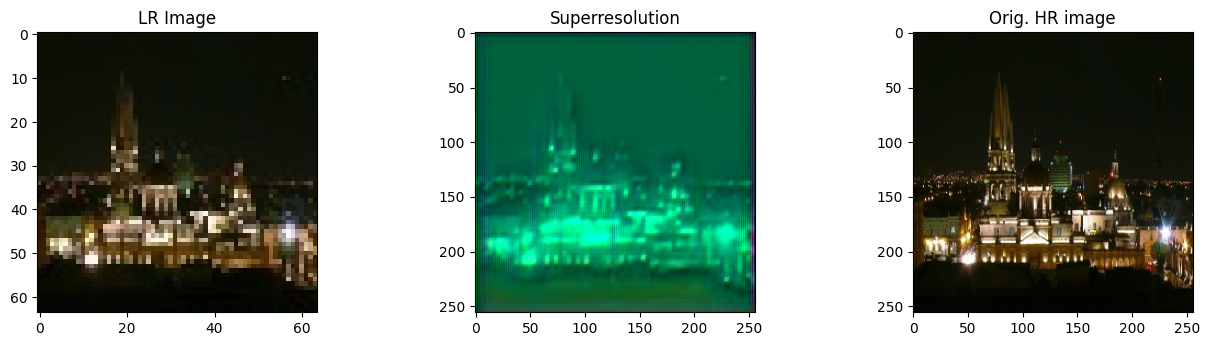

In [41]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint




[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()